<a href="https://colab.research.google.com/github/JadeLilyx/IIns-VAE/blob/master/IIns_MRC_Program.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Robust Wireless Sensing with IIns-VAE, IIns-MRC, and IIns-CMRC**


This notebook demonstrates the implementation and evaluation of the INS-VAE, INS-MRC, and INS-CMRC models for robust wireless sensing.
We aim to enhance the robustness and adaptability of these models in various real-world scenarios, including standard classification, concept drift, and covariate shift.

## **Introduction**


In this notebook, we will explore:
- **Baseline Methods**: Implementing and evaluating traditional classifiers.
- **IIns-VAE Model**: The original model with a neural network classifier.
- **IIns-MRC and IIns-CMRC Models**: Variants of IIns-VAE with Maximum Risk Classifier (MRC) integrations.
- **Transfer Learning Scenarios**: General to specific environments, high to low label resolutions, and mixed to specific environments.
- **Concept Drift and Covariate Shift**: Evaluating model robustness under changing data distributions.


## **0. Imports and Setup**

First, let's import the necessary libraries and set up the file paths for our datasets stored in Google Drive.

In [1]:
!pip install torch torchvision torchaudio
!pip install pandas matplotlib scikit-learn

In [2]:
!pip install umap

In [3]:
import numpy as np
import math
import os
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial import ConvexHull
from scipy.spatial.distance import euclidean, cosine
from scipy.stats import multivariate_normal
import scipy.cluster.hierarchy as shc
from mpl_toolkits.mplot3d import Axes3D
import umap
import itertools
import argparse
import time
import pickle

# Machine Learning Libraries
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn import manifold
from sklearn.cluster import AgglomerativeClustering
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVR, SVC
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import KFold, cross_val_score
from sklearn.decomposition import PCA

# PyTorch for Deep Learning
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
from torch.nn import functional as F

In [4]:
# MRCpy Library
!pip install MRCpy
from MRCpy import MRC, CMRC

## **1. Utility Functions**

This section provides a comprehensive set of utility functions essential for representation learning, evaluation metrics for concurrent tasks, and signal generation. These utilities are designed to facilitate robust analysis, benchmarking, and comparison of different models.



### **1.1 Representation Learning**

Feature Extraction and Visualization
+ Physical Features Extraction
  + PFs 1: Extract energy, peak amplityde, rise time, mean excess delay, RMS delay spread, and kurtosis from waveforms.
  + Purpose: These features serve as inputs for various classifiers and are compared with machine learning extracted features.
+ Dimension Reduction Features
  + Apply PCA for dimensionality reduction and visualization of feature space.

#### **1.1.1 Physical Features**

1. Physical Features (PF):

Energy
Peak Amplitude
Rise Time
Mean Excess Delay
RMS Delay Spread
Kurtosis

2. Additional Physical Features (MPF):

Skewness
Peak-to-Average Power Ratio (PAPR)

3. Principal Component Analysis (PCA):

Dimensionality reduction to extract principal components.

In [5]:
def features_extract(data, method='PF', length=6):
    if method == 'PF':
        features = physical_features(data)
    elif method == 'PCA':
        features = PCA_features(data, length)
    elif method == 'MPF':
        features = more_physical_features(data)
    else:
        raise ValueError('Unknown feature extraction method. Options: PF, PCA, MPF')
    return features

def physical_features(cir_data):
    # Convert data to list for easier manipulation
    cir_data_list = cir_data.tolist()

    # Initialize lists to store features
    M_AMP = []
    max_pos = []
    R_T = []
    data_w = []
    fhi = []
    T_EMD = []
    T_RMS = []
    mu = []
    sigma = []
    Kur = []

    # Extract max amplitude and position
    for list_item in cir_data_list:
        max_item = max(list_item)
        max_index = list_item.index(max_item)
        M_AMP.append(max_item)
        max_pos.append(max_index)

    # Extract rise time
    for index, cir in enumerate(cir_data_list):
        mean_n = np.nanmean(cir)
        sigma_n = np.nanstd(cir)

        rise_t1 = np.argwhere(np.array(cir) > (6 * (sigma_n + mean_n)))
        rise_t2 = np.argwhere(np.array(cir) > (0.6 * M_AMP[index]))

        if rise_t1.size == 0:
            rise_t1 = [[0]]
        if rise_t2.size == 0:
            rise_t2 = [[0]]
        rise_time = max(0, rise_t2[0][0] - rise_t1[0][0])
        R_T.append(rise_time)

    # Window the data around the peak amplitude
    for index, pos in enumerate(max_pos):
        if pos - 20 < 0:
            data_w.append(cir_data_list[index][:35])
        elif pos + 15 > len(cir_data_list[index]):
            data_w.append(cir_data_list[index][-35:])
        else:
            data_w.append(cir_data_list[index][pos - 20: pos + 15])

    # Convert to numpy array for vectorized operations
    data_w_np = np.array(data_w)
    data_w_np_power_2 = data_w_np ** 2
    Er = np.nansum(data_w_np_power_2, axis=1)

    # Calculate mean excess delay and RMS delay spread
    for index1, data_w_slice in enumerate(data_w):
        fhi.append(data_w_np_power_2[index1] / Er[index1])
        T_EMD.append(np.sum((np.arange(len(data_w_slice)) + 1) * fhi[index1]))
        T_RMS.append(np.sqrt(np.sum(((np.arange(len(data_w_slice)) + 1 - T_EMD[index1]) ** 2) * fhi[index1])))

    # Calculate kurtosis
    for index1, data_w_slice in enumerate(data_w):
        mu_val = np.mean(data_w_slice)
        mu.append(mu_val)
        sigma_val = np.std(data_w_slice)
        sigma.append(sigma_val)
        Kur.append(np.mean(((data_w_slice - mu_val) ** 4)) / (sigma_val ** 4))

    # Combine all features into a single array
    feature = np.column_stack((Er, T_EMD, T_RMS, Kur, R_T, M_AMP))
    return feature

def PCA_features(data, n_components=6):
    # Flatten the data
    data_flat = data.reshape(data.shape[0], -1)

    # Apply PCA
    pca = PCA(n_components=n_components)
    pca_features = pca.fit_transform(data_flat)
    return pca_features

def more_physical_features(cir_data):
    # Convert data to list for easier manipulation
    cir_data_list = cir_data.tolist()

    # Initialize lists to store features
    M_AMP = []
    max_pos = []
    R_T = []
    data_w = []
    fhi = []
    T_EMD = []
    T_RMS = []
    mu = []
    sigma = []
    Kur = []
    Skew = []
    PAPR = []

    # Extract max amplitude and position
    for list_item in cir_data_list:
        max_item = max(list_item)
        max_index = list_item.index(max_item)
        M_AMP.append(max_item)
        max_pos.append(max_index)

    # Extract rise time
    for index, cir in enumerate(cir_data_list):
        mean_n = np.nanmean(cir)
        sigma_n = np.nanstd(cir)

        rise_t1 = np.argwhere(np.array(cir) > (6 * (sigma_n + mean_n)))
        rise_t2 = np.argwhere(np.array(cir) > (0.6 * M_AMP[index]))

        if rise_t1.size == 0:
            rise_t1 = [[0]]
        if rise_t2.size == 0:
            rise_t2 = [[0]]
        rise_time = max(0, rise_t2[0][0] - rise_t1[0][0])
        R_T.append(rise_time)

    # Window the data around the peak amplitude
    for index, pos in enumerate(max_pos):
        if pos - 20 < 0:
            data_w.append(cir_data_list[index][:35])
        elif pos + 15 > len(cir_data_list[index]):
            data_w.append(cir_data_list[index][-35:])
        else:
            data_w.append(cir_data_list[index][pos - 20: pos + 15])

    # Convert to numpy array for vectorized operations
    data_w_np = np.array(data_w)
    data_w_np_power_2 = data_w_np ** 2
    Er = np.nansum(data_w_np_power_2, axis=1)

    # Calculate mean excess delay and RMS delay spread
    for index1, data_w_slice in enumerate(data_w):
        fhi.append(data_w_np_power_2[index1] / Er[index1])
        T_EMD.append(np.sum((np.arange(len(data_w_slice)) + 1) * fhi[index1]))
        T_RMS.append(np.sqrt(np.sum(((np.arange(len(data_w_slice)) + 1 - T_EMD[index1]) ** 2) * fhi[index1])))

    # Calculate kurtosis and skewness
    for index1, data_w_slice in enumerate(data_w):
        mu_val = np.mean(data_w_slice)
        mu.append(mu_val)
        sigma_val = np.std(data_w_slice)
        sigma.append(sigma_val)
        Kur.append(np.mean(((data_w_slice - mu_val) ** 4)) / (sigma_val ** 4))
        Skew.append(np.mean(((data_w_slice - mu_val) ** 3)) / (sigma_val ** 3))

    # Calculate PAPR (Peak-to-Average Power Ratio)
    for index1, data_w_slice in enumerate(data_w):
        PAPR.append(np.max(data_w_slice) / np.mean(data_w_slice))

    # Combine all features into a single array
    feature = np.column_stack((Er, T_EMD, T_RMS, Kur, Skew, PAPR, R_T, M_AMP))
    return feature


#### **1.1.2 Latents Visualization**

In [6]:
def reduce_latents(latents, method='t-sne', n_components=2):
    """
    Reduce dimensions to n_components, typically 2 or 3 for visualization.
    """
    if latents.shape[1] > n_components:
        if method == "umap":
            e_umap = umap.UMAP(n_components=n_components)
            reduced_latents = e_umap.fit_transform(latents)
        elif method == "t-sne":
            e_tsne = manifold.TSNE(n_components=n_components, init='pca', random_state=0)
            reduced_latents = e_tsne.fit_transform(latents)
        elif method == "pca":
            e_pca = PCA(n_components=n_components)
            reduced_latents = e_pca.fit_transform(latents)
        else:
            raise ValueError("Unknown dimension reduction method %s." % method)
    else:
        reduced_latents = latents

    return reduced_latents


In [7]:
def visualize_latents_encircle(
    features_arr, labels_arr, circ_labels_arr, save_path, epoch, dataset_name='zenodo', dataset_env='part', level='obstacle', data_type='ENV',  # visualize 'CIR' or 'ENV' code reduction
    method='umap', n_components=2, encircle_flag=True, title=False, acc_label=False
):
    data_module = dict()
    circ_data_module = dict()
    labels_list = labels_arr.tolist()
    circ_labels_list = circ_labels_arr.tolist()
    reduced_latents_list = features_arr.tolist()

    classes = set()
    for i in range(len(labels_list)):
        label_item = labels_list[i][0]
        if label_item not in data_module:
            data_module[label_item] = list()
            classes.add(label_item)
        data_module[label_item].append(reduced_latents_list[i])

    circ_classes = set()
    for i in range(len(circ_labels_list)):
        circ_label_item = circ_labels_list[i][0]
        if circ_label_item not in circ_data_module:
            circ_data_module[circ_label_item] = list()
            circ_classes.add(circ_label_item)
        circ_data_module[circ_label_item].append(reduced_latents_list[i])

    def encircle(x, y, ax=None, **kw):
        if not ax: ax = plt.gca()
        p = np.c_[x, y]
        hull = ConvexHull(p)
        poly = plt.Polygon(p[hull.vertices, :], **kw)
        ax.add_patch(poly)

    if n_components == 2:
        fig = plt.figure()
        ax = fig.add_subplot()
        for cls, color in zip(classes, plt.cm.get_cmap('Pastel1').colors):
            class_features = np.asarray(data_module[cls])
            label_str_dict = label_dictionary(dataset_name, dataset_env, level)
            ax.scatter(class_features[:, 0], class_features[:, 1], c=[color],
                       label=label_str_dict[cls], s=[12], alpha=1.0)
            ax.legend([label_str_dict[cls] for cls in classes], loc="lower left",
                      fontsize=14, framealpha=0.5)
            if encircle_flag:
                for cls2, color2 in zip(circ_classes, plt.cm.get_cmap('tab10').colors):
                    circ_class_features = np.asarray(circ_data_module[cls2])
                    encircle(circ_class_features[:, 0], circ_class_features[:, 1],
                             ec='k', fc=color2, alpha=0.2, linewidth=0)

    elif n_components == 3:
        fig = plt.figure()
        ax = fig.add_subplot(projection='3d')
        for cls, color in zip(classes, plt.cm.get_cmap('tab10').colors):
            class_features = np.asarray(data_module[cls])
            label_str_dict = label_dictionary(dataset_name, dataset_env, level)
            ax.scatter(class_features[:, 0], class_features[:, 1], class_features[:, 2], c=[color],
                       label=label_str_dict[cls], s=[2], alpha=0.5)
            plt.legend([label_str_dict[cls] for cls in classes],
                       loc="upper right", title="Environment Labels")

    plt.xticks([])
    plt.yticks([])
    resolution = dataset_name + dataset_env + '_' + level
    if title:
        title = "Environment Identification Accuracy: %.3f" % acc_label
        plt.title(title, fontsize=16)
    plt.savefig(os.path.join(save_path, "latents%s-%s_%s-%dD_epoch%d.eps"
                             % (data_type, resolution, method, n_components, epoch)),
                dpi=600, format='eps')
    plt.close()

def label_list_display(dataset_name, option='rough', level='room'):
    label_list = []
    if dataset_name == 'db1':
        if level == "room":
            label_list = ['Room1', 'Room2', 'Room3', 'Room4']
        elif level == 'obstacle':
            label_list = ['LoS', 'NLoS']

    elif dataset_name == 'db2':
        if level == "room":
            if option == 'rough':
                label_list = ['outdoor', 'indoor']
            elif level == 'obstacle':
                label_list = ['cross-room', 'big', 'medium', 'small', 'outdoor']
        elif level == "obstacle":
            if option == 'rough':
                label_list = ['LoS', 'NLoS']
            elif option == 'full':
                label_list = [
                    'LoS', 'metal window', 'glass plate', 'wood door', 'metal plate', 'LCD TV',
                    'cardboard box', 'plywood plate', 'plastic', 'polystyrene plate', 'wall'
                ]
            elif option == 'part':
                label_list = ['LoS', 'metal', 'wood', 'plastic', 'glass']
            else:
                raise ValueError("No option %s for dataset %s at obstacle level." % (option, dataset_name))
    return label_list

def label_dictionary(dataset_name, option='rough', level='room'):
    label_str_dict = {}
    if dataset_name == "db1":
        if level == "obstacle":
            label_str_dict = {0: 'LoS', 1: 'NLoS'}
        elif level == "room":
            label_str_dict = {0: 'Room1', 1: 'Room2', 2: 'Room3', 3: 'Room4'}

    elif dataset_name == 'db2':
        if level == "obstacle":
            if option == 'rough':
                label_str_dict = {0: 'LoS', 1: 'NLoS'}
            elif option == 'full':
                label_str_dict = {
                    0: 'LoS', 1: 'metal window', 2: 'glass plate', 3: 'wood door', 4: 'metal plate', 5: 'LCD TV',
                    6: 'cardboard box', 7: 'plywood plate', 8: 'plastic', 9: 'polystyrene plate', 10: 'wall'
                }
            elif option == 'part':
                label_str_dict = {0: 'LoS', 1: 'metal', 2: 'wood', 3: 'plastic', 4: 'glass'}
            else:
                raise ValueError("No option %s for dataset %s at obstacle level." % (option, dataset_name))
        elif level == "room":
            if option == 'rough':
                label_str_dict = {0: 'outdoor', 1: 'indoor'}
            else:
                label_str_dict = {0: 'cross-room', 1: 'big room', 2: 'medium room', 3: 'small room', 4: 'outdoor'}

    return label_str_dict

def label_int2str_old(label_int, dataset_name='db2', option='full', level='room'):
    label_str_dict = label_dictionary(dataset_name, option, level)
    label_str = label_str_dict[label_int]
    return label_str

def label_int2str(label, dataset_name='db2', option='full', level='room'):

    if dataset_name == 'db1':
        if level == 'room':
            label_dict = {
                0: 'Room 1', 1: 'Room 2', 2: 'Room 3', 3: 'Room 4'
            }
        else:
            label_dict = {
                0: 'LoS', 1: 'NLoS'
            }

    elif dataset_name == 'db2':
        if level == 'room':
            if option == 'rough':
                label_dict = {
                    0: 'outdoor', 1: 'indoor'
                }
            else:
                label_dict = {
                    0: 'cross-room', 1: 'big room', 2: 'medium room', 3: 'small room', 4: 'outdoor'
                }
        elif level == 'obstacle':
            if option =='full':
                label_dict = {
                    0: 'LoS',
                    1: 'Metal Window',
                    2: 'Glass Plate',
                    3: 'Wood Door',
                    4: 'Metal Plate',
                    5: 'LCD TV',
                    6: 'Cardboard Box',
                    7: 'Plywood Plate',
                    8: 'Plastic',
                    9: 'Polystyrene Plate',
                    10: 'Wall'
                }
            elif option == 'part':
                label_dict = {
                    0: 'LoS',
                    1: 'Metal',
                    2: 'Wood',
                    3: 'Plastic',
                    4: 'Glass'
                }
            elif option == 'rough':
                label_dict = {
                    0: 'LoS',
                    1: 'NLoS'
                }

    return label_dict.get(label, 'Unknown Label')

### **1.2 Evaluation Metrics for Inference and Generation Tasks**

Distance Estimation
+ `CDF_plot`: Generates a Cumulative Distribution Function (CDF) plot for distance estimation errors.

Environmental Identification
+ `confusion_matrix_display`: Updates a confusion matrix with predictions and true labels.
+ `visualize_conf_matrix`: Visualizes a confusion matrix with the option to normalize values.
+ `visualize_conf_matrix_SK`: Utilizes ConfusionMatrixDisplay from sklearn to visualize the confusion matrix.
+ `evaluate_classification`: Compute performance metrics including accuracy, precision, recall, F1 score, and AUROC.

Cross-Validation for Bounds Estimation
+ `cross_validation_bounds`: Performs cross-validation to estimate bounds of classification performance.

Signal Similarity
- `compute_similarity_metrics`: Computes similarity metrics (Euclidean distance or cosine similarity) between generated and original signals.

These functions provide a robust evaluation framework for both inference and generation tasks, enabling comprehensive assessment of model performance and generated signal quality.

In [8]:
def confusion_matrix_display(preds, labels, conf_matrix, binary_flag=False):
    if not binary_flag:
        preds = np.argmax(preds, axis=1)
    for p, t in zip(preds, labels):
        conf_matrix[p, t] += 1
    return conf_matrix

def visualize_conf_matrix(conf_matrix, num_classes, labels, normalize=True):
    plt.rc('font', size=15)
    if normalize:
        conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
    plt.imshow(conf_matrix, cmap=plt.cm.Blues, interpolation='nearest')
    plt.colorbar()
    thresh = conf_matrix.max() / 2  # darken the color if pass the threshold
    for x in range(num_classes):
        for y in range(num_classes):
            fmt = '.2f' if normalize else '.0f'
            conf_info = format(conf_matrix[y, x], fmt)  # str
            plt.text(x, y, conf_info,
                     verticalalignment='center',
                     horizontalalignment='center',
                     color="white" if conf_matrix[y, x] > thresh else "black")
    plt.ylim(-0.5, num_classes-0.5)
    plt.yticks(range(num_classes), labels)
    plt.xticks(range(num_classes), labels, rotation=45)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()

def visualize_conf_matrix_SK(conf_matrix, labels, save_path, epoch=-1):
    cm_display = ConfusionMatrixDisplay(conf_matrix, display_labels=labels).plot()
    plt.savefig(os.path.join(save_path, "ConfMatrix2_epoch%d.eps" % epoch),
                dpi=600, format='eps')
    plt.close()
    return cm_display


In [10]:
def CDF_plot(ax, err_arr, num=600, color='brown', marker='*', linestyle='-'):
    data = np.abs(err_arr)
    pred_error_max = np.max(data)
    pred_error_cnt = np.zeros((num + 1,))
    step = pred_error_max / num

    # normalize to (0, 1) by dividing max
    for i in range(data.shape[0]):
        index = int(data[i] / step)
        pred_error_cnt[index] += 1
    pred_error_cnt /= np.sum(pred_error_cnt)

    # accumulate error at each point to CDF
    CDF = np.cumsum(pred_error_cnt)

    x = np.linspace(0, pred_error_max, num=num + 1)
    stride = max(int(len(x) / 10), 1)
    ax.plot(x, CDF, "-o", color=color, markevery=stride, marker=marker, linestyle=linestyle, linewidth=2.2)
    ax.set_xlabel("Distance Error [m]", fontsize=16)
    ax.set_ylabel("CDF", fontsize=16)


In [11]:
from sklearn.preprocessing import label_binarize


def evaluate_classification(y_true, y_pred, average='macro'):
    """
    Compute various classification metrics.

    Parameters:
    - y_true: True labels.
    - y_pred: Predicted labels.
    - average: Type of averaging for multi-class metrics.

    Returns:
    - metrics: Dictionary of classification metrics.
    """
    # # Convert y_pred to one-hot encoded array if it's 1D
    # if y_pred.ndim == 1:
    #     y_pred = label_binarize(y_pred, classes=np.unique(y_true))

    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, average=average),
        'recall': recall_score(y_true, y_pred, average=average),
        'f1_score': f1_score(y_true, y_pred, average=average),
        'confusion_matrix': confusion_matrix(y_true, y_pred),
        'auroc': 0,  # roc_auc_score(y_true, y_pred, average=average, multi_class='ovo'),
    }
    return metrics

# Example usage:
y_true = np.array([0, 1, 1, 0, 1, 0])
y_pred = np.array([0, 1, 0, 0, 1, 1])
metrics = evaluate_classification(y_true, y_pred)
print(metrics)

{'accuracy': 0.6666666666666666, 'precision': 0.6666666666666666, 'recall': 0.6666666666666666, 'f1_score': 0.6666666666666666, 'confusion_matrix': array([[2, 1],
       [1, 2]]), 'auroc': 0}


In [12]:
def cross_validation_bounds(classifier, X, y, cv=5, scoring='accuracy'):
    """
    Perform cross-validation to estimate bounds of classification performance.

    Parameters:
    - classifier: The classification model to evaluate.
    - X: Feature data.
    - y: Labels.
    - cv: Number of cross-validation folds.
    - scoring: Metric to evaluate.

    Returns:
    - scores: Array of scores for each fold.
    - lower_bound: Lower bound of the score.
    - upper_bound: Upper bound of the score.
    """
    scores = cross_val_score(classifier, X, y, cv=cv, scoring=scoring)
    lower_bound = np.min(scores)
    upper_bound = np.max(scores)
    mean_score = scores.mean()
    # std_score = scores.std()

    return scores, lower_bound, upper_bound, mean_score

# Example usage:
classifier = SVC()
X = [[0, 1], [2, 3], [1, 4], [2, 7], [3, 5], [1, 6]]
y = np.array([0, 1, 0, 0, 1, 1])
scores, lower_bound, upper_bound, mean_score = cross_validation_bounds(classifier, X, y, cv=2)
print(f"Cross-validation scores: {scores}")
print(f"Lower bound: {lower_bound}, Upper bound: {upper_bound}, Mean score: {mean_score}")

Cross-validation scores: [0.33333333 0.33333333]
Lower bound: 0.3333333333333333, Upper bound: 0.3333333333333333, Mean score: 0.3333333333333333


In [13]:
def compute_similarity_metrics(original_signals, generated_signals, metric='euclidean'):
    """
    Compute similarity metrics (Euclidean distance or cosine similarity) between generated and original signals.

    Parameters:
    - original_signals: Array of original signals.
    - generated_signals: Array of generated signals.
    - metric: Similarity metric ('euclidean' or 'cosine').

    Returns:
    - similarities: Array of similarity scores.
    """
    similarities = []
    for orig, gen in zip(original_signals, generated_signals):
        if metric == 'euclidean':
            similarity = euclidean(orig, gen)
        elif metric == 'cosine':
            similarity = cosine(orig, gen)
            # similarity = np.dot(orig, gen) / (np.linalg.norm(orig) * np.linalg.norm(gen))
        else:
            raise ValueError("Invalid similarity metric. Choose 'euclidean' or 'cosine'.")

        similarities.append(similarity)

    avg_similarity = np.mean(similarities)
    std_similarity = np.std(similarities)

    return np.array(similarities), avg_similarity, std_similarity

# Example usage:
original_signals = [np.array([1, 2, 3]), np.array([4, 5, 6])]
generated_signals = [np.array([1, 2, 2]), np.array([4, 5, 7])]

similarities, avg_similarity, std_similarity = compute_similarity_metrics(original_signals, generated_signals, metric='euclidean')

print("Similarities:", similarities)
print("Average Similarity:", avg_similarity)
print("Standard Deviation of Similarity:", std_similarity)

Similarities: [1. 1.]
Average Similarity: 1.0
Standard Deviation of Similarity: 0.0


### **1.3 Args and Hyperparameters**

In [14]:
# Notebook assigning version
def get_args():
    args = {
        # 1. Learning Parameters
        'start_epoch': 0,
        'n_epochs': 501,
        'test_epoch': 500,
        'batch_size': 512,
        'lr': 0.0001,
        'b1': 0.5,
        'b2': 0.999,
        'decay_epoch': 100,
        'n_cpu': 8,

        # 2. Dataset Parameters
        'dataset_name': "zenodo",
        'dataset_env': 'rough',
        'est_type': 'mitigation',
        'cls_type': 'obstacle',
        'split_factor': 0.6,
        'num_classes': 2,

        # 3. Network Parameters
        'n_downsample': 4,
        'n_residual': 3,
        'filters': 4,
        'range_dim': 16,
        'env_dim': 16,
        'z_dim': 256,

        # 4. MRC/CMRC Specific Parameters
        'loss_type': '0-1',
        'phi_type': 'linear',
        'integration_level': 'layer',  # layer, bottleneck, or no-integration
        'classifier_type': 'mrc',  # mrc, cmrc, or neural

        # 5. Visualization Parameters
        'sample_interval': 50,
        'checkpoint_interval': 50,
        'visual_method': "t-sne",
        'visual_dim': 2,
        'encircle_flag': False,

        # 6. Essential Paths
        'model_path': './models',
        'data_path': './data',
        'result_path': './results'
    }
    return args

args = get_args()

# Access individual parameters
learning_rate = args['lr']
batch_size = args['batch_size']

# Modify parameters directly
args['n_epochs'] = 1000
args['batch_size'] = 256


# Example model
def train_model(args):
    dataset_name = args['dataset_name']
    n_epochs = args['n_epochs']
    batch_size = args['batch_size']
    lr = args['lr']

train_model(args)

In [ ]:
# Traditional scripts version
def get_args():
    parser = argparse.ArgumentParser(description="IIns-VAE Training and Testing with MRC and CMRC Integrations")

    # 1. Learning Parameters
    parser.add_argument('--start_epoch', type=int, default=0, help='Epoch to start training.')
    parser.add_argument("--n_epochs", type=int, default=501, help="Number of epochs of training.")
    parser.add_argument("--test_epoch", type=int, default=500, help="Epoch to test model performance.")
    parser.add_argument("--batch_size", type=int, default=512, help="Size of the batches.")
    parser.add_argument("--lr", type=float, default=0.0001, help="Adam: learning rate.")
    parser.add_argument("--b1", type=float, default=0.5, help="Adam: decay of first-order momentum of gradient.")
    parser.add_argument("--b2", type=float, default=0.999, help="Adam: decay of second-order momentum of gradient.")
    parser.add_argument("--decay_epoch", type=int, default=100, help="Epoch from which to start learning rate decay.")
    parser.add_argument("--n_cpu", type=int, default=8, help="Number of CPU threads to use during batch generation.")

    # 2. Dataset Parameters
    parser.add_argument("--dataset_name", type=str, default="zenodo", help="Name of the dataset: 'ewine' or 'zenodo'.")
    parser.add_argument("--dataset_env", type=str, default='rough',
                        help="Dataset environment. Choices for zenodo: 'full', 'part'. Choice for ewine is always LOS/NLOS.")
    parser.add_argument("--est_type", type=str, default='mitigation',
                        help="Directly estimate true distance or estimate the error, i.e., estimation/mitigation.")
    parser.add_argument("--cls_type", type=str, default='obstacle',
                        help="Environment classification type: 'obstacle', 'room', or 'double'.")
    parser.add_argument("--split_factor", type=float, default=0.6, help="Ratio to split data for training the IIns-VAE network.")
    parser.add_argument('--num_classes', type=int, default=2, help='Number of classes for classification')

    # 3. Network Parameters
    parser.add_argument("--n_downsample", type=int, default=4, help="Number of downsampling layers in encoder.")
    parser.add_argument("--n_residual", type=int, default=3, help="Number of residual blocks in encoder/decoder.")
    parser.add_argument("--filters", type=int, default=4, help="Number of filters in first encoder layer.")
    parser.add_argument("--range_dim", type=int, default=16, help="Dimensionality of the environment code.")
    parser.add_argument("--env_dim", type=int, default=16, help="Dimensionality of the environment code.")
    parser.add_argument("--z_dim", type=int, default=256, help="Dimensionality of the last classifier layer code.")

    # 4. MRC/CMRC Specific Parameters
    parser.add_argument('--loss_type', type=str, default='0-1', choices=['0-1', 'log'], help='Loss function type for MRC/CMRC (0-1, log)')
    parser.add_argument('--phi_type', type=str, default='linear', choices=['linear', 'fourier'], help='Phi function type for MRC/CMRC (linear, fourier)')
    parser.add_argument('--integration_level', type=str, default='layer', choices=['layer', 'bottleneck', 'no-integration'], help='Integration level for ML classifiers (layer, bottleneck, no-integration)')
    parser.add_argument('--classifier_type', type=str, default='mrc', choices=['mrc', 'cmrc', 'neural'], help='Classifier type for IIns-VAE (mrc, cmrc, neural)')

    # 5. Visualization Parameters
    parser.add_argument("--sample_interval", type=int, default=50, help="Epoch interval for saving generator samples.")
    parser.add_argument("--checkpoint_interval", type=int, default=50, help="Epoch interval between saving model checkpoints.")
    parser.add_argument("--visual_method", type=str, default="t-sne", help="Visualization method: 'umap' or 't-sne'.")
    parser.add_argument("--visual_dim", type=int, default=2, help="2D/3D data visualization plot.")
    parser.add_argument("--encircle_flag", type=bool, default=False, help="Encircle points of the same classes.")

    # 6. Essential Paths
    parser.add_argument('--model_path', type=str, default='./models', help='Path to save/load model checkpoints')
    parser.add_argument('--data_path', type=str, default='./data', help='Path to dataset')
    parser.add_argument('--result_path', type=str, default='./results', help='Path to save results')

    return parser

args = get_args().parse_args()


### **1.4 Learning Process Supervisions**

In [15]:
import matplotlib.pyplot as plt
import numpy as np

def plot_learning_curves(X, Y1, Y2=None, Y3=None, labelx="Learning Iterations", label1="Learning Curve 1",
                         label2="Learning Curve 2", label3="Learning Curve 3", title=None,
                         color1="tab:blue", color2="tab:red", color3="tab:green"):

    fig, ax1 = plt.subplots(figsize=(16, 9), dpi=80)

    # Plot Line 1 (Left Y Axis)
    ax1.plot(X, Y1, color=color1, label=label1)
    ax1.set_xlabel(labelx, fontsize=20)
    ax1.set_ylabel(label1, color=color1, fontsize=20)
    ax1.tick_params(axis='y', labelcolor=color1)
    lines = [ax1.get_lines()[0]]

    if Y2 is not None:
        # Plot Line 2 (Right Y Axis)
        ax2 = ax1.twinx()
        ax2.plot(X, Y2, color=color2, label=label2)
        ax2.set_ylabel(label2, color=color2, fontsize=20)
        ax2.tick_params(axis='y', labelcolor=color2)
        lines.append(ax2.get_lines()[0])
    else:
        ax2 = ax1

    if Y3 is not None:
        ax2.plot(X, Y3, color=color3, label=label3)
        lines.append(ax2.get_lines()[-1])

    labels = [l.get_label() for l in lines]
    ax1.legend(lines, labels, loc="upper right", fontsize=12)
    ax2.set_xticks(np.arange(0, len(X), max(1, len(X) // 10)))
    ax2.set_xticklabels(X[::max(1, len(X) // 10)], rotation=90, fontdict={'fontsize': 10})

    if title is not None:
        ax1.set_title(title, fontsize=22)

    fig.tight_layout()
    plt.show()

# Example usage:
X = np.arange(0, 100)
Y1 = np.sin(X)
Y2 = np.cos(X)
Y3 = np.tan(X) / 10
plot_learning_curves(X, Y1, Y2, Y3, labelx="Epochs", label1="Loss", label2="Accuracy", label3="Validation Loss", title="Learning Curves")


## **2. Data**

### **2.1 Data Processing Setup**

In [16]:
# Google Drive Integration
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import shutil
from google.colab import files
uploaded = files.upload()

# Move the uploaded files to the appropriate directories
for filename in uploaded.keys():
    shutil.move(filename, '/content/drive/MyDrive/Data/')


In [ ]:
# Define file paths
DATASET_1_1_PATH = '/content/drive/MyDrive/Data/data_ewine/dataset1'
DATASET_1_2_PATH = '/content/drive/MyDrive/Data/data_ewine/dataset2'  # tag_room1, tag_room2
DATASET_2_PATH = '/content/drive/MyDrive/Data/data_zenodo/'


### **2.2 Datasets and Dataloaders for Database 1**

We split the combined dataset into training and testing sets for both standard distance estimation and classification tasks.

In [17]:
# Function to load and preprocess data from files (not in use)
def load_and_preprocess_data_db1(file_path):
    # Load the CSV file into a pandas DataFrame
    data = pd.read_csv(file_path)

    # Extract CIRs and essential labels
    cir_start_idx = 24  # CIR data starts from 25th column
    cir_end_idx = cir_start_idx + 1016
    data['CIR'] = data.iloc[:, cir_start_idx:cir_end_idx].apply(lambda x: x.values, axis=1)

    # Extract other features and labels
    features = data.iloc[:, :24]
    features['CIR'] = data['CIR']
    labels = data['NLOS']

    return features, labels

# Load data from folder function
def load_data_from_folder(folderpath):
    output_arr = []
    first = True
    for dirpath, dirnames, filenames in os.walk(folderpath):
        for file in filenames:
            filename = os.path.join(dirpath, file)
            print("Loading file " + filename + "...")
            df = pd.read_csv(filename, sep=',', header=0)
            input_data = df.values
            # append to array
            if first:
                output_arr = input_data
                first = False
            else:
                output_arr = np.vstack((output_arr, input_data))
    return output_arr

def load_data_from_file(file_path):
    output_arr = []
    first = True
    print("Loading file " + file_path + "...")
    df = pd.read_csv(file_path, sep=',', header=0)
    input_data = df.values
    # append to array
    if first:
        output_arr = input_data
        first = False
    else:
        output_arr = np.vstack((output_arr, input_data))
    return output_arr

# Load db1 data function
def load_db1_data(filepaths, room_label):
    input_arr = load_data_from_file(filepaths[0])
    if len(filepaths) > 1:
        for item in filepaths[1:]:
            temp = load_data_from_file(item)
            input_arr = np.vstack((input_arr, temp))

    np.random.shuffle(input_arr)

    data_len = 152
    distGT_arr = np.zeros((len(input_arr), 1))
    distM_arr = np.zeros((len(input_arr), 1))
    error_arr = np.zeros((len(input_arr), 1))
    label_arr = np.zeros((len(input_arr), 1))
    cir_arr = np.zeros((len(input_arr), data_len))
    room_label_arr = np.full((len(input_arr), 1), room_label)

    for i in range(len(input_arr)):
        fp_idx = int(input_arr[i][8])
        distGT_arr[i] = math.sqrt(math.pow(input_arr[i][0] - input_arr[i][2], 2) + math.pow(input_arr[i][1] - input_arr[i][3], 2))
        distM_arr[i] = input_arr[i][4]
        error_arr[i] = math.fabs(distGT_arr[i] - distM_arr[i])  # d_{GT} - d_M
        label_arr[i] = input_arr[i][5]
        cir_arr[i] = input_arr[i][fp_idx + 15: fp_idx + 15 + data_len] / float(input_arr[i][17])

    data_df = pd.DataFrame({
        'CIR': list(cir_arr),
        'Error': error_arr.flatten(),
        'Label': label_arr.flatten(),
        'MeasuredDistance': distM_arr.flatten(),
        'TrueDistance': distGT_arr.flatten(),
        'RoomLabel': room_label_arr.flatten()
    })

    return data_df


In [18]:
class UWBDataset(Dataset):
    def __init__(self, data, dataset_name='db1'):
        self.data = data
        self.dataset_name = dataset_name

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data.iloc[idx]
        if self.dataset_name in ['db1', 'db2']:
            # 'CIR' is already a NumPy array, directly convert to tensor
            return {
                'CIR': torch.tensor(sample['CIR'], dtype=torch.float32),
                'Error': torch.tensor(sample['Error'], dtype=torch.float32),
                'Label': torch.tensor(sample['Label'], dtype=torch.long),
                'MeasuredDistance': torch.tensor(sample['MeasuredDistance'], dtype=torch.float32),
                'TrueDistance': torch.tensor(sample['TrueDistance'], dtype=torch.float32),
                'RoomLabel': torch.tensor(sample['RoomLabel'], dtype=torch.long)
            }
        else:
            return {
                'CIR': torch.tensor(sample['CIR'], dtype=torch.float32),
                'Error': torch.tensor(sample['Error'], dtype=torch.float32),
                'Label': torch.tensor(sample['Label'], dtype=torch.long)
            }


In [ ]:
# Define file paths for Database 1
DATASET_1_1_PATH = '/content/drive/MyDrive/WirelessSensing/Data/data_ewine/dataset1'
DATASET_1_2_PATH = '/content/drive/MyDrive/WirelessSensing/Data/data_ewine/dataset2'

# Load data from dataset 1-1 and dataset 1-2 with room labels
data_1_1_room0 = load_db1_data([f'{DATASET_1_1_PATH}/tag_room0.csv'], room_label=0)
data_1_1_room1 = load_db1_data([f'{DATASET_1_1_PATH}/tag_room1.csv'], room_label=1)
data_1_2_room0 = load_db1_data([f'{DATASET_1_2_PATH}/tag_room0/tag_room0.csv'], room_label=2)
data_1_2_room1_parts = [load_db1_data([f'{DATASET_1_2_PATH}/tag_room1/tag_room1_part{i}.csv'], room_label=3) for i in range(4)]
data_1_2_room1 = pd.concat(data_1_2_room1_parts, ignore_index=True)

print("Dataset 1-1 (Combined)")
print(data_1_1_room0.head())
print(data_1_1_room1.head())
print("Dataset 1-2 (Combined)")
print(data_1_2_room0.head())
print(data_1_2_room1.head())

Loading file /content/drive/MyDrive/WirelessSensing/Data/data_ewine/dataset1/tag_room0.csv...


<ipython-input-17-2ce0894abadf>:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  error_arr[i] = math.fabs(distGT_arr[i] - distM_arr[i])  # d_{GT} - d_M


Loading file /content/drive/MyDrive/WirelessSensing/Data/data_ewine/dataset1/tag_room1.csv...


<ipython-input-17-2ce0894abadf>:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  error_arr[i] = math.fabs(distGT_arr[i] - distM_arr[i])  # d_{GT} - d_M


Loading file /content/drive/MyDrive/WirelessSensing/Data/data_ewine/dataset2/tag_room0/tag_room0.csv...


<ipython-input-17-2ce0894abadf>:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  error_arr[i] = math.fabs(distGT_arr[i] - distM_arr[i])  # d_{GT} - d_M


Loading file /content/drive/MyDrive/WirelessSensing/Data/data_ewine/dataset2/tag_room1/tag_room1_part0.csv...


<ipython-input-17-2ce0894abadf>:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  error_arr[i] = math.fabs(distGT_arr[i] - distM_arr[i])  # d_{GT} - d_M


Loading file /content/drive/MyDrive/WirelessSensing/Data/data_ewine/dataset2/tag_room1/tag_room1_part1.csv...


<ipython-input-17-2ce0894abadf>:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  error_arr[i] = math.fabs(distGT_arr[i] - distM_arr[i])  # d_{GT} - d_M


Loading file /content/drive/MyDrive/WirelessSensing/Data/data_ewine/dataset2/tag_room1/tag_room1_part2.csv...


<ipython-input-17-2ce0894abadf>:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  error_arr[i] = math.fabs(distGT_arr[i] - distM_arr[i])  # d_{GT} - d_M


Loading file /content/drive/MyDrive/WirelessSensing/Data/data_ewine/dataset2/tag_room1/tag_room1_part3.csv...
Dataset 1-1 (Combined)
                                                 CIR     Error  Label  \
0  [0.8421052631578947, 0.39649122807017545, 0.59...  0.290000    0.0   
1  [0.4345703125, 0.3974609375, 0.2294921875, 0.2...  0.309048    1.0   
2  [0.7839805825242718, 0.4587378640776699, 0.259...  0.370000    1.0   
3  [0.4963144963144963, 0.12039312039312039, 0.62...  0.210000    0.0   
4  [0.32732732732732733, 0.31981981981981983, 0.4...  0.317722    0.0   

   MeasuredDistance  TrueDistance  RoomLabel  
0              1.29      1.000000          0  
1              6.14      5.830952          0  
2              3.37      3.000000          0  
3              1.21      1.000000          0  
4              3.48      3.162278          0  
                                                 CIR     Error  Label  \
0  [0.426056338028169, 0.375, 0.1795774647887324,...  0.187722    0.0   


<ipython-input-17-2ce0894abadf>:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  error_arr[i] = math.fabs(distGT_arr[i] - distM_arr[i])  # d_{GT} - d_M


#### **2.2.1 Supervised Learning Settings**

In [ ]:
# Combine data from both rooms for database 1-1
data_1_1 = pd.concat([data_1_1_room0, data_1_1_room1], ignore_index=True)

# Combine data from both rooms for database 1-2
data_1_2 = pd.concat([data_1_2_room0, data_1_2_room1], ignore_index=True)

# Combine 1-1 and 1-2
data_1 = pd.concat([data_1_1, data_1_2], ignore_index=True)

# Display initial information
print("Dataset 1-1 (Combined)")
print(data_1_1.head())
print("Dataset 1-2 (Combined)")
print(data_1_2.head())

Dataset 1-1 (Combined)
                                                 CIR     Error  Label  \
0  [0.583916083916084, 0.5524475524475524, 0.8251...  0.235786    0.0   
1  [0.4638671875, 0.2470703125, 0.2744140625, 0.1...  1.130980    1.0   
2  [0.475, 0.975, 0.684375, 0.996875, 0.115625, 0...  0.221573    0.0   
3  [0.5280172413793104, 0.47413793103448276, 0.19...  0.154449    0.0   
4  [1.1532567049808429, 0.9731800766283525, 1.226...  0.215786    0.0   

   MeasuredDistance  TrueDistance  RoomLabel  
0              1.65      1.414214          0  
1              6.23      5.099020          0  
2              3.05      2.828427          0  
3              3.76      3.605551          0  
4              1.63      1.414214          0  
Dataset 1-2 (Combined)
                                                 CIR     Error  Label  \
0  [0.25189825536597305, 0.2686010187686658, 0.38...  1.178932    1.0   
1  [0.9523177854638784, 0.8848865391330798, 0.780...  0.244214    0.0   
2  [0.15906541

In [ ]:
# Split the dataset into training and testing sets
train_cir, test_cir, train_err, test_err, train_label, test_label, train_dM, test_dM, train_dG, test_dG, train_rlabel, test_rlabel = train_test_split(
    data_1['CIR'].tolist(),
    data_1['Error'],
    data_1['Label'],
    data_1['MeasuredDistance'],
    data_1['TrueDistance'],
    data_1['RoomLabel'],
    train_size=0.8,
    random_state=42
)

# Convert lists to DataFrames for easier handling
train_data = pd.DataFrame({
    'CIR': train_cir,
    'Error': train_err,
    'Label': train_label,
    'MeasuredDistance': train_dM,
    'TrueDistance': train_dG,
    'RoomLabel': train_rlabel
})

test_data = pd.DataFrame({
    'CIR': test_cir,
    'Error': test_err,
    'Label': test_label,
    'MeasuredDistance': test_dM,
    'TrueDistance': test_dG,
    'RoomLabel': test_rlabel
})

# Display the shapes of the training and testing sets
print("Training set shape:", train_data.shape)
print("Testing set shape:", test_data.shape)

# Paths for saving the data
train_data_path = '/content/drive/MyDrive/WirelessSensing/Data/data_ewine/SL1-train_data.pkl'
test_data_path = '/content/drive/MyDrive/WirelessSensing/Data/data_ewine/SL1-test_data.pkl'
# Save data
with open(train_data_path, 'wb') as f:
    pickle.dump(train_data, f)
with open(test_data_path, 'wb') as f:
    pickle.dump(test_data, f)

print(f"Data saved to {train_data_path} and {test_data_path}")

# Load data
with open(train_data_path, 'rb') as f:
    train_data = pickle.load(f)
with open(test_data_path, 'rb') as f:
    test_data = pickle.load(f)

print(f"Data loaded from {train_data_path} and {test_data_path}")

Training set shape: (17628, 6)
Testing set shape: (4407, 6)
Data saved to /content/drive/MyDrive/WirelessSensing/Data/data_ewine/SL1-train_data.pkl and /content/drive/MyDrive/WirelessSensing/Data/data_ewine/SL1-test_data.pkl
Data loaded from /content/drive/MyDrive/WirelessSensing/Data/data_ewine/SL1-train_data.pkl and /content/drive/MyDrive/WirelessSensing/Data/data_ewine/SL1-test_data.pkl


In [ ]:
# Create data loaders for training and testing
train_dataset_1 = UWBDataset(train_data)
test_dataset_1 = UWBDataset(test_data)

train_loader_1 = DataLoader(train_dataset_1, batch_size=32, shuffle=True)
test_loader_1 = DataLoader(test_dataset_1, batch_size=32, shuffle=False)

# Display a batch of data
for batch in train_loader_1:
    print(batch['CIR'].shape)
    print(batch['Error'].shape)
    print(batch['Label'].shape)
    print(batch['MeasuredDistance'].shape)
    print(batch['TrueDistance'].shape)
    print(batch['RoomLabel'].shape)
    print(batch)
    break

torch.Size([32, 152])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
{'CIR': tensor([[1.6637, 0.6339, 0.1198,  ..., 0.2660, 1.5678, 1.1873],
        [0.8979, 0.8088, 1.7758,  ..., 1.6102, 0.5456, 0.8211],
        [0.2939, 0.3096, 0.2334,  ..., 0.5029, 0.3350, 0.0889],
        ...,
        [0.2432, 0.1445, 0.2949,  ..., 0.3047, 0.2939, 0.4922],
        [0.6944, 0.4531, 0.4477,  ..., 1.0107, 0.7989, 1.2547],
        [0.4086, 0.4721, 0.2665,  ..., 1.1193, 1.0406, 1.2005]]), 'Error': tensor([0.0461, 0.1400, 0.3031, 0.4569, 0.0152, 1.0210, 0.3500, 0.9898, 0.4498,
        0.9300, 0.5148, 0.8010, 0.2079, 0.4100, 0.2200, 0.3216, 0.2528, 0.1339,
        0.1952, 0.2079, 0.2548, 0.2079, 0.0939, 0.0961, 1.8254, 0.0339, 0.1279,
        0.1872, 0.2479, 2.0918, 0.1469, 0.1558]), 'Label': tensor([0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0,
        1, 1, 1, 1, 1, 1, 0, 0]), 'MeasuredDistance': tensor([2.1900, 1.8600, 5.9600, 5.2000, 5.37

#### **2.2.2 Transfer Learning Settings**

We set up the data for transfer learning scenarios, defining the source and target domains.

##### Scenario 1: General to Specific Room Environments

Domain Setup:
  + Source Domain: Database 1-1 and Database 1-2 (large dataset).
  + Target Domain: Specific room environment subset from Database 1-2 (smaller dataset).

Training on Source Domain:
Train all variants on the larger, diverse dataset.

Fine-Tuning on Target Domain:
Fine-tune that last layer or entire classifier on the smaller, specific room dataset.

Evaluation:
Compare performance metrics and bounds estimation.

Expected Results:
Demonstrate the ability of models to adapt from general to specific environments with minimal data.


In [ ]:
# Combine data from both rooms for database 1-1
data_source_1_1 = pd.concat([data_1_1_room0, data_1_1_room1], ignore_index=True)

# Combine data from both rooms for database 1-2
data_source_1_2 = pd.concat([data_1_2_room0, data_1_2_room1], ignore_index=True)

# Define target domain: Specific room environment subset from dataset 1-2 (not overlap with source domain)
data_target_1 = data_source_1_2.sample(n=5000, random_state=42)
data_source_1_2 = data_source_1_2.drop(data_target_1.index)

# Combine dataset 1-1 and 1-2 data to form the complete source domain
data_source_1 = pd.concat([data_source_1_1, data_source_1_2], ignore_index=True)

# Display the shapes of the source and target domain datasets
print("Source domain shape (Database 1):", data_source_1.shape)
print("Target domain shape (Database 1):", data_target_1.shape)

Source domain shape (Database 1): (17035, 6)
Target domain shape (Database 1): (5000, 6)


In [ ]:
# Directly assign training set
train_cir = data_source_1['CIR'].tolist()
train_err = data_source_1['Error']
train_label = data_source_1['Label']
train_dM = data_source_1['MeasuredDistance']
train_dG = data_source_1['TrueDistance']
train_rlabel = data_source_1['RoomLabel']

# Convert lists to DataFrames for easier handling
train_data_source = pd.DataFrame({
    'CIR': train_cir,
    'Error': train_err,
    'Label': train_label,
    'MeasuredDistance': train_dM,
    'TrueDistance': train_dG,
    'RoomLabel': train_rlabel
})

# Display the shapes of the training and testing sets
print("Training Set Shape (Dataset 1):", train_data_source.shape)

train_data_source_path = '/content/drive/MyDrive/WirelessSensing/Data/data_ewine/TF1-train_data_source.pkl'
# test_data.to_csv('/content/drive/MyDrive/WirelessSensing/Data/data_ewine/TF-1test_data_source.csv', index=False)

# Save data
with open(train_data_source_path, 'wb') as f:
    pickle.dump(train_data_source, f)

print(f"Data saved to {train_data_source_path}")

# Split the target domain data into training and testing sets for fine-tuning
train_cir_t, test_cir_t, train_err_t, test_err_t, train_label_t, test_label_t, train_dM_t, test_dM_t, train_dG_t, test_dG_t, train_rlabel_t, test_rlabel_t = train_test_split(
    data_target_1['CIR'].tolist(),
    data_target_1['Error'],
    data_target_1['Label'],
    data_target_1['MeasuredDistance'],
    data_target_1['TrueDistance'],
    data_target_1['RoomLabel'],
    train_size=0.8,
    random_state=42
)

# Convert lists to DataFrames for easier handling
train_data_target = pd.DataFrame({
    'CIR': train_cir_t,
    'Error': train_err_t,
    'Label': train_label_t,
    'MeasuredDistance': train_dM_t,
    'TrueDistance': train_dG_t,
    'RoomLabel': train_rlabel_t
})

test_data_target = pd.DataFrame({
    'CIR': test_cir_t,
    'Error': test_err_t,
    'Label': test_label_t,
    'MeasuredDistance': test_dM_t,
    'TrueDistance': test_dG_t,
    'RoomLabel': test_rlabel_t
})

# Display the shapes of the training and testing sets
print("Training set shape (target domain):", train_data_target.shape)
print("Testing set shape (target domain):", test_data_target.shape)
train_data_target_path = '/content/drive/MyDrive/WirelessSensing/Data/data_ewine/TF1-train_data_target.pkl'
test_data_target_path = '/content/drive/MyDrive/WirelessSensing/Data/data_ewine/TF1-test_data_target.pkl'

# Save data
with open(train_data_target_path, 'wb') as f:
    pickle.dump(train_data_target, f)
with open(test_data_target_path, 'wb') as f:
    pickle.dump(test_data_target, f)

print(f"Data saved to {train_data_target_path} and {test_data_target_path}")


Training Set Shape (Dataset 1): (17035, 6)
Data saved to /content/drive/MyDrive/WirelessSensing/Data/data_ewine/TF1-train_data_source.pkl
Training set shape (target domain): (4000, 6)
Testing set shape (target domain): (1000, 6)
Data saved to /content/drive/MyDrive/WirelessSensing/Data/data_ewine/TF1-train_data_target.pkl and /content/drive/MyDrive/WirelessSensing/Data/data_ewine/TF1-test_data_target.pkl


In [ ]:
# Create data loaders for training and testing
# Create data loaders for training and testing in supervised learning
train_loader_source = DataLoader(UWBDataset(train_data_source), batch_size=32, shuffle=True)

# Create data loaders for training and testing in the target domain
train_loader_target = DataLoader(UWBDataset(train_data_target), batch_size=32, shuffle=True)
test_loader_target = DataLoader(UWBDataset(test_data_target), batch_size=32, shuffle=False)

# Display a batch of data
for batch in train_loader_source:
    print(batch['CIR'].shape)
    print(batch['Error'].shape)
    print(batch['Label'].shape)
    print(batch)
    break

for batch in train_loader_target:
    print(batch['CIR'].shape)
    print(batch['Error'].shape)
    print(batch['Label'].shape)
    print(batch)
    break

torch.Size([32, 152])
torch.Size([32])
torch.Size([32])
{'CIR': tensor([[0.2374, 0.1384, 0.1963,  ..., 0.2305, 0.1290, 0.2564],
        [0.2807, 0.3866, 0.2379,  ..., 1.2026, 0.9833, 0.7082],
        [0.1304, 0.2062, 0.2818,  ..., 0.7949, 0.5897, 0.7653],
        ...,
        [0.3657, 0.2010, 0.2965,  ..., 0.3252, 0.1032, 0.4064],
        [0.1670, 0.1719, 0.2754,  ..., 0.1035, 0.2510, 0.6250],
        [1.5190, 0.2941, 0.8432,  ..., 1.7490, 1.3958, 1.9177]]), 'Error': tensor([0.1379, 0.0858, 0.5144, 0.3800, 0.2379, 0.3300, 0.1672, 0.4900, 0.5300,
        0.9800, 0.1339, 0.2244, 0.0544, 0.0900, 0.2039, 0.5969, 0.0100, 0.1600,
        0.0556, 0.4242, 0.0000, 0.6369, 0.2477, 0.0100, 0.0200, 0.2179, 0.2279,
        0.2158, 0.2900, 0.4189, 0.2244, 0.1284]), 'Label': tensor([1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
        0, 1, 1, 0, 0, 1, 1, 1]), 'MeasuredDistance': tensor([4.6100, 1.5000, 4.1200, 1.6200, 4.7100, 1.3300, 6.2500, 5.4900, 4.5300,
        4.9800,

### **2.3 Datasets and Dataloaders for Database 2**

In [19]:
# Load and preprocess data from Database 2 (not in use)
def load_and_preprocess_data_db2(file_path):
    # Load the dataset from the pickle file
    print("Loading " + file_path + "...")
    dataset = pd.read_pickle(file_path)

    # Extract CIRs and essential labels
    dataset['Obstacle'] = dataset['Obstacle'].apply(lambda x: np.array([int(i) for i in x], dtype=int))

    features = dataset[['CIR', 'Room', 'Obstacle']]
    labels_room = dataset['Room']
    labels_obstacle = dataset['Obstacle']

    return features, labels_room, labels_obstacle

def load_db2_data(file_path, option=None):
    print("Loading data from " + file_path + "...")
    data = pd.read_pickle(file_path)

    cir_arr = None
    distGT_arr = None
    distM_arr = None
    err_arr = None
    obs_label_arr = None
    room_label_arr = None

    if option is None:
        option = 'full'

    # full obstacles and rooms
    if option == 'full':
        obstacles = {
            '0000000000': 0, '0000000001': 1, '0000000010': 2, '0000000100': 3, '0000001000': 4,
            '0000010000': 5, '0000100000': 6, '0001000000': 7, '0010000000': 8, '0100000000': 9, '1000000000': 10
        }

        for obs, label in obstacles.items():
            ds = np.asarray(data.loc[data['Obstacles'] == obs][['CIR', 'Error', 'Room', 'Range']])
            ds = np.asarray([np.array(x) for x in ds])
            cir_arr_i = np.vstack(ds[:, 0])
            err_arr_i = np.vstack(ds[:, 1])
            obs_label_arr_i = np.ones((cir_arr_i.shape[0], 1)) * label
            room_label_arr_i = np.vstack(ds[:, 2])
            distGT_arr_i = np.vstack(ds[:, 3])
            distM_arr_i = np.abs(distGT_arr_i + err_arr_i)

            if cir_arr is None:
                cir_arr = cir_arr_i
                err_arr = err_arr_i
                obs_label_arr = obs_label_arr_i
                room_label_arr = room_label_arr_i
                distGT_arr = distGT_arr_i
                distM_arr = distM_arr_i
            else:
                cir_arr = np.vstack((cir_arr, cir_arr_i))
                err_arr = np.vstack((err_arr, err_arr_i))
                obs_label_arr = np.vstack((obs_label_arr, obs_label_arr_i))
                room_label_arr = np.vstack((room_label_arr, room_label_arr_i))
                distGT_arr = np.vstack((distGT_arr, distGT_arr_i))
                distM_arr = np.vstack((distM_arr, distM_arr_i))

    elif option == 'part':
        obstacles = {
            '0000000000': 0, '0000000001': 1, '0000001000': 1, '0001000000': 2, '0010000000': 3, '0000000010': 4
        }

        for obs, label in obstacles.items():
            ds = np.asarray(data.loc[data['Obstacles'] == obs][['CIR', 'Error', 'Room', 'Range']])
            ds = np.asarray([np.array(x) for x in ds])
            cir_arr_i = np.vstack(ds[:, 0])
            err_arr_i = np.vstack(ds[:, 1])
            obs_label_arr_i = np.ones((cir_arr_i.shape[0], 1)) * label
            room_label_arr_i = np.vstack(ds[:, 2])
            distGT_arr_i = np.vstack(ds[:, 3])
            distM_arr_i = np.abs(distGT_arr_i + err_arr_i)

            if cir_arr is None:
                cir_arr = cir_arr_i
                err_arr = err_arr_i
                obs_label_arr = obs_label_arr_i
                room_label_arr = room_label_arr_i
                distGT_arr = distGT_arr_i
                distM_arr = distM_arr_i
            else:
                cir_arr = np.vstack((cir_arr, cir_arr_i))
                err_arr = np.vstack((err_arr, err_arr_i))
                obs_label_arr = np.vstack((obs_label_arr, obs_label_arr_i))
                room_label_arr = np.vstack((room_label_arr, room_label_arr_i))
                distGT_arr = np.vstack((distGT_arr, distGT_arr_i))
                distM_arr = np.vstack((distM_arr, distM_arr_i))

    elif option == 'rough':
        los = '0000000000'
        nlos_obstacles = ['0000000001', '0000000010', '0000001000', '0010000000', '0000000100', '0100000000', '1000000000']

        ds_los = np.asarray(data.loc[data['Obstacles'] == los][['CIR', 'Error', 'Room', 'Range']])
        ds_los = np.asarray([np.array(x) for x in ds_los])
        cir_arr_los = np.vstack(ds_los[:, 0])
        err_arr_los = np.vstack(ds_los[:, 1])
        obs_label_arr_los = np.zeros((cir_arr_los.shape[0], 1))
        room_label_arr_los = np.vstack(ds_los[:, 2])
        distGT_arr_los = np.vstack(ds_los[:, 3])
        distM_arr_los = np.abs(distGT_arr_los + err_arr_los)

        cir_arr_nlos = None
        err_arr_nlos = None
        obs_label_arr_nlos = None
        room_label_arr_nlos = None
        distGT_arr_nlos = None
        distM_arr_nlos = None

        for obs in nlos_obstacles:
            ds_nlos = np.asarray(data.loc[data['Obstacles'] == obs][['CIR', 'Error', 'Room', 'Range']])
            ds_nlos = np.asarray([np.array(x) for x in ds_nlos])
            cir_arr_nlos_i = np.vstack(ds_nlos[:, 0])
            err_arr_nlos_i = np.vstack(ds_nlos[:, 1])
            obs_label_arr_nlos_i = np.ones((cir_arr_nlos_i.shape[0], 1))
            room_label_arr_nlos_i = np.vstack(ds_nlos[:, 2])
            distGT_arr_nlos_i = np.vstack(ds_nlos[:, 3])
            distM_arr_nlos_i = np.abs(distGT_arr_nlos_i + err_arr_nlos_i)

            if cir_arr_nlos is None:
                cir_arr_nlos = cir_arr_nlos_i
                err_arr_nlos = err_arr_nlos_i
                obs_label_arr_nlos = obs_label_arr_nlos_i
                room_label_arr_nlos = room_label_arr_nlos_i
                distGT_arr_nlos = distGT_arr_nlos_i
                distM_arr_nlos = distM_arr_nlos_i
            else:
                cir_arr_nlos = np.vstack((cir_arr_nlos, cir_arr_nlos_i))
                err_arr_nlos = np.vstack((err_arr_nlos, err_arr_nlos_i))
                obs_label_arr_nlos = np.vstack((obs_label_arr_nlos, obs_label_arr_nlos_i))
                room_label_arr_nlos = np.vstack((room_label_arr_nlos, room_label_arr_nlos_i))
                distGT_arr_nlos = np.vstack((distGT_arr_nlos, distGT_arr_nlos_i))
                distM_arr_nlos = np.vstack((distM_arr_nlos, distM_arr_nlos_i))

        cir_arr = np.vstack((cir_arr_los, cir_arr_nlos))
        err_arr = np.vstack((err_arr_los, err_arr_nlos))
        obs_label_arr = np.vstack((obs_label_arr_los, obs_label_arr_nlos))
        room_label_arr = np.vstack((room_label_arr_los, room_label_arr_nlos))
        distGT_arr = np.vstack((distGT_arr_los, distGT_arr_nlos))
        distM_arr = np.vstack((distM_arr_los, distM_arr_nlos))

    data_module = np.hstack((cir_arr, err_arr, obs_label_arr, room_label_arr, distM_arr, distGT_arr))
    np.random.shuffle(data_module)

    cir_arr = data_module[:, 0:len(cir_arr[0])]
    err_arr = data_module[:, len(cir_arr[0]):len(cir_arr[0]) + 1]
    obs_label_arr = data_module[:, len(cir_arr[0]) + 1: len(cir_arr[0]) + 2]
    room_label_arr = data_module[:, len(cir_arr[0]) + 2: len(cir_arr[0]) + 3]
    distM_arr = data_module[:, len(cir_arr[0]) + 3: len(cir_arr[0]) + 4]
    distGT_arr = data_module[:, len(cir_arr[0]) + 4:]

    data_df = pd.DataFrame({
        'CIR': list(cir_arr),
        'Error': err_arr.flatten(),
        'Label': obs_label_arr.flatten(),
        'RoomLabel': room_label_arr.flatten(),
        'MeasuredDistance': distM_arr.flatten(),
        'TrueDistance': distGT_arr.flatten()
    })

    return data_df

In [20]:
class UWBDataset(Dataset):
    def __init__(self, data, dataset_name='db2'):
        self.data = data
        self.dataset_name = dataset_name

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data.iloc[idx]
        if self.dataset_name in ['db1', 'db2']:
            return {
                'CIR': torch.tensor(sample['CIR'], dtype=torch.float32),
                'Error': torch.tensor(sample['Error'], dtype=torch.float32),
                'Label': torch.tensor(sample['Label'], dtype=torch.long),
                'MeasuredDistance': torch.tensor(sample['MeasuredDistance'], dtype=torch.float32),
                'TrueDistance': torch.tensor(sample['TrueDistance'], dtype=torch.float32),
                'RoomLabel': torch.tensor(sample['RoomLabel'], dtype=torch.long)
            }
        else:
            return {
                'CIR': torch.tensor(sample['CIR'], dtype=torch.float32),
                'Error': torch.tensor(sample['Error'], dtype=torch.float32),
                'Label': torch.tensor(sample['Label'], dtype=torch.long)
            }


In [ ]:
# Define file path for Database 2
DATASET_2_PATH = '/content/drive/MyDrive/WirelessSensing/Data/data_zenodo/dataset.pkl'

# Load and preprocess data from Database 2
data_2_full = load_db2_data(DATASET_2_PATH, option='full')

# Display the shapes of the dataset
print("Database 2 (full) shape:", data_2_full.shape)
print(data_2_full.head())

# Load and preprocess data from Database 2
data_2_part = load_db2_data(DATASET_2_PATH, option='part')

# Display the shapes of the dataset
print("Database 2 (part) shape:", data_2_part.shape)
print(data_2_part.head())

# Load and preprocess data from Database 2
data_2_rough = load_db2_data(DATASET_2_PATH, option='rough')

# Display the shapes of the dataset
print("Database 2 (rough) shape:", data_2_rough.shape)
print(data_2_rough.head())

Loading data from /content/drive/MyDrive/WirelessSensing/Data/data_zenodo/dataset.pkl...
Database 2 (full) shape: (31244, 6)
                                                 CIR     Error  Label  \
0  [50.8035432, 230.950211, 86.3307593, 71.19691,...  0.055247    8.0   
1  [85.70880935, 134.73678043, 79.39773297, 88.54...  0.309830    5.0   
2  [159.80613255, 122.97154142, 179.01117284, 570...  0.058849    5.0   
3  [238.90793206, 384.60369213, 178.31713322, 508...  0.127577    4.0   
4  [127.12198866, 47.04253395, 131.24404748, 575....  0.080428    4.0   

   RoomLabel  MeasuredDistance  TrueDistance  
0        1.0          4.102669      4.047422  
1        1.0          3.691841      3.382011  
2        4.0          9.091857      9.033008  
3        4.0          9.385722      9.258145  
4        2.0          4.643171      4.562743  
Loading data from /content/drive/MyDrive/WirelessSensing/Data/data_zenodo/dataset.pkl...
Database 2 (part) shape: (20832, 6)
                             

#### **2.3.1 Supervised Learning Settings**

##### 1. Cross-Domain Testing Set

In [ ]:
# Condition 1: Exclude medium room (RoomLabel=2) for the testing set
data_2 = data_2_part
train_data_exclude = data_2[data_2['RoomLabel'] != 2]
test_data_exclude = data_2[data_2['RoomLabel'] == 2]

# Extract features and labels for training and testing sets
train_cir_exclude = np.vstack(train_data_exclude['CIR'])
test_cir_exclude = np.vstack(test_data_exclude['CIR'])
train_err_exclude = train_data_exclude['Error'].values
test_err_exclude = test_data_exclude['Error'].values
train_obs_label_exclude = train_data_exclude['Label'].values
test_obs_label_exclude = test_data_exclude['Label'].values
train_room_label_exclude = train_data_exclude['RoomLabel'].values
test_room_label_exclude = test_data_exclude['RoomLabel'].values
train_dM_exclude = train_data_exclude['MeasuredDistance'].values
test_dM_exclude = test_data_exclude['MeasuredDistance'].values
train_dG_exclude = train_data_exclude['TrueDistance'].values
test_dG_exclude = test_data_exclude['TrueDistance'].values

print("Training set shape (excluding medium room):", train_data_exclude.shape)
print("Testing set shape (medium room):", test_data_exclude.shape)

Training set shape (excluding medium room): (14381, 6)
Testing set shape (medium room): (6451, 6)


In [ ]:
# Create DataFrames for training and testing sets
train_data_exclude = pd.DataFrame({
    'CIR': list(train_cir_exclude),
    'Error': train_err_exclude,
    'Label': train_obs_label_exclude,
    'MeasuredDistance': train_dM_exclude,
    'TrueDistance': train_dG_exclude,
    'RoomLabel': train_room_label_exclude
})

test_data_exclude = pd.DataFrame({
    'CIR': list(test_cir_exclude),
    'Error': test_err_exclude,
    'Label': test_obs_label_exclude,
    'MeasuredDistance': test_dM_exclude,
    'TrueDistance': test_dG_exclude,
    'RoomLabel': test_room_label_exclude
})
train_data_exclude_path = '/content/drive/MyDrive/WirelessSensing/Data/data_zenodo/SL2-train_data_exclude.pkl'
test_data_exclude_path = '/content/drive/MyDrive/WirelessSensing/Data/data_zenodo/SL2-test_data_exclude.pkl'

# Save data
with open(train_data_exclude_path, 'wb') as f:
    pickle.dump(train_data_exclude, f)
with open(test_data_exclude_path, 'wb') as f:
    pickle.dump(test_data_exclude, f)

print(f"Data saved to {train_data_exclude_path} and {test_data_exclude_path}")

# Create datasets
train_dataset_exclude = UWBDataset(train_data_exclude, dataset_name='db2')
test_dataset_exclude = UWBDataset(test_data_exclude, dataset_name='db2')

# Create dataloaders
batch_size = 32

train_loader_exclude = DataLoader(train_dataset_exclude, batch_size=batch_size, shuffle=True)
test_loader_exclude = DataLoader(test_dataset_exclude, batch_size=batch_size, shuffle=False)

# Display the number of batches in each dataloader
print(f'Number of batches in train_loader_exclude: {len(train_loader_exclude)}')
print(f'Number of batches in test_loader_exclude: {len(test_loader_exclude)}')

# Display a batch of data
for batch in train_loader_exclude:
    print(batch['CIR'].shape)
    print(batch['Error'].shape)
    print(batch['Label'].shape)
    print(batch)
    break

Data saved to /content/drive/MyDrive/WirelessSensing/Data/data_zenodo/SL2-train_data_exclude.pkl and /content/drive/MyDrive/WirelessSensing/Data/data_zenodo/SL2-test_data_exclude.pkl
Number of batches in train_loader_exclude: 450
Number of batches in test_loader_exclude: 202
torch.Size([32, 157])
torch.Size([32])
torch.Size([32])
{'CIR': tensor([[328.8039,  97.4526, 330.0803,  ..., 261.6295, 276.6225, 544.7724],
        [146.0137, 195.9005, 337.1913,  ..., 238.8012,  22.8035,  30.0167],
        [ 39.1152, 118.7139, 159.0126,  ..., 215.0023, 329.1884, 282.6818],
        ...,
        [ 78.0320, 100.6032,  82.3468,  ..., 292.0154, 460.6517, 399.6624],
        [121.7087, 191.9427,  61.7414,  ..., 224.2075, 140.0036, 210.0905],
        [225.1777, 127.0157, 148.6607,  ...,  96.1041, 105.4182, 323.8966]]), 'Error': tensor([ 0.3999,  0.1894,  0.2566,  0.0412,  0.1546,  0.1123, -0.0240,  0.0736,
         0.0464,  0.0196, -0.0105,  0.1662,  0.0108, -0.0310, -0.0016,  0.0417,
         0.1186,  0.

##### 2. Ratio Based Split

In [ ]:
# Condition 2: Simple random split using train_test_split
data_2 = data_2_part
train_data_split, test_data_split = train_test_split(data_2, test_size=0.2, random_state=42)

# Extract features and labels for training and testing sets (random split)
train_cir_split = np.vstack(train_data_split['CIR'])
test_cir_split = np.vstack(test_data_split['CIR'])
train_err_split = train_data_split['Error'].values
test_err_split = test_data_split['Error'].values
train_obs_label_split = train_data_split['Label'].values
test_obs_label_split = test_data_split['Label'].values
train_room_label_split = train_data_split['RoomLabel'].values
test_room_label_split = test_data_split['RoomLabel'].values
train_dM_split = train_data_split['MeasuredDistance'].values
test_dM_split = test_data_split['MeasuredDistance'].values
train_dG_split = train_data_split['TrueDistance'].values
test_dG_split = test_data_split['TrueDistance'].values

print("Training set shape (random split):", train_cir_split.shape)
print("Testing Set Shape (random split):", test_cir_split.shape)

Training set shape (random split): (16665, 157)
Testing Set Shape (random split): (4167, 157)


In [ ]:
# Create DataFrames for training and testing sets
train_data_split = pd.DataFrame({
    'CIR': list(train_cir_split),
    'Error': train_err_split,
    'Label': train_obs_label_split,
    'MeasuredDistance': train_dM_split,
    'TrueDistance': train_dG_split,
    'RoomLabel': train_room_label_split
})

test_data_split = pd.DataFrame({
    'CIR': list(test_cir_split),
    'Error': test_err_split,
    'Label': test_obs_label_split,
    'MeasuredDistance': test_dM_split,
    'TrueDistance': test_dG_split,
    'RoomLabel': test_room_label_split
})
train_data_split_path = '/content/drive/MyDrive/WirelessSensing/Data/data_zenodo/SL3-train_data_split.pkl'
test_data_split_path = '/content/drive/MyDrive/WirelessSensing/Data/data_zenodo/SL3-test_data_split.pkl'

# Save data
with open(train_data_split_path, 'wb') as f:
    pickle.dump(train_data_split, f)
with open(test_data_split_path, 'wb') as f:
    pickle.dump(test_data_split, f)

print(f"Data saved to {train_data_split_path} and {test_data_split_path}")

# Create datasets
train_dataset_split = UWBDataset(train_data_split, dataset_name='db2')
test_dataset_split = UWBDataset(test_data_split, dataset_name='db2')

# Create dataloaders
batch_size = 32

train_loader_split = DataLoader(train_dataset_split, batch_size=batch_size, shuffle=True)
test_loader_split = DataLoader(test_dataset_split, batch_size=batch_size, shuffle=False)

# Display the number of batches in each dataloader
print(f'Number of batches in train_loader_split: {len(train_loader_split)}')
print(f'Number of batches in test_loader_split: {len(test_loader_split)}')

# Display a batch of data
for batch in train_loader_split:
    print(batch['CIR'].shape)
    print(batch['Error'].shape)
    print(batch['Label'].shape)
    print(batch)
    break


Data saved to /content/drive/MyDrive/WirelessSensing/Data/data_zenodo/SL3-train_data_split.pkl and /content/drive/MyDrive/WirelessSensing/Data/data_zenodo/SL3-test_data_split.pkl
Number of batches in train_loader_split: 521
Number of batches in test_loader_split: 131
torch.Size([32, 157])
torch.Size([32])
torch.Size([32])
{'CIR': tensor([[215.0349, 115.1217,  75.7100,  ..., 220.6015, 289.0882, 374.3862],
        [141.8238, 187.1310,  56.4004,  ..., 383.4436, 380.2170, 418.1220],
        [381.1469, 291.2473,  38.4708,  ..., 270.5587, 423.9929, 350.4069],
        ...,
        [112.2943, 138.0145, 114.6342,  ..., 349.7570, 221.4498,  73.1710],
        [ 58.8218,  22.5610, 136.3672,  ..., 157.0287, 128.5613, 118.0890],
        [227.2972, 209.6783, 138.6795,  ...,  82.8553, 167.6007, 232.1422]]), 'Error': tensor([ 0.2618, -0.0474, -0.0053,  1.2000, -0.0414,  0.0836,  0.1787,  0.0149,
         0.2177, -0.1103, -0.0352,  0.3894,  0.1293,  0.5305,  0.1331,  0.2470,
         0.2263, -0.0072,  0

#### **2.3.2 Transfer Learning Settings**

Note that the `sample(n)` method in the code is used to randomly select a subset of the data with `n` samples. This does not inherently avoid overlap between the source and target domains but is meant to create a specific target domain subset for transfer learning. We explicitly exclude the target domain samples from the source domain data after defining the target domain.

##### Scenario 2: High to Low Label Resolutions

Domain Setup:

+ Source Domain: Database 2 with high-resolution labels (e.g., detailed obstacle materials).
+ Target Domain: Subset from Database 2 with low-resolution labels (e.g., generalized obstacle categories).

Steps:
1. Training on Source Domain: Train models on the high-resolution dataset.
2. Fine-Tuning on Target Domain: Fine-tune the classifier on the low-resolution dataset.
3. Evaluation: Compare performance and robustness in label generalization.

Expected Results: Demonstrate the effectiveness of MRC/CMRC in handling label resolution differences with robust performance.

In [21]:
# Scenario 2: High to Low Label Resolutions
# Defines high-resolution and low-resolution label mappings
high_res_labels = {
    '0000000000': 0, '0000000001': 1, '0000000010': 2, '0000000100': 3, '0000001000': 4,
    '0000010000': 5, '0000100000': 6, '0001000000': 7, '0010000000': 8, '0100000000': 9, '1000000000': 10
}

low_res_labels = {
    0: 'LoS', 1: 'Metal', 2: 'Plastic', 3: 'Wood', 4: 'Glass'
}

# Create a mapping from high to low resolution labels
def map_to_low_res(label):
    if label in [0]:
        return 0  # LoS
    elif label in [1, 4, 5]:
        return 1  # Metal
    elif label in [6, 7]:
        return 2  # Plastic
    elif label in [3, 8]:
        return 3  # Wood
    elif label in [2, 9]:
        return 4  # Glass


In [ ]:
# Load and preprocess data
data_2 = data_2_full

# Apply the high to low resolution mapping
data_2['LowResLabel'] = data_2['Label'].apply(map_to_low_res)

# Split data into source and target domains
source_data_high_res = data_2[['CIR', 'Error', 'Label', 'MeasuredDistance', 'TrueDistance', 'RoomLabel']]
target_data_low_res = data_2[['CIR', 'Error', 'LowResLabel', 'MeasuredDistance', 'TrueDistance', 'RoomLabel']]

# Further split target data into training and testing sets
target_data_low_res_train, target_data_low_res_test = train_test_split(target_data_low_res, test_size=0.2, random_state=42)

# Display the shapes of the datasets
print("Source Data High Resolution Shape:", source_data_high_res.shape)
print("Target Data Low Resolution Shape:", target_data_low_res_train.shape, target_data_low_res_test.shape)
source_data_high_res_path = '/content/drive/MyDrive/WirelessSensing/Data/data_zenodo/TF2-source_data_high_res.pkl'
target_data_low_res_train_path = '/content/drive/MyDrive/WirelessSensing/Data/data_zenodo/TF2-target_train_dataset_low_res.pkl'
target_data_low_res_test_path = '/content/drive/MyDrive/WirelessSensing/Data/data_zenodo/TF2-target_test_dataset_low_res.pkl'

# Save data
with open(source_data_high_res_path, 'wb') as f:
    pickle.dump(source_data_high_res, f)
with open(target_data_low_res_train_path, 'wb') as f:
    pickle.dump(target_data_low_res_train, f)
with open(target_data_low_res_test_path, 'wb') as f:
    pickle.dump(target_data_low_res_test, f)

print(f"Data saved to {source_data_high_res_path} and {target_data_low_res_train_path}, {target_data_low_res_test_path}")

# Create datasets
source_dataset_high_res = UWBDataset(source_data_high_res, dataset_name='db2')
target_train_dataset_low_res = UWBDataset(target_data_low_res_train, dataset_name='db2')
target_test_dataset_low_res = UWBDataset(target_data_low_res_test, dataset_name='db2')

# Create dataloaders
batch_size = 32

source_loader_high_res = DataLoader(source_dataset_high_res, batch_size=batch_size, shuffle=True)
target_loader_low_res_train = DataLoader(target_train_dataset_low_res, batch_size=batch_size, shuffle=True)
target_loader_low_res_test = DataLoader(target_test_dataset_low_res, batch_size=batch_size, shuffle=False)

print(f'Number of batches in source_loader_high_res: {len(source_loader_high_res)}')
print(f'Number of batches in target_loader_low_res_train: {len(target_loader_low_res_train)}')
print(f'Number of batches in target_loader_low_res_test: {len(target_loader_low_res_test)}')

# Display a batch of data
for batch in source_loader_high_res:
    print(batch['CIR'].shape)
    print(batch['Error'].shape)
    print(batch['Label'].shape)
    print(batch)
    break

Source Data High Resolution Shape: (31244, 6)
Target Data Low Resolution Shape: (24995, 6) (6249, 6)
Data saved to /content/drive/MyDrive/WirelessSensing/Data/data_zenodo/TF2-source_data_high_res.pkl and /content/drive/MyDrive/WirelessSensing/Data/data_zenodo/TF2-target_train_dataset_low_res.pkl, /content/drive/MyDrive/WirelessSensing/Data/data_zenodo/TF2-target_test_dataset_low_res.pkl
Number of batches in source_loader_high_res: 977
Number of batches in target_loader_low_res_train: 782
Number of batches in target_loader_low_res_test: 196
torch.Size([32, 157])
torch.Size([32])
torch.Size([32])
{'CIR': tensor([[194.6998,  27.4591,  69.6348,  ..., 151.6443, 221.4611, 312.4100],
        [196.4510, 350.3855, 481.0499,  ..., 448.2589, 321.0685, 395.2025],
        [ 48.0521, 168.1933,  27.2947,  ..., 261.3235, 221.8941, 108.4666],
        ...,
        [ 60.0333,  61.3270, 163.6887,  ..., 302.0265, 290.3274, 389.3083],
        [334.3067, 148.6607, 225.3908,  ..., 298.7072, 245.6929, 323.2151

##### Scenario 3: Mixed to Specific Environment

Domain Setup:

+ Source Domain: Database 2 with mixed environments (indoor and outdoor).
+ Target Domain: Specific office environment subset from Database 2.

Steps:

1. Training on Source Domain: Train models on the mixed-environment dataset.
2. Fine-Tuning on Target Domain: Fine-tune the classifier on the specific office dataset.
3. Evaluation: Compare performance and adaptability to specific environments.

Expected Results: Illustrate how models trained on diverse environments can be effectively fine-tuned for specific settings.

In [ ]:
# Scenario 3: Mixed to Specific Environment
# Split data into mixed environments and specific office environment
data_2 = data_2_part
source_data_mixed_env = data_2[data_2['RoomLabel'] != 1]  # Assuming RoomLabel=1 is specific office environment
target_data_specific_env = data_2[data_2['RoomLabel'] == 1]

# Further split target data into training and testing sets
target_specific_env_train, target_specific_env_test = train_test_split(target_data_specific_env, test_size=0.2, random_state=42)

source_data_mixed_env_path = '/content/drive/MyDrive/WirelessSensing/Data/data_zenodo/TF3-source_data_mixed_env.pkl'
target_specific_env_train_path = '/content/drive/MyDrive/WirelessSensing/Data/data_zenodo/TF3-target_train_dataset_specific_env.pkl'
target_specific_env_test_path = '/content/drive/MyDrive/WirelessSensing/Data/data_zenodo/TF3-target_test_dataset_specific_env.pkl'

# Save data
with open(source_data_mixed_env_path, 'wb') as f:
    pickle.dump(source_data_mixed_env, f)
with open(target_specific_env_train_path, 'wb') as f:
    pickle.dump(target_specific_env_train, f)
with open(target_specific_env_test_path, 'wb') as f:
    pickle.dump(target_specific_env_test, f)

print(f"Data saved to {source_data_mixed_env_path} and {target_specific_env_train_path}, {target_specific_env_test_path}")


# Create datasets
source_dataset_mixed_env = UWBDataset(source_data_mixed_env, dataset_name='db2')
target_train_dataset_specific_env = UWBDataset(target_specific_env_train, dataset_name='db2')
target_test_dataset_specific_env = UWBDataset(target_specific_env_test, dataset_name='db2')

# Create dataloaders
batch_size = 32

source_loader_mixed_env = DataLoader(source_dataset_mixed_env, batch_size=batch_size, shuffle=True)
target_loader_mixed_env = DataLoader(target_train_dataset_specific_env, batch_size=batch_size, shuffle=True)
target_loader_specific_env = DataLoader(target_test_dataset_specific_env, batch_size=batch_size, shuffle=False)

print(f'Number of batches in source_loader_mixed_env: {len(source_loader_mixed_env)}')
print(f'Number of batches in target_loader_mixed_env: {len(target_loader_mixed_env)}')
print(f'Number of batches in target_loader_specific_env: {len(target_loader_specific_env)}')

# Display a batch of data
for batch in source_loader_mixed_env:
    print(batch['CIR'].shape)
    print(batch['Error'].shape)
    print(batch['Label'].shape)
    print(batch)
    break

Data saved to /content/drive/MyDrive/WirelessSensing/Data/data_zenodo/TF3-source_data_mixed_env.pkl and /content/drive/MyDrive/WirelessSensing/Data/data_zenodo/TF3-target_train_dataset_specific_env.pkl, /content/drive/MyDrive/WirelessSensing/Data/data_zenodo/TF3-target_test_dataset_specific_env.pkl
Number of batches in source_loader_mixed_env: 342
Number of batches in target_loader_mixed_env: 248
Number of batches in target_loader_specific_env: 62
torch.Size([32, 157])
torch.Size([32])
torch.Size([32])
{'CIR': tensor([[206.6204, 166.4692,  70.3278,  ..., 142.2146,  43.4166, 124.0000],
        [246.1301, 235.0340, 174.9171,  ..., 128.4134, 263.1292, 197.9520],
        [604.2491, 214.4015, 129.3213,  ..., 200.1724, 147.0544, 183.0983],
        ...,
        [120.4409, 116.2454,  99.0051,  ..., 123.0041, 153.4568, 354.9380],
        [ 91.8314,  75.5844,  32.3883,  ..., 124.1934, 118.4441, 195.6860],
        [129.9577, 126.0159, 136.4881,  ..., 222.6791, 254.6547, 292.9095]]), 'Error': tens

### **2.4 Data Analysis and Label Display**

#### **2.4.1 Readable Labels Mapping**

In [22]:
def label_list_display(dataset_name, option='rough', level='room'):
    label_list = []
    if dataset_name == 'db1':
        if level == "room":
            label_list = ['Room1', 'Room2', 'Room3', 'Room4']
        elif level == 'obstacle':
            label_list = ['LoS', 'NLoS']

    elif dataset_name == 'db2':
        if level == "room":
            if option == 'rough':
                label_list = ['outdoor', 'indoor']
            elif level == 'obstacle':
                label_list = ['cross-room', 'big', 'medium', 'small', 'outdoor']
        elif level == "obstacle":
            if option == 'rough':
                label_list = ['LoS', 'NLoS']
            elif option == 'full':
                label_list = [
                    'LoS', 'metal window', 'glass plate', 'wood door', 'metal plate', 'LCD TV',
                    'cardboard box', 'plywood plate', 'plastic', 'polystyrene plate', 'wall'
                ]
            elif option == 'part':
                label_list = ['LoS', 'metal', 'wood', 'plastic', 'glass']
            else:
                raise ValueError("No option %s for dataset %s at obstacle level." % (option, dataset_name))
    return label_list

def label_dictionary(dataset_name, option='rough', level='room'):
    label_str_dict = {}
    if dataset_name == "db1":
        if level == "obstacle":
            label_str_dict = {0: 'LoS', 1: 'NLoS'}
        elif level == "room":
            label_str_dict = {0: 'Room1', 1: 'Room2', 2: 'Room3', 3: 'Room4'}

    elif dataset_name == 'db2':
        if level == "obstacle":
            if option == 'rough':
                label_str_dict = {0: 'LoS', 1: 'NLoS'}
            elif option == 'full':
                label_str_dict = {
                    0: 'LoS', 1: 'metal window', 2: 'glass plate', 3: 'wood door', 4: 'metal plate', 5: 'LCD TV',
                    6: 'cardboard box', 7: 'plywood plate', 8: 'plastic', 9: 'polystyrene plate', 10: 'wall'
                }
            elif option == 'part':
                label_str_dict = {0: 'LoS', 1: 'metal', 2: 'wood', 3: 'plastic', 4: 'glass'}
            else:
                raise ValueError("No option %s for dataset %s at obstacle level." % (option, dataset_name))
        elif level == "room":
            if option == 'rough':
                label_str_dict = {0: 'outdoor', 1: 'indoor'}
            else:
                label_str_dict = {0: 'cross-room', 1: 'big room', 2: 'medium room', 3: 'small room', 4: 'outdoor'}

    return label_str_dict

def label_int2str_old(label_int, dataset_name='db2', option='full', level='room'):
    label_str_dict = label_dictionary(dataset_name, option, level)
    label_str = label_str_dict[label_int]
    return label_str

def label_int2str(label, dataset_name='db2', option='full', level='room'):

    if dataset_name == 'db1':
        if level == 'room':
            label_dict = {
                0: 'Room 1', 1: 'Room 2', 2: 'Room 3', 3: 'Room 4'
            }
        else:
            label_dict = {
                0: 'LoS', 1: 'NLoS'
            }

    elif dataset_name == 'db2':
        if level == 'room':
            # if option == 'rough':
            #     label_dict = {
            #         0: 'outdoor', 1: 'indoor'
            #     }
            # else:
            label_dict = {
                    0: 'cross-room', 1: 'big room', 2: 'medium room', 3: 'small room', 4: 'outdoor'
                }
        elif level == 'obstacle':
            if option =='full':
                label_dict = {
                    0: 'LoS',
                    1: 'Metal Window',
                    2: 'Glass Plate',
                    3: 'Wood Door',
                    4: 'Metal Plate',
                    5: 'LCD TV',
                    6: 'Cardboard Box',
                    7: 'Plywood Plate',
                    8: 'Plastic',
                    9: 'Polystyrene Plate',
                    10: 'Wall'
                }
            elif option == 'part':
                label_dict = {
                    0: 'LoS',
                    1: 'Metal',
                    2: 'Wood',
                    3: 'Plastic',
                    4: 'Glass'
                }
            elif option == 'rough':
                label_dict = {
                    0: 'LoS',
                    1: 'NLoS'
                }

    return label_dict[label]

#### **2.4.2 Observation Level Analysis**

In [23]:
def observation_level_analysis(cir_arr, error_arr, label_arr, distGT_arr, dataset_name='db2', option='part', level='room'):
    # Plot for CIR vs Label
    plt.figure(figsize=(10, 6))
    i = 0
    max_samples = 1  # Limit the number of samples plotted per label
    for label in np.unique(label_arr):
        idx = np.where(label_arr == label)
        for j in range(min(len(idx[0]), max_samples)):  # Plot only up to max_samples per label
            cir_sample = cir_arr[idx[0][j]]
            distGT_sample = distGT_arr[idx[0][j]]
            label_sample = label_arr[idx[0][j]]

            plt.plot(cir_sample, label=f'Sample {i+1}: {label_int2str(label_sample, dataset_name, option)}, Distance: {distGT_sample:.2f} m')
            i += 1

    plt.xlabel('Time Index')
    plt.ylabel('CIR Amplitude')
    plt.title('Multiple CIR Sample')
    plt.grid(True)
    plt.legend()
    plt.show()

    # Histogram of Errors
    plt.figure(figsize=(10, 6))
    plt.hist(error_arr, bins=50, alpha=0.7, color='blue', edgecolor='black')
    plt.xlabel('Error (m)')
    plt.ylabel('Frequency')
    plt.title('Histogram of Ranging Errors')
    plt.show()

    # Boxplot of Errors by Label
    plt.figure(figsize=(10, 6))
    data_to_plot = [error_arr[label_arr == label] for label in np.unique(label_arr)]
    plt.boxplot(data_to_plot, labels=[label_int2str(label, dataset_name, option, level) for label in np.unique(label_arr)])
    plt.xlabel('Environment Label')
    plt.ylabel('Error (m)')
    plt.title('Ranging Error by Environment')
    plt.show()

#### **2.4.3 Feature Level Analysis**

In [24]:
def feature_level_analysis(cir_arr, error_arr, label_arr, distGT_arr, dataset_name='db2', option='full', level='room'):
    # Convert cir_arr to a 2D numpy array if it's not already
    cir_arr = np.array(cir_arr)

    # Ensure cir_arr is a 2D array
    if len(cir_arr.shape) == 1:
        cir_arr = np.vstack(cir_arr)

    # PCA for dimensionality reduction
    pca = PCA(n_components=2)
    cir_pca = pca.fit_transform(cir_arr)

    # Scatter plot for PCA features
    plt.figure(figsize=(10, 6))
    for label in np.unique(label_arr):
        idx = np.where(label_arr == label)
        plt.scatter(cir_pca[idx][:, 0], cir_pca[idx][:, 1], label=label_int2str(label, dataset_name, option, level))
    plt.xlabel('PCA Feature 1')
    plt.ylabel('PCA Feature 2')
    plt.title('PCA of CIR Features')
    plt.legend()
    plt.show()

    # Correlation matrix
    df = pd.DataFrame(cir_arr)
    corr = df.corr()
    plt.figure(figsize=(12, 8))
    plt.imshow(corr, cmap='coolwarm', interpolation='none')
    plt.colorbar()
    # plt.xticks(np.arange(len(corr.columns)), corr.columns, rotation=90)
    # plt.yticks(np.arange(len(corr.columns)), corr.columns)
    plt.title('Correlation Matrix of CIR Features')
    plt.show()

### **2.5 Data Analysis Demo**

#### **2.5.1 Basic Waveform and Labels Analysis**

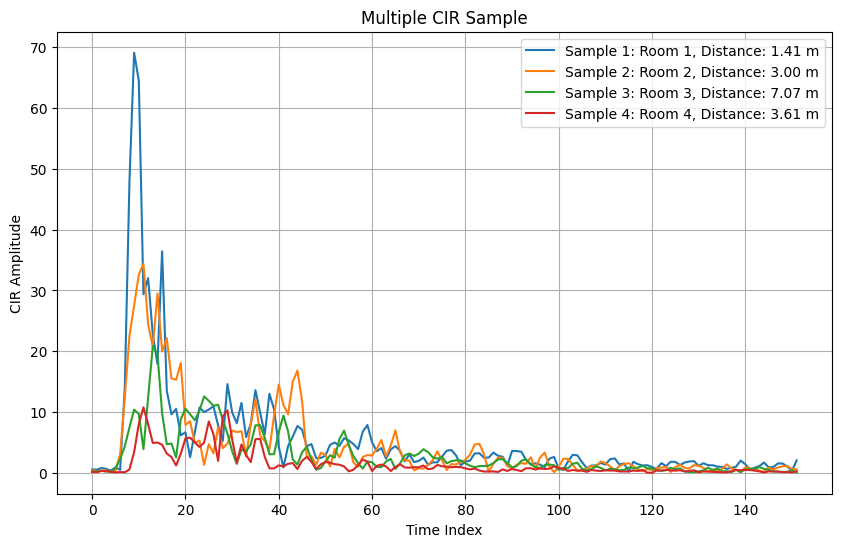

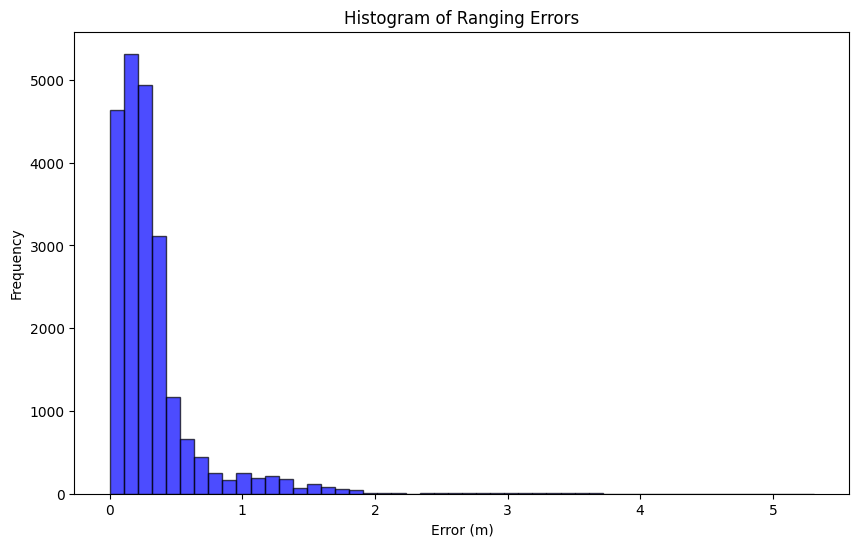

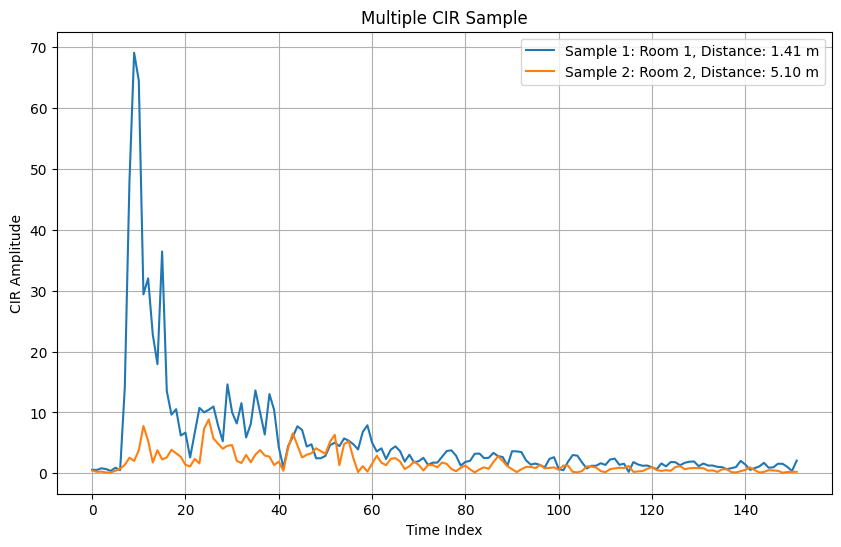

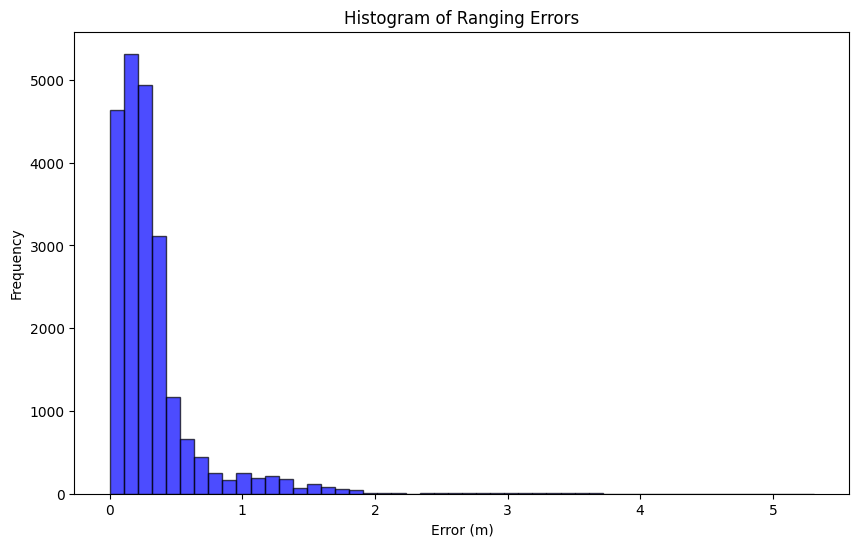

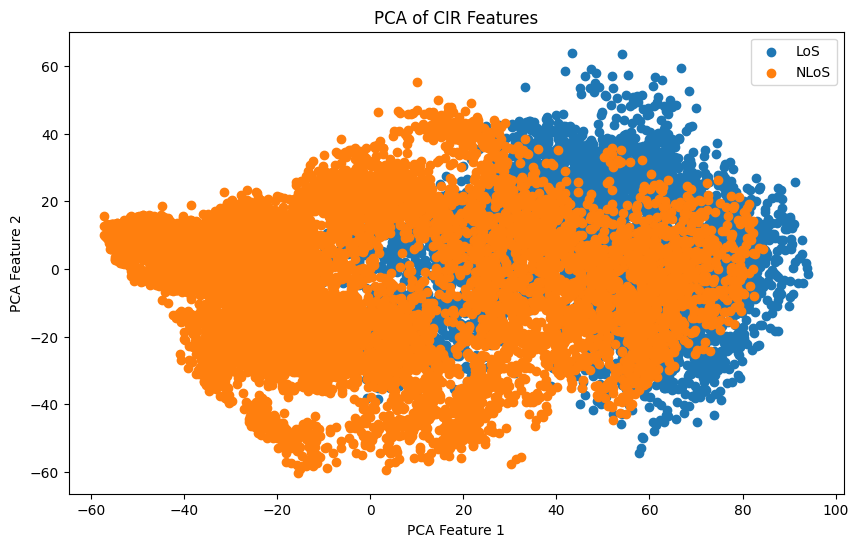

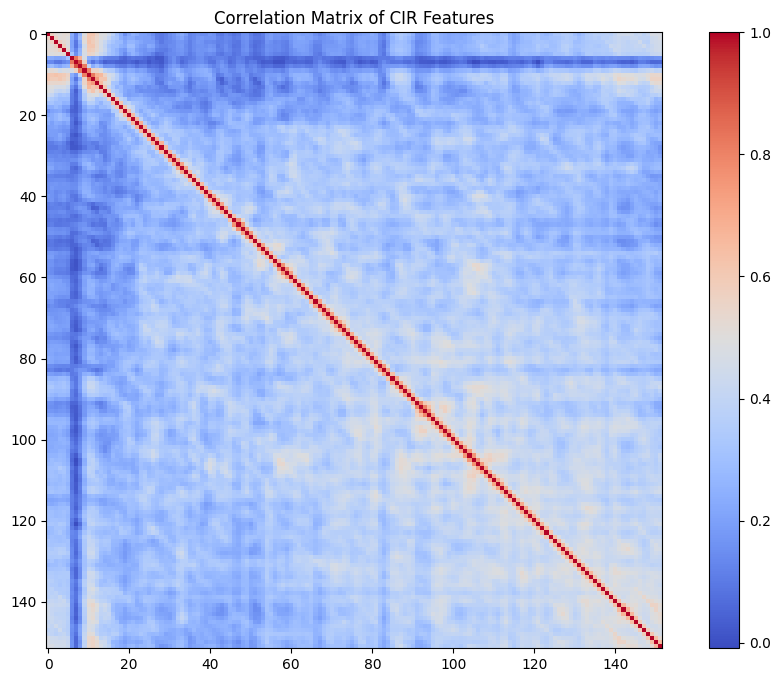

In [ ]:
# # Define dataset paths
# DATASET_1_PATH = '/content/drive/MyDrive/Data/data_ewine'
# DATASET_2_PATH = '/content/drive/MyDrive/Data/data_zenodo/dataset.pkl'

# # Load and preprocess data from db1
# def load_and_preprocess_data_db1(filepath):
#     data = pd.read_csv(filepath)
#     data['CIR'] = data.apply(lambda row: np.fromstring(row['CIR'][1:-1], sep=' '), axis=1)
#     return data[['CIR', 'Error', 'Label', 'MeasuredDistance', 'TrueDistance']]

# def load_data_zenodo(filepath, option='full'):
#     data = pd.read_pickle(filepath)
#     cir_arr = np.vstack(data['CIR'].values)
#     error_arr = data['Error'].values
#     label_arr = data['Obstacles'].values
#     room_arr = data['Room'].values
#     distGT_arr = data['Range'].values
#     return cir_arr, error_arr, label_arr, room_arr, distGT_arr

# Load data from db1
# folderpaths = [os.path.join(DATASET_1_PATH, 'dataset1/tag_room0.csv'), os.path.join(DATASET_1_PATH, 'dataset1/tag_room1.csv')]
# cir_reg, err_reg, label_reg, distM_reg, distGT_reg = [], [], [], [], []
# for path in folderpaths:
#     cir, err, label, distM, distGT = load_and_preprocess_data_db1(path)
#     cir_reg.append(cir)
#     err_reg.append(err)
#     label_reg.append(label)
#     distM_reg.append(distM)
#     distGT_reg.append(distGT)
# cir_reg = np.vstack(cir_reg)
# err_reg = np.concatenate(err_reg)
# label_reg = np.concatenate(label_reg)
# distM_reg = np.concatenate(distM_reg)
# distGT_reg = np.concatenate(distGT_reg)
cir_reg_1 = data_1['CIR'].values
err_reg_1 = data_1['Error'].values
label_reg_1 = data_1['Label'].values
lroom_reg_1 = data_1['RoomLabel'].values
distM_reg_1 = data_1['MeasuredDistance'].values
distGT_reg_1 = data_1['TrueDistance'].values

# Perform Observation Level Analysis
observation_level_analysis(cir_reg_1, err_reg_1, lroom_reg_1, distGT_reg_1, dataset_name='db1', option='full', level='room')
observation_level_analysis(cir_reg_1, err_reg_1, label_reg_1, distGT_reg_1, dataset_name='db1', option='full', level='obstacle')

# Perform Feature Level Analysis
feature_level_analysis(cir_reg_1, err_reg_1, lroom_reg_1, distGT_reg_1, dataset_name='db1', option='full', level='room')
feature_level_analysis(cir_reg_1, err_reg_1, label_reg_1, distGT_reg_1, dataset_name='db1', option='full', level='obstacle')


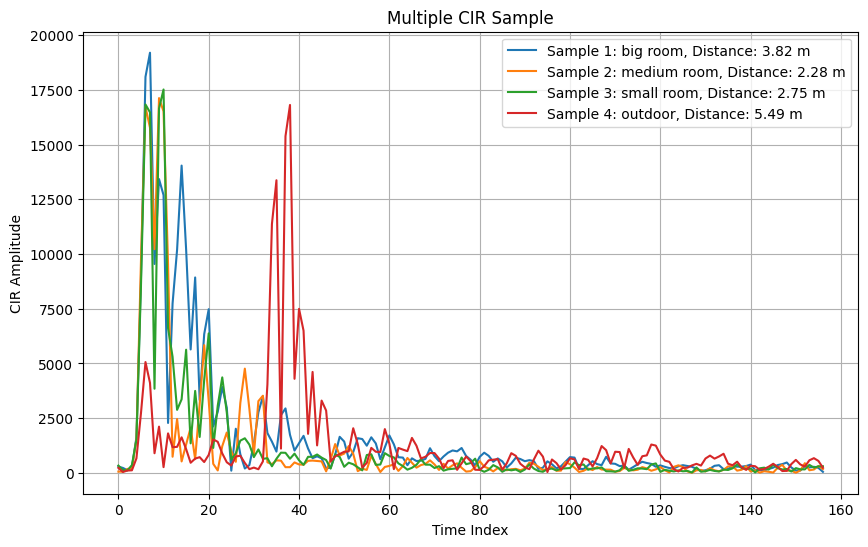

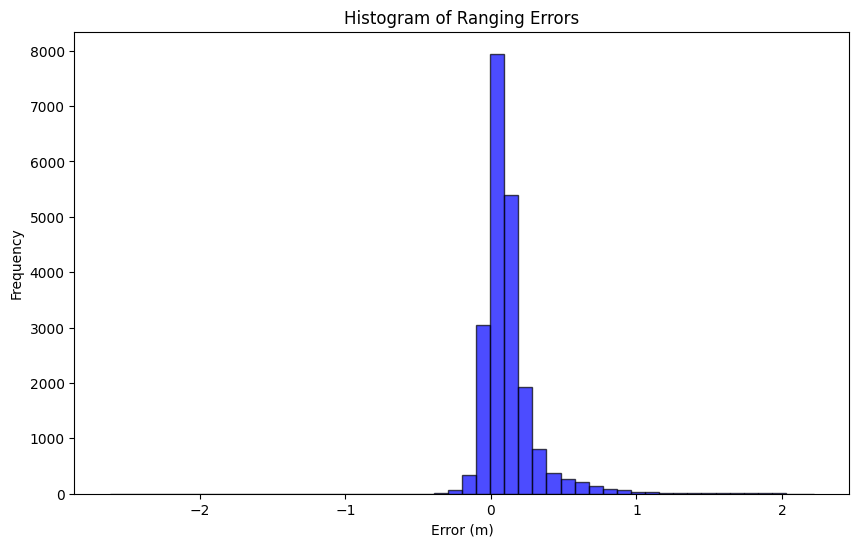

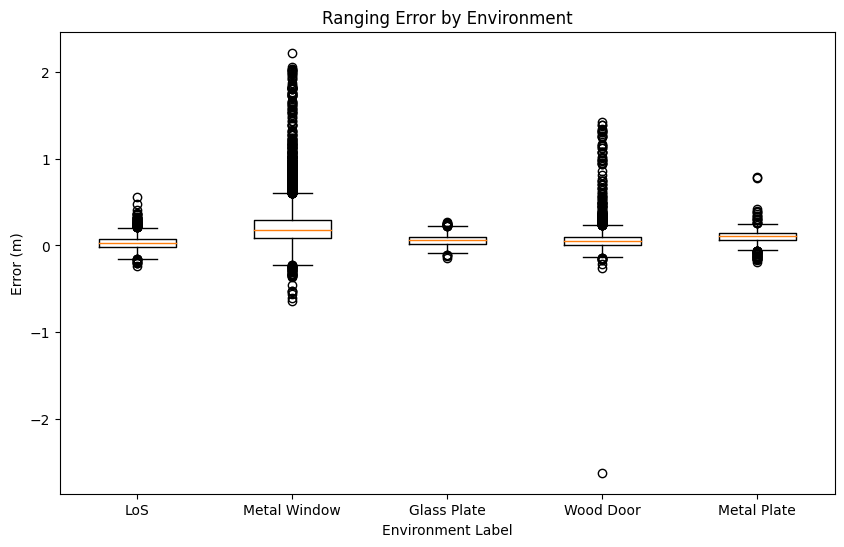

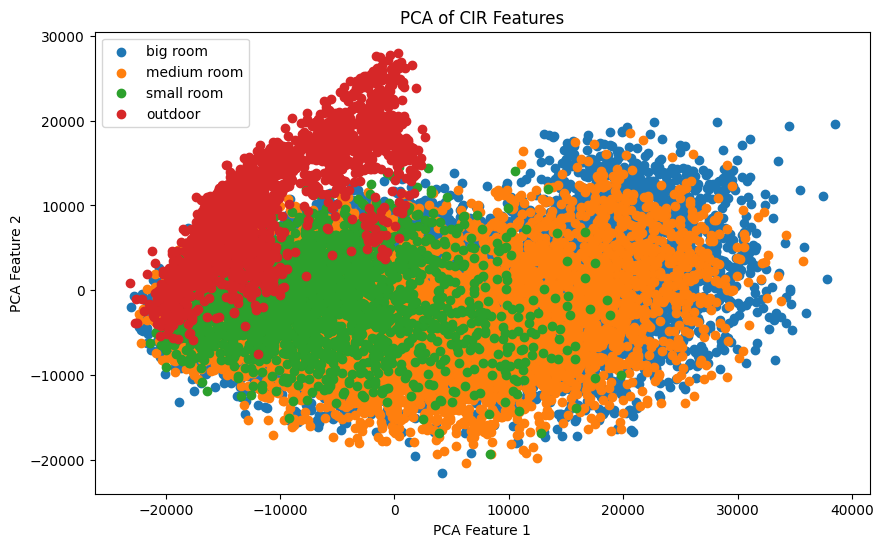

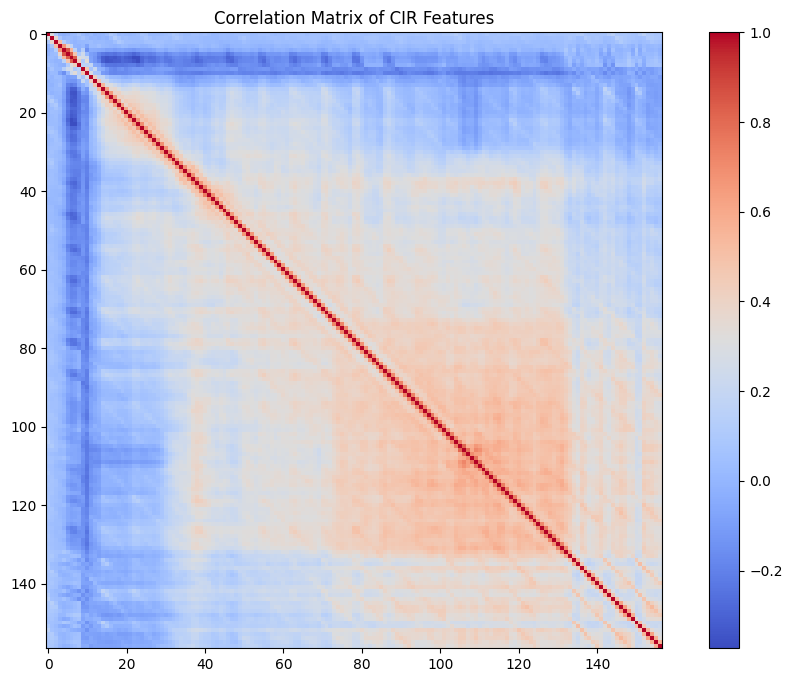

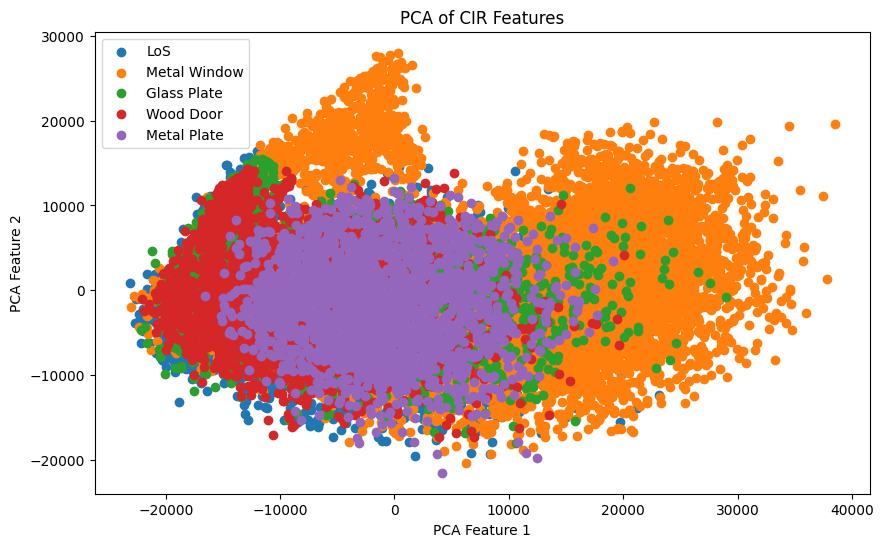

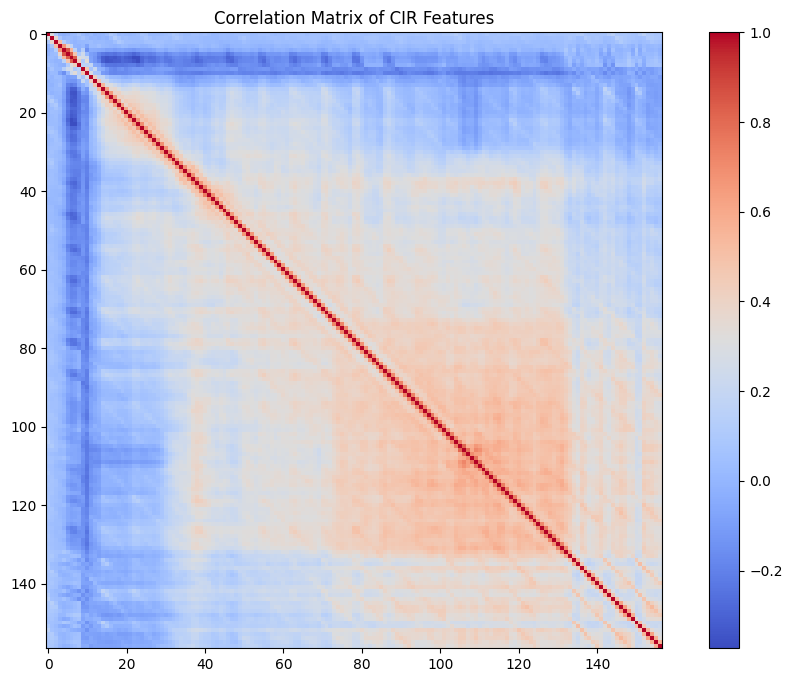

In [ ]:
# Load data from db2
# cir_reg, err_reg, label_reg, lroom_reg, distGT_reg = load_data_zenodo(DATASET_2_PATH, option='full')
data_2 = data_2_part
cir_reg_2 = data_2['CIR'].values  # data_2_part, data_2_rough
err_reg_2 = data_2['Error'].values
label_reg_2 = data_2['Label'].values
lroom_reg_2 = data_2['RoomLabel'].values
distM_reg_2 = data_2['MeasuredDistance'].values
distGT_reg_2 = data_2['TrueDistance'].values

# Perform Observation Level Analysis
observation_level_analysis(cir_reg_2, err_reg_2, lroom_reg_2, distGT_reg_2, 'db2', 'full', 'room')
observation_level_analysis(cir_reg_2, err_reg_2, label_reg_2, distGT_reg_2, 'db2', 'full', 'obstacle')

# Perform Feature Level Analysis
feature_level_analysis(cir_reg_2, err_reg_2, lroom_reg_2, distGT_reg_2, 'db2', 'full', 'room')
feature_level_analysis(cir_reg_2, err_reg_2, label_reg_2, distGT_reg_2, 'db2', 'full', 'obstacle')

#### **2.5.2 Extracted Features Analysis**

In [ ]:
def combined_analysis(cir_arr, error_arr, label_arr, distGT_arr, dataset_name='db2', option='full', level='room', save_path=None):

    observation_level_analysis(cir_arr, error_arr, label_arr, distGT_arr, dataset_name, option, level)
    feature_level_analysis(cir_arr, error_arr, label_arr, distGT_arr, dataset_name, option, level)

    if save_path is not None:
        plt.savefig(save_path)
        plt.close()


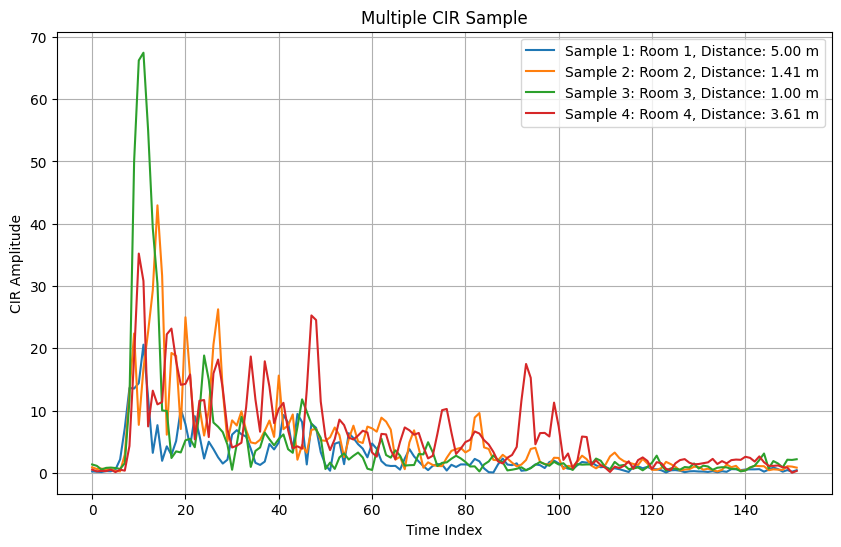

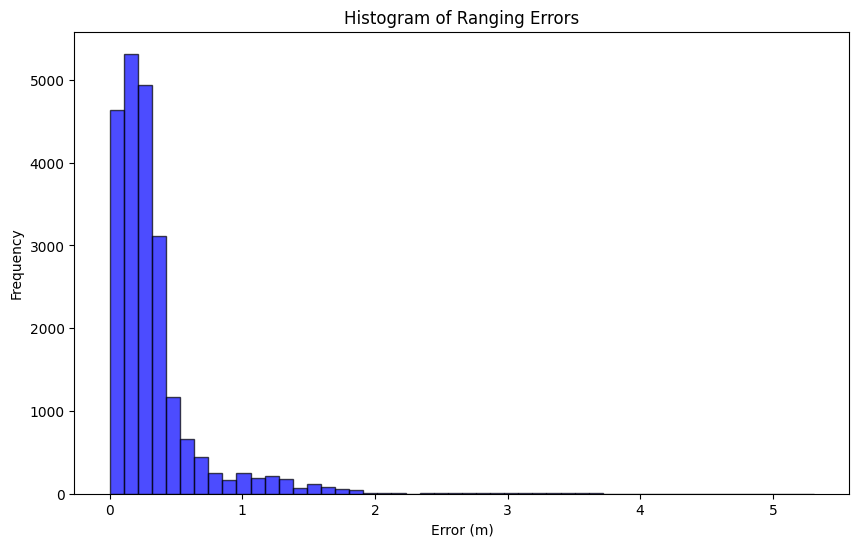

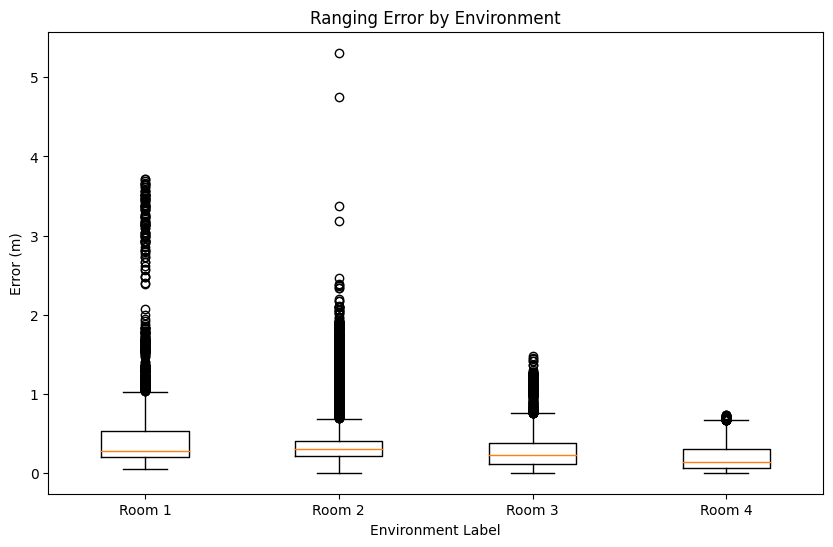

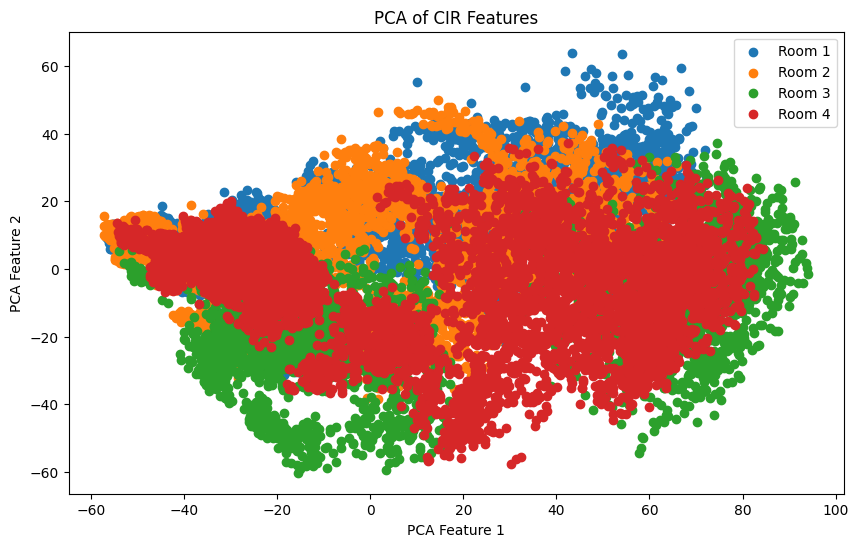

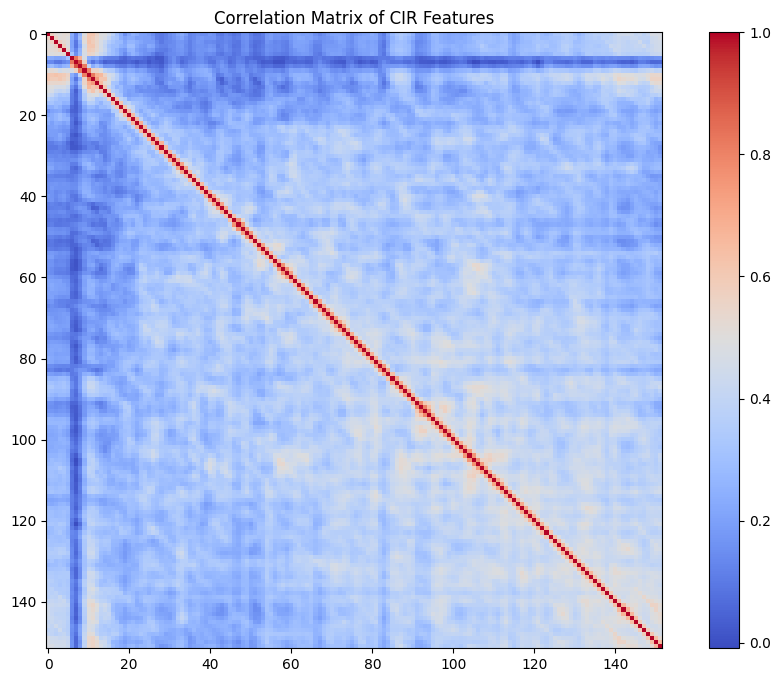

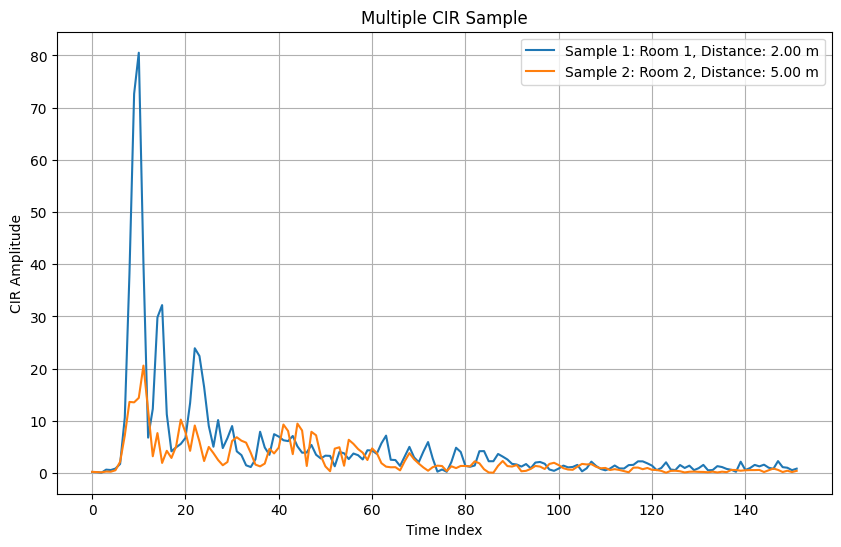

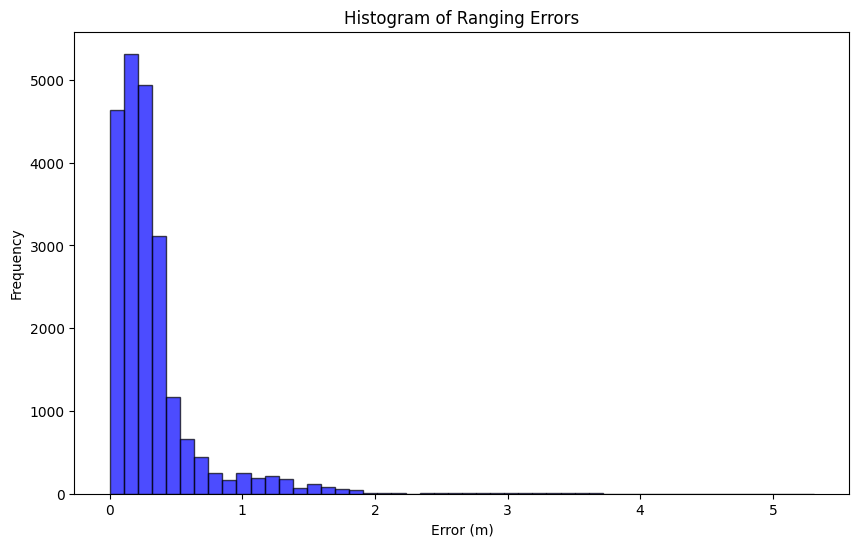

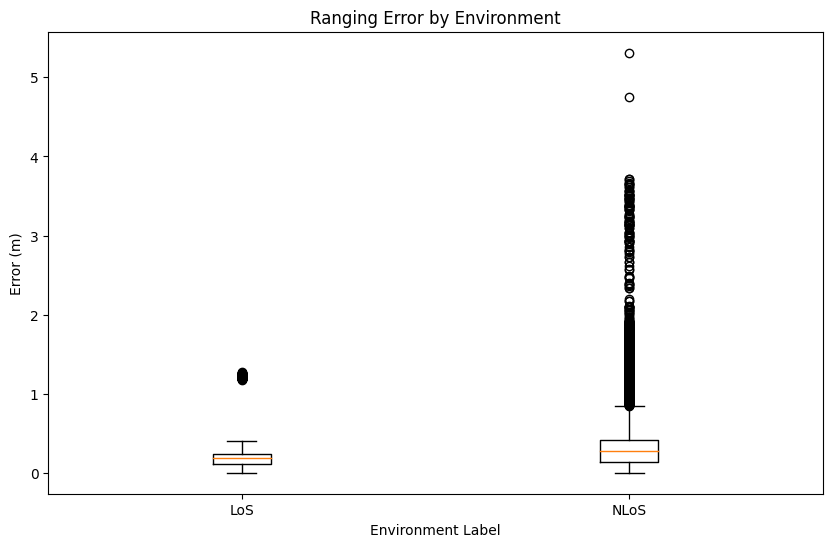

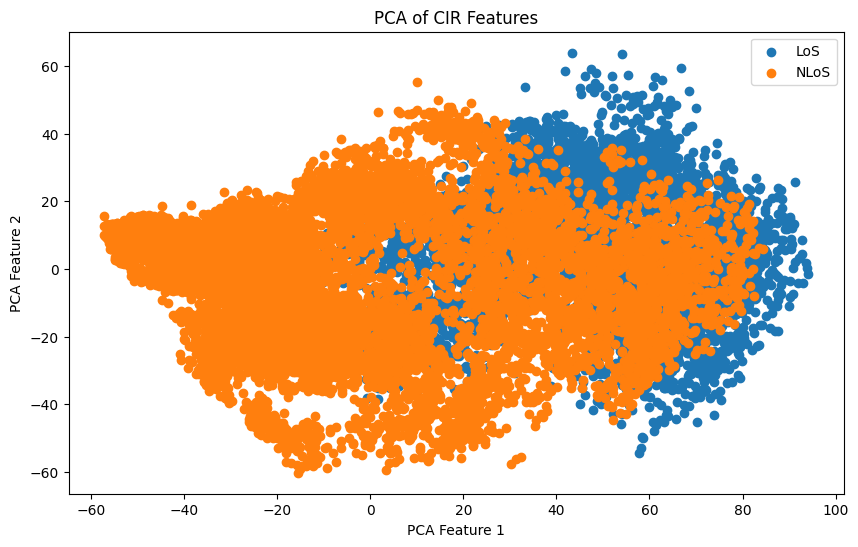

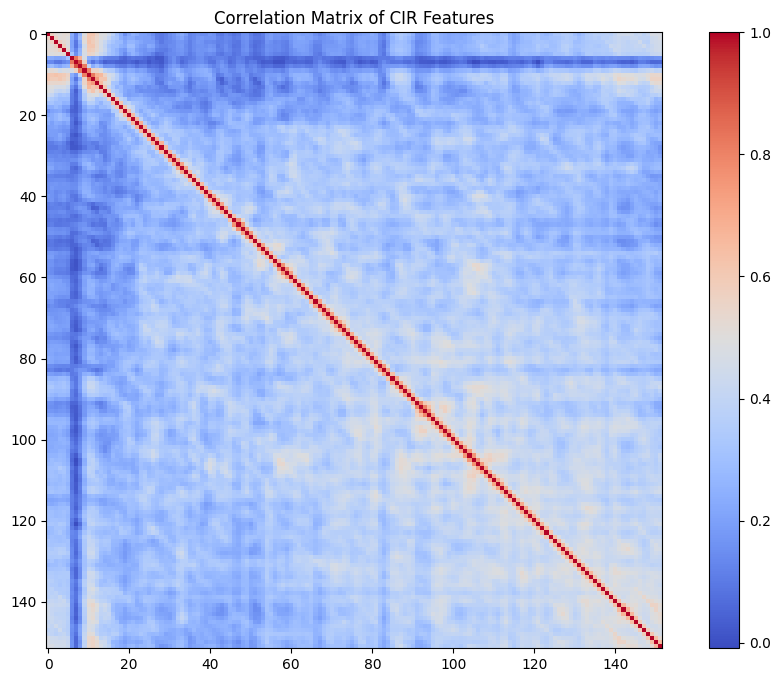

NameError: name 'cir_reg_2' is not defined

In [ ]:
# Perform Combined Analysis
combined_analysis(cir_reg_1, err_reg_1, lroom_reg_1, distGT_reg_1, 'db1', '', 'room')
combined_analysis(cir_reg_1, err_reg_1, label_reg_1, distGT_reg_1, 'db1', '', 'obstacle')

combined_analysis(cir_reg_2, err_reg_2, lroom_reg_2, distGT_reg_2, 'db2', 'full', 'room')
combined_analysis(cir_reg_2, err_reg_2, label_reg_2, distGT_reg_2, 'db2', 'full', 'obstacle')


## **3. Inference Baselines**

### **3.1 ML Classifiers**

In [25]:
def evaluate_ml_classifiers(X_cir, X_d, Y, extract_flag=True, extract_method='PF', extract_length=6):
    """
    Evaluates SVM, Random Forest, and MLP classifiers.
    """
    # Split data into training and testing sets
    # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train, X_test = X_cir
    dM_train, dM_test = X_d
    Y_train, Y_test = Y
    y_train = Y_train.reshape(-1)
    y_test = Y_test.reshape(-1)

    # Define classifiers
    classifiers = {
        'SVM': SVC(probability=True),
        'Random Forest': RandomForestClassifier(n_estimators=100),
        'MLP': MLPClassifier(hidden_layer_sizes=(100,), max_iter=500),
    }

    results = []

    for name, clf in classifiers.items():
        # Feature extraction if required
        extract_time = 0
        if extract_flag:
            print("Extracting features by %s..." % extract_method)
            X_train = features_extract(X_train, method=extract_method, length=extract_length)
            start_time = time.time()
            X_test = features_extract(X_test, method=extract_method, length=extract_length)
            extract_time = time.time() - start_time
            # print("Feature extraction time: %.2f s" % extract_time)

        # Append X with measured distance
        X_train = np.column_stack((X_train, dM_train))
        X_test = np.column_stack((X_test, dM_test))

        # Standardize features
        scaler = StandardScaler().fit(X_train)
        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)

        # Train the classifier
        clf.fit(X_train, y_train)

        # Predict on the test set
        start_time = time.time()
        y_pred = clf.predict(X_test)
        predict_time = (time.time() - start_time + extract_time) * 100 / X_test.shape[0]
        # print("Prediction time: %.2f s" % predict_time)

        # Evaluate metrics
        metrics = {
            'Method': name,
            'Accuracy': accuracy_score(y_test, y_pred),
            'Precision': precision_score(y_test, y_pred, average='weighted'),
            'Recall': recall_score(y_test, y_pred, average='weighted'),
            'F1 Score': f1_score(y_test, y_pred, average='weighted'),
            'Time': predict_time,
        }

        # Cross-validation for bounds estimation
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        cv_scores = cross_val_score(clf, X_train, y_train, cv=cv, scoring='accuracy')
        metrics['CV Mean'] = np.mean(cv_scores)
        metrics['CV Std'] = np.std(cv_scores)
        metrics['CV Lower Bound'] = np.mean(cv_scores) - np.std(cv_scores)
        metrics['CV Upper Bound'] = np.mean(cv_scores) + np.std(cv_scores)

        results.append(metrics)

    return pd.DataFrame(results)


### **3.2 MRC and CMRC Classifiers**

+ MRC supposes to be slower than CMRC.
+ For lower dimentional features, 'fourier' for parameter phi supposes to be better than 'linear' for phi. (Use `phi='fourier'` in Bottleneck integration.)
+ To have the upper and lower bound produced, '0-1' for loss param.

In [26]:
def evaluate_mrc_classifiers(X_cir, X_d, Y, loss_list=['0-1', 'log'], phi_list=['linear', 'fourier'], method_list=['MRC', 'CMRC'], nd_flag=True, extract_flag=True, extract_method='PF', extract_length=6):

    # Split data into training and testing sets
    # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train, X_test = X_cir
    dM_train, dM_test = X_d
    Y_train, Y_test = Y
    y_train = Y_train.reshape(-1)
    y_test = Y_test.reshape(-1)

    results = []
    results_nd = []

    for loss in loss_list:
        for phi in phi_list:
            for method in method_list:
                if method == 'MRC':
                    print("Running deterministic MRC with loss=%s and phi=%s" % (loss, phi))
                    clf = MRC(loss=loss, phi=phi)  # , random_state=0, sigma='scale', deterministic=True, use_cvx=True, solver='MOSEK'
                    # if loss == '0-1':
                    if nd_flag:
                        print("Running non-deterministic MRC with loss=0-1 and phi=%s (with upper and lower bounds)." % phi)
                        clf_nd = MRC(loss=loss, phi=phi)  # , random_state=0, sigma='scale', deterministic=False, use_cvx=True, solver='MOSEK'
                    else:
                        clf_nd = None
                elif method == 'CMRC':
                    print("Running deterministic CMRC with loss=%s and phi=%s" % (loss, phi))
                    clf = CMRC(loss=loss, phi=phi)  # , random_state=0, sigma='scale', solver='adam'
                    # if loss == '0-1':
                    if nd_flag:
                        print("Running non-deterministic CMRC with loss=0-1 and phi=%s (with upper and lower bounds)." % phi)
                        clf_nd = MRC(loss=loss, phi=phi)  # , random_state=0, sigma='scale', deterministic=False, use_cvx=True, solver='MOSEK'
                    else:
                        clf_nd = None
                else:
                    raise ValueError("Unknown method %s" % method)

                # Feature extraction if required
                extract_time = 0
                if extract_flag:
                    print("Extracting features by %s..." % extract_method)
                    X_train = features_extract(X_train, method=extract_method, length=extract_length)
                    start_time = time.time()
                    X_test = features_extract(X_test, method=extract_method, length=extract_length)
                    extract_time = time.time() - start_time
                    # print("Feature extraction time: %.2f s" % extract_time)

                # Append X with measured distance
                X_train = np.column_stack((X_train, dM_train))
                X_test = np.column_stack((X_test, dM_test))

                # Standardize features
                scaler = StandardScaler().fit(X_train)
                X_train = scaler.transform(X_train)
                X_test = scaler.transform(X_test)

                # Train the classifier
                clf.fit(X_train, y_train)

                # Predict on test set
                start_time = time.time()
                y_pred = clf.predict(X_test)
                predict_time = (time.time() - start_time + extract_time) * 100 / X_test.shape[0]
                # print("Prediction time: %.2f s" % predict_time)

                # Evaluate metrics
                metrics = {
                    'Method': method,
                    'Loss': loss,
                    'Phi': phi,
                    'Accuracy': accuracy_score(y_test, y_pred),
                    'Precision': precision_score(y_test, y_pred, average='weighted'),
                    'Recall': recall_score(y_test, y_pred, average='weighted'),
                    'F1 Score': f1_score(y_test, y_pred, average='weighted'),
                    'Time': predict_time,
                    'Type': 'deterministic'
                }

                # Cross-validation for bounds estimation
                cv = StratifiedKFold(n_splits=5)
                cv_scores = cross_val_score(clf, X_test, y_test, cv=cv, scoring='accuracy')
                metrics['CV Mean'] = np.mean(cv_scores)
                metrics['CV Std'] = np.std(cv_scores)
                metrics['CV Lower Bound'] = np.mean(cv_scores) - np.std(cv_scores)
                metrics['CV Upper Bound'] = np.mean(cv_scores) + np.std(cv_scores)

                results.append(metrics)

                # Add non-deterministic case
                if clf_nd is not None:
                    clf_nd.fit(X_train, y_train)
                    start_time = time.time()
                    y_pred_nd = clf_nd.predict(X_test)
                    predict_time_nd = (time.time() - start_time + extract_time) * 100 / X_test.shape[0]
                    # print("Prediction time: %.2f s" % predict_time_nd)
                    metrics_nd = {
                        'Method': method,
                        'Loss': loss,
                        'Phi': phi,
                        'Accuracy': accuracy_score(y_test, y_pred_nd),
                        'Precision': precision_score(y_test, y_pred_nd, average='weighted'),
                        'Recall': recall_score(y_test, y_pred_nd, average='weighted'),
                        'F1 Score': f1_score(y_test, y_pred_nd, average='weighted'),
                        'Time': predict_time_nd,
                        'Type': 'non-deterministic',
                        'MRC Upper Bound': clf_nd.get_upper_bound(),
                        'MRC Lower Bound': clf_nd.get_lower_bound()
                    }

                    cv_nd = StratifiedKFold(n_splits=5)
                    cv_scores_nd = cross_val_score(clf_nd, X_test, y_test, cv=cv_nd, scoring='accuracy')
                    metrics_nd['CV Mean'] = np.mean(cv_scores_nd)
                    metrics_nd['CV Std'] = np.std(cv_scores_nd)
                    metrics_nd['CV Lower Bound'] = np.mean(cv_scores_nd) - np.std(cv_scores_nd)
                    metrics_nd['CV Upper Bound'] = np.mean(cv_scores_nd) + np.std(cv_scores_nd)

                    results_nd.append(metrics_nd)

        return pd.DataFrame(results), pd.DataFrame(results_nd)

In [ ]:
# Assume that train_loader_1 and test_loader_1 are DataLoader objects
X_cir_train, X_d_train, Y_train = [], [], []
X_cir_test, X_d_test, Y_test = [], [], []

# Loop through the train_loader_1 to extract CIR data
for batch in train_loader_1:
    X_cir_train.extend(batch['CIR'].numpy())  # Convert to numpy and store
    X_d_train.extend(batch['MeasuredDistance'].numpy())
    Y_train.extend(batch['Label'].numpy())

# Loop through the test_loader_1 to extract CIR data
for batch in test_loader_1:
    X_cir_test.extend(batch['CIR'].numpy())  # Convert to numpy and store
    X_d_test.extend(batch['MeasuredDistance'].numpy())
    Y_test.extend(batch['Label'].numpy())

# Convert lists to numpy arrays if needed
X_cir_train = np.array(X_cir_train)
X_d_train = np.array(X_d_train)
Y_train = np.array(Y_train)
X_cir_test = np.array(X_cir_test)
X_d_test = np.array(X_d_test)
Y_test = np.array(Y_test)

# Now X_cir_train and X_cir_test contain the CIR data
print(X_cir_train.shape)
print(X_cir_test.shape)


(17628, 152)
(4407, 152)


In [ ]:
# Assign example data
X_cir = X_cir_train, X_cir_test
X_d = X_d_train, X_d_test
y = Y_train, Y_test

# ML Classifiers
df_mls = evaluate_ml_classifiers(
    X_cir, X_d, y, extract_flag=True, extract_method='PCA', extract_length=4
)


Extracting features by PCA...
Extracting features by PCA...
Extracting features by PCA...


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptro

In [ ]:
 # Print the results
print("Evaluation Results:")
print(df_mls)


Evaluation Results:
          Method  Accuracy  Precision    Recall  F1 Score      Time   CV Mean  \
0            SVM  0.814613   0.809939  0.814613  0.811798  0.015197  0.942365   
1  Random Forest  0.892898   0.899223  0.892898  0.894915  0.001148  0.992966   
2            MLP  0.837077   0.843286  0.837077  0.839541  0.000077  0.971352   

     CV Std  CV Lower Bound  CV Upper Bound  
0  0.004743        0.937622        0.947108  
1  0.001567        0.991399        0.994533  
2  0.000860        0.970493        0.972212  


In [ ]:
# MRC and CMRC classifiers
df_mrcs, df_mrcs_nd = evaluate_mrc_classifiers(
    X_cir, X_d, y, loss_list=['0-1', 'log'], phi_list=['linear', 'fourier'], method_list=['MRC'],
    nd_flag=True, extract_flag=True, extract_method='PCA', extract_length=4
)
df_cmrcs, df_cmrcs_nd = evaluate_mrc_classifiers(
    X_cir, X_d, y, loss_list=['0-1', 'log'], phi_list=['linear', 'fourier'], method_list=['CMRC'],
    nd_flag=True, extract_flag=True, extract_method='PCA', extract_length=4
)
print("MRC Results:")
print(df_mrcs, df_mrcs_nd)
print("CMRC Results:")
print(df_cmrcs, df_cmrcs_nd)

Running deterministic MRC with loss=0-1 and phi=linear
Running non-deterministic MRC with loss=0-1 and phi=linear (with upper and lower bounds).
Extracting features by PCA...
Running deterministic MRC with loss=0-1 and phi=fourier
Running non-deterministic MRC with loss=0-1 and phi=fourier (with upper and lower bounds).
Extracting features by PCA...
Running deterministic CMRC with loss=0-1 and phi=linear
Running non-deterministic CMRC with loss=0-1 and phi=linear (with upper and lower bounds).
Extracting features by PCA...
Running deterministic CMRC with loss=0-1 and phi=fourier
Running non-deterministic CMRC with loss=0-1 and phi=fourier (with upper and lower bounds).
Extracting features by PCA...
MRC Results:
  Method Loss      Phi  Accuracy  Precision    Recall  F1 Score      Time  \
0    MRC  0-1   linear  0.741774   0.550229  0.741774  0.631803  0.004104   
1    MRC  0-1  fourier  0.858407   0.853615  0.858407  0.851806  0.004382   

            Type   CV Mean    CV Std  CV Lower 

### **3.3 Classification Comparison Function**

In [27]:
def compare_clsbaselines(df_train, df_test, dataset_name, cls_type, epoch, extract_flag=True, extract_method='PF', extract_length=6, save_path=None):
    # Assume that train_loader_1 and test_loader_1 are DataLoader objects
    X_cir_train, X_d_train, Y_train = [], [], []
    X_cir_test, X_d_test, Y_test = [], [], []

    # Loop through the train_loader_1 to extract CIR data
    for batch in train_loader_1:
        X_cir_train.extend(batch['CIR'].numpy())  # Convert to numpy and store
        X_d_train.extend(batch['MeasuredDistance'].numpy())
        Y_train.extend(batch['Label'].numpy()) if cls_type == 'obstacle' else Y_train.extend(batch['RoomLabel'].numpy())

    # Loop through the test_loader_1 to extract CIR data
    for batch in test_loader_1:
        X_cir_test.extend(batch['CIR'].numpy())  # Convert to numpy and store
        X_d_test.extend(batch['MeasuredDistance'].numpy())
        Y_test.extend(batch['Label'].numpy())

    # Convert lists to numpy arrays if needed
    X_cir_train = np.array(X_cir_train)
    X_d_train = np.array(X_d_train)
    Y_train = np.array(Y_train)
    X_cir_test = np.array(X_cir_test)
    X_d_test = np.array(X_d_test)
    Y_test = np.array(Y_test)

    # Now X_cir_train and X_cir_test contain the CIR data
    print("Training data shape:", X_cir_train.shape)
    print("Testing data shape", X_cir_test.shape)

    X_cir = X_cir_train, X_cir_test
    X_d = X_d_train, X_d_test
    Y = Y_train, Y_test

    # Run classification comparison
    print("Environment Identification")
    df_ml = evaluate_ml_classifiers(X_cir, X_d, Y, extract_flag=extract_flag, extract_method=extract_method, extract_length=extract_length)
    df_mrc, df_mrc_nd = evaluate_mrc_classifiers(X_cir, X_d, Y, loss_list=['0-1', 'log'], phi_list=['linear', 'fourier'], method_list=['MRC'], nd_flag=True, extract_flag=extract_flag, extract_method=extract_method, extract_length=extract_length)
    df_cmrc, df_cmrc_nd = evaluate_mrc_classifiers(X_cir, X_d, Y, loss_list=['0-1', 'log'], phi_list=['linear', 'fourier'], method_list=['CMRC'], nd_flag=True, extract_flag=extract_flag, extract_method=extract_method, extract_length=extract_length)

    # Save results
    if save_path is not None:
        os.makedirs(save_path, exist_ok=True)
        df_ml.to_csv(os.path.join(save_path, f'ml_results_{cls_type}-{epoch}_{extract_method}_{extract_length}.csv'), index=False)
        df_mrc.to_csv(os.path.join(save_path, f'mrc_results_{cls_type}-{epoch}_{extract_method}_{extract_length}.csv'), index=False)
        df_mrc_nd.to_csv(os.path.join(save_path, f'mrc_nd_results_{cls_type}-{epoch}_{extract_method}_{extract_length}.csv'), index=False)

    return df_ml, df_mrc, df_mrc_nd, df_cmrc, df_cmrc_nd

In [ ]:
# classification comparison 1 - room
baseline_results_path = '/content/drive/MyDrive/Data/results/baselines/'
dataset_name = 'db1'
cls_type = 'room'
epoch = 0
extract_flag = True
extract_method = 'MPF'
dl_mls, df_mrcs, df_mrcs_nd, df_cmrcs, df_cmrcs_nd = compare_clsbaselines(
    train_loader_1, test_loader_1, dataset_name, cls_type, epoch,
    extract_flag, extract_method, extract_length=8,
    save_path=baseline_results_path,
)

Training data shape: (17628, 152)
Testing data shape (4407, 152)
Environment Identification
Extracting features by MPF...


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Extracting features by MPF...


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Extracting features by MPF...


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3

TypeError: evaluate_mrc_classifiers() missing 1 required positional argument: 'Y'

In [ ]:
extract_method = 'PF'
dl_mls, df_mrcs, df_mrcs_nd, df_cmrcs, df_cmrcs_nd = compare_clsbaselines(
    train_loader_1, test_loader_1, dataset_name, cls_type, epoch,
    extract_flag, extract_method, extract_length=8,
    save_path=baseline_results_path,
)

Training data shape: (17628, 152)
Testing data shape (4407, 152)
Environment Identification
Extracting features by PF...


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Extracting features by PF...


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Extracting features by PF...


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3

Running deterministic MRC with loss=0-1 and phi=linear
Running non-deterministic MRC with loss=0-1 and phi=linear (with upper and lower bounds).
Extracting features by PF...
Running deterministic MRC with loss=0-1 and phi=fourier
Running non-deterministic MRC with loss=0-1 and phi=fourier (with upper and lower bounds).
Extracting features by PF...


In [ ]:
# classification comparison 1 - obstacle
baseline_results_path = '/content/drive/MyDrive/Data/results/baselines/'
dataset_name = 'db1'
cls_type = 'obstacle'
epoch = 0
extract_flag = True
extract_method = 'MPF'
dl_mls, df_mrcs, df_mrcs_nd, df_cmrcs, df_cmrcs_nd = compare_clsbaselines(
    train_loader_1, test_loader_1, dataset_name, cls_type, epoch,
    extract_flag, extract_method, extract_length=8,
    save_path=baseline_results_path,
)

In [ ]:
extract_method = 'PF'
dl_mls, df_mrcs, df_mrcs_nd, df_cmrcs, df_cmrcs_nd = compare_clsbaselines(
    train_loader_1, test_loader_1, dataset_name, cls_type, epoch,
    extract_flag, extract_method, extract_length=8,
    save_path=baseline_results_path,
)

In [ ]:
# classification comparison 2 - room
baseline_results_path = '/content/drive/MyDrive/Data/results/baselines/'
dataset_name = 'db2'
cls_type = 'room'
epoch = 0
extract_flag = True
extract_method = 'MPF'
dl_mls, df_mrcs, df_mrcs_nd, df_cmrcs, df_cmrcs_nd = compare_clsbaselines(
    train_loader_1, test_loader_1, dataset_name, cls_type, epoch,
    extract_flag, extract_method, extract_length=8,
    save_path=baseline_results_path,
)

In [ ]:
extract_method = 'PF'
dl_mls, df_mrcs, df_mrcs_nd, df_cmrcs, df_cmrcs_nd = compare_clsbaselines(
    train_loader_1, test_loader_1, dataset_name, cls_type, epoch,
    extract_flag, extract_method, extract_length=8,
    save_path=baseline_results_path,
)

In [ ]:
# classification comparison 2 - obstacle
baseline_results_path = '/content/drive/MyDrive/Data/results/baselines/'
dataset_name = 'db2'
cls_type = 'obstacle'
epoch = 0
extract_flag = True
extract_method = 'MPF'
dl_mls, df_mrcs, df_mrcs_nd, df_cmrcs, df_cmrcs_nd = compare_clsbaselines(
    train_loader_1, test_loader_1, dataset_name, cls_type, epoch,
    extract_flag, extract_method, extract_length=8,
    save_path=baseline_results_path,
)

In [ ]:
extract_method = 'PF'
dl_mls, df_mrcs, df_mrcs_nd, df_cmrcs, df_cmrcs_nd = compare_clsbaselines(
    train_loader_1, test_loader_1, dataset_name, cls_type, epoch,
    extract_flag, extract_method, extract_length=8,
    save_path=baseline_results_path,
)

## **4. Model Integration of MRC Variants (IIns-VAE, IIns-MRCs, IIns-CMRCs**)

### **4.1 Modules and IIns-VAE Base**

**IIns-VAE Base Model**: This is the base model which includes an encoder, decoder, regressor, and classifier. This structure allows for modular modifications.

#### Modules

In [28]:
def weights_init_normal(m):
    if isinstance(m, nn.Conv1d) or isinstance(m, nn.Conv2d):
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif isinstance(m, nn.BatchNorm1d) or isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)


class LambdaLR:
    def __init__(self, n_epochs, offset, decay_start_epoch):
        assert (n_epochs - decay_start_epoch) > 0, "Decay must start before training starts!"
        self.n_epochs = n_epochs
        self.offset = offset
        self.decay_start_epoch = decay_start_epoch

    def step(self, epoch):
        return 1.0 - max(0, epoch + self.offset - self.decay_start_epoch) / (self.n_epochs - self.decay_start_epoch)

def pad_layer(inp, layer, pad_type='reflect'):
    # inp = (2, 128, 1), layer = Conv1d(128, 32, k=1, s=1)
    kernel_size = layer.kernel_size[0]
    if kernel_size % 2 == 0:
        pad = (kernel_size // 2, kernel_size // 2 - 1)
    else:
        pad = (kernel_size // 2, kernel_size // 2)
    # print("---- test pad layer k and p ----", kernel_size, pad)
    # conv_bank: 1, (0, 0); 2 (1, 0); ...; 8, (4, 3)
    # conv_block: 5, (2, 2)
    inp = F.pad(inp, pad=pad, mode=pad_type)
    # print("-- test pad --", inp.shape, layer)
    # conv_bank: (2, 32, 8) ... (2, 128, 15)
    # conv_block: (2, 32, 8)
    out = layer(inp)
    # print("-- test pad out --", out.shape)
    # conv_bank: always (2, 32, 8)
    # conv_block: (2, 32, 8)
    return out


def conv_bank(x, module_list, pad_type='reflect'):
    outs = []
    for layer in module_list:
        # print("---- test conv bank ----", x.shape, layer)
        act = nn.ReLU()
        out = act(pad_layer(x, layer, pad_type))
        # print("---- test conv bank out ----", out.shape)  # (2, 32, 152)
        outs.append(out)
    out = torch.cat(outs + [x], dim=1)
    # print("---- test conv bank final ----", out.shape)  # (2, 384, 152)
    return out


def append_cond(x, cond):
    p = cond.size(1) // 2
    mean, std = cond[:, :p], cond[:, p:]
    out = x * std.unsqueeze(dim=2) + mean.unsqueeze(dim=2)
    return out


def pixel_shuffle_1d(inp, scale_factor=2):
    batch_size, channels, in_width = inp.size()
    channels //= scale_factor
    out_width = in_width * scale_factor
    inp_view = inp.contiguous().view(batch_size, channels, scale_factor, in_width)
    shuffle_out = inp_view.permute(0, 1, 3, 2).contiguous()
    shuffle_out = shuffle_out.view(batch_size, channels, out_width)
    return shuffle_out


def upsample(x, scale_factor=2):
    x_up = F.interpolate(x, scale_factor=scale_factor, mode='nearest')
    return x_up


class LayerNorm(nn.Module):
    def __init__(self, num_features, eps=1e-5, affine=True):
        super(LayerNorm, self).__init__()
        self.num_features = num_features
        self.affine = affine
        self.eps = eps

        if self.affine:
            self.gamma = nn.Parameter(torch.Tensor(num_features).uniform_())
            self.beta = nn.Parameter(torch.zeros(num_features))

    def forward(self, x):
        shape = [-1] + [1] * (x.dim() - 1)
        mean = x.view(x.size(0), -1).mean(1).view(*shape)
        std = x.view(x.size(0), -1).std(1).view(*shape)
        x = (x - mean) / (std + self.eps)

        if self.affine:
            shape = [1, -1] + [1] * (x.dim() - 2)
            x = x * self.gamma.view(*shape) + self.beta.view(*shape)
        return x


class MLP(nn.Module):
    """Predicts AdaIN parameters."""
    def __init__(self, input_dim, output_dim, dim=256, n_blk=3, activ="relu"):
        super(MLP, self).__init__()
        layers = [nn.Linear(input_dim, dim), nn.ReLU(inplace=True)]
        for _ in range(n_blk - 2):
            layers += [nn.Linear(dim, dim), nn.ReLU(inplace=True)]
        layers += [nn.Linear(dim, output_dim)]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        out = self.model(x)  # (B, input_dim) -> (B, output_dim)
        return out


class ResidualBlock1d(nn.Module):
    def __init__(self, features, norm="in"):
        super(ResidualBlock1d, self).__init__()

        norm_layer = AdaptiveInstanceNorm1d if norm == "adain" else nn.InstanceNorm1d

        self.block = nn.Sequential(
            nn.ReflectionPad1d(1),
            nn.Conv1d(features, features, 3),
            norm_layer(features),
            nn.ReLU(inplace=True),
            nn.ReflectionPad1d(1),
            nn.Conv1d(features, features, 3),
            norm_layer(features),
        )

    def forward(self, x):
        return x + self.block(x)


class ResidualBlock2d(nn.Module):
    def __init__(self, features, norm="in"):
        super(ResidualBlock2d, self).__init__()

        norm_layer = AdaptiveInstanceNorm2d if norm == "adain" else nn.InstanceNorm2d

        self.block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(features, features, 3),
            norm_layer(features),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(features, features, 3),
            norm_layer(features),
        )

    def forward(self, x):
        return x + self.block(x)


class AdaptiveInstanceNorm1d(nn.Module):
    def __init__(self, num_features, eps=1e-5, momentum=0.1):
        super(AdaptiveInstanceNorm1d, self).__init__()
        self.num_features = num_features
        self.eps = eps
        self.momentum = momentum
        # weight and bias are dynamically assigned
        self.weight = None
        self.bias = None
        # just dummy buffers, not used
        self.register_buffer("running_mean", torch.zeros(num_features))
        self.register_buffer("running_var", torch.ones(num_features))

    def forward(self, x):
        assert (
            self.weight is not None and self.bias is not None
        ), "Please assign weight and bias before calling AdaIN!"
        b, c, w = x.size()
        running_mean = self.running_mean.repeat(b)
        running_var = self.running_var.repeat(b)

        # Apply instance norm
        x_reshaped = x.contiguous().view(1, b * c, w)

        out = F.batch_norm(
            x_reshaped, running_mean, running_var, self.weight, self.bias,
            True, self.momentum, self.eps
        )
        return out.view(b, c, w)

    def __repr__(self):
        return self.__class__.__name__ + "(" + str(self.num_features) + ")"


class AdaptiveInstanceNorm2d(nn.Module):
    """Reference: https://github.com/NVlabs/MUNIT/blob/master/networks.py"""
    def __init__(self, num_features, eps=1e-5, momentum=0.1):
        super(AdaptiveInstanceNorm2d, self).__init__()
        self.num_features = num_features
        self.eps = eps
        self.momentum = momentum
        # weight and bias are dynamically assigned
        self.weight = None
        self.bias = None
        # just dummy buffers, not used
        self.register_buffer("running_mean", torch.zeros(num_features))
        self.register_buffer("running_var", torch.ones(num_features))

    def forward(self, x):
        assert (
            self.weight is not None and self.bias is not None
        ), "Please assign weight and bias before calling  AdaIN!"
        b, c, h, w = x.size()
        running_mean = self.running_mean.repeat(b)
        running_var = self.running_var.repeat(b)

        # Apply instance norm
        x_reshaped = x.contiguous().view(1, b * c, h, w)

        out = F.batch_norm(
            x_reshaped, running_mean, running_var, self.weight, self.bias,
            True, self.momentum, self.eps
        )
        return out.view(b, c, h, w)

    def __repr__(self):
        return self.__class__.__name__ + "(" + str(self.num_features) + ")"


In [29]:
# --------------------------------------------
#   Content Encoders (cir, dM -> range_code)
# --------------------------------------------

class RangeEncoder2d(nn.Module):
    def __init__(self, filters=4, n_residual=3, n_downsample=4, range_dim=16, input_dim=152):
        super(RangeEncoder2d, self).__init__()

        self.filters = filters

        # Initialize input to 64 dim (1, 152, 152) -> (1, 64, 64)
        self.init_layers = nn.Sequential(
            nn.Linear(input_dim * input_dim, 64 * 64),
            nn.ReLU(inplace=True)
        )

        # Convolution block (1+1, 64, 64) -> (4, 64, 64)
        layers = []
        layers += [
            nn.ReflectionPad2d(3),  # (2, 70, 70)
            nn.Conv2d(2, filters, 7),  # (4, 64, 64)
            nn.InstanceNorm2d(filters),
            nn.ReLU(inplace=True)
        ]

        # Downsampling x 4, (4, 64, 64) -> (64, 4, 4)
        for _ in range(n_downsample):
            layers += [
                nn.Conv2d(filters, filters * 2, 4, stride=2, padding=1),
                nn.InstanceNorm2d(filters * 2),
                nn.ReLU(inplace=True)
            ]
            filters *= 2
        self.res_dim = 64 // (2 ** n_downsample)  # 4
        self.res_chl = self.filters * (2 ** n_downsample)  # 64

        # Residual blocks
        for _ in range(n_residual):
            layers += [ResidualBlock2d(filters, norm="in")]

        # Output layer, (64+1, 4, 4) -> (range_dim,)
        layers_out = [
            nn.Linear((filters+1) * self.res_dim * self.res_dim, range_dim),
            nn.ReLU()
        ]  # filters = self.res_dim

        self.model = nn.Sequential(*layers)
        self.model_out = nn.Sequential(*layers_out)

    def forward(self, x, d):
        x = x.unsqueeze(2)
        x_init = x.repeat(1, 1, x.size(1))  # (B, 152, 152)
        # print("CIR input from encoder:", x_init.shape)
        x_init_flat = x_init.view(x.size(0), -1)  # (B, 152*152)
        # print("CIR input flat from encoder:", x_init_flat.shape)
        x_init = self.init_layers(x_init_flat)  # (B, 64*64)
        x_init = x_init.view(x_init.size(0), 1, 64, 64)
        d = d.view(d.size(0), 1, 1, 1)
        d_init = d.repeat(1, 1, x_init.size(2), x_init.size(3))  # (B, 1, 64, 64)
        x_cat = torch.cat((x_init, d_init), 1)  # (B, 2, 64, 64)
        out = self.model(x_cat)  # (B, 64, 4, 4)
        d_out = d.repeat(1, 1, out.size(2), out.size(3))  # (B, 1, 4, 4)
        x_cat = torch.cat((out, d_out), 1)  # (B, 65, 4, 4)
        out = self.model_out(x_cat.view(x_cat.size(0), -1))  # (B, range_dim)
        return out


# -------------------------------------------------------
#   Style Encoders (cir, dM -> env_code (cat), kl_div)
# -------------------------------------------------------

class EnvEncoder2d(nn.Module):
    def __init__(self, filters=16, n_downsample=2, env_dim=8, input_dim=152, split_flag=0):
        super(EnvEncoder2d, self).__init__()

        self.filters = filters
        self.split_flag = split_flag

        # Initialize input to 64 dim, (1, 152*152) -> (1, 64*64)
        self.init_layers = nn.Sequential(
            nn.Linear(input_dim**2, 64**2),
            nn.ReLU(inplace=True)
        )

        # Convolution block (1+1, 64, 64) -> (16, 64, 64)
        layers = []
        layers += [
            nn.ReflectionPad2d(3),  # (2, 70, 70)
            nn.Conv2d(2, filters, 7),  # (16, 64, 64)
            nn.ReLU(inplace=True)
        ]

        # Downsampling x 2, (16, 64, 64) -> (32, 32, 32) -> (64, 16, 16)
        for _ in range(2):
            layers += [
                nn.Conv2d(filters, filters * 2, 4, stride=2, padding=1),
                nn.ReLU(inplace=True)
            ]
            filters *= 2

        # Downsampling with constant depth, (64, 16, 16) -> (64, 8, 8) -> (64, 4, 4)
        for _ in range(n_downsample):
            layers += [
                nn.Conv2d(filters, filters, 4, stride=2, padding=1),
                nn.ReLU(inplace=True)
            ]

        # Average pool and output layer, (64+1, 4, 4) -> (65, 1, 1) -> (8*2, 1, 1)
        layers_out = [
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(filters+1, env_dim, 1, 1, 0)  # env_dim * 2
        ]  # filters = self.res_chl

        self.model = nn.Sequential(*layers)
        self.model_out = nn.Sequential(*layers_out)

    def forward(self, x, d):
        x = x.unsqueeze(2)
        x_init = x.repeat(1, 1, x.size(1))  # (B, 152, 152)
        x_init = self.init_layers(x_init.view(x_init.size(0), -1))  # (B, 64*64)
        x_init = x_init.view(x_init.size(0), 1, 64, 64)
        d = d.view(d.size(0), 1, 1, 1)
        d_init = d.repeat(1, 1, x_init.size(2), x_init.size(3))  # (B, 1, 64, 64)
        x_cat = torch.cat((x_init, d_init), 1)  # (B, 2, 64, 64)
        out = self.model(x_cat)  # (b, 65, 4, 4)
        d_out = d.repeat(1, 1, out.size(2), out.size(3))  # (B, 1, 4, 4)
        x_cat = torch.cat((out, d_out), 1)  # (b, 65, 4, 4)
        out = self.model_out(x_cat).squeeze()  # (B, env_dim)

        if self.split_flag == 0:
            latent_dim = out.shape[1] // 2
            mu, log_sigma = torch.split(out, latent_dim, dim=1)
            noise = torch.randn_like(mu)
            env_code = noise * log_sigma.exp() + mu  # (B, env_dim)
            kl_div = self._loss(mu, log_sigma)
        else:
            code_dim = out.shapep[1] // 2
            out_1, out_2 = torch.split(out, code_dim, dim=1)
            mu_1, mu_2 = torch.split(out_1, code_dim // 2, dim=1)
            log_sigma_1, log_sigma_2 = torch.split(out_2, code_dim // 2, dim=1)
            env_code_1 = torch.randn_like(mu_1) * log_sigma_1.exp() + mu_1
            env_code_2 = torch.randn_like(mu_2) * log_sigma_2.exp() + mu_2
            kl_div = self._loss(mu_1, log_sigma_1) + self._loss(mu_2, log_sigma_2)

        return out, kl_div  # env_dim


    def _loss(self, mu, log_sigma):
        kl_div = 0.5 * torch.sum((2 * log_sigma).exp() + mu ** 2 - 1 - 2 * log_sigma, dim=1)
        kl_div = kl_div.mean()  # account for batch size

        return kl_div


# -----------------------------------------------
#  Decoders (range_code, env_code (cat) -> cir)
# -----------------------------------------------

class Decoder2d(nn.Module):
    def __init__(self, filters=4, n_residual=3, n_upsample=4, range_dim=16, env_dim=16, out_dim=152, split_flag=0):
        super(Decoder2d, self).__init__()

        self.split_factor = split_flag

        # Initialize input (B, range_dim) -> (B, 64*4*4)
        self.res_dim = 64 // (2 ** n_upsample)  # 4
        filters = filters * (2 ** n_upsample)  # 64
        self.res_chl = filters
        self.init_layers = nn.Sequential(
            nn.Linear(range_dim, filters * self.res_dim * self.res_dim)
        )

        # Residual block (B, 64, 4, 4)
        layers = []
        for _ in range(n_residual):
            layers += [ResidualBlock2d(filters, norm="adain")]

        # Upsampling x 4, (64, 4, 4) -> (32, 8, 8) -> (16, 16, 16) -> (8, 32, 32) -> (4, 64, 64)
        for _ in range(n_upsample):
            layers += [
                nn.Upsample(scale_factor=2),
                nn.Conv2d(filters, filters // 2, 5, stride=1, padding=2),
                LayerNorm(filters // 2),
                nn.ReLU(inplace=True)
            ]
            filters = filters // 2

        # Output layer, (4, 64, 64) -> (1, 64, 64)
        layers += [
            nn.ReflectionPad2d(3),
            nn.Conv2d(filters, 1, 7),
            nn.ReLU()
        ]

        self.model = nn.Sequential(*layers)
        self.out_layers = nn.Sequential(
            nn.Linear(64*64, out_dim),
            nn.Tanh()
        )

        # Initialize mlp (predict AdaIN parameters)
        num_adain_params = self.get_num_adain_params()
        self.mlp = MLP(env_dim, num_adain_params)

    def get_num_adain_params(self):
        """Return the number of AdaIN params needed by the model."""
        num_adain_params = 0
        for m in self.modules():
            if m.__class__.__name__ == "AdaptiveInstanceNorm2d":
                num_adain_params += 2 * m.num_features
        return num_adain_params  # 2 * m.num_features * N (AdaIN layer num)

    def assign_adain_params(self, adain_params):
        """Assign the adain_params to the AdaIN layers in model."""
        for m in self.modules():
            if m.__class__.__name__ == "AdaptiveInstanceNorm2d":
                # Extract mean and std predictions
                mean = adain_params[:, : m.num_features]
                std = adain_params[:, m.num_features: 2 * m.num_features]
                # Update bias and weight
                m.bias = mean.contiguous().view(-1)
                m.weight = std.contiguous().view(-1)
                # Move pointer
                if adain_params.size(1) > 2 * m.num_features:
                    adain_params = adain_params[:, 2 * m.num_features:]

    def forward(self, range_code, env_code):

        disentangled_code = self.mlp(env_code)  # (B, env_dim) -> (B, num_adain_params)
        # num_adain_params = 2 * m.num_features * N (N is the num of the AdaIN layers)
        # current operation already assign z to W + As
        # (could use explicit separate assignment for splitting, or DecoderRes already does)
        self.assign_adain_params(disentangled_code)
        # combine range_code in for the final output
        range_code = self.init_layers(range_code)
        range_code = range_code.view(range_code.size(0), self.res_chl, self.res_dim, self.res_dim)  # (B, 64, 4, 4)
        out = self.model(range_code)  # (B, 1, 64, 64)
        out = self.out_layers(out.view(out.size(0), -1))  # (B, 152)

        return out


# -----------------------------------------
#  Regressor (range_code -> est d or err)
# -----------------------------------------

class RegressorLinear(nn.Module):
    def __init__(self, range_dim=16, use_soft=False):
        super(RegressorLinear, self).__init__()

        self.use_soft = use_soft
        self.layers = nn.Sequential(
            # Flatten
            nn.Linear(range_dim, 256),  # 16 -> 256
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(128, 64),
            nn.LeakyReLU(0.2, inplace=True)
        )

        self.linear_layer1 = nn.Sequential(nn.Linear(64, 1), nn.ReLU())
        self.linear_layer2 = nn.Sequential(nn.Linear(64, 2), nn.ReLU())

    # def reparameterization(self, mu, logvar):
    #     Tensor = torch.cuda.FloatTensor if mu.is_cuda else torch.FloatTensor
    #     std = torch.exp(logvar / 2)
    #     sampled_z = Variable(Tensor(np.random.normal(0, 1, (mu.size(0), 1))))
    #     z = sampled_z * std + mu

    def forward(self, range_code):
        code_flat = range_code.view(range_code.size(0), -1)  # (B, range_dim)
        reg_est = self.layers(code_flat)  # (B, 64)

        if not self.use_soft:
            reg_est = self.linear_layer1(reg_est)
        else:
            reg_est = self.linear_layer2(reg_est)
        return reg_est  # (B, 1/2)


# --------------------------------------------
#  Classifiers (env_code (cat) -> env_label)
# --------------------------------------------

class ClassifierLinear(nn.Module):
    def __init__(self, env_dim, num_classes, z_dim=256):
        super(ClassifierLinear, self).__init__()

        self.env_dim = env_dim
        self.num_classes = num_classes

        self.model = nn.Sequential(
            nn.Linear(self.env_dim, 64),  # no env_dim * 2, assign outside func
            nn.LeakyReLU(),
            nn.Linear(64, 128),
            nn.LeakyReLU(),
            nn.Linear(128, z_dim),
            nn.LeakyReLU(),
            nn.Linear(z_dim, self.num_classes),
            nn.LeakyReLU()  # nn.Tanh()
        )  # (B, env_dim) -> ... -> (B, num_classes)

    def forward(self, env_code):
        logit = self.model(env_code)  # * self.num_classes
        return logit


In [30]:
class Encoder(nn.Module):
    def __init__(self, filters=4, n_residual=3, n_downsample=4, range_dim=16, env_dim=16, input_dim=152):
        super(Encoder, self).__init__()

        self.latent_dim = env_dim

        print("Use 2D Convolutional Encoder for range and env codes.")
        self.range_encoder = RangeEncoder2d(filters, n_residual, n_downsample, range_dim, input_dim)
        self.env_encoder = EnvEncoder2d(filters * 4, n_downsample - 2, self.latent_dim, input_dim)

    def forward(self, x, d):

        range_code = self.range_encoder(x, d)
        env_cat, kl_div = self.env_encoder(x, d)
        env_code = env_cat.squeeze()

        return range_code, env_code, kl_div  # (B, range_dim) + (B, env_dim)


class Decoder(nn.Module):
    def __init__(self, filters=4, n_residual=3, n_upsample=4, range_dim=16, env_dim=16, out_dim=152):
        super(Decoder, self).__init__()

        print("Use 2D Convolutional Decoder for range and env codes.")
        self.decoder = Decoder2d(filters, n_residual, n_upsample, range_dim, env_dim, out_dim)

        # self.pooling_layer = nn.AdaptiveAvgPool2d((out_dim, 1))

    def forward(self, range_code, env_code):

        # range_code: (B, range_dim), env_dim: (B, env_dim)
        x_recon = self.decoder(range_code, env_code)

        return x_recon.squeeze()  # (B, cir_len)


class Regressor(nn.Module):
    def __init__(self, range_dim=16, use_soft=False):
        super(Regressor, self).__init__()

        self.use_soft = use_soft
        self.range_dim = range_dim

        print("Use Linear Regressor for range constraint.")
        self.regressor = RegressorLinear(self.range_dim, use_soft)

    def forward(self, range_code):
        if self.use_soft:
            err_est_cat = self.regressor(range_code)
            mu = err_est_cat[:, 0]
            logvar = err_est_cat[:, 1]
            return mu, logvar
        else:
            reg_est = self.regressor(range_code)
            return reg_est


class Classifier(nn.Module):
    def __init__(self, layer_type=1, filters=16, env_dim=16, num_class=2):
        super(Classifier, self).__init__()

        self.env_dim = env_dim

        print("Use Linear Classifier for env constraint.")
        self.classifier = ClassifierLinear(env_dim, num_class, filters)

    def forward(self, env_code):

        logit = self.classifier(env_code)
        return logit  # (B, env_dim) -> (B, 1)

In [31]:
class ClassifierCut(nn.Module):
    def __init__(self, env_dim=16, z_dim=256):
        super(ClassifierCut, self).__init__()

        self.env_dim = env_dim

        self.model_cut = nn.Sequential(
            nn.Linear(self.env_dim, 64),  # no env_dim * 2, assign outside func
            nn.LeakyReLU(),
            nn.Linear(64, 128),
            nn.LeakyReLU(),
            nn.Linear(128, z_dim),
            nn.LeakyReLU(),
        )

    def forward(self, env_code):
        z_code = self.model_cut(env_code)
        return z_code

class ClassifierLayer(nn.Module):
    def __init__(self, z_dim=256, num_classes=2):
        super(ClassifierLayer, self).__init__()

        self.num_classes = num_classes

        self.layers = nn.Sequential(
            nn.Linear(z_dim, self.num_classes),  # no env_dim * 2, assign outside func
            # nn.LeakyReLU(),
        )

    def forward(self, z_code):
        logit = self.layers(z_code)
        return logit


#### IIns-VAE

The original IIns-VAE model serves as a baseline for comparisons in this study. It uses a neural network architecture for training and evaluation. This model's performance on standard metrics, including accuracy, recall, and F1 score, provides a reference point for further modifications.

In [32]:
class IInsVAEMRC(nn.Module):
    def __init__(self, encoder, decoder, regressor, classifier_base=None, classifier_layer=None,
                 classifier_mrc=None, integration_level='no-integration', classifier_type='neural', loss='0-1', add_bound=False):  # , env_dim=16, num_classes=2, loss='0-1', phi='linear'
        super(IInsVAEMRC, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.regressor = regressor
        self.integration_level = integration_level
        self.classifier_base = classifier_base
        self.classifier_layer = classifier_layer
        self.classifier_mrc = classifier_mrc
        self.classifier_type = classifier_type
        self.add_bound = add_bound
        self.loss = loss
        # self.range_dim = range_dim
        # self.env_dim = env_dim
        # self.num_classes = num_classes

    def forward(self, cir, dM):
        range_code, env_code, kl_div = self.encoder(cir, dM)
        x_recon = self.decoder(range_code, env_code)
        reg_est = self.regressor(range_code)
        return range_code, env_code, x_recon, reg_est, kl_div

    def classify(self, env_code, labels):
        if self.integration_level == 'bottleneck':
            if self.classifier_type == 'neural':  # tunable classifier_base and classifier_layer
                cls_code = self.classifier_base(env_code)
                cls_pred = self.classifier_layer(cls_code)
                return cls_pred, None, None
            elif self.classifier_type in ['mrc', 'cmrc']:  # tunable classifier_mrc
                self.classifier_mrc.fit(env_code.detach().cpu().numpy(), labels.detach().cpu().numpy())
                mrc_pred = self.classifier_mrc.predict(env_code.detach().cpu().numpy())
                mrc_pred = torch.tensor(mrc_pred).to(labels.device)
                if self.add_bound and self.loss == '0-1':
                    upper_bound = self.classifier_mrc.get_upper_bound()  # (env_code.detach().cpu().numpy())[:, 1]
                    lower_bound = self.classifier_mrc.get_lower_bound()  # env_code.detach().cpu().numpy())[:, 0]
                    return mrc_pred, upper_bound, lower_bound
                else:
                    return mrc_pred, None, None
            else:
                raise NotImplementedError
        elif self.integration_level == 'layer':
            cls_code = self.classifier_base(env_code)
            if self.classifier_type == 'neural':
                cls_pred = self.classifier_layer(cls_code)  # tunable classifier_layer
                return cls_pred, None, None
            elif self.classifier_type in ['mrc', 'cmrc']:  # tunable classifier_mrc
                self.classifier_mrc.fit(env_code.detach().cpu().numpy(), labels.detach().cpu().numpy())
                # print("Test env_code:", env_code.shape)
                mrc_pred = self.classifier_mrc.predict(env_code.detach().cpu().numpy())
                mrc_pred = torch.tensor(mrc_pred).to(labels.device)
                if self.add_bound and self.loss == '0-1':
                    # print("Test MRC bounds:", type(self.classifier_mrc))
                    upper_bound = self.classifier_mrc.get_upper_bound()  # (env_code.detach().cpu().numpy())[:, 1]
                    lower_bound = self.classifier_mrc.get_lower_bound()  # (env_code.detach().cpu().numpy())[:, 0]
                    return mrc_pred, upper_bound, lower_bound
                else:
                    return mrc_pred, None, None
            else:
                raise NotImplementedError
        else:  # no tunable modules
            cls_code = self.classifier_base(env_code)
            cls_pred = self.classifier_layer(cls_code)
            return cls_pred, None, None


class ClassifierMRCs:
    def __init__(self, mrc_type='mrc', phi='linear', loss='0-1'):
        self.mrc = MRC(phi=phi, loss=loss) if mrc_type == 'mrc' else CMRC(phi=phi, loss=loss)

    def fit(self, Z_train, Y_train):
      self.mrc.fit(Z_train, Y_train)

    def predict(self, Z_test):
      return self.mrc.predict(Z_test)

    def get_upper_bound(self):  # , Z_test
      # print("Upper bound test:", self.mrc.get_upper_bound())
      return self.mrc.get_upper_bound()  # (Z_test)

    def get_lower_bound(self):  # , Z_test
      return self.mrc.get_lower_bound()  # (Z_test)


## 5. Training Process

### **Reviewing important functions for easy usage (Don't Run)**

In [ ]:
## 1 Utility Functions
# feature extraction
features = features_extract(data, method='PF', length=6)  # method in ['PF' (length=6), 'PCA', 'MPF' (length=8)]

# latents visualization
reduced_latents = reduce_latents(latents, method='PCA', n_components=2)  # method in ['umap', 't-sne', 'pca']
visualize_latents_encircle(
    features_arr, labels_arr, circ_labels_arr, save_path, epoch, dataset_name='db2', dataset_env='part', level='obstacle', data_type='ENV',
    method='umap', n_components=2, encircle_flag=True, title=False, acc_label=False
)  # plt.savefig(os.path.join(save_path, "latents%s-%s_%s-%dD_epoch%d.eps" % (data_type, resolution, method, n_components, epoch)),dpi=600, format='eps')
# resolution = dataset_name + dataset_env + level

# evaluation metrics
conf_matrix = confusion_matrix(preds, labels, conf_matrix, binary_flag=False)
visualize_conf_matrix(conf_matrix, num_classes, labels, normalize=True)
cm_display = visualize_conf_matrix_SK(conf_matrix, labels, save_path, path=-1)

CDF_plot(ax. err_arr, num=600, color='brown', marker='*', linestyle='-')

metrics = evaluate_classification_metrics(y_true, y_pred, average='macro') # metrics: dic of classification metrics

scores, lower_bound, upper_bound, mean_score = cross_validation_bounds(classifier, X, y, cv=5, scoring='accuracy')  # scores = cross_val_score(classifier, X, y, cv=cv, scoring=scoring), e.g. classifier=SVC()

similarities = compute_similarity_metrics(original_signals, generated_signals, metric='euclidean')

# args and hyperparameters
args = get_args().parse_args()

# learning process supervision
plot_learning_curves(
    X, Y1, Y2=None, Y3=None, labelx="Learning Iterations", label1="Learning Curve 1",
    label2="Learning Curve 2", label3="Learning Curve 3", title=None,
    color1="tab:blue", color2="tab:red", color3="tab:green"
)


In [ ]:
## 2 Data - Database 1
# data preprocessing for db1
DATASET_1_1_PATH = '/content/drive/MyDrive/Data/data_ewine/dataset1'
DATASET_1_2_PATH = '/content/drive/MyDrive/Data/data_ewine/dataset2'

data_1_1_room0 = load_db1_data([f'{DATASET_1_1_PATH}/tag_room0.csv'], room_label=0)
data_1_1_room1 = load_db1_data([f'{DATASET_1_1_PATH}/tag_room1.csv'], room_label=1)
data_1_2_room0 = load_db1_data([f'{DATASET_1_2_PATH}/tag_room0.csv'], room_label=2)
data_1_2_room1_parts = [load_db1_data([f'{DATASET_1_2_PATH}/tag_room1/tag_room1_part{i}.csv'], room_label=3) for i in range(4)]
data_1_2_room1 = pd.concat(data_1_2_room1_parts, ignore_index=True)
data_1_1 = pd.concat([data_1_1_room0, data_1_1_room1], ignore_index=True)
data_1_2 = pd.concat([data_1_2_room0, data_1_2_room1], ignore_index=True)
data_1 = pd.concat([data_1_1, data_1_2], ignore_index=True)

# supervised learning for db1 (train_size=0.8)
train_cir, test_cir, train_err, test_err, train_label, test_label, train_dM, test_dM, train_dG, test_dG, train_rlabel, test_rlabel = train_test_split(
    data_1['CIR'].tolist(),
    data_1['Error'],
    data_1['Label'],
    data_1['MeasuredDistance'],
    data_1['TrueDistance'],
    data_1['RoomLabel'],
    train_size=0.8,
    random_state=42
)
train_data_1 = pd.DataFrame({
    'CIR': train_cir,
    'Error': train_err,
    'Label': train_label,
    'MeasuredDistance': train_dM,
    'TrueDistance': train_dG,
    'RoomLabel': train_rlabel
})
test_data_1 = pd.DataFrame({
    'CIR': test_cir,
    'Error': test_err,
    'Label': test_label,
    'MeasuredDistance': test_dM,
    'TrueDistance': test_dG,
    'RoomLabel': test_rlabel
})

# Paths for saving the data
train_data_path_1 = '/content/drive/MyDrive/Data/data_ewine/SL1-train_data.csv'
test_data_path_1 = '/content/drive/MyDrive/Data/data_ewine/SL1-test_data.csv'
if os.path.exists(train_data_path_1) and os.path.exists(test_data_path_1):
    print(f"Loading data from {train_data_path_1} and {test_data_path_1}")
    train_data = pd.read_csv(train_data_path_1)
    test_data = pd.read_csv(test_data_path_1)
else:
    train_data.to_csv(train_data_path_1, index=False)
    test_data.to_csv(test_data_path_1, index=False)
    print(f"Data saved to {train_data_path_1} and {test_data_path_1}")

train_dataset_1 = UWBDataset(train_data_1)
test_dataset_1 = UWBDataset(test_data_1)

train_loader_1 = DataLoader(train_dataset_1, batch_size=32, shuffle=True)
test_loader_1 = DataLoader(test_dataset_1, batch_size=32, shuffle=False)

for batch in train_loader_1:
    print(batch['CIR'].shape)
    print(batch['Error'].shape)
    print(batch['Label'].shape)
    print(batch['MeasuredDistance'].shape)
    print(batch['TrueDistance'].shape)
    print(batch['RoomLabel'].shape)
    print(batch)
    break

# transfer learning for db1 (source domain: db 1-1 and db 1-2, target domain: specific room from db 1-2)
data_source_1_1 = pd.concat([data_1_1_room0, data_1_1_room1], ignore_index=True)
data_source_1_2 = pd.concat([data_1_2_room0, data_1_2_room1], ignore_index=True)
data_target_1 = data_source_1_2.sample(n=5000, random_state=42)
data_source_1_2 = data_source_1_2.drop(data_target_1.index)
data_source_1 = pd.concat([data_source_1_1, data_source_1_2], ignore_index=True)

train_cir, test_cir, train_err, test_err, train_label, test_label, train_dM,  test_dM, train_dG, test_dG, train_rlabel, test_rlabel = train_test_split(
    data_source_1['CIR'].tolist(),
    data_source_1['Error'],
    data_source_1['Label'],
    data_source_1['MeasuredDistance'],
    data_source_1['TrueDistance'],
    data_source_1['RoomLabel'],
    train_size=0.8,
    random_state=42
)
train_data_source_1 = pd.DataFrame({
    'CIR': train_cir,
    'Error': train_err,
    'Label': train_label,
    'MeasuredDistance': train_dM,
    'TrueDistance': train_dG,
    'RoomLabel': train_rlabel
})
test_data_source_1 = pd.DataFrame({
    'CIR': test_cir,
    'Error': test_err,
    'Label': test_label,
    'MeasuredDistance': test_dM,
    'TrueDistance': test_dG,
    'RoomLabel': test_rlabel
})
train_data_source_1.to_csv('/content/drive/MyDrive/Data/data_ewine/TF1-train_data_source.csv', index=False)
test_data_source_1.to_csv('/content/drive/MyDrive/Data/data_ewine/TF-1test_data_source.csv', index=False)
# train_data_source = pd.read_csv('/content/drive/MyDrive/Data/data_ewine/TF1-train_data_source.csv')
# train_data_source = pd.read_csv('/content/drive/MyDrive/Data/data_ewine/TF1-test_data_source.csv')

train_cir_t, test_cir_t, train_err_t, test_err_t, train_label_t, test_label_t, train_dM_t, test_dM_t, train_dG_t, test_dG_t, train_rlabel_t, test_rlabel_t = train_test_split(
    data_target_1['CIR'].tolist(),
    data_target_1['Error'],
    data_target_1['Label'],
    data_target_1['MeasuredDistance'],
    data_target_1['TrueDistance'],
    data_target_1['RoomLabel'],
    train_size=0.8,
    random_state=42
)
train_data_target_1 = pd.DataFrame({
    'CIR': train_cir_t,
    'Error': train_err_t,
    'Label': train_label_t,
    'MeasuredDistance': train_dM_t,
    'TrueDistance': train_dG_t,
    'RoomLabel': train_rlabel_t
})
test_data_target_1 = pd.DataFrame({
    'CIR': test_cir_t,
    'Error': test_err_t,
    'Label': test_label_t,
    'MeasuredDistance': test_dM_t,
    'TrueDistance': test_dG_t,
    'RoomLabel': test_rlabel_t
})
train_data_target_1.to_csv('/content/drive/MyDrive/Data/data_ewine/TF1-train_data_target.csv', index=False)
test_data_target_1.to_csv('/content/drive/MyDrive/Data/data_ewine/TF1-test_data_target.csv', index=False)
# train_data_target = pd.read_csv('/content/drive/MyDrive/Data/data_ewine/TF1-train_data_target.csv')
# test_data_target = pd.read_csv('/content/drive/MyDrive/Data/data_ewine/TF1-test_data_target.csv')

train_loader_source_1 = DataLoader(UWBDataset(train_data_source_1), batch_size=32, shuffle=True)
test_loader_source_1 = DataLoader(UWBDataset(test_data_source_1), batch_size=32, shuffle=False)

train_loader_target_1 = DataLoader(UWBDataset(train_data_target_1), batch_size=32, shuffle=True)
test_loader_target_1 = DataLoader(UWBDataset(test_data_target_1), batch_size=32, shuffle=False)

for batch in train_loader_source_1:
    print(batch['CIR'].shape)
    print(batch['Error'].shape)
    print(batch['Label'].shape)
    print(batch)
    break

for batch in train_loader_target_1:
    print(batch['CIR'].shape)
    print(batch['Error'].shape)
    print(batch['Label'].shape)
    print(batch)
    break

In [ ]:
## 2 Data - Database 2
# data preprocessing for db2
DATASET_2_PATH = '/content/drive/MyDrive/Data/data_zenodo/dataset.pkl'
data_2 = load_zenodo_data(DATASET_2_PATH, option='full')  # should add save

data_2_part = load_zenodo_data(DATASET_2_PATH, option='part')

data_2_rough = load_zenodo_data(DATASET_2_PATH, option='rough')

# supervised learning for db2
# condition 1: Exclude medium room (RoomLabel=2) for the testing set
train_data_exclude = data_2[data_2['RoomLabel'] != 2]
test_data_exclude = data_2[data_2['RoomLabel'] == 2]
train_data_exclude_2 = pd.DataFrame({
    'CIR': list(train_cir_exclude),
    'Error': train_err_exclude,
    'Label': train_obs_label_exclude,
    'MeasuredDistance': train_dM_exclude,
    'TrueDistance': train_dG_exclude,
    'RoomLabel': train_room_label_exclude
})
test_data_exclude_2 = pd.DataFrame({
    'CIR': list(test_cir_exclude),
    'Error': test_err_exclude,
    'Label': test_obs_label_exclude,
    'MeasuredDistance': test_dM_exclude,
    'TrueDistance': test_dG_exclude,
    'RoomLabel': test_room_label_exclude
})
train_data_exclude_2.to_csv('/content/drive/MyDrive/Data/data_zenodo/SL2=train_data_exclude.csv', index=False)
test_data_exclude_2.to_csv('/content/drive/MyDrive/Data/data_zenodo/SL2-test_data_exclude.csv', index=False)

train_dataset_exclude_2 = UWBDataset(train_data_exclude_2, dataset='db2')
test_dataset_exclude_2 = UWBDataset(test_data_exclude_2, dataset='db2')

train_loader_exclude_2 = DataLoader(train_dataset_exclude_2, batch_size=batch_size, shuffle=True)
test_loader_exclude_2 = DataLoader(test_dataset_exclude_2, batch_size=batch_size, shuffle=False)

for batch in train_loader_exclude_2:
    print(batch['CIR'].shape)
    print(batch['Error'].shape)
    print(batch['Label'].shape)
    print(batch)
    break

# condition 2: Simple random split using train_test_split
train_data_split, test_data_split = train_test_split(data_2, test_size=0.2, random_state=42)
train_data_split_2 = pd.DataFrame({
    'CIR': list(train_cir_split),
    'Error': train_err_split,
    'Label': train_obs_label_split,
    'MeasuredDistance': train_dM_split,
    'TrueDistance': train_dG_split,
    'RoomLabel': train_room_label_split
})
test_data_split_2 = pd.DataFrame({
    'CIR': list(test_cir_split),
    'Error': test_err_split,
    'Label': test_obs_label_split,
    'MeasuredDistance': test_dM_split,
    'TrueDistance': test_dG_split,
    'RoomLabel': test_room_label_split
})
train_data_split_2.to_csv('/content/drive/MyDrive/Data/data_zenodo/SL3-train_data_split.csv', index=False)
test_data_split_2.to_csv('/content/drive/MyDrive/Data/data_zenodo/SL3-test_data_split.csv', index=False)

train_dataset_split_2 = UWBDataset(train_data_split_2, dataset='db2')
test_dataset_split_2 = UWBDataset(test_data_split_2, dataset='db2')

batch_size = 32
train_loader_split_2 = DataLoader(train_dataset_split_2, batch_size=batch_size, shuffle=True)
test_loader_split_2 = DataLoader(test_dataset_split_2, batch_size=batch_size, shuffle=False)

for batch in train_loader_split_2:
    print(batch['CIR'].shape)
    print(batch['Error'].shape)
    print(batch['Label'].shape)
    print(batch)
    break

# transfer learning for db2
# scenario 2: High to Low Label Resolutions
high_res_labels = {
    '0000000000': 0, '0000000001': 1, '0000000010': 2, '0000000100': 3, '0000001000': 4,
    '0000010000': 5, '0000100000': 6, '0001000000': 7, '0010000000': 8, '0100000000': 9, '1000000000': 10
}
low_res_labels = {
    0: 'LoS', 1: 'Metal', 2: 'Plastic', 3: 'Wood', 4: 'Glass'
}

def map_to_low_res(label):
    if label in [0]:
        return 0  # LoS
    elif label in [1, 4, 5]:
        return 1  # Metal
    elif label in [6, 7]:
        return 2  # Plastic
    elif label in [3, 8]:
        return 3  # Wood
    elif label in [2, 9]:
        return 4  # Glass
    else:
        return -1  # Unknown

data_2 = load_zenodo_data(DATASET_2_PATH, option='full')

data_2['LowResLabel'] = data_2['Label'].apply(map_to_low_res)

source_data_high_res_2 = data_2[['CIR', 'Error', 'Label', 'MeasuredDistance', 'TrueDistance', 'RoomLabel']]
target_data_low_res_2 = data_2[['CIR', 'Error', 'LowResLabel', 'MeasuredDistance', 'TrueDistance', 'RoomLabel']]

target_data_low_res_train_2, target_data_low_res_test_2 = train_test_split(target_data_low_res_2, test_size=0.2, random_state=42)

source_data_high_res_2.to_csv('/content/drive/MyDrive/Data/data_zenodo/TF2-source_data_high_res.csv', index=False)
target_data_low_res_train_2.to_csv('/content/drive/MyDrive/Data/data_zenodo/TF2-target_train_dataset_low_res.csv', index=False)
target_data_low_res_test_2.to_csv('/content/drive/MyDrive/Data/data_zenodo/TF2-target_test_dataset_low_res.csv', index=False)

source_dataset_high_res_2 = UWBDataset(source_data_high_res_2, dataset='db2')
target_train_dataset_low_res_2 = UWBDataset(target_data_low_res_train_2, dataset='db2')
target_test_dataset_low_res_2 = UWBDataset(target_data_low_res_test_2, dataset='db2')

batch_size = 32
source_loader_high_res_2 = DataLoader(source_dataset_high_res_2, batch_size=batch_size, shuffle=True)
target_loader_low_res_train_2 = DataLoader(target_train_dataset_low_res_2, batch_size=batch_size, shuffle=True)
target_loader_low_res_test_2 = DataLoader(target_test_dataset_low_res_2, batch_size=batch_size, shuffle=False)

for batch in source_loader_high_res_2:
    print(batch['CIR'].shape)
    print(batch['Error'].shape)
    print(batch['Label'].shape)
    print(batch)
    break

# scenario 3: Mixed to Specific Environment
source_data_mixed_env_3 = data_2[data_2['RoomLabel'] != 1]  # Assuming RoomLabel=1 is specific office environment
target_data_specific_env_3 = data_2[data_2['RoomLabel'] == 1]

target_specific_env_train_3, target_specific_env_test_3 = train_test_split(target_data_specific_env_3, test_size=0.2, random_state=42)

source_dataset_mixed_env_3.to_csv('/content/drive/MyDrive/Data/data_zenodo/TF3-source_data_mixed_env.csv', index=False)
target_train_dataset_specific_env_3.to_csv('/content/drive/MyDrive/Data/data_zenodo/TF3-target_train_dataset_specific_env.csv', index=False)
target_test_dataset_specific_env_3.to_csv('/content/drive/MyDrive/Data/data_zenodo/TF3-target_test_dataset_specific_env.csv', index=False)

source_dataset_mixed_env_3 = UWBDataset(source_data_mixed_env_3, dataset='db2')
target_train_dataset_specific_env_3 = UWBDataset(target_train_specific_env_3, dataset='db2')
target_test_dataset_specific_env_3 = UWBDataset(target_test_specific_env_3, dataset='db2')

batch_size = 32
source_loader_mixed_env_3 = DataLoader(source_dataset_mixed_env_3, batch_size=batch_size, shuffle=True)
target_loader_mixed_env_3 = DataLoader(target_train_dataset_specific_env_3, batch_size=batch_size, shuffle=True)
target_loader_specific_env_3 = DataLoader(target_test_dataset_specific_env_3, batch_size=batch_size, shuffle=False)

for batch in source_loader_mixed_env_3:
    print(batch['CIR'].shape)
    print(batch['Error'].shape)
    print(batch['Label'].shape)
    print(batch)
    break

In [ ]:
## 2 Data - Labels and Analyses
# str labels
label_list = label_list_display(dataset_name, option='rough', level='room')
label_str_dict = label_dictionary(dataset_name, option='rough', lebel='room')
label_str = label_int2str(label_int, dataset_name='db2', option='rough', level='room')

# analyses (conducted above)
observation_level_analysis(cir_arr, error_arr, label_arr, distGT_arr, dataset_name='db2', option='full', level='room')  # scatter for CIR~d, hist for err, boxplot for err~k
feature_level_analysis(cir_arr, error_arr, label_arr, distGT_arr, dataset_name='db2', option='full', level='room')  # pca of CIR, correlation matrix for CIR
combined_analysis(cir_arr, error_arr, label_arr, distGT_arr, dataset_name='db2', option='full', level='room', save_path=None)  # combine the above with save path


In [ ]:
## 3 Baselines
# ML Classifiers
df_mls = evaluate_ml_classifiers(
    X_cir, X_d, y, extract_flag=True, extract_method='MPF', extract_length=8
):
"""
# Evaluate metrics
        metrics = {
            'Method': name,
            'Accuracy': accuracy_score(y_test, y_pred),
            'Precision': precision_score(y_test, y_pred, average='weighted'),
            'Recall': recall_score(y_test, y_pred, average='weighted'),
            'F1 Score': f1_score(y_test, y_pred, average='weighted'),
            'Time': predict_time,
        }

        # Cross-validation for bounds estimation
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        cv_scores = cross_val_score(clf, X_train, y_train, cv=cv, scoring='accuracy')
        metrics['CV Mean'] = np.mean(cv_scores)
        metrics['CV Std'] = np.std(cv_scores)
        metrics['CV Lower Bound'] = np.mean(cv_scores) - np.std(cv_scores)
        metrics['CV Upper Bound'] = np.mean(cv_scores) + np.std(cv_scores)
"""

# MRC and CMRC classifiers
df_mrcs, df_mrcs_nd = evaluate_mrc_classifiers(
    X_cir, X_d, y, loss_list=['0-1', 'log'], phi_list=['linear', 'fourier'], method_list=['MRC'],
    nf_flag=True, extract_flag=True, extract_method='MPF', extract_length=8
)
df_cmrcs, df_cmrcs_nd = evaluate_mrc_classifiers(
    X_cir, X_d, y, loss_list=['0-1', 'log'], phi_list=['linear', 'fourier'], method_list=['CMRC'],
    nd_flag=True, extract_flag=True, extract_method='MPF', extract_length=8
)
"""
metrics = {
                    'Method': method,
                    'Loss': loss,
                    'Phi': phi,
                    'Accuracy': accuracy_score(y_test, y_pred),
                    'Precision': precision_score(y_test, y_pred, average='weighted'),
                    'Recall': recall_score(y_test, y_pred, average='weighted'),
                    'F1 Score': f1_score(y_test, y_pred, average='weighted'),
                    'Time': predict_time,
                    'Type': 'deterministic'
                }

                # Cross-validation for bounds estimation
                cv = StratifiedKFold(n_splits=5)
                cv_scores = cross_val_val_score(clf, X, y, cv=cv, scoring='accuracy')
                metrics['CV Mean'] = np.mean(cv_scores)
                metrics['CV Std'] = np.std(cv_scores)
                metrics['CV Lower Bound'] = np.mean(cv_scores) - np.std(cv_scores)
                metrics['CV Upper Bound'] = np.mean(cv_scores) + np.std(cv_scores)

metrics_nd = {
                        'Method': method,
                        'Loss': loss,
                        'Phi': phi,
                        'Accuracy': accuracy_score(y_test, y_pred_nd),
                        'Precision': precision_score(y_test, y_pred_nd, average='weighted'),
                        'Recall': recall_score(y_test, y_pred_nd, average='weighted'),
                        'F1 Score': f1_score(y_test, y_pred_nd, average='weighted'),
                        'Time': predict_time_nd,
                        'Type': 'non-deterministic',
                        'MRC Upper Bound': clf_nd.get_upper_bound(),
                        'MRC Lower Bound': clf_nd.get_lower_bound()
                    }

                    cv_nd = StratifiedKFold(n_splits=5)
                    cv_scores_nd = cross_val_score(clf_nd, X, y, cv=cv_nd, scoring='accuracy')
                    metrics_nd['CV Mean'] = np.mean(cv_scores_nd)
                    metrics_nd['CV Std'] = np.std(cv_scores_nd)
                    metrics_nd['CV Lower Bound'] = np.mean(cv_scores_nd) - np.std(cv_scores_nd)
                    metrics_nd['CV Upper Bound'] = np.mean(cv_scores_nd) + np.std(cv_scores_nd)
"""

# classification comparison
baseline_results_path = '/content/drive/MyDrive/Data/results/baselines/'
dataset_name = 'db2'
cls_type = 'room'
epoch = 0
extract_flag = True
extract_method = 'MPF'
dl_mls, df_mrcs, df_mrcs_nd, df_cmrcs, df_cmrcs_nd = compare_clsbaselines(
    df_train, df_test, dataset_name, cls_type, epoch,
    extract_flag, extract_method, extract_length=8,
    save_path=baseline_results_path,
)

In [ ]:
## 4 Models
encoder = Encoder(filters=4, n_residual=3, n_downsample=4, range_dim=8, env_dim=8, input_dim=152)
decoder = Decoder(filters=4, n_residual=3, n_upsample=4, range_dim=8, env_dim=8, out_dim=152)
regressor = Regressor(range_dim=8)
classifier_base = ClassifierCut(env_dim=8, z_dim=256)
classifier_layer = ClassifierLayer(z_dim=256, num_classes=2)
classifier_mrc = ClassifierMRC(mrc_type='mrc', phi='linear', loss='log')
classifier_cmrc = ClassifierMRC(mrc_type='cmrc', phi='fourier', loss='log')

# Basic IIns-VAE (baseline)
model_vae = IInsVAEMRC(
    encoder, decoder, regressor, classifier_base, classifier_layer,
    classifier_mrc=None, integration_level='no-integ', classifier_type='neural',
)

# Tune final classifier layer
model_vae_tune_layer = IInsVAEMRC(
    encoder, decode, regressor, classifier_base, classifier_layer,
    classifier_mrc=None, integration_level='layer', classifier_type='neural'
  )
model_mrc = IInsVAEMRC(
    encoder, decode, regressor, classifier_base, classifier_layer=None,
    classifier_mrc=classifier_mrc, integration_level='layer', classifier_type='mrc'
  )
model_cmrc = IInsVAEMRC(
    encoder, decode, regressor, classifier_base, classifier_layer=None,
    classifier_mrc=classifier_cmrc, integration_level='layer', classifier_type='cmrc'
  )

# Tune the whole classifier params
model_vae_tune_bottleneck = IInsVAEMRC(
    encoder, decode, regressor, classifier_base, classifier_layer,
    classifier_mrc=None, integration_level='bottleneck', classifier_type='neural'
  )
model_mrc_bottleneck = IInsVAEMRC(
    encoder, decode, regressor, classifier_base, classifier_layer=None,
    classifier_mrc=classifier_mrc, integration_level='bottleneck', classifier_type='mrc'
  )
model_cmrc_bottleneck = IInsVAEMRC(
    encoder, decode, regressor, classifier_base, classifier_layer=None,
    classifier_mrc=classifier_cmrc, integration_level='bottleneck', classifier_type='cmrc'
  )

range_code, env_code, x_recon, reg_est, kl_div = model_vae(x, dM)
cls_pred_vae = model_vae.classify(env_code, labels)

# Same for MRCs (embed in classify func)
cls_pred_mrc, upper_bound, lower_bound = model_mrc.classify(env_code, labels)
cls_pred_cmrc, upper_bound, lower_bound = model_cmrc.classify(env_code, labels)

### **5.1 Transfer Learning Efficiency Evaluations**

#### **5.1.1 Parameter Efficiency**

Show the number of trainable parameters

The number of trainable parameters in the MRC-integrated model is significantly lower compared to the full model, reducing the computational burden during fine-tuning.

In [33]:
# Counting parameters
def count_trainable_parameters(model):
    if hasattr(model, 'parameters'):
        return sum(p.numel() for p in model.parameters() if p.requires_grad)
    else:
        return 0  # or raise an error, depending on your needs

In [ ]:
# Normal neural classifier
encoder = Encoder(filters=4, n_residual=3, n_downsample=4, range_dim=8, env_dim=8, input_dim=152)
decoder = Decoder(filters=4, n_residual=3, n_upsample=4, range_dim=8, env_dim=8, out_dim=152)
regressor = Regressor(range_dim=8)
classifier_base = ClassifierCut(env_dim=8, z_dim=256)
classifier_layer = ClassifierLayer(z_dim=256, num_classes=2)

classifier_mrc_bi = ClassifierMRCs(mrc_type='mrc', phi='linear', loss='0-1')
classifier_mrc_log = ClassifierMRCs(mrc_type='mrc', phi='linear', loss='log')
classifier_cmrc_bi = ClassifierMRCs(mrc_type='cmrc', phi='linear', loss='0-1')
classifier_cmrc_bi_fourier = ClassifierMRCs(mrc_type='cmrc', phi='fourier', loss='0-1')
classifier_cmrc_log_fourier = ClassifierMRCs(mrc_type='cmrc', phi='fourier', loss='log')

# Basic IIns-VAE (baseline)
model_vae = IInsVAEMRC(
    encoder, decoder, regressor, classifier_base, classifier_layer,
    classifier_mrc=None, integration_level='no-integ', classifier_type='neural',
)

# Tune final classifier layer
model_vae_tune_layer = IInsVAEMRC(
    encoder, decoder, regressor, classifier_base, classifier_layer,
    classifier_mrc=None, integration_level='layer', classifier_type='neural'
  )
model_mrc = IInsVAEMRC(
    encoder, decoder, regressor, classifier_base, classifier_layer=None,
    classifier_mrc=classifier_mrc_bi, integration_level='layer', classifier_type='mrc'
  )
model_cmrc = IInsVAEMRC(
    encoder, decoder, regressor, classifier_base, classifier_layer=None,
    classifier_mrc=classifier_cmrc_bi, integration_level='layer', classifier_type='cmrc'
  )

# Tune the whole classifier params
model_vae_tune_bottleneck = IInsVAEMRC(
    encoder, decoder, regressor, classifier_base, classifier_layer,
    classifier_mrc=None, integration_level='bottleneck', classifier_type='neural'
  )
model_mrc_bottleneck = IInsVAEMRC(
    encoder, decoder, regressor, classifier_base, classifier_layer=None,
    classifier_mrc=classifier_mrc_bi, integration_level='bottleneck', classifier_type='mrc'
  )
model_cmrc_bottleneck = IInsVAEMRC(
    encoder, decoder, regressor, classifier_base, classifier_layer=None,
    classifier_mrc=classifier_cmrc_bi, integration_level='bottleneck', classifier_type='cmrc'
  )


Use 2D Convolutional Encoder for range and env codes.
Use 2D Convolutional Decoder for range and env codes.
Use Linear Regressor for range constraint.


In [ ]:
# Example: Count parameters for different configuration
model = model_vae
total_params = count_trainable_parameters(model)
mrc_params = count_trainable_parameters(model.classifier_mrc) if model.classifier_mrc is not None else 0
base_params = count_trainable_parameters(model.classifier_base) if model.classifier_base is not None else 0
layer_params = count_trainable_parameters(model.classifier_layer) if model.classifier_layer is not None else 0

print(f"Total Parameters: {total_params}")
print(f"MRC Parameters: {mrc_params}")
print(f"Base Parameters: {base_params}")
print(f"Layer Parameters: {layer_params}")

Total Parameters: 190997922
MRC Parameters: 0
Base Parameters: 41920
Layer Parameters: 514


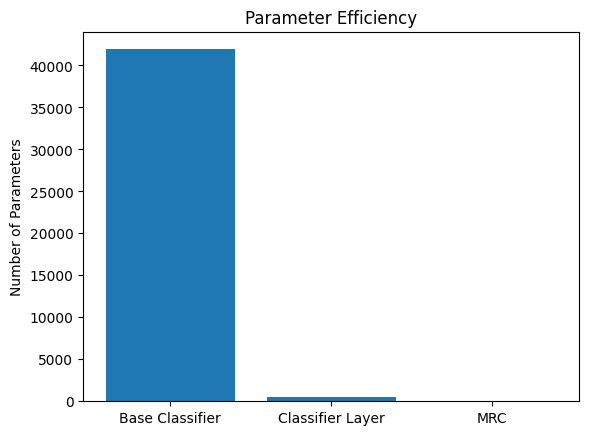

In [ ]:
# Plotting parameter efficiency
params = [base_params, layer_params, mrc_params]
labels = ['Base Classifier', 'Classifier Layer', 'MRC']

plt.bar(labels, params)
plt.ylabel('Number of Parameters')
plt.title('Parameter Efficiency')
plt.show()

In [ ]:
model = model_vae_tune_layer
total_params = count_trainable_parameters(model)
mrc_params = count_trainable_parameters(model.classifier_mrc) if model.classifier_mrc is not None else 0
base_params = count_trainable_parameters(model.classifier_base) if model.classifier_base is not None else 0
layer_params = count_trainable_parameters(model.classifier_layer) if model.classifier_layer is not None else 0

print(f"Total Parameters: {total_params}")
print(f"MRC Parameters: {mrc_params}")
print(f"Base Parameters: {base_params}")
print(f"Layer Parameters: {layer_params}")

Total Parameters: 190997922
MRC Parameters: 0
Base Parameters: 41920
Layer Parameters: 514


In [ ]:
model = model_mrc
total_params = count_trainable_parameters(model)
mrc_params = count_trainable_parameters(model.classifier_mrc) if model.classifier_mrc is not None else 0
base_params = count_trainable_parameters(model.classifier_base) if model.classifier_base is not None else 0
layer_params = count_trainable_parameters(model.classifier_layer) if model.classifier_layer is not None else 0

print(f"Total Parameters: {total_params}")
print(f"MRC Parameters: {mrc_params}")
print(f"Base Parameters: {base_params}")
print(f"Layer Parameters: {layer_params}")

Total Parameters: 190997408
MRC Parameters: 0
Base Parameters: 41920
Layer Parameters: 0


In [ ]:
model = model_mrc_bottleneck
total_params = count_trainable_parameters(model)
mrc_params = count_trainable_parameters(model.classifier_mrc) if model.classifier_mrc is not None else 0
base_params = count_trainable_parameters(model.classifier_base) if model.classifier_base is not None else 0
layer_params = count_trainable_parameters(model.classifier_layer) if model.classifier_layer is not None else 0

print(f"Total Parameters: {total_params}")
print(f"MRC Parameters: {mrc_params}")
print(f"Base Parameters: {base_params}")
print(f"Layer Parameters: {layer_params}")

Total Parameters: 190997408
MRC Parameters: 0
Base Parameters: 41920
Layer Parameters: 0


In [ ]:
model = model_cmrc
total_params = count_trainable_parameters(model)
mrc_params = count_trainable_parameters(model.classifier_mrc) if model.classifier_mrc is not None else 0
base_params = count_trainable_parameters(model.classifier_base) if model.classifier_base is not None else 0
layer_params = count_trainable_parameters(model.classifier_layer) if model.classifier_layer is not None else 0

print(f"Total Parameters: {total_params}")
print(f"MRC Parameters: {mrc_params}")
print(f"Base Parameters: {base_params}")
print(f"Layer Parameters: {layer_params}")

Total Parameters: 190997408
MRC Parameters: 0
Base Parameters: 41920
Layer Parameters: 0


In [ ]:
model = model_cmrc_bottleneck
total_params = count_trainable_parameters(model)
mrc_params = count_trainable_parameters(model.classifier_mrc) if model.classifier_mrc is not None else 0
base_params = count_trainable_parameters(model.classifier_base) if model.classifier_base is not None else 0
layer_params = count_trainable_parameters(model.classifier_layer) if model.classifier_layer is not None else 0

print(f"Total Parameters: {total_params}")
print(f"MRC Parameters: {mrc_params}")
print(f"Base Parameters: {base_params}")
print(f"Layer Parameters: {layer_params}")

Total Parameters: 190997408
MRC Parameters: 0
Base Parameters: 41920
Layer Parameters: 0


#### **5.1.2 Training Time**

Compare the time taken to train different models.

The training time for the MRC fine-tuning is reduced by X% compared to the full model, demonstrating the efficiency of this approach for quick adaptation in transfer learning scenarios.

In [ ]:
# Measuring training time
start_time = time.time()
# Training code for the full model
end_time = time.time()
full_model_time = end_time - start_time

start_time = time.time()
# Training code for the MRC fine-tuning
end_time = time.time()
mrc_model_time = end_time - start_time

print(f"Full Model Training Time: {full_model_time} seconds")
print(f"MRC Fine-Tuning Training Time: {mrc_model_time} seconds")

In [ ]:
# Plotting Training Time
times = [full_model_time, mrc_time]
labels = ['Full Model', 'MRC Fine-Tuning']

plt.bar(labels, times)
plt.ylabel('Training Time (seconds)')
plt.title('Training Time Comparison')
plt.show()

#### **5.1.3 Resource Consumption**

Illustrate memory or computational resource usage.

Memory usage analysis shows that the MRC approach consumes X% less memory, making it more suitable for deployment in resource-constrained environments.

In [34]:
# Measuring resource usage
def measure_memory_usage():
    memory_allocated = torch.cuda.memory_allocated() / (1024 * 1024)  # in MB
    memory_reserved = torch.cuda.memory_reserved() / (1024 * 1024)  # in MB
    return memory_allocated, memory_reserved

# Example: Measure memory usage before and after training
before_alloc, before_res = measure_memory_usage()
# Training code
after_alloc, after_res = measure_memory_usage()

print(f"Memory Usage Before Training: Allocated {before_alloc:.2f} MB, Reserved {before_res:.2f} MB")
print(f"Memory Usage After Training: Allocated {after_alloc:.2f} MB, Reserved {after_res:.2f} MB")

Memory Usage Before Training: Allocated 0.00 MB, Reserved 0.00 MB
Memory Usage After Training: Allocated 0.00 MB, Reserved 0.00 MB


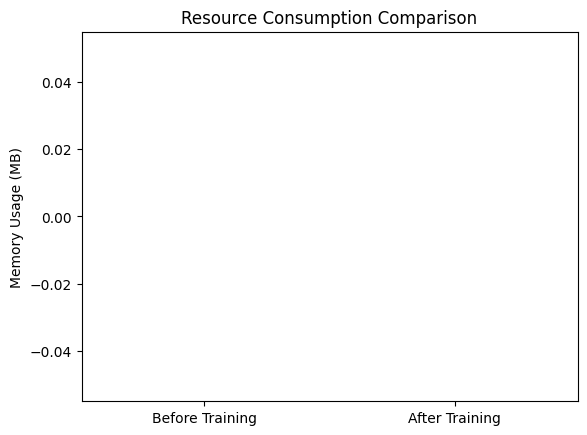

In [ ]:
# Plotting Resource Consumption
mem_usage = [before_alloc, after_alloc]
labels = ['Before Training', 'After Training']

plt.bar(labels, mem_usage)
plt.ylabel('Memory Usage (MB)')
plt.title('Resource Consumption Comparison')
plt.show()

In [ ]:
start_time = time.time()
# Training code for the MRC fine-tuning
end_time = time.time()
mrc_model_time = end_time - start_time
# Example: Measure memory usage before and after training
before_alloc, before_res = measure_memory_usage()
# Training code
after_alloc, after_res = measure_memory_usage()

print(f"Full Model Training Time: {full_model_time} seconds")
print(f"MRC Fine-Tuning Training Time: {mrc_model_time} seconds")
print(f"Memory Usage Before Training: Allocated {before_alloc:.2f} MB, Reserved {before_res:.2f} MB")
print(f"Memory Usage After Training: Allocated {after_alloc:.2f} MB, Reserved {after_res:.2f} MB")

# Plotting Resource Consumption
mem_usage = [before_alloc, after_alloc]
labels = ['Before Training', 'After Training']

plt.bar(labels, mem_usage)
plt.ylabel('Memory Usage (MB)')
plt.title('Resource Consumption Comparison')
plt.show()

NameError: name 'full_model_time' is not defined

### **5.2 Environmental Identification Training**

In [35]:
def train_model_iins(
    model, train_data, valid_data, optimizer, device, opt, model_path, data_path, result_path, scheduler=None,
    integration_level='bottleneck', classifier_type='cmrc', lambda_vae=1, lambda_reg=1, lambda_cls=1, plot_comparison=False,
    if_valid=True
):
    before_alloc, before_res = measure_memory_usage()
    print(f"Memory Usage Before Training: Allocated {before_alloc:.2f} MB, Reserved {before_res:.2f} MB")

    if integration_level == 'layer':
        if  classifier_type == 'neural':
            model_type = 'IInsVAE'
        elif classifier_type == 'mrc':
            model_type = 'IInsVAEMRC'
        elif classifier_type == 'cmrc':
            model_type = 'IInsVCMRC'

    elif integration_level == 'bottleneck':
        if classifier_type == 'neural':
            model_type = 'IInsVAE'
        elif classifier_type == 'mrc':
            model_type = 'IInsVAEMRC-Bottleneck'
        elif classifier_type == 'cmrc':
            model_type = 'IInsVCMRC-Bottleneck'

    else:
        model_type = 'IInsVAE'

    print(f"Starting Training the {model_type}...")

    # create log files
    df_history = pd.DataFrame(columns=[
        'epoch', 'train_loss', 'train_rmse', 'train_mae', 'train_acc', 'train_recon', 'train_time (100)',
        'val_loss', 'val_rmse', 'val_mae', 'val_acc', 'val_recon', 'val_time (100)',
        'val_accuracy', 'val_precision', 'val_recall', 'val_f1_score', 'val_auroc', 'confusion_matrix'
    ])

    # load data
    dl_train = DataLoader(
        dataset=UWBDataset(train_data), batch_size=opt['batch_size'], shuffle=True, num_workers=8
    )
    dl_valid = DataLoader(
        dataset=UWBDataset(valid_data), batch_size=opt['batch_size'], shuffle=False, num_workers=1
    )

    # load pre-trained model or initialize weights
    if opt['start_epoch'] != 0:
        model.load_state_dict(torch.load(os.path.join(model_path, "%s_%d.pth" % (model_type, opt['start_epoch']))))
    else:
        model.apply(weights_init_normal)

    model.to(device)

    # for learning process visualization (outside epoch)
    criterion_recon = torch.nn.L1Loss().to(device)
    criterion_mse = torch.nn.MSELoss().to(device)
    criterion_xent = torch.nn.CrossEntropyLoss().to(device)
    rmse_arr, mae_arr, acc_arr, recon_arr = [], [], [], []
    print("Total Epochs:", opt['n_epochs'])
    for epoch in range(opt['start_epoch'] + 1, opt['n_epochs'] + 1):
        model.train()

        # train a loop
        loss_sum = 0.0
        loss_vae_sum = 0.0
        loss_reg_sum = 0.0
        loss_cls_sum = 0.0
        loss_latent_sum = 0.0
        rmse_sum = 0.0
        mae_sum = 0.0
        acc_sum = 0.0
        recon_sum = 0.0
        train_time = 0.0
        step = 1
        start_time = time.time()
        for step, batch in enumerate(dl_train, 1):

            cir = batch["CIR"].to(device)
            dM = batch["MeasuredDistance"].to(device)
            reg_gt = batch["Error"].to(device) if opt['est_type'] == 'mitigation' else batch["TrueDistance"].to(device)
            cls_gt = batch["RoomLabel"].to(device=device, dtype=torch.int64) if opt['cls_type'] == 'room' else batch['Label'].to(device=device, dtype=torch.int64)

            optimizer.zero_grad()

            # Forward pass
            range_code, env_code, x_recon, reg_est, kl_div = model(cir, dM)  # (B, cir_len) + (B,) -> (B, r_dim), (B, e_dim(*2)), (B,)
            loss_vae = criterion_recon(cir, x_recon) + lambda_vae * kl_div.mean()
            loss_reg = lambda_reg * criterion_recon(reg_est, reg_gt)

            # Classification
            cls_label = cls_gt.squeeze()  # [0, 1, 2, ...]
            if classifier_type == 'neural':
                cls_pred, _, _ = model.classify(env_code, cls_gt)
                # Ensure cls_pred is a tensor, if it's a tuple, extract the relevant tensor
                # if isinstance(cls_pred, tuple):
                #     cls_pred = cls_pred[0]  # Assuming the first element of the tuple is the prediction tensor
                # print(torch.unique(cls_label.long()))
                # print(f"Prediction shape: {cls_pred.shape}")
                # print(f"Target shape: {cls_label.long().shape}")
                loss_cls = lambda_cls * criterion_xent(cls_pred, cls_label.long())
            elif classifier_type in ['mrc', 'cmrc']:
                cls_pred, _, _ = model.classify(env_code, cls_gt)
                # print("Test cls pred:", cls_pred, cls_gt)
                # if isinstance(cls_pred, tuple):
                #     cls_pred = cls_pred[0]  # Assuming the first element of the tuple is the prediction tensor
                loss_cls = lambda_cls * criterion_xent(cls_pred.float(), cls_gt.float())
            else:
                raise NotImplementedError
            # cls_pred, _, _ = model.classify(env_code, cls_gt)
            # loss_cls = lambda_cls * criterion_xent(cls_pred, cls_gt)

            # Total loss
            loss = loss_vae + loss_reg + loss_cls
            loss.backward()
            optimizer.step()

            # Calculate metrics
            with torch.no_grad():
                # calculate metrics
                err_iins = torch.abs(reg_est - reg_gt)
                rmse_error = (torch.sum(err_iins ** 2) / reg_gt.shape[0]) ** 0.5
                abs_error = torch.sum(err_iins) / reg_gt.shape[0]
                prediction = torch.argmax(cls_pred)  # , dim=1
                acc = torch.sum(prediction == cls_label.float()) / cls_gt.shape[0]
                recon_sim = criterion_mse(x_recon, cir) / cir.shape[0]

            # print batch-level log
            loss_sum += loss.item()
            loss_vae_sum += loss_vae.item()
            loss_reg_sum += loss_reg.item()
            loss_cls_sum += loss_cls.item()
            rmse_sum += rmse_error
            mae_sum += abs_error
            acc_sum += acc
            recon_sum += recon_sim
            train_time = (time.time() - start_time) / cls_gt.shape[0] * 100
            if step % 200 == 0:
                print(("[step = %d] loss: %.3f, ae_loss: %.3f, reg_loss: %.3f, cls_loss: %.3f"
                       "latent_loss: %.3f, RMSE: %.3f, MAE: %.3f, ACC: %.3f, Recon_err: %.3f, Time (100): %.3f")
                      % (step, loss_sum / step, loss_vae_sum / step, loss_reg_sum / step, loss_cls_sum / step,
                         loss_latent_sum / step, rmse_sum / step, mae_sum / step, acc_sum / step, recon_sum / step, train_time / step))

        # update learning rate (optional)
        if scheduler is not None:
            scheduler.step()

        # validate a loop
        if if_valid:
            model.eval()
            with torch.no_grad():
                val_loss_sum = 0.0
                val_rmse_sum = 0.0
                val_mae_sum = 0.0
                val_acc_sum = 0.0
                val_recon_sum = 0.0
                val_time = 0.0
                val_step = 1

                # for inference performance visualization (within an epoch)
                recon_arr, features_arr, labels_arr = [], [], []  # supervise env inference
                err_ori_arr, err_iins_arr = [], []  # supervise dist inference
                cls_pred_all, cls_gt_all = [], []
                conf_matrix = np.zeros((opt['num_classes'], opt['num_classes']))

                start_time = time.time()
                for val_step, batch in enumerate(dl_valid, 1):

                    cir = batch["CIR"].to(device)
                    dM = batch["MeasuredDistance"].to(device)
                    reg_gt = batch["Error"].to(device) if opt['est_type'] == 'mitigation' else batch["TrueDistance"].to(device)
                    cls_gt = batch["RoomLabel"].to(device=device, dtype=torch.torch.int64) if opt['est_type'] == 'room' else batch['Label'].to(device=device, dtype=torch.torch.int64)
                    err_ori = reg_gt if opt['est_type'] == 'mitigation' else (dM - reg_gt)

                    # calculate loss terms
                    range_code_v, env_code_v, x_recon_v, reg_est_v, kl_div_v = model(cir, dM)  # (B, cir_len) + (B,) -> (B, r_dim), (B, e_dim), (B,)
                    loss_vae_v = criterion_recon(cir, x_recon_v) + lambda_vae * kl_div_v.mean()
                    loss_reg_v = lambda_reg * criterion_recon(reg_est_v, reg_gt)

                    # Classification
                    if classifier_type == 'neural':
                        cls_label = cls_gt.squeeze()  # [0, 1, 2, ...]
                        cls_pred_v, _, _ = model.classify(env_code_v, cls_label.long())
                        loss_cls_v = lambda_cls * criterion_xent(cls_pred_v, cls_label.long())
                    elif classifier_type in ['mrc', 'cmrc']:
                        cls_pred_v, mrc_upper, mrc_lower = model.classify(env_code_v, cls_gt.float())
                        # if isinstance(cls_pred_v, tuple):
                        #     cls_pred_v = cls_pred_v[0]  # Assuming the first element of the tuple is the prediction tensor
                        loss_cls_v = lambda_cls * criterion_xent(cls_pred_v.float(), cls_gt.float())
                    else:
                        raise NotImplementedError

                    # Total loss
                    loss_v = loss_vae_v + loss_reg_v + loss_cls_v

                    # calculate metrics
                    err_ori = reg_gt if opt['est_type'] == 'mitigation' else (dM - reg_gt)
                    err_iins = torch.abs(reg_est_v - reg_gt)
                    rmse_error_v = (torch.sum(err_iins ** 2) / reg_gt.shape[0]) ** 0.5
                    abs_error_v = torch.sum(err_iins) / reg_gt.shape[0]
                    # print("Test cls_pred_v: ", cls_pred_v)
                    # print("Test cls_label : ", cls_gt)
                    prediction_v = cls_pred_v  # torch.argmax(cls_pred_v, dim=1)
                    # print("Test prediction_v : ", prediction_v)
                    acc_v = torch.sum(prediction_v == cls_gt.float()) / cls_gt.shape[0]
                    recon_sim_v = criterion_mse(x_recon_v, cir) / cir.shape[0]
                    # print("Recon_sim_v:", recon_sim_v)

                    val_loss_sum += loss_v
                    val_rmse_sum += rmse_error_v
                    val_mae_sum += abs_error_v
                    val_acc_sum += acc_v
                    val_recon_sum += recon_sim_v.mean().item()
                    val_time = (time.time() - start_time) / cls_gt.shape[0] * 100
                    # Calculate confusion matrix (already included in evaluation metrics)
                    # conf_matrix += confusion_matrix(cls_gt.cpu().numpy(), prediction_v.cpu().numpy(), labels=np.arange(opt.num_classes))

                    # Collect predictions and labels for metrics evaluation
                    cls_pred_all.extend(prediction_v.cpu().numpy())
                    cls_gt_all.extend(cls_gt.cpu().numpy())

                    # save visualization arrays for iterations within epoch
                    # 1) save latent features
                    x_recon_v = x_recon_v.cpu().numpy()
                    env_code_v = env_code_v.cpu().numpy()
                    cls_label_v = cls_gt.cpu().numpy()
                    if val_step == 1:
                        recon_arr = x_recon_v  # signal conversion visualize
                        features_arr = env_code_v
                        labels_arr = cls_label_v
                    else:
                        # print("Test validation sizes:", labels_arr.shape, cls_label_v.shape)
                        # Check if shapes match before concatenating
                        if val_step == 2 or labels_arr.shape[1] == cls_label_v.shape[0]:
                            recon_arr = np.vstack((recon_arr, x_recon_v))
                            features_arr = np.vstack((features_arr, env_code_v))
                            labels_arr = np.vstack((labels_arr, cls_label_v))
                        else:
                            # Handle the case of mismatched shapes, e.g., skip the batch or adjust array sizes
                            print(f"Skipping batch with mismatched shapes: {labels_arr.shape}, {cls_label_v.shape}")

                    # 2) est error arrays for CDF
                    err_ori = err_ori.cpu().numpy()
                    err_iins = err_iins.cpu().numpy()
                    if val_step == 1:
                        err_ori_arr = err_ori
                        err_iins_arr = err_iins
                    else:
                        if val_step == 2 or err_ori_arr.shape[1] == err_ori.shape[0]:
                            err_ori_arr = np.vstack((err_ori_arr, err_ori))
                            err_iins_arr = np.vstack((err_iins_arr, err_iins))
                        else:
                            # Handle the case of mismatched shapes, e.g., skip the batch or adjust array sizes
                            print(f"Skipping batch with mismatched shapes: {err_ori_arr.shape}, {err_ori.shape}")

            # After the validation loop, evaluate the classification metrics
            # print("Testing cls metrics:", np.array(cls_gt_all)[:5], np.array(cls_pred_all)[:5])
            val_metrics = evaluate_classification(np.array(cls_gt_all), np.array(cls_pred_all))
            print(f"Validation Accuracy: {val_metrics['accuracy']}")
            print(f"Validation Precision: {val_metrics['precision']}")
            print(f"Validation Recall: {val_metrics['recall']}")
            print(f"Validation F1 Score: {val_metrics['f1_score']}")
            print(f"Validation AUROC: {val_metrics['auroc']}")
            conf_matrix = val_metrics['confusion_matrix']

            # Display confusion matrix (already included in evaluation metrics)
            conf_matrix = np.array(conf_matrix)
            corrects = conf_matrix.diagonal(offset=0)
            per_kinds = conf_matrix.sum(axis=1)
            print("\nElement Nums of each class: ", per_kinds)
            print("\nCorrect Nums of each class: ", corrects)
            print("\nAccuracy of IIns-VAE of each class: {0}".format(
                [rate * 100 for rate in corrects / per_kinds]
            ))

            # Optionally, calculate bounds using cross-validation (for models using MRC '0-1')
            if classifier_type in ['mrc', 'cmrc']:
                mrc_upper = mrc_upper
                mrc_lower = mrc_lower
                print(f"MRC: Upper Bound: {mrc_upper}, Lower Bound: {mrc_lower}")
                # scores, cv_lower, cv_upper, mean_score = cross_validation_bounds(
                #     model.classifier_mrc, env_code_v, cls_gt
                # )
                # print(f"CV: Mean Score: {mean_score}, Lower Bound: {cv_lower}, Upper Bound: {cv_upper}")

            # Save log
            info = {
                'epoch': epoch,
                'train_loss': loss_sum / step,
                'train_rmse': rmse_sum / step,
                'train_mae': mae_sum / step,
                'train_acc': acc_sum / step,
                'train_recon': recon_sum / step,
                'train_time (100)': train_time / step,
                'val_loss': val_loss_sum / val_step,
                'val_rmse': val_rmse_sum / val_step,
                'val_mae': val_mae_sum / val_step,
                'val_acc': val_acc_sum / val_step,
                'val_recon': val_recon_sum / val_step,
                'val_time (100)': val_time / val_step,
                'val_accuracy': val_metrics['accuracy'],
                'val_precision': val_metrics['precision'],
                'val_recall': val_metrics['recall'],
                'val_f1_score': val_metrics['f1_score'],
                'val_auroc': val_metrics['auroc'],
                'confusion_matrix': val_metrics['confusion_matrix'].tolist()  # Save as list if you want to store it
            }

            # df_history = df_history.append(info, ignore_index=True)
            df_history = pd.concat([df_history, pd.DataFrame([info])], ignore_index=True)

            # Print epoch-level log
            print((
                "\n[Train epoch = %d], loss: %.3f, RMSE: %.3f, MAE: %.3f, ACC: %.3f, Recon_Err: %.3f, Time (100): %.3f,"
                "\n[Validate] loss_val: %.3f, RMSE_val: %.3f, MAE_val: %.3f, ACC_val: %.3f, Recon_val: %.3f, Time_val (100): %.3f, "
                "Accuracy: %.3f, Precision: %.3f, Recall: %.3f, F1 Score: %.3f, AUROC: %.3f"
            ) % (
                epoch, loss_sum / step, rmse_sum / step, mae_sum / step, acc_sum / step, recon_sum / step, train_time / step,
                val_loss_sum / val_step, val_rmse_sum / val_step, val_mae_sum / val_step, val_acc_sum / val_step, val_recon_sum / step, val_time / step,
                val_metrics['accuracy'], val_metrics['precision'], val_metrics['recall'], val_metrics['f1_score'], val_metrics['auroc']
            ))

            # save models at checkpoint epoch
            if epoch == 1 or epoch % opt['checkpoint_interval'] == 0:
                torch.save(model.state_dict(), os.path.join(model_path, "%s_%d.pth" % (model_type, epoch)))

            # illustrate exp results on test data
            # 3) rmse and acc for convergence curves
            if epoch == (opt['start_epoch']+1):
                rmse_arr = (val_rmse_sum / val_step).cpu().detach().numpy() # Move tensor to CPU and convert to NumPy
                mae_arr = (val_mae_sum / val_step).cpu().detach().numpy() # Move tensor to CPU and convert to NumPy
                acc_arr = (val_acc_sum / val_step).cpu().detach().numpy() # Move tensor to CPU and convert to NumPy
                # recon_arr = (val_recon_sum / val_step)
            else:
                rmse_arr = np.vstack((rmse_arr, (val_rmse_sum / val_step).cpu().detach().numpy())) # Move tensor to CPU, detach from the computation graph and convert to NumPy
                mae_arr = np.vstack((mae_arr, (val_mae_sum / val_step).cpu().detach().numpy())) # Move tensor to CPU, detach from the computation graph and convert to NumPy
                acc_arr = np.vstack((acc_arr, (val_acc_sum / val_step).cpu().detach().numpy())) # Move tensor to CPU, detach from the computation graph and convert to NumPy
                # print("Recon_arr shape:", recon_arr.shape, val_recon_sum / val_step)
                # Calculate the mean across all but the first dimension
                # recon_arr = np.vstack((recon_arr, np.mean((val_recon_sum / val_step), axis=0))) # Remove tuple and range. If the intention was to get the average across all dimensions, simply use np.mean() without specifying the axis

            if epoch % opt['sample_interval'] == 0:
                # 1) reduce epoch env features for latent representations
                features_arr = reduce_latents(features_arr, method=opt['visual_method'], n_components=opt['visual_dim'])
                visualize_latents_encircle(
                    features_arr, labels_arr, labels_arr, result_path, epoch,
                    dataset_name=opt['dataset_name'], dataset_env=opt['dataset_env'], level=opt['cls_type'], data_type='ENV',
                    method=opt['visual_method'], n_components=opt['visual_dim'], encircle_flag=False,
                    title="Environment Feature Visualization of epoch %d." % epoch
                )

                # 2) visualize learning process
                y1 = rmse_arr.squeeze()
                y2 = mae_arr.squeeze()
                y3 = acc_arr.squeeze()
                # y4 = recon_arr.squeeze()
                x = np.arange(0, y1.shape[0])
                plot_learning_curves(
                    x, y1, y2, y3, labelx="Learning Iterations", label1="RMSE of distance estimation",
                    label2="MAE of distance estimation", label3="Accuracy of distance estimation",
                    color1="tab:blue", color2="tab:red", color3="tab:green")
                plt.savefig(
                    os.path.join(result_path, "LearningProcesRMSE_%s-%d.eps" % (opt['cls_type'], epoch))
                )
                plt.close()

                # 3) visualize confusion matrix (classifiers)
                labels = label_list_display(opt['dataset_name'], option=opt['dataset_env'], level=opt['cls_type'])
                visualize_conf_matrix(val_metrics['confusion_matrix'], opt['num_classes'], labels, normalize=True)  # conf_matrix
                plt.savefig(os.path.join(result_path, "confusion_matrixII-%s_epoch%d.eps" % (opt['cls_type'], opt['test_epoch'])), format='eps', dpi=600)

    # 4) plot baseline comparisons for dist/env inference
    if plot_comparison:
        df_mls, df_mrcs, df_mrcs_nd, df_cmrcs, df_cmrcs_nd = compare_clsbaselines(
            dl_train, dl_valid, opt['dataset_name'], opt['cls_type'], epoch,
            extract_flag=True, extract_method='PF', extract_length=6,
            save_path=opt['result_path']
        )
        print("Baseline Methods:", df_mls, df_mrcs, df_mrcs_nd, df_cmrcs, df_cmrcs_nd)

    # Save df_history to a csv file at the end
    df_history.to_csv(os.path.join(result_path, "training_history.csv"), index=False)

    after_alloc, after_res = measure_memory_usage()
    print(f"Memory Usage After Training: Allocated {after_alloc:.2f} MB, Reserved {after_res:.2f} MB")

    # Plotting Resource Consumption
    mem_usage = [before_alloc, after_alloc]
    labels = ['Before Training', 'After Training']

    plt.bar(labels, mem_usage)
    plt.ylabel('Memory Usage (MB)')
    plt.title('Resource Consumption Comparison')
    plt.show()

    print("Finished Training...")
    return df_history, model

### **5.3 Transfer Learning**

In [36]:
def train_model_iins_transfer(
    model, source_data, target_train_data, target_test_data, optimizer, device, opt, model_path, data_path, result_path, scheduler=None,
    integration_level='bottleneck', classifier_type='cmrc', transfer_learning_mode='train',
    lambda_vae=1, lambda_reg=1, lambda_cls=1, plot_comparison=False,
):  # Only for IIns-VAE and other neural substitution

    before_alloc, before_res = measure_memory_usage()
    print(f"Memory Usage Before Training: Allocated {before_alloc:.2f} MB, Reserved {before_res:.2f} MB")

    if integration_level == 'layer':
        if  classifier_type == 'neural':
            model_type = 'IInsVAE'
        elif classifier_type == 'mrc':
            model_type = 'IInsVAEMRC'
        elif classifier_type == 'cmrc':
            model_type = 'IInsVCMRC'

    elif integration_level == 'bottleneck':
        if classifier_type == 'neural':
            model_type = 'IInsVAE'
        elif classifier_type == 'mrc':
            model_type = 'IInsVAEMRC-Bottleneck'
        elif classifier_type == 'cmrc':
            model_type = 'IInsVCMRC-Bottleneck'

    else:
        model_type = 'IInsVAE'

    print(f"Starting Training the {model_type} under the Transfer Learning Setting...")

    # create log files
    df_history = pd.DataFrame(columns=[
        'epoch', 'train_loss', 'train_rmse', 'train_mae', 'train_acc', 'train_recon', 'train_time (100)', 'memory_usage',
        'val_loss', 'val_rmse', 'val_mae', 'val_acc', 'val_recon', 'val_time (100)',
        'val_accuracy', 'val_precision', 'val_recall', 'val_f1_score', 'val_auroc', 'confusion_matrix'
    ])

    # load source and target domain
    if transfer_learning_mode == 'train':
        train_data = source_data
        valid_data = target_test_data
    elif transfer_learning_mode == 'fine-tune':
        train_data = target_train_data
        valid_data = target_test_data
    elif transfer_learning_mode == 'whole-dataset':
        train_data = np.concatenate((source_data, target_train_data), axis=0)
        valid_data = target_test_data
    else:
        raise NotImplementedError
    dl_train = DataLoader(
        dataset=UWBDataset(train_data), batch_size=opt['batch_size'], shuffle=True, num_workers=8
    )
    dl_valid = DataLoader(
        dataset=UWBDataset(valid_data), batch_size=opt['batch_size'], shuffle=True, num_workers=1
    )

    # load pre-trained model or initialize weights
    if opt['start_epoch'] != 0:
        model.load_state_dict(torch.load(os.path.join(model_path, "%s_%d.pth" % (model_type, opt['start_epoch']))))
    else:
        model.apply(weights_init_normal)

    model.to(device)

    # Choose tunable parameters for transfer learning
    if transfer_learning_mode == 'fine-tune':
        # Freeze encoder and decoder layers
        for param in model.encoder.parameters():
            param.requires_grad = False
        for param in model.decoder.parameters():
            param.requires_grad = False
        for param in model.regressor.parameters():
            param.requires_grad = False
        if integration_level == 'layer':
            for param in model.classifier_base.parameters():
                param.requires_grad = False
            for param in model.classifier_layer.parameters():
                param.requires_grad = True
        elif integration_level == 'bottleneck':
            for param in model.classifier.parameters():
                param.requires_grad = True
        else:
            raise NotImplementedError
    elif transfer_learning_mode in ['train', 'whole-dataset']:
        pass
    else:
        raise NotImplementedError

    # Fine-tune on target domain
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=opt['lr'], betas=(opt['b1'], opt['b2']))

    # for learning process visualization (outside epoch)
    criterion_recon = torch.nn.L1Loss().to(device)
    criterion_mse = torch.nn.MSELoss().to(device)
    criterion_xent = torch.nn.CrossEntropyLoss().to(device)
    rmse_arr, mae_arr, acc_arr, recon_arr = [], [], [], []

    for epoch in range(opt['start_epoch'] + 1, opt['n_epochs'] + 1):
        model.train()

        # train a loop
        loss_sum = 0.0
        loss_vae_sum = 0.0
        loss_reg_sum = 0.0
        loss_cls_sum = 0.0
        loss_latent_sum = 0.0
        rmse_sum = 0.0
        mae_sum = 0.0
        acc_sum = 0.0
        recon_sum = 0.0
        train_time = 0.0
        step = 1
        start_time = time.time()

        for step, batch in enumerate(dl_train, 1):

            cir = batch["CIR"].to(device)
            dM = batch["MeasuredDistance"].to(device)
            reg_gt = batch["Error"].to(device) if opt['est_type'] == 'mitigation' else batch["TrueDistance"].to(device)
            cls_gt = batch["RoomLabel"].to(device=device, dtype=torch.int64) if opt['cls_type'] == 'room' else batch['Label'].to(device=device, dtype=torch.int64)

            optimizer.zero_grad()

            # Forward pass
            range_code, env_code, x_recon, reg_est, kl_div = model(cir, dM)  # (B, cir_len) + (B,) -> (B, r_dim), (B, e_dim(*2)), (B,)
            loss_vae = criterion_recon(cir, x_recon) + lambda_vae * kl_div.mean()
            loss_reg = lambda_reg * criterion_recon(reg_est, reg_gt)

            # Classification
            cls_label = cls_gt.squeeze()  # [0, 1, 2, ...]
            if classifier_type == 'neural':
                cls_pred, _, _ = model.classify(env_code, cls_gt)
                # Ensure cls_pred is a tensor, if it's a tuple, extract the relevant tensor
                # if isinstance(cls_pred, tuple):
                #     cls_pred = cls_pred[0]  # Assuming the first element of the tuple is the prediction tensor
                loss_cls = lambda_cls * criterion_xent(cls_pred, cls_label.long())
            elif classifier_type in ['mrc', 'cmrc']:
                cls_pred, _, _ = model.classify(env_code, cls_gt)
                # print("Test cls pred:", cls_pred, cls_gt)
                # if isinstance(cls_pred, tuple):
                #     cls_pred = cls_pred[0]  # Assuming the first element of the tuple is the prediction tensor
                loss_cls = lambda_cls * criterion_xent(cls_pred.float(), cls_gt.float())
            else:
                raise NotImplementedError

            # Total loss
            loss = loss_vae + loss_reg + loss_cls
            loss.backward()
            optimizer.step()

            # Calculate metrics
            with torch.no_grad():
                # calculate metrics
                err_iins = torch.abs(reg_est - reg_gt)
                rmse_error = (torch.sum(err_iins ** 2) / reg_gt.shape[0]) ** 0.5
                abs_error = torch.sum(err_iins) / reg_gt.shape[0]
                prediction = torch.argmax(cls_pred, dim=1)
                acc = torch.sum(prediction == cls_gt.float()) / cls_gt.shape[0]
                # recon_sim = criterion_mse(x_recon, cir) / cir.gt[0]

            # print batch-level log
            loss_sum += loss.item()
            loss_vae_sum += loss_vae.item()
            loss_reg_sum += loss_reg.item()
            loss_cls_sum += loss_cls.item()
            rmse_sum += rmse_error
            mae_sum += abs_error
            acc_sum += acc
            # recon_sum += recon_sim

            # for transfer learning
            train_time = (time.time() - start_time) / cls_gt.shape[0] * 100
            memory_usage = torch.cuda.memory_allocated(device) / 1024 ** 2 if device.type == 'cuda' else 0

            if step % 100 == 0:
                print(("[Source Domain: step = %d] loss: %.3f, ae_loss: %.3f, reg_loss: %.3f, cls_loss: %.3f"
                       "latent_loss: %.3f, RMSE: %.3f, MAE: %.3f, ACC: %.3f, Recon_err: %.3f, Time (100): %.3f, Memory_usage: %.3f")
                      % (step, loss_sum / step, loss_vae_sum / step, loss_reg_sum / step, loss_cls_sum / step,
                         loss_latent_sum / step, rmse_sum / step, mae_sum / step, acc_sum / step, recon_sum / step, train_time / step, memory_usage))

        # update learning rate (optional)
        if scheduler is not None:
            scheduler.step()

        # validate a loop
        model.eval()
        with torch.no_grad():
            val_loss_sum = 0.0
            val_rmse_sum = 0.0
            val_mae_sum = 0.0
            val_acc_sum = 0.0
            val_recon_sum = 0.0
            val_time = 0.0
            val_step = 1

            # for inference performance visualization (within an epoch)
            recon_arr, features_arr, labels_arr = [], [], []  # supervise env inference
            err_ori_arr, err_iins_arr = [], []  # supervise dist inference
            cls_pred_all, cls_gt_all = [], []
            conf_matrix = np.zeros((opt['num_classes'], opt['num_classes']))
            start_time = time.time()
            for val_step, batch in enumerate(dl_valid, 1):  # ADD VALID, dl_valid = target_domain_test

                cir = batch["CIR"].to(device)
                dM = batch["MeasuredDistance"].to(device)
                reg_gt = batch["Error"].to(device) if opt['est_type'] == 'mitigation' else batch["TrueDistance"].to(device)
                cls_gt = batch["RoomLabel"].to(device=device, dtype=torch.torch.int64) if opt['est_type'] == 'room' else batch['Label'].to(device=device, dtype=torch.torch.int64)
                err_ori = reg_gt if opt['est_type'] == 'mitigation' else (dM - reg_gt)

                # calculate loss terms
                range_code_v, env_code_v, x_recon_v, reg_est_v, kl_div_v = model(cir, dM)  # (B, cir_len) + (B,) -> (B, r_dim), (B, e_dim), (B,)
                loss_vae_v = criterion_recon(cir, x_recon_v) + lambda_vae * kl_div_v.mean()
                loss_reg_v = lambda_reg * criterion_recon(reg_est_v, reg_gt)

                # Classification
                if classifier_type == 'neural':
                    cls_label = cls_gt.squeeze()  # [0, 1, 2, ...]
                    cls_pred_v, _, _ = model.classify(env_code_v, cls_label.long())
                    loss_cls_v = lambda_cls * criterion_xent(cls_pred_v, cls_label.long())
                elif classifier_type in ['mrc', 'cmrc']:
                    cls_pred_v, mrc_upper, mrc_lower = model.classify(env_code_v, cls_gt.float())
                    # if isinstance(cls_pred_v, tuple):
                    #     cls_pred_v = cls_pred_v[0]  # Assuming the first element of the tuple is the prediction tensor
                    loss_cls_v = lambda_cls * criterion_xent(cls_pred_v.float(), cls_gt.float())
                else:
                    raise NotImplementedError

                # Total loss
                loss_v = loss_vae_v + loss_reg_v + loss_cls_v

                # calculate metrics
                err_ori = reg_gt if opt['est_type'] == 'mitigation' else (dM - reg_gt)
                err_iins = torch.abs(reg_est_v - reg_gt)
                rmse_error_v = (torch.sum(err_iins ** 2) / reg_gt.shape[0]) ** 0.5
                abs_error_v = torch.sum(err_iins) / reg_gt.shape[0]
                prediction_v = torch.argmax(cls_pred_v, dim=1)
                acc_v = torch.sum(prediction_v == cls_gt.float()) / cls_gt.shape[0]
                recon_sim_v = criterion_mse(x_recon_v, cir) / cir.shape[0]

                val_loss_sum += loss_v
                val_rmse_sum += rmse_error_v
                val_mae_sum += abs_error_v
                val_acc_sum += acc_v
                val_recon_sum += recon_sim_v
                val_time = (time.time() - start_time) / cir.shape[0] * 100
                # Calculate confusion matrix (already included in evaluation metrics)
                # conf_matrix += confusion_matrix(cls_gt.cpu().numpy(), prediction_v.cpu().numpy(), labels=np.arange(opt.num_classes))

                # Collect predictions and labels for metrics evaluation
                cls_pred_all.extend(prediction_v.cpu().numpy())
                cls_gt_all.extend(cls_gt.cpu().numpy())

                # save visualization arrays for iterations within epoch
                # 1) save latent features
                x_recon_v = x_recon_v.cpu().numpy()
                env_code_v = env_code_v.cpu().numpy()
                cls_label_v = cls_gt.cpu().numpy()
                if val_step == 1:
                    recon_arr = x_recon_v  # signal conversion visualize
                    features_arr = env_code_v
                    labels_arr = cls_label_v
                else:
                    # print("Test validation sizes:", labels_arr.shape, cls_label_v.shape)
                    # Check if shapes match before concatenating
                    if val_step == 2 or labels_arr.shape[1] == cls_label_v.shape[0]:
                        recon_arr = np.vstack((recon_arr, x_recon_v))
                        features_arr = np.vstack((features_arr, env_code_v))
                        labels_arr = np.vstack((labels_arr, cls_label_v))
                    else:
                        # Handle the case of mismatched shapes, e.g., skip the batch or adjust array sizes
                        print(f"Skipping batch with mismatched shapes: {labels_arr.shape}, {cls_label_v.shape}")

                # 2) est error arrays for CDF
                err_ori = err_ori.cpu().numpy()
                err_iins = err_iins.cpu().numpy()
                if val_step == 1:
                    err_ori_arr = err_ori
                    err_iins_arr = err_iins
                else:
                    if val_step == 2 or err_ori_arr.shape[1] == err_ori.shape[0]:
                        err_ori_arr = np.vstack((err_ori_arr, err_ori))
                        err_iins_arr = np.vstack((err_iins_arr, err_iins))
                    else:
                        # Handle the case of mismatched shapes, e.g., skip the batch or adjust array sizes
                        print(f"Skipping batch with mismatched shapes: {err_ori_arr.shape}, {err_ori.shape}")

        # After the validation loop, evaluate the classification metrics
        val_metrics = evaluate_classification(np.array(cls_gt_all), np.array(cls_pred_all))
        print(f"Validation Accuracy: {val_metrics['accuracy']}")
        print(f"Validation Precision: {val_metrics['precision']}")
        print(f"Validation Recall: {val_metrics['recall']}")
        print(f"Validation F1 Score: {val_metrics['f1_score']}")
        print(f"Validation AUROC: {val_metrics['auroc']}")
        conf_matrix = val_metrics['confusion_matrix']

        # Display confusion matrix
        conf_matrix = np.array(conf_matrix)
        corrects = conf_matrix.diagonal(offset=0)
        per_kinds = conf_matrix.sum(axis=1)
        print("\nElement Nums of each class: ", per_kinds)
        print("\nCorrect Nums of each class: ", corrects)
        print("\nAccuracy of IIns-VAE of each class: {0}".format(
            [rate * 100 for rate in corrects / per_kinds]
        ))

        # Optionally, calculate bounds using cross-validation (for models using MRC '0-1')
        if classifier_type in ['mrc', 'cmrc']:
            mrc_upper = mrc_upper.cpu().numpy()
            mrc_lower = mrc_lower.cpu().numpy()
            print(f"MRC: Upper Bound: {mrc_upper}, Lower Bound: {mrc_lower}")
            scores, cv_lower, cv_upper, mean_score = cross_validation_bounds(
                model.classifier_mrc, env_code_v, cls_gt
            )
            print(f"CV: Mean Score: {mean_score}, Lower Bound: {cv_lower}, Upper Bound: {cv_upper}")

        # Save log
        info = {
            'epoch': epoch,
            'train_loss': loss_sum / step,
            'train_rmse': rmse_sum / step,
            'train_mae': mae_sum / step,
            'train_acc': acc_sum / step,
            'train_recon': recon_sum / step,
            'train_time (100)': train_time / step,
            'memory_usage': memory_usage,  # this is new for TF
            'val_loss': val_loss_sum / val_step,
            'val_rmse': val_rmse_sum / val_step,
            'val_mae': val_mae_sum / val_step,
            'val_acc': val_acc_sum / val_step,
            'val_recon': val_recon_sum / val_step,
            'val_time (100)': val_time / val_step,
            'val_accuracy': val_metrics['accuracy'],
            'val_precision': val_metrics['precision'],
            'val_recall': val_metrics['recall'],
            'val_f1_score': val_metrics['f1_score'],
            'val_auroc': val_metrics['auroc'],
            'confusion_matrix': val_metrics['confusion_matrix'].tolist()  # Save as list if you want to store it
        }

        # df_history = df_history.append(info, ignore_index=True)
        df_history = pd.concat([df_history, pd.DataFrame([info])], ignore_index=True)

        # Print epoch-level log
        print((
            "\n[Train epoch = %d], loss: %.3f, RMSE: %.3f, MAE: %.3f, ACC: %.3f, Recon_Err: %.3f, Time: %.3f (100), Memory_usage: %.3f"
            "\n[Validate] loss_val: %.3f, RMSE_val: %.3f, MAE_val: %.3f, ACC_val: %.3f, Recon_val: %.3f, Time_val (100): %.3f, "
            "Accuracy: %.3f, Precision: %.3f, Recall: %.3f, F1 Score: %.3f, AUROC: %.3f"
        ) % (
            epoch, loss_sum / step, rmse_sum / step, mae_sum / step, acc_sum / step, recon_sum / step, train_time / step, memory_usage,
            val_loss_sum / val_step, val_rmse_sum / val_step, val_mae_sum / val_step, val_acc_sum / val_step, val_recon_sum / step, val_time / step,
            val_metrics['accuracy'], val_metrics['precision'], val_metrics['recall'], val_metrics['f1_score'], val_metrics['auroc']
        ))

        # save models at checkpoint epoch
        if epoch == 1 or epoch % opt['checkpoint_interval'] == 0:
            torch.save(model.state_dict(), os.path.join(model_path, "%s_%d.pth" % (model_type, epoch)))

        # illustrate exp results on test data
        # 3) rmse and acc for convergence curves
        if epoch == (opt['start_epoch']+1):
            rmse_arr = (val_rmse_sum / val_step).cpu().detach().numpy() # Move tensor to CPU and convert to NumPy
            mae_arr = (val_mae_sum / val_step).cpu().detach().numpy() # Move tensor to CPU and convert to NumPy
            acc_arr = (val_acc_sum / val_step).cpu().detach().numpy() # Move tensor to CPU and convert to NumPy
            # recon_arr = (val_recon_sum / val_step)
        else:
            rmse_arr = np.vstack((rmse_arr, (val_rmse_sum / val_step).cpu().detach().numpy())) # Move tensor to CPU, detach from the computation graph and convert to NumPy
            mae_arr = np.vstack((mae_arr, (val_mae_sum / val_step).cpu().detach().numpy())) # Move tensor to CPU, detach from the computation graph and convert to NumPy
            acc_arr = np.vstack((acc_arr, (val_acc_sum / val_step).cpu().detach().numpy())) # Move tensor to CPU, detach from the computation graph and convert to NumPy

        if epoch % opt['sample_interval'] == 0:
            # 1) reduce epoch recon signals and env features
            # recon_arr = reduce_latents(recon_arr, method=opt['visual_method'], n_components=opt['visual_dim'])
            features_arr = reduce_latents(features_arr, method=opt['visual_method'], n_components=opt['visual_dim'])
            visualize_latents_encircle(
                recon_arr, labels_arr, labels_arr, result_path, epoch,
                dataset_name=opt['dataset_name'], dataset_env=opt['dataset_env'], level=opt['cls_type'], data_type='CIR',
                method=opt['visual_method'], n_components=opt['visual_dim'], encircle_flag=False,
                title="Reconstructed Signal Visualization of epoch %d." % epoch
            )
            visualize_latents_encircle(
                features_arr, labels_arr, labels_arr, result_path, epoch,
                dataset_name=opt['dataset_name'], dataset_env=opt['dataset_env'], level=opt['cls_type'], data_type='ENV',
                method=opt['visual_method'], n_components=opt['visual_dim'], encircle_flag=False,
                title="Environment Feature Visualization of epoch %d." % epoch
            )

            # 2) visualize learning process
            y1 = rmse_arr.squeeze()
            y2 = mae_arr.squeeze()
            y3 = acc_arr.squeeze()
            # y4 = recon_arr.squeeze()
            x = np.arange(0, y1.shape[0])
            plot_learning_curves(
                x, y1, y2, y3, labelx="Learning Iterations", label1="RMSE of distance estimation",
                label2="MAE of distance estimation", label3="Accuracy of distance estimation",
                color1="tab:blue", color2="tab:red", color3="tab:green")
            plt.savefig(
                os.path.join(result_path, "LearningProcesRMSE_%s-%d.eps" % (opt['cls_type'], epoch))
            )
            plt.close()

            # 3) visualize confusion matrix (classifiers)
            labels = label_list_display(opt['dataset_name'], option=opt['dataset_env'], level=opt['cls_type'])
            visualize_conf_matrix(val_metrics['confusion_matrix'], opt['num_classes'], labels, normalize=True)  # conf_matrix
            plt.savefig(os.path.join(result_path, "confusion_matrixII-%s_epoch%d.eps" % (opt['cls_type'], opt['test_epoch'])), format='eps', dpi=600)

    # 4) plot baseline comparisons for dist/env inference
    if plot_comparison:
        df_mls, df_mrcs, df_mrcs_nd, df_cmrcs, df_cmrcs_nd = compare_clsbaselines(
            dl_train, dl_valid, opt['dataset_name'], opt['cls_type'], epoch,
            extract_flag=True, extract_method='PF', extract_length=6,
            save_path=opt['result_path']
        )
        print("Baseline Methods:", df_mls, df_mrcs, df_mrcs_nd, df_cmrcs, df_cmrcs_nd)

    # Measure memory usage after training
    after_alloc, after_res = measure_memory_usage()
    print(f"Memory Usage After Training: Allocated {after_alloc:.2f} MB, Reserved {after_res:.2f} MB")

    # Plotting Resource Consumption
    mem_usage = [before_alloc, after_alloc]
    labels = ['Before Training', 'After Training']

    plt.bar(labels, mem_usage)
    plt.ylabel('Memory Usage (MB)')
    plt.title('Resource Consumption Comparison')
    plt.show()

    # Save df_history to a csv file at the end
    df_history.to_csv(os.path.join(result_path, "training_history_transfer_learning.csv"), index=False)
    print("Finished Training under Transfer Learning Setting...")
    return df_history, model

In [54]:
def train_model_iins_transfer_mrc(
    model_source, source_data, target_train_data, target_test_data, device, opt, model_path, data_path, result_path, scheduler=None,
    integration_level='bottleneck', classifier_type='cmrc', transfer_learning_mode='source',
    lambda_vae=1, lambda_reg=1, lambda_cls=1
):
    before_alloc, before_res = measure_memory_usage()
    print(f"Memory Usage Before Training: Allocated {before_alloc:.2f} MB, Reserved {before_res:.2f} MB")

    if integration_level == 'layer':
        if classifier_type == 'neural':
            model_type = 'IInsVAE'
        elif classifier_type == 'mrc':
            model_type = 'IInsVAEMRC'
        elif classifier_type == 'cmrc':
            model_type = 'IInsVCMRC'
        elif classifier_type == 'MLs':
            model_type = 'IInsMLs'

    elif integration_level == 'bottleneck':
        if classifier_type == 'neural':
            model_type = 'IInsVAE'
        elif classifier_type == 'mrc':
            model_type = 'IInsVAEMRC-Bottleneck'
        elif classifier_type == 'cmrc':
            model_type = 'IInsVCMRC-Bottleneck'
        elif classifier_type == 'MLs':
            model_type = 'IInsMLs-Bottleneck'

    else:
        model_type = 'IInsVAE'

    print(f"Start Training the {model_type} under the Transfer Learning Setting...")

    # Create log files
    df_history = pd.DataFrame(columns=[
        'epoch', 'train_loss', 'train_rmse', 'train_mae', 'train_acc', 'train_recon', 'train_time (100)', 'memory_usage',
        'val_loss', 'val_rmse', 'val_mae', 'val_acc', 'val_recon', 'val_time (100)',
        'val_accuracy', 'val_precision', 'val_recall', 'val_f1_score', 'val_auroc', 'confusion_matrix'
    ])

    # For learning process visualization (outside epoch)
    criterion_recon = torch.nn.L1Loss().to(device)
    criterion_mse = torch.nn.MSELoss().to(device)
    criterion_xent = torch.nn.CrossEntropyLoss().to(device)
    rmse_arr, mae_arr, acc_arr, recon_arr = [], [], [], []

    if transfer_learning_mode == 'source':
        # Load source and target data
        train_data = source_data
        valid_data = None

        # Load pre-trained model or initialize weights
        if opt['start_epoch'] != 0:
            model_source.load_state_dict(torch.load(os.path.join(model_path, "%s_%d.pth" % (model_type, opt['start_epoch']))))
        else:
            model_source.apply(weights_init_normal)
        model_source.to(device)
        optimizer = optim.Adam(model_source.parameters(), lr=opt['lr'], betas=(opt['b1'], opt['b2']))

        # Normal IIns-VAE training
        df_history, model_source = train_model_iins(
            model_source, train_data, valid_data, optimizer, device, opt, model_path, data_path, result_path, scheduler,
            integration_level, classifier_type, lambda_vae=1, lambda_reg=1, lambda_cls=1, plot_comparison=False,
            if_valid=False
        )
        torch.save(model_source.state_dict(), os.path.join(model_path, "%s_%d.pth" % (model_type, opt['n_epochs'])))
        # model_source.save_state_dict(os.path.join(model_path, "%s_%d.pth" % (model_type, opt['n_epochs'])))

    elif transfer_learning_mode == 'target':
        # Load source and target data
        train_data = target_train_data
        valid_data = target_test_data
        dl_train = DataLoader(
            dataset=UWBDataset(train_data), batch_size=opt['batch_size'], shuffle=True, num_workers=8
        )
        dl_valid = DataLoader(
            dataset=UWBDataset(valid_data), batch_size=opt['batch_size'], shuffle=True, num_workers=1
        )

        # Load pre-trained model or initialize weights
        model_source.to(device)  # assume already be trained on source data

        # Choose tunable parameters for transfer learning
        for param in model_source.encoder.parameters():
            param.requires_grad = False
        for param in model_source.decoder.parameters():
            param.requires_grad = False
        for param in model_source.regressor.parameters():
            param.requires_grad = False
        if integration_level == 'layer':
            for param in model_source.classifier_base.parameters():
                param.requires_grad = False
                if classifier_type == 'neural':
                    for param in model_source.classifier_layer.parameters():
                        param.requires_grad = True
        elif integration_level == 'bottleneck':
            if classifier_type == 'neural':
                for param in model_source.classifier_layer.parameters():
                    param.requires_grad = True

        # Fine-tune on target domain
        optimizer = optim.Adam(filter(lambda p: p.requires_grad, model_source.parameters()), lr=opt['lr'], betas=(opt['b1'], opt['b2']))

        # Fine-tuning IIns-VAE on target domain
        if classifier_type == 'neural':
            # Train neural classifier (Normal IIns-VAE training with freezed params and optimizer)
            df_history, model_source = train_model_iins(
                model_source, train_data, valid_data, optimizer, device, opt, model_path, data_path, result_path, scheduler,
                integration_level, classifier_type, lambda_vae=1, lambda_reg=1, lambda_cls=1, plot_comparison=False
            )
        else:
            with torch.no_grad():
                X_iins_train, X_d_train, Y_train = [], [], []
                for batch in dl_train:
                    X_cir_train = batch["CIR"].to(device)
                    X_d_train = batch["MeasuredDistance"].to(device)
                    Y_train = batch["RoomLabel"].to(device=device, dtype=torch.int64) if opt['cls_type'] == 'room' else batch['Label'].to(device=device, dtype=torch.int64)

                    _, X_iins_train, _, _, _ = model_source(X_cir_train, X_d_train)  # no tunable params

                    X_iins_train.extend(X_iins_train.numpy())
                    X_d_train.extend(X_d_train.numpy())
                    Y_train.extend(Y_train.numpy())

                X_iins_valid, X_d_valid, Y_valid = [], [], []
                for batch in dl_valid:
                    X_cir_valid = batch["CIR"].to(device)
                    X_d_valid = batch["MeasuredDistance"].to(device)
                    Y_valid = batch["RoomLabel"].to(device=device, dtype=torch.int64) if opt['cls_type'] == 'room' else batch['Label'].to(device=device, dtype=torch.int64)

                    _, X_iins_valid, _, _, _ = model(X_cir_valid, X_d_valid)

                    X_iins_valid.extend(X_iins_valid.numpy())
                    X_d_valid.extend(X_d_valid.numpy())
                    Y_valid.extend(Y_valid.numpy())

                X_iins_train = np.array(X_iins_train)
                X_d_train = np.array(X_d_train)
                Y_train = np.array(Y_train)
                X_iins_valid.append(X_iins_valid)
                X_d_valid.append(X_d_valid)
                Y_valid.append(Y_valid)

                X_iins = X_iins_train. X_iins_valid
                X_d = X_d_train. X_d_valid
                Y = Y_train. Y_valid

                if classifier_type == 'mrc':
                    # Train MRC classifiers
                    df_mrc, df_mrc_nd = evaluate_mrc_classifiers(
                        X_iins, X_d, Y, loss_list=['0-1', 'log'], phi_list=['linear', 'fourier'],
                        method_list=['MRC'], nd_flag=True, extract_flag=False
                    )
                    df_history = pd.concat([df_mrc, df_mrc_nd], ignore_index=True)
                elif classifier_type == 'cmrc':
                    # Train CMRC classifiers
                    df_cmrc, df_cmrc_nd = evaluate_mrc_classifiers(
                        X_iins, X_d, Y, loss_list=['0-1', 'log'], phi_list=['linear', 'fourier'],
                        method_list=['CMRC'], nd_flag=True, extract_flag=False
                    )
                    df_history = pd.concat([df_cmrc, df_cmrc_nd], ignore_index=True)
                elif classifier_type == 'MLs':
                    # Train other ML classifiers
                    df_mls = evaluate_ml_classifiers(
                        X_iins, X_d, Y, extract_flag=True, extract_method='PF', extract_length=6,
                    )
                    df_history = df_mls
                else:
                    raise NotImplementedError

    return model_source, df_history


## **6. Testing Process**

### **6.1 Testing for Environmental Identification**

In [38]:
def test_model_iins(
    model, test_data, device, opt, model_path, data_path, result_path, integration_level='bottleneck', classifier_type='cmrc',
    lambda_vae=1, lambda_reg=1, lambda_cls=1, train_data=None, model_preload=False
):

    # Define model type
    if integration_level == 'layer':
        if classifier_type == 'neural':
            model_type = 'IInsVAE'
        elif classifier_type == 'mrc':
            model_type = 'IInsVAEMRC'
        elif classifier_type == 'cmrc':
            model_type = 'IInsVCMRC'

    elif integration_level == 'bottleneck':
        if classifier_type == 'neural':
            model_type = 'IInsVAE'
        elif classifier_type == 'mrc':
            model_type = 'IInsVAEMRC-Bottleneck'
        elif classifier_type == 'cmrc':
            model_type = 'IInsVCMRC-Bottleneck'

    else:
        model_type = 'IInsVAE'

    print(f"Starting Testing the {model_type}...")

    # Create log files
    df_history = pd.DataFrame(columns=[
        'test_epoch', 'test_loss', 'test_rmse', 'test_mae', 'test_acc', 'test_recon', 'test_time (100)',
        'test_accuracy', 'test_precision', 'test_recall', 'test_f1_score', 'test_auroc', 'confusion_matrix'
    ])

    # Load data
    dl_test = DataLoader(
        dataset=UWBDataset(test_data), batch_size=opt['batch_size'], shuffle=False, num_workers=1
    )

    # Load trained model
    if not model_preload:
        model.load_state_dict(torch.load(os.path.join(model_path, "%s_%d.pth" % (model_type, opt['test_epoch']))))
        model.to(device)

    # Define the metrics and arrays for evaluation
    criterion_recon = torch.nn.L1Loss().to(device)
    criterion_mse = torch.nn.MSELoss().to(device)
    criterion_xent = torch.nn.CrossEntropyLoss().to(device)
    loss_sum = 0.0
    rmse_sum = 0.0
    mae_sum = 0.0
    acc_sum = 0.0
    recon_sum = 0.0
    test_time = 0.0
    rmse_arr, mae_arr, acc_arr, recon_arr = [], [], [], []
    recon_arr, features_arr, labels_arr = [], [], []  # supervise latents
    err_ori_arr, err_iins_arr = [], []  # supervise dist inference
    cls_pred_all, cls_gt_all = [], []  # supervise env inference

    # Start the testing process
    model.eval()
    step = 1
    start_time = time.time()
    for step, batch in enumerate(dl_test, 1):

        cir = batch["CIR"].to(device)
        dM = batch["MeasuredDistance"].to(device)
        reg_gt = batch["Error"].to(device) if opt['est_type'] == 'mitigation' else batch["TrueDistance"].to(device)
        cls_gt = batch["RoomLabel"].to(device=device, dtype=torch.int64) if opt['cls_type'] == 'room' else batch['Label'].to(device=device, dtype=torch.int64)
        err_ori = reg_gt if opt['est_type'] == 'mitigation' else (dM - reg_gt)

        # Forward pass
        range_code, env_code, x_recon, reg_est, kl_div = model(cir, dM)
        loss_vae = criterion_recon(cir, x_recon) + lambda_vae * kl_div.mean()
        loss_reg = lambda_reg * criterion_recon(reg_est, reg_gt)
        # cls_pred, mrc_upper, mrc_lower = model.classify(env_code, cls_gt.float())
        # Classification
        if classifier_type == 'neural':
            cls_pred = model.classify(env_code, cls_gt)
            cls_label = cls_gt.squeeze()  # [0, 1, 2, ...]
            # Ensure cls_pred is a tensor, if it's a tuple, extract the relevant tensor
            if isinstance(cls_pred, tuple):
                cls_pred = cls_pred[0]  # Assuming the first element of the tuple is the prediction tensor
            loss_cls = lambda_cls * criterion_xent(cls_pred, cls_label.long())
        elif classifier_type in ['mrc', 'cmrc']:
            cls_pred = model.classify(env_code, cls_gt)
            loss_cls = lambda_cls * criterion_xent(cls_pred.float(), cls_gt.float())
        else:
            raise NotImplementedError
        cls_pred, _, _ = model.classify(env_code, cls_gt)
        loss_cls = lambda_cls * criterion_xent(cls_pred, cls_gt)

        loss = loss_vae + loss_reg + loss_cls

        # Calculate metrics
        err_ori = reg_gt if opt['est_type'] == 'mitigation' else (dM - reg_gt)
        err_iins = torch.abs(reg_est - reg_gt)
        rmse_error = (torch.sum(err_iins ** 2) / reg_gt.shape[0]) ** 0.5
        abs_error = torch.sum(err_iins) / reg_gt.shape[0]
        prediction = torch.argmax(cls_pred, dim=1)
        acc = torch.sum(prediction == cls_gt.float()) / cls_gt.shape[0]
        recon_sim = criterion_mse(x_recon, cir) / cir.shape[0]

        loss_sum += loss.item()
        rmse_sum += rmse_error
        mae_sum += abs_error
        acc_sum += acc
        recon_sum += recon_sim
        test_time = (time.time() - start_time) / cir.shape[0]

        # Collect predictions and labels for metrics evaluation
        cls_pred_all.extend(prediction.cpu().numpy())
        cls_gt_all.extend(cls_gt.cpu().numpy())

        # Save visualization arrays for iterations within epoch
        # save latent features
        env_code = env_code.detach().cpu().numpy()
        cls_label = cls_gt.cpu().numpy()
        if step == 1:
            features_arr = env_code
            labels_arr = cls_label
        else:
            features_arr = np.vstack((features_arr, env_code))
            labels_arr = np.vstack((labels_arr, cls_label))

        # est error arrays for cdfs
        err_ori = err_ori.cpu().numpy()
        err_iins = err_iins.detach().cpu().numpy()
        if step == 1:
            err_ori_arr = err_ori
            err_iins_arr = err_iins
        else:
            if step == 2 or err_ori_arr.shape[1] == err_ori.shape[0]:
                err_ori_arr = np.vstack((err_ori_arr, err_ori))
                err_iins_arr = np.vstack((err_iins_arr, err_iins))
            else:
                # Handle the case of mismatched shapes, e.g., skip the batch or adjust array sizes
                print(f"Skipping batch with mismatched shapes: {err_ori_arr.shape}, {err_ori.shape}")

    # Start Evaluation and Illustration over the epoch
    # 1) Evaluate classification metrics after the loop (avoid RAM crash)
    metrics = evaluate_classification(np.array(cls_gt_all), np.array(cls_pred_all))
    print(f"Test Accuracy: {metrics['accuracy']}")
    print(f"Test Precision: {metrics['precision']}")
    print(f"Test Recall: {metrics['recall']}")
    print(f"Test F1 Score: {metrics['f1_score']}")
    print(f"Test AUROC: {metrics['auroc']}")
    conf_matrix = metrics['confusion_matrix']

    # Display confusion matrix
    conf_matrix = np.array(conf_matrix)
    corrects = conf_matrix.diagonal(offset=0)
    per_kinds = conf_matrix.sum(axis=1)
    print("\nElement Nums of each class: ", per_kinds)
    print("\nCorrect Nums of each class: ", corrects)
    print(f"\nAccuracy of {model_type} of each class: {[rate * 100 for rate in corrects / per_kinds]}")

    # Calculate bounds using cross-validation
    if classifier_type in ['mrc', 'cmrc']:
        mrc_upper = mrc_upper.cpu().numpy()
        mrc_lower = mrc_lower.cpu().numpy()
        print(f"MRC: Upper Bound: {mrc_upper}, Lower Bound: {mrc_lower}")
        scores, cv_lower, cv_upper, mean_score = cross_validation_bounds(
            model.classifier_mrc, env_code, cls_gt
        )
        print(f"CV: Mean Score: {mean_score}, Lower Bound: {cv_lower}, Upper Bound: {cv_upper}")

    # Save log
    info = {
        'test_epoch': opt['test_epoch'],
        'test_loss': loss_sum / step,
        'test_rmse': rmse_sum / step,
        'test_mae': mae_sum / step,
        'test_acc': acc_sum / step,
        'test_recon': recon_sum / step,
        'test_time (100)': test_time,
        'test_accuracy': metrics['accuracy'],
        'test_precision': metrics['precision'],
        'test_recall': metrics['recall'],
        'test_f1_score': metrics['f1_score'],
        'test_auroc': metrics['auroc'],
        'confusion_matrix': metrics['confusion_matrix'].tolist()  # Save as list if you want to store it
    }

    df_history = df_history.append(info, ignore_index=True)

    # Print epoch-level log for metrics
    print(
        ("\n[Test epoch = %d], loss: %.3f, RMSE: %.3f, MAE: %.3f, ACC: %.3f, Recon_Err: %.3f, Time (100): %.3f"
        "\n[Test] Accuracy: %.3f, Precision: %.3f, Recall: %.3f, F1 Score: %.3f, AUROC: %.3f")
        % (opt['test_epoch'], loss_sum / step, rmse_sum / step, mae_sum / step, acc_sum / step, recon_sum / step, test_time,
          metrics['accuracy'], metrics['precision'], metrics['recall'], metrics['f1_score'], metrics['auroc'])
    )
    # Savd df_history to a csv file
    df_history.to_csv(os.path.join(result_path, "testing_history.csv"), index=False)

    # 2) Illustrate latent representations
    features_arr = reduce_latents(features_arr, method=opt['visual_method'], n_components=opt['visual_dim'])
    visualize_latents_encircle(
        features_arr, labels_arr, labels_arr, result_path, opt['test_epoch'],
        dataset_name=opt['dataset_name'], dataset_env=opt['dataset_env'], level=opt['cls_type'], data_type='ENV',
        method=opt['visual_method'], n_components=opt['visual_dim'], encircle_flag=False,
        title="Environment Feature Visualization of epoch %d." % opt['test_epoch']
    )

    # 3) Visualize confusion matrix (classifiers)
    labels = label_list_display(opt['dataset_name'], option=opt['dataset_env'], level=opt['cls_type'])
    # plot_confusion_matrix(conf_matrix, labels, result_path, opt['test_epoch'])
    visualize_conf_matrix(metrics['confusion_matrix'], opt['num_classes'], labels, normalize=True)
    plt.savefig(os.path.join(result_path, "ConfusionMatrix_%s-%d.eps" % (opt['cls_type'], opt['test_epoch'])))
    plt.close()

    # 4) Compare baseline methods for environmental identification
    if train_data is not None:
        dl_train = DataLoader(
            dataset=UWBDataset(train_data), batch_size=opt['batch_size'], shuffle=False, num_workers=1
        )
        dl_mls, df_mrcs, df_mrcs_nd, df_cmrcs, df_cmrcs_nd = compare_clsbaselines(
            dl_train, df_test, opt['dataset_name'], opt['cls_type'], opt['test_epoch'],
            extract_flg=True, extract_method='MPF', extract_length=8, save_path=result_path
        )
    print(df_mls, df_mrcs)

    print("Finished Testing...")
    return df_history


### **6.2 Testing for Transfer Learning**

In [39]:
def test_model_iins_transfer(
    model, target_test_data, device, opt, model_path, data_path, result_path, integration_level='bottleneck', classifier_type='cmrc',
    transfer_learning_mode_baselines='fine-tune', lambda_vae=1, lambda_reg=1, lambda_cls=1, source_data=None, target_train_data=None
):

    if integration_level == 'layer':
        if classifier_type == 'neural':
            model_type = 'IInsVAE'
        elif classifier_type == 'mrc':
            model_type = 'IInsVAEMRC'
        elif classifier_type == 'cmrc':
            model_type = 'IInsVCMRC'

    elif integration_level == 'bottleneck':
        if classifier_type == 'neural':
            model_type = 'IInsVAE'
        elif classifier_type == 'mrc':
            model_type = 'IInsVAEMRC-Bottleneck'
        elif classifier_type == 'cmrc':
            model_type = 'IInsVCMRC-Bottleneck'

    else:
        model_type = 'IInsVAE'

    print(f"Starting Testing the {model_type} under the Transfer Learning Setting...")

    # Create log files
    df_history = pd.DataFrame(columns=[
        'test_epoch', 'test_loss', 'test_rmse', 'test_mae', 'test_acc', 'test_recon', 'test_time (100)',
        'test_accuracy', 'test_precision', 'test_recall', 'test_f1_score', 'test_auroc', 'confusion_matrix'
    ])

    # Load data
    dl_test = DataLoader(
        dataset=UWBDataset(target_test_data), batch_size=opt['batch_size'], shuffle=False, num_workers=1
    )

    # Load trained model
    model.load_state_dict(torch.load(os.path.join(model_path, "%s_%d.pth" % (model_type, opt['test_epoch']))))
    model.to(device)

    # Define metrics and arrays
    criterion_recon = torch.nn.L1Loss().to(device)
    criterion_mse = torch.nn.MSELoss().to(device)
    criterion_xent = torch.nn.CrossEntropyLoss().to(device)
    loss_sum = 0.0
    rmse_sum = 0.0
    mae_sum = 0.0
    acc_sum = 0.0
    recon_sum = 0.0
    test_time = 0.0

    rmse_arr, mae_arr, acc_arr, recon_arr = [], [], [], []
    recon_arr, features_arr, labels_arr = [], [], []  # supervise latents
    err_ori_arr, err_iins_arr = [], []  # supervise dist inference
    cls_pred_all, cls_gt_all = [], []

    # Start the testing process
    model.eval()
    step = 1
    start_time = time.time()
    for step, batch in enumerate(dl_test, 1):

        cir = batch["CIR"].to(device)
        dM = batch["MeasuredDistance"].to(device)
        reg_gt = batch["Error"].to(device) if opt['est_type'] == 'mitigation' else batch["TrueDistance"].to(device)
        cls_gt = batch["RoomLabel"].to(device=device, dtype=torch.int64) if opt['cls_type'] == 'room' else batch['Label'].to(device=device, dtype=torch.int64)
        err_ori = reg_gt if opt['est_type'] == 'mitigation' else (dM - reg_gt)

        # Forward pass
        range_code, env_code, x_recon, reg_est, kl_div = model(cir, dM)
        loss_vae = criterion_recon(cir, x_recon) + lambda_vae * kl_div.mean()
        loss_reg = lambda_reg * criterion_recon(reg_est, reg_gt)
        cls_pred, mrc_upper, mrc_lower = model.classify(env_code, cls_gt.float())
        loss_cls = lambda_cls * criterion_xent(cls_pred.float(), cls_gt.float())
        loss = loss_vae + loss_reg + loss_cls

        # Calculate metrics
        err_ori = reg_gt if opt['est_type'] == 'mitigation' else (dM - reg_gt)
        err_iins = torch.abs(reg_est - reg_gt)
        rmse_error = (torch.sum(err_iins ** 2) / reg_gt.shape[0]) ** 0.5
        abs_error = torch.sum(err_iins) / reg_gt.shape[0]
        prediction = torch.argmax(cls_pred, dim=1)
        acc = torch.sum(prediction == cls_gt.float()) / cls_gt.shape[0]
        recon_sim = criterion_mse(x_recon, cir) / cir.shape[0]

        loss_sum += loss.item()
        rmse_sum += rmse_error
        mae_sum += abs_error
        acc_sum += acc
        recon_sum += recon_sim
        test_time = (time.time() - start_time) / cir.shape[0] * 100

        # Collect predictions and labels for metrics evaluation
        cls_pred_all.extend(prediction.cpu().numpy())
        cls_gt_all.extend(cls_gt.cpu().numpy())

        # Save visualization arrays for iterations within epoch
        # save latent features
        env_code = env_code.cpu().numpy()
        cls_label = cls_gt.cpu().numpy()
        if step == 1:
            features_arr = env_code
            labels_arr = cls_label
        else:
            features_arr = np.vstack((features_arr, env_code))
            labels_arr = np.vstack((labels_arr, cls_label))

        # est error arrays for cdfs
        err_ori = err_ori.cpu().numpy()
        err_iins = err_iins.cpu().numpy()
        if step == 1:
            err_ori_arr = err_ori
            err_iins_arr = err_iins
        else:
            err_ori_arr = np.vstack((err_ori_arr, err_ori))
            err_iins_arr = np.vstack((err_iins_arr, err_iins))

    # Start Evaluation and Illustration over the epoch
    # 1) Evaluate classification metrics after the loop (avoid RAM crash)
    metrics = evaluate_classification(np.array(cls_gt_all), np.array(cls_pred_all))
    print(f"Test Accuracy: {metrics['accuracy']}")
    print(f"Test Precision: {metrics['precision']}")
    print(f"Test Recall: {metrics['recall']}")
    print(f"Test F1 Score: {metrics['f1_score']}")
    print(f"Test AUROC: {metrics['auroc']}")
    conf_matrix = metrics['confusion_matrix']

    # Display confusion matrix
    conf_matrix = np.array(conf_matrix)
    corrects = conf_matrix.diagonal(offset=0)
    per_kinds = conf_matrix.sum(axis=1)
    print("\nElement Nums of each class: ", per_kinds)
    print("\nCorrect Nums of each class: ", corrects)
    print("\nAccuracy of IIns-VAE of each class: {0}".format(
        [rate * 100 for rate in corrects / per_kinds]
    ))

    # Calculate bounds using cross-validation
    if classifier_type in ['mrc', 'cmrc']:
        mrc_upper = mrc_upper.cpu().numpy()
        mrc_lower = mrc_lower.cpu().numpy()
        print(f"MRC: Upper Bound: {mrc_upper}, Lower Bound: {mrc_lower}")
        scores, cv_lower, cv_upper, mean_score = cross_validation_bounds(
            model.classifier_mrc, env_code, cls_gt
        )
        print(f"CV: Mean Score: {mean_score}, Lower Bound: {cv_lower}, Upper Bound: {cv_upper}")

    # Save log
    info = {
        'test_epoch': opt['test_epoch'],
        'test_loss': loss_sum / step,
        'test_rmse': rmse_sum / step,
        'test_mae': mae_sum / step,
        'test_acc': acc_sum / step,
        'test_recon': recon_sum / step,
        'test_time (100)': test_time,
        'test_accuracy': metrics['accuracy'],
        'test_precision': metrics['precision'],
        'test_recall': metrics['recall'],
        'test_f1_score': metrics['f1_score'],
        'test_auroc': metrics['auroc'],
        'confusion_matrix': metrics['confusion_matrix'].tolist()  # Save as list if you want to store it
    }

    df_history = df_history.append(info, ignore_index=True)

    # Print epoch-level log for metrics
    print((
        "\n[Test epoch = %d], loss: %.3f, RMSE: %.3f, MAE: %.3f, ACC: %.3f, Recon_Err: %.3f, Time (100): %.3f"
        "\n[Test] Accuracy: %.3f, Precision: %.3f, Recall: %.3f, F1 Score: %.3f, AUROC: %.3f")
        % (opt['test_epoch'], loss_sum / step, rmse_sum / step, mae_sum / step, acc_sum / step, recon_sum / step, test_time,
           metrics['accuracy'], metrics['precision'], metrics['recall'], metrics['f1_score'], metrics['auroc'])
    )
    # Savd df_history to a csv file
    df_history.to_csv(os.path.join(result_path, "testing_history.csv"), index=False)

    # 2) Illustrate latent representations
    features_arr = reduce_latents(features_arr, method=opt['visual_method'], n_components=opt['visual_dim'])
    visualize_latents_encircle(
        features_arr, labels_arr, labels_arr, result_path, opt['test_epoch'],
        dataset_name=opt['dataset_name'], dataset_env=opt['dataset_env'], level=opt['cls_type'], data_type='ENV',
        method=opt['visual_method'], n_components=opt['visual_dim'], encircle_flag=False,
        title="Environment Feature Visualization of epoch %d." % opt['test_epoch']
    )

    # 3) visualize confusion matrix (classifiers)
    labels = label_list_display(opt['dataset_name'], option=opt['dataset_env'], level=opt['cls_type'])
    visualize_conf_matrix(metrics['confusion_matrix'], opt['num_classes'], labels, normalize=True)  # conf_matrix
    plt.savefig(os.path.join(result_path, "confusion_matrixII-%s_epoch%d.eps" % (opt['cls_type'], test_epoch)), format='eps', dpi=600)

    # 4) Compare baseline methods for environmental identification
    if source_data and target_train_data is not None:
      if transfer_learning_mode_baselines == 'train':
          train_data = source_data
          valid_data = target_test_data
      elif transfer_learning_mode_baselines == 'fine-tune':
          data_train = target_train_data
          valid_data = target_test_data
      elif transfer_learning_mode_baselines == 'whole-dataset':
          data_train = np.concatenate((source_data, target_train_data), axis=0)
          valid_data = target_test_data
      else:
          raise NotImplementedError
      dl_train = DataLoader(
          dataset=UWBDataset(train_data), batch_size=opt['batch_size'], shuffle=False, num_workers=1
      )
      dl_mls, df_mrcs, df_mrcs_nd, df_cmrcs, df_cmrcs_nd = compare_clsbaselines(
          dl_train, dl_test, opt['dataset_name'], opt['cls_type'], opt['test_epoch'],
          extract_flg=True, extract_method='MPF', extract_length=8, save_path=opt['result_path']
      )
    print(df_mls, df_mrcs)

    print("Finished Testing uder Transfer Learning Setting...")
    return df_history


## **7. Experimental Results on Supervised Learning**

### **7.1 Performance of Baseline Methods**

#### 7.1.1 ML Methods with PFs

In [ ]:
# Feature extraction
X_train_extracted_PF = features_extract(X_train, method='PF', length=6)
X_test_extracted_PF = features_extract(X_test, method='PF', length=6)

X_train_extracted_MPF = features_extract(X_train, method='MPF', length=8)
X_test_extracted_MPF = features_extract(X_test, method='MPF', length=8)

X_train_extracted_PCA = features_extract(X_train, method='PCA', length=6)
X_test_extracted_PCA = features_extract(X_test, method='PCA', length=6)

X_train_extracted_MPCA = features_extract(X_train, method='PCA', length=8)
X_test_extracted_MPCA = features_extract(X_test, method='PCA', length=8)


In [ ]:
# Train traditional ML models
X_train_extracted = X_train_extracted_PF
X_test_extracted = X_test_extracted_PF

ml_models = {
    'SVM': SVC(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
}

for name, model in ml_models.items():
    model.fit(X_train_extracted, y_train)
    y_pred = model.predict(X_test_extracted)
    metrics = evaluate_classification(y_test, y_pred)
    print(f'{name} - Accuracy: {metrics["accuracy"]}, Precision: {metrics["precision"]}, Recall: {metrics["recall"]}, F1 Score: {metrics["f1_score"]}, AUROC: {metrics["auroc"]}')

#### 7.1.2 MRCs and CMRCs with PFs

In [ ]:
# MRC model initialization (vary CMRC and loss, phi)
mrc_bi = MRC(loss='0-1', phi='linear')
mrc_bi.fit(X_train_extracted, y_train)

mrc_log = MRC(loss='log', phi='linear')
mrc_log.fit(X_train_extracted, y_train)

cmrc_bi = CMRC(loss='0-1', phi='linear')  # vary CMRC and loss, phi
cmrc_bi.fit(X_train_extracted, y_train)

cmrc_log = CMRC(loss='log', phi='linear')
cmrc.fit(X_train_extracted, y_train)

cmrc_bi_fourier = CMRC(loss='0-1', phi='fourier')
cmrc_bi_fourier.fit(X_train_extracted, y_train)

In [ ]:
mrc = mrc_bi

# Predict and Evaluate
y_pred_mrc = mrc.predict(X_test_extracted)
metrics_mrc = evaluate_classification(y_test, y_pred_mrc)
print(f'MRC - Accuracy: {metrics_mrc["accuracy"]}, Precision: {metrics_mrc["precision"]}, Recall: {metrics_mrc["recall"]}, F1 Score: {metrics_mrc["f1_score"]}, AUROC: {metrics_mrc["auroc"]}')

### **7.2 IIns-VAE with CIRs**

The original IIns-VAE model, based on a neural network, is trained and evaluated. This model serves as a baseline for further comparisons.


#### 7.2.1 Prepare Arguments and Paths

In [ ]:
def get_args():
    args = {
        # 1. Learning Parameters
        'start_epoch': 0,
        'n_epochs': 501,
        'test_epoch': 500,
        'batch_size': 64,
        'lr': 0.0001,
        'b1': 0.5,
        'b2': 0.999,
        'decay_epoch': 100,
        'n_cpu': 8,

        # 2. Dataset Parameters
        'dataset_name': "db2",
        'dataset_env': 'rough',
        'est_type': 'mitigation',
        'cls_type': 'obstacle',
        'split_factor': 0.6,
        'num_classes': 2,

        # 3. Network Parameters
        'n_downsample': 4,
        'n_residual': 3,
        'filters': 4,
        'range_dim': 16,
        'env_dim': 16,
        'z_dim': 256,

        # 4. MRC/CMRC Specific Parameters
        'loss_type': '0-1',
        'phi_type': 'linear',
        'integration_level': 'layer',  # layer, bottleneck, or no-integration
        'classifier_type': 'mrc',  # mrc, cmrc, or neural

        # 5. Visualization Parameters
        'sample_interval': 50,
        'checkpoint_interval': 50,
        'visual_method': "t-sne",
        'visual_dim': 2,
        'encircle_flag': False,

        # 6. Essential Paths
        'model_path': './models',
        'data_path': './data',
        'result_path': './results'
    }
    return args

args = get_args()

#### 7.2.2 Prepare Data

In [ ]:
class UWBDataset(Dataset):
    def __init__(self, df, dataset_name='db1'):
        self.df = df
        self.dataset_name = dataset_name

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        sample = self.df.iloc[idx].to_dict()
        if self.dataset_name in ['db1', 'db2']:
            return {
                # Convert the columns to numeric type before creating tensors
                'CIR': torch.tensor(pd.to_numeric(sample['CIR'], errors='coerce'), dtype=torch.float32),
                'Error': torch.tensor(pd.to_numeric(sample['Error'], errors='coerce'), dtype=torch.float32),
                'Label': torch.tensor(pd.to_numeric(sample['Label'], errors='coerce'), dtype=torch.long),
                'MeasuredDistance': torch.tensor(pd.to_numeric(sample['MeasuredDistance'], errors='coerce'), dtype=torch.float32),
                'TrueDistance': torch.tensor(pd.to_numeric(sample['TrueDistance'], errors='coerce'), dtype=torch.float32),
                'RoomLabel': torch.tensor(pd.to_numeric(sample['RoomLabel'], errors='coerce'), dtype=torch.long),
            }


In [ ]:
# Database 1
train_data_path_1 = '/content/drive/MyDrive/WirelessSensing/Data/data_ewine/SL1-train_data.pkl'
test_data_path_1 = '/content/drive/MyDrive/WirelessSensing/Data/data_ewine/SL1-test_data.pkl'
if os.path.exists(train_data_path_1) and os.path.exists(test_data_path_1):
    print(f"Loading data from {train_data_path_1} and {test_data_path_1}")
    # Load data
    with open(train_data_path_1, 'rb') as f:
        train_data_1 = pickle.load(f)
    with open(test_data_path_1, 'rb') as f:
        test_data_1 = pickle.load(f)
else:
    print(f"No data saved to {train_data_path_1} and {test_data_path_1}")

train_dataset_1 = UWBDataset(train_data_1)
test_dataset_1 = UWBDataset(test_data_1)

train_loader_1 = DataLoader(train_dataset_1, batch_size=32, shuffle=True)
test_loader_1 = DataLoader(test_dataset_1, batch_size=32, shuffle=False)

for batch in train_loader_1:
    print(batch['CIR'].shape)
    print(batch['Error'].shape)
    print(batch['Label'].shape)
    print(batch['MeasuredDistance'].shape)
    print(batch['TrueDistance'].shape)
    print(batch['RoomLabel'].shape)
    print(batch)
    break

# Database 1 for transfer learning (source domain: db 1-1 and db 1-2, target domain: specific room from db 1-2)
train_data_source_path_1 = '/content/drive/MyDrive/WirelessSensing/Data/data_ewine/TF1-train_data_source.pkl'
if os.path.exists(train_data_source_path_1):
    print(f"Loading data from {train_data_source_path_1}")
    # Load data
    with open(train_data_source_path_1, 'rb') as f:
        train_data_source_1 = pickle.load(f)
else:
    print(f"No data saved to {train_data_source_path_1}")

train_data_target_path_1 = '/content/drive/MyDrive/WirelessSensing/Data/data_ewine/TF1-train_data_target.pkl'
test_data_target_path_1 = '/content/drive/MyDrive/WirelessSensing/Data/data_ewine/TF1-test_data_target.pkl'
if os.path.exists(train_data_target_path_1) and os.path.exists(test_data_target_path_1):
    print(f"Loading data from {train_data_target_path_1} and {test_data_target_path_1}")
    # Load data
    with open(train_data_target_path_1, 'rb') as f:
        train_data_target_1 = pickle.load(f)
    with open(test_data_target_path_1, 'rb') as f:
        test_data_target_1 = pickle.load(f)
else:
    print(f"No data saved to {train_data_target_path_1} and {test_data_target_path_1}")

train_loader_source_1 = DataLoader(UWBDataset(train_data_source_1), batch_size=32, shuffle=True)

train_loader_target_1 = DataLoader(UWBDataset(train_data_target_1), batch_size=32, shuffle=True)
test_loader_target_1 = DataLoader(UWBDataset(test_data_target_1), batch_size=32, shuffle=False)

for batch in train_loader_source_1:
    print(batch['CIR'].shape)
    print(batch['Error'].shape)
    print(batch['Label'].shape)
    print(batch)
    break

for batch in train_loader_target_1:
    print(batch['CIR'].shape)
    print(batch['Error'].shape)
    print(batch['Label'].shape)
    print(batch)
    break

Loading data from /content/drive/MyDrive/WirelessSensing/Data/data_ewine/SL1-train_data.pkl and /content/drive/MyDrive/WirelessSensing/Data/data_ewine/SL1-test_data.pkl
torch.Size([32, 152])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
{'CIR': tensor([[0.1897, 0.1507, 0.0454,  ..., 0.5929, 0.6025, 0.3808],
        [0.1031, 0.4313, 0.9046,  ..., 0.9046, 0.6756, 0.4618],
        [1.0073, 0.0169, 0.9806,  ..., 2.8256, 0.8844, 1.9861],
        ...,
        [0.1410, 0.2279, 0.2587,  ..., 0.3553, 0.3323, 0.1241],
        [0.2553, 0.2305, 0.5603,  ..., 0.3865, 1.0213, 0.9007],
        [0.1748, 0.3617, 0.5801,  ..., 0.3350, 0.4782, 0.6068]]), 'Error': tensor([0.3744, 0.2639, 0.1200, 0.2977, 1.2454, 0.2042, 0.4289, 0.1000, 0.5754,
        0.1300, 0.1216, 2.0618, 0.1758, 0.3000, 0.3177, 0.0261, 0.1428, 0.3769,
        0.3784, 0.0431, 0.1269, 0.2600, 0.3400, 0.2000, 0.1990, 1.2300, 0.1328,
        0.0339, 0.4539, 0.2169, 0.1239, 0.1800]), 'Label': tensor([1

In [ ]:
# Database 2
train_data_exclude_path_2 = '/content/drive/MyDrive/WirelessSensing/Data/data_zenodo/SL2-train_data_exclude.pkl'
test_data_exclude_path_2 = '/content/drive/MyDrive/WirelessSensing/Data/data_zenodo/SL2-test_data_exclude.pkl'
if os.path.exists(train_data_exclude_path_2) and os.path.exists(test_data_exclude_path_2):
    print(f"Loading data from {train_data_exclude_path_2} and {test_data_exclude_path_2}")
    # Load data
    with open(train_data_exclude_path_2, 'rb') as f:
        train_data_exclude_2 = pickle.load(f)
    with open(test_data_exclude_path_2, 'rb') as f:
        test_data_exclude_2 = pickle.load(f)
else:
    print(f"No data saved to {train_data_exclude_path_2} and {test_data_exclude_path_2}")

train_dataset_exclude_2 = UWBDataset(train_data_exclude_2)
test_dataset_exclude_2 = UWBDataset(test_data_exclude_2)

train_loader_exclude_2 = DataLoader(train_dataset_exclude_2, batch_size=batch_size, shuffle=True)
test_loader_exclude_2 = DataLoader(test_dataset_exclude_2, batch_size=batch_size, shuffle=False)

for batch in train_loader_exclude_2:
    print(batch['CIR'].shape)
    print(batch['Error'].shape)
    print(batch['Label'].shape)
    print(batch)
    break

# condition 2: Simple random split using train_test_split
train_data_split_path_2 = '/content/drive/MyDrive/WirelessSensing/Data/data_zenodo/SL3-train_data_split.pkl'
test_data_split_path_2 = '/content/drive/MyDrive/WirelessSensing/Data/data_zenodo/SL3-test_data_split.pkl'
if os.path.exists(train_data_split_path_2) and os.path.exists(test_data_split_path_2):
    print(f"Loading data from {train_data_split_path_2} and {test_data_split_path_2}")
    # Load data
    with open(train_data_split_path_2, 'rb') as f:
        train_data_split_2 = pickle.load(f)
    with open(test_data_split_path_2, 'rb') as f:
        test_data_split_2 = pickle.load(f)
else:
    print(f"No data saved to {train_data_split_path_2} and {test_data_split_path_2}")

train_dataset_split_2 = UWBDataset(train_data_split_2)
test_dataset_split_2 = UWBDataset(test_data_split_2)

batch_size = 32
train_loader_split_2 = DataLoader(train_dataset_split_2, batch_size=batch_size, shuffle=True)
test_loader_split_2 = DataLoader(test_dataset_split_2, batch_size=batch_size, shuffle=False)

for batch in train_loader_split_2:
    print(batch['CIR'].shape)
    print(batch['Error'].shape)
    print(batch['Label'].shape)
    print(batch)
    break

# transfer learning for db2
# scenario 2: High to Low Label Resolutions
high_res_labels = {
    '0000000000': 0, '0000000001': 1, '0000000010': 2, '0000000100': 3, '0000001000': 4,
    '0000010000': 5, '0000100000': 6, '0001000000': 7, '0010000000': 8, '0100000000': 9, '1000000000': 10
}
low_res_labels = {
    0: 'LoS', 1: 'Metal', 2: 'Plastic', 3: 'Wood', 4: 'Glass'
}

def map_to_low_res(label):
    if label in [0]:
        return 0  # LoS
    elif label in [1, 4, 5]:
        return 1  # Metal
    elif label in [6, 7]:
        return 2  # Plastic
    elif label in [3, 8]:
        return 3  # Wood
    elif label in [2, 9]:
        return 4  # Glass
    else:
        return -1  # Unknown

source_data_high_res_path_2 = '/content/drive/MyDrive/WirelessSensing/Data/data_zenodo/TF2-source_data_high_res.pkl'
target_data_low_res_train_path_2 = '/content/drive/MyDrive/WirelessSensing/Data/data_zenodo/TF2-target_train_dataset_low_res.pkl'
target_data_low_res_test_path_2 = '/content/drive/MyDrive/WirelessSensing/Data/data_zenodo/TF2-target_test_dataset_low_res.pkl'
if os.path.exists(source_data_high_res_path_2) and os.path.exists(target_data_low_res_train_path_2) and os.path.exists(target_data_low_res_test_path_2):
    print(f"Loading data from {source_data_high_res_path_2} and {target_data_low_res_train_path_2}, {target_data_low_res_test_path_2}")
    # Load data
    with open(source_data_high_res_path_2, 'rb') as f:
        source_data_high_res_2 = pickle.load(f)
    with open(target_data_low_res_train_path_2, 'rb') as f:
        target_data_low_res_train_2 = pickle.load(f)
    with open(target_data_low_res_test_path_2, 'rb') as f:
        target_data_low_res_test_2 = pickle.load(f)
else:
    print(f"No data saved to {source_data_high_res_path_2} and {target_data_low_res_train_path_2}, {target_data_low_res_test_path_2}")

source_dataset_high_res_2 = UWBDataset(source_data_high_res_2)
target_train_dataset_low_res_2 = UWBDataset(target_data_low_res_train_2)
target_test_dataset_low_res_2 = UWBDataset(target_data_low_res_test_2)

batch_size = 32
source_loader_high_res_2 = DataLoader(source_dataset_high_res_2, batch_size=batch_size, shuffle=True)
target_loader_low_res_train_2 = DataLoader(target_train_dataset_low_res_2, batch_size=batch_size, shuffle=True)
target_loader_low_res_test_2 = DataLoader(target_test_dataset_low_res_2, batch_size=batch_size, shuffle=False)

for batch in source_loader_high_res_2:
    print(batch['CIR'].shape)
    print(batch['Error'].shape)
    print(batch['Label'].shape)
    print(batch)
    break

# scenario 3: Mixed to Specific Environment (RoomLabel =1)
source_dataset_mixed_env_path_3 = '/content/drive/MyDrive/WirelessSensing/Data/data_zenodo/TF3-source_data_mixed_env.pkl'
target_train_dataset_specific_env_path_3 = '/content/drive/MyDrive/WirelessSensing/Data/data_zenodo/TF3-target_train_dataset_specific_env.pkl'
target_test_dataset_specific_env_path_3 = '/content/drive/MyDrive/WirelessSensing/Data/data_zenodo/TF3-target_test_dataset_specific_env.pkl'
if os.path.exists(source_data_high_res_path_2) and os.path.exists(target_data_low_res_train_path_2) and os.path.exists(target_test_dataset_specific_env_path_3):
    print(f"Loading data from {source_dataset_mixed_env_path_3} and {target_train_dataset_specific_env_path_3}, {target_data_low_res_test_path_2}")
    # Load data
    with open(source_dataset_mixed_env_path_3, 'rb') as f:
        source_data_mixed_env_3 = pickle.load(f)
    with open(target_train_dataset_specific_env_path_3, 'rb') as f:
        target_train_specific_env_3 = pickle.load(f)
    with open(target_test_dataset_specific_env_path_3, 'rb') as f:
        target_test_specific_env_3 = pickle.load(f)
else:
    print(f"No data saved to {source_dataset_mixed_env_path_3} and {target_train_dataset_specific_env_path_3}, {target_test_dataset_specific_env_path_3}")

source_dataset_mixed_env_3 = UWBDataset(source_data_mixed_env_3)
target_train_dataset_specific_env_3 = UWBDataset(target_train_specific_env_3)
target_test_dataset_specific_env_3 = UWBDataset(target_test_specific_env_3)

batch_size = 32
source_loader_mixed_env_3 = DataLoader(source_dataset_mixed_env_3, batch_size=batch_size, shuffle=True)
target_loader_mixed_env_3 = DataLoader(target_train_dataset_specific_env_3, batch_size=batch_size, shuffle=True)
target_loader_specific_env_3 = DataLoader(target_test_dataset_specific_env_3, batch_size=batch_size, shuffle=False)

for batch in source_loader_mixed_env_3:
    print(batch['CIR'].shape)
    print(batch['Error'].shape)
    print(batch['Label'].shape)
    print(batch)
    break

Loading data from /content/drive/MyDrive/WirelessSensing/Data/data_zenodo/SL2-train_data_exclude.pkl and /content/drive/MyDrive/WirelessSensing/Data/data_zenodo/SL2-test_data_exclude.pkl
torch.Size([512, 157])
torch.Size([512])
torch.Size([512])
{'CIR': tensor([[ 67.8012, 184.3828, 103.1601,  ..., 102.1421,  30.2324, 162.6069],
        [ 90.0278, 189.4228, 198.6454,  ..., 343.2098, 228.9891, 139.8070],
        [123.5557, 162.7790, 176.1391,  ..., 118.4567,  82.6801,  96.5401],
        ...,
        [193.5459, 144.0035, 133.5215,  ..., 348.9928, 337.0371, 259.2778],
        [ 73.3485, 147.6347, 192.6058,  ..., 184.0543, 296.6968, 147.8986],
        [145.1206, 169.1981,  67.5352,  ..., 392.3901, 196.6977, 135.9301]]), 'Error': tensor([ 1.1281e-01,  8.4762e-02, -2.8379e-02,  1.3802e-01,  6.8818e-02,
        -3.9824e-02,  4.9953e-02,  2.3358e-01,  5.2667e-02, -2.2481e-02,
         7.2466e-02,  1.5085e-01,  6.3977e-02,  2.3822e-01,  8.3704e-02,
         8.2485e-02,  2.3370e-01,  3.7172e-02, 

#### 7.2.3 Prepare Models

In [ ]:
# Normal neural classifier
args['dataset_name'] = 'db1'
input_dim = 152
print(args['dataset_name'])
encoder = Encoder(filters=args['filters'], n_residual=args['n_residual'], n_downsample=args['n_downsample'], range_dim=args['range_dim'], env_dim=args['env_dim'], input_dim=input_dim)
decoder = Decoder(filters=args['filters'], n_residual=args['n_residual'], n_upsample=args['n_downsample'], range_dim=args['range_dim'], env_dim=args['env_dim'], out_dim=input_dim)
regressor = Regressor(range_dim=args['range_dim'])
classifier_base = ClassifierCut(env_dim=args['env_dim'], z_dim=args['z_dim'])
classifier_layer = ClassifierLayer(z_dim=args['z_dim'], num_classes=args['num_classes'])

classifier_mrc_bi = ClassifierMRCs(mrc_type='mrc', phi='linear', loss='0-1')
classifier_mrc_log = ClassifierMRCs(mrc_type='mrc', phi='linear', loss='log')
classifier_cmrc_bi = ClassifierMRCs(mrc_type='cmrc', phi='linear', loss='0-1')
classifier_cmrc_bi_fourier = ClassifierMRCs(mrc_type='cmrc', phi='fourier', loss='0-1')
classifier_cmrc_log_fourier = ClassifierMRCs(mrc_type='cmrc', phi='fourier', loss='log')

# Basic IIns-VAE (baseline)
model_vae = IInsVAEMRC(
    encoder, decoder, regressor, classifier_base, classifier_layer,
    classifier_mrc=None, integration_level='no-integ', classifier_type='neural',
)

# Tune final classifier layer
model_vae_tune_layer = IInsVAEMRC(
    encoder, decoder, regressor, classifier_base, classifier_layer,
    classifier_mrc=None, integration_level='layer', classifier_type='neural'
  )
model_mrc = IInsVAEMRC(
    encoder, decoder, regressor, classifier_base, classifier_layer=None,
    classifier_mrc=classifier_mrc_bi, integration_level='layer', classifier_type='mrc'
  )
model_cmrc = IInsVAEMRC(
    encoder, decoder, regressor, classifier_base, classifier_layer=None,
    classifier_mrc=classifier_cmrc_bi, integration_level='layer', classifier_type='cmrc'
  )

# Tune the whole classifier params
model_vae_tune_bottleneck = IInsVAEMRC(
    encoder, decoder, regressor, classifier_base, classifier_layer,
    classifier_mrc=None, integration_level='bottleneck', classifier_type='neural'
  )
model_mrc_bottleneck = IInsVAEMRC(
    encoder, decoder, regressor, classifier_base, classifier_layer=None,
    classifier_mrc=classifier_mrc_bi, integration_level='bottleneck', classifier_type='mrc'
  )
model_cmrc_bottleneck = IInsVAEMRC(
    encoder, decoder, regressor, classifier_base, classifier_layer=None,
    classifier_mrc=classifier_cmrc_bi, integration_level='bottleneck', classifier_type='cmrc'
  )

# range_code, env_code, x_recon, reg_est, kl_div = model_vae(x, dM)
# cls_pred_vae = model_vae.classify(env_code, labels)

# # Same for MRCs (embed in classify func)
# cls_pred_mrc, upper_bound, lower_bound = model_mrc.classify(env_code, labels)
# cls_pred_cmrc, upper_bound, lower_bound = model_cmrc.classify(env_code, labels)
print(model_vae)

db1
Use 2D Convolutional Encoder for range and env codes.
Use 2D Convolutional Decoder for range and env codes.
Use Linear Regressor for range constraint.
IInsVAEMRC(
  (encoder): Encoder(
    (range_encoder): RangeEncoder2d(
      (init_layers): Sequential(
        (0): Linear(in_features=23104, out_features=4096, bias=True)
        (1): ReLU(inplace=True)
      )
      (model): Sequential(
        (0): ReflectionPad2d((3, 3, 3, 3))
        (1): Conv2d(2, 4, kernel_size=(7, 7), stride=(1, 1))
        (2): InstanceNorm2d(4, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (3): ReLU(inplace=True)
        (4): Conv2d(4, 8, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (5): InstanceNorm2d(8, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (6): ReLU(inplace=True)
        (7): Conv2d(8, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (8): InstanceNorm2d(16, eps=1e-05, momentum=0.1, affine=False, track_running_sta

#### 7.2.4 Train IIns-VAE Model on Database 1

In [ ]:
def get_args():
    args = {
        # 1. Learning Parameters
        'start_epoch': 0,
        'n_epochs': 21,
        'test_epoch': 20,
        'batch_size': 64,
        'lr': 0.0002,
        'b1': 0.5,
        'b2': 0.999,
        'decay_epoch': 100,
        'n_cpu': 8,

        # 2. Dataset Parameters
        'dataset_name': "db1",
        'dataset_env': 'rough',
        'est_type': 'mitigation',
        'cls_type': 'obstacle',
        'split_factor': 0.8,
        'num_classes': 2,

        # 3. Network Parameters
        'n_downsample': 4,
        'n_residual': 3,
        'filters': 4,
        'range_dim': 16,
        'env_dim': 16,
        'z_dim': 256,

        # 4. MRC/CMRC Specific Parameters
        'loss_type': '0-1',
        'phi_type': 'linear',
        'integration_level': 'layer',  # layer, bottleneck, or no-integration
        'classifier_type': 'mrc',  # mrc, cmrc, or neural

        # 5. Visualization Parameters
        'sample_interval': 10,
        'checkpoint_interval': 10,
        'visual_method': "t-sne",
        'visual_dim': 2,
        'encircle_flag': False,

        # 6. Essential Paths
        'model_path': './models',
        'data_path': './data',
        'result_path': './results'
    }
    return args

args = get_args()

In [ ]:
# Assign data
args['dataset_name'] = 'db1'
train_data = train_data_1
valid_data = test_data_1

# Assign model
model = model_vae

# Assign paths and hyperparameters
args['model_path'] = '/content/drive/MyDrive/WirelessSensing/IIns-MRC/IIns_VAE/model_SL1'
args['data_path'] = '/content/drive/MyDrive/WirelessSensing/IIns-MRC/IIns_VAE/data_SL1'
args['result_path'] = '/content/drive/MyDrive/WirelessSensing/IIns-MRC/IIns_VAE/result_SL1'
os.makedirs(args['model_path'], exist_ok=True)
os.makedirs(args['data_path'], exist_ok=True)
os.makedirs(args['result_path'], exist_ok=True)
model_path = args['model_path']
data_path = args['data_path']
result_path = args['result_path']
opt = args

# Assign optimizer and device
optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'], betas=(args['b1'], args['b2']))
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=args['decay_epoch'], gamma=0.1, last_epoch=-1)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


cuda


Memory Usage Before Training: Allocated 2939.37 MB, Reserved 14958.00 MB
Starting Training the IInsVAE...
Total Epochs: 21
[step = 100] loss: 3.182, ae_loss: 2.845, reg_loss: 0.202, cls_loss: 0.135latent_loss: 0.000, RMSE: 2.912, MAE: 12.899, ACC: 0.959, Recon_err: 0.752, Time (100): 0.175
[step = 200] loss: 3.105, ae_loss: 2.825, reg_loss: 0.202, cls_loss: 0.078latent_loss: 0.000, RMSE: 2.914, MAE: 12.925, ACC: 0.977, Recon_err: 0.752, Time (100): 0.171
Skipping batch with mismatched shapes: (68, 64), (55,)
Skipping batch with mismatched shapes: (68, 64), (55,)
Validation Accuracy: 0.9934195597912412
Validation Precision: 0.9952761264962222
Validation Recall: 0.9878491066044621
Validation F1 Score: 0.9914864116527105
Validation AUROC: 0.9878491066044621

Element Nums of each class:  [1167 3240]

Correct Nums of each class:  [1139 3239]

Accuracy of IIns-VAE of each class: [97.6006855184233, 99.96913580246914]

[Train epoch = 1], loss: 3.071, RMSE: 2.900, MAE: 12.868, ACC: 0.983, Recon

[step = 100] loss: 2.941, ae_loss: 2.740, reg_loss: 0.200, cls_loss: 0.000latent_loss: 0.000, RMSE: 2.830, MAE: 12.828, ACC: 1.000, Recon_err: 0.738, Time (100): 0.175
[step = 200] loss: 2.960, ae_loss: 2.759, reg_loss: 0.201, cls_loss: 0.000latent_loss: 0.000, RMSE: 2.869, MAE: 12.852, ACC: 1.000, Recon_err: 0.751, Time (100): 0.172
Skipping batch with mismatched shapes: (68, 64), (55,)
Skipping batch with mismatched shapes: (68, 64), (55,)
Validation Accuracy: 0.9990923530746539
Validation Precision: 0.9991081380909892
Validation Recall: 0.9985603319686438
Validation F1 Score: 0.9988338203220636
Validation AUROC: 0.9985603319686439

Element Nums of each class:  [1167 3240]

Correct Nums of each class:  [1164 3239]

Accuracy of IIns-VAE of each class: [99.74293059125964, 99.96913580246914]

[Train epoch = 11], loss: 2.955, RMSE: 2.872, MAE: 12.854, ACC: 1.000, Recon_Err: 0.753, Time (100): 0.392,
[Validate] loss_val: 2.953, RMSE_val: 2.848, MAE_val: 12.601, ACC_val: 0.999, Recon_val: 

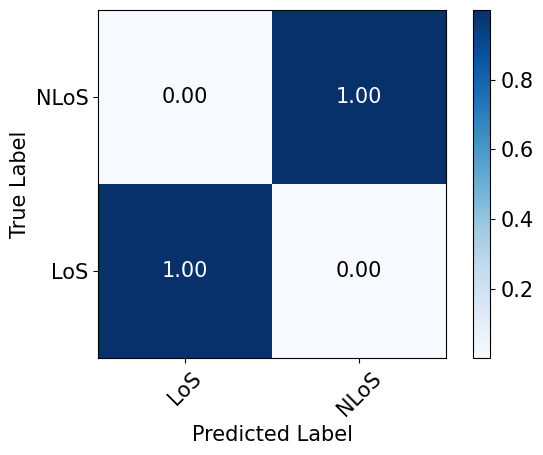

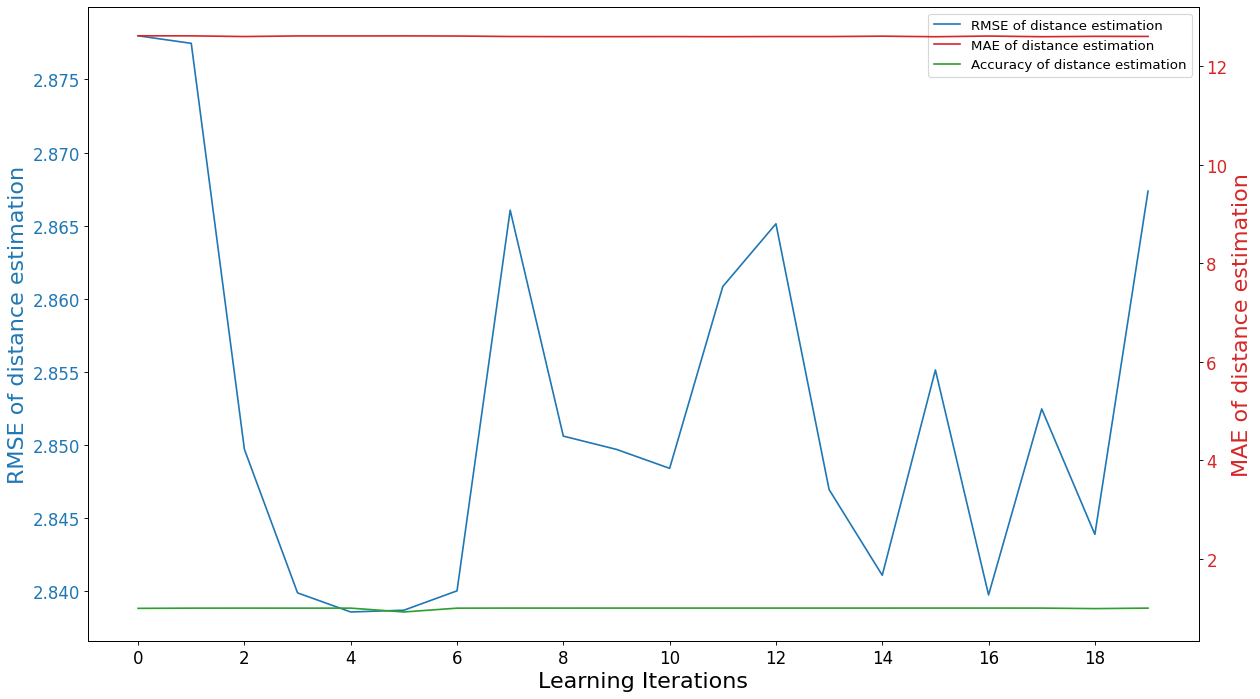

[step = 100] loss: 2.971, ae_loss: 2.772, reg_loss: 0.197, cls_loss: 0.002latent_loss: 0.000, RMSE: 2.769, MAE: 12.595, ACC: 1.000, Recon_err: 0.760, Time (100): 0.175
[step = 200] loss: 2.964, ae_loss: 2.762, reg_loss: 0.201, cls_loss: 0.002latent_loss: 0.000, RMSE: 2.875, MAE: 12.842, ACC: 1.000, Recon_err: 0.753, Time (100): 0.172
Skipping batch with mismatched shapes: (68, 64), (55,)
Skipping batch with mismatched shapes: (68, 64), (55,)
Validation Accuracy: 0.9990923530746539
Validation Precision: 0.9991081380909892
Validation Recall: 0.9985603319686438
Validation F1 Score: 0.9988338203220636
Validation AUROC: 0.9985603319686439

Element Nums of each class:  [1167 3240]

Correct Nums of each class:  [1164 3239]

Accuracy of IIns-VAE of each class: [99.74293059125964, 99.96913580246914]

[Train epoch = 21], loss: 2.954, RMSE: 2.874, MAE: 12.855, ACC: 1.000, Recon_Err: 0.753, Time (100): 0.392,
[Validate] loss_val: 2.953, RMSE_val: 2.847, MAE_val: 12.602, ACC_val: 0.999, Recon_val: 

Finished Training...
   epoch  train_loss                       train_rmse  \
0      1    3.070518  tensor(2.8999, device='cuda:0')   
1      2    2.976719  tensor(2.8781, device='cuda:0')   
2      3    2.964613  tensor(2.8653, device='cuda:0')   
3      4    2.960795  tensor(2.8794, device='cuda:0')   
4      5    2.958780  tensor(2.8916, device='cuda:0')   
5      6    3.069942  tensor(2.8733, device='cuda:0')   
6      7    2.984460  tensor(2.8771, device='cuda:0')   
7      8    2.960149  tensor(2.8753, device='cuda:0')   
8      9    2.956288  tensor(2.8817, device='cuda:0')   
9     10    2.955973  tensor(2.8826, device='cuda:0')   
10    11    2.955306  tensor(2.8722, device='cuda:0')   
11    12    2.953349  tensor(2.8581, device='cuda:0')   
12    13    2.953259  tensor(2.8859, device='cuda:0')   
13    14    2.952802  tensor(2.8768, device='cuda:0')   
14    15    2.952768  tensor(2.8759, device='cuda:0')   
15    16    2.952496  tensor(2.8654, device='cuda:0')   
16    17  

In [ ]:
# Train IIns-VAE
df_iins_vae = train_model_iins(
    model, train_data, valid_data, optimizer, device, opt, model_path, data_path, result_path, scheduler=None,
    integration_level='no-integration', classifier_type='neural', lambda_vae=1, lambda_reg=1, lambda_cls=1, plot_comparison=True
)

print(df_iins_vae)

In [ ]:
!export PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True

In [ ]:
# Evaluate IIns-VAE
args['batch_size'] = 1
device = 'cpu'
model_type = 'IInsVAE'
model.load_state_dict(torch.load(os.path.join(model_path, "%s_%d.pth" % (model_type, opt['test_epoch'])), map_location=device))
model.to(device)
test_results_iins_vae = test_model_iins(
    model, valid_data, device, args, model_path, data_path, result_path,
    integration_level='no-integration', classifier_type='neural', lambda_vae=1, lambda_reg=1, lambda_cls=1, model_preload=True
)
print(f'IIns-VAE results: {test_results_iins_vae}')

#### 7.2.5 Train IIns-VAE Model on Database 2 - Exclude Room

In [ ]:
# Assign data
args['dataset_name'] = 'db2'
args['cls_type'] = 'obstacle'
args['num_classes'] = 5
input_dim = 157
train_data = train_data_exclude_2
valid_data = test_data_exclude_2

# Assign model
model = model_vae

# Assign paths and hyperparameters
args['model_path'] = '/content/drive/MyDrive/WirelessSensing/IIns-MRC/IIns_VAE/model_SL2_exclude'
args['data_path'] = '/content/drive/MyDrive/WirelessSensing/IIns-MRC/IIns_VAE/data_SL2_exclude'
args['result_path'] = '/content/drive/MyDrive/WirelessSensing/IIns-MRC/IIns_VAE/result_SL2_exclude'
os.makedirs(args['model_path'], exist_ok=True)
os.makedirs(args['data_path'], exist_ok=True)
os.makedirs(args['result_path'], exist_ok=True)
model_path = args['model_path']
data_path = args['data_path']
result_path = args['result_path']
opt = args

# Assign optimizer and device
optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'], betas=(args['b1'], args['b2']))
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=args['decay_epoch'], gamma=0.1, last_epoch=-1)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


cuda


In [ ]:
# Normal neural classifier
args['dataset_name'] = 'db2'
input_dim = 157
print(args['dataset_name'])
encoder = Encoder(filters=args['filters'], n_residual=args['n_residual'], n_downsample=args['n_downsample'], range_dim=args['range_dim'], env_dim=args['env_dim'], input_dim=input_dim)
decoder = Decoder(filters=args['filters'], n_residual=args['n_residual'], n_upsample=args['n_downsample'], range_dim=args['range_dim'], env_dim=args['env_dim'], out_dim=input_dim)
regressor = Regressor(range_dim=args['range_dim'])
classifier_base = ClassifierCut(env_dim=args['env_dim'], z_dim=args['z_dim'])
classifier_layer = ClassifierLayer(z_dim=args['z_dim'], num_classes=args['num_classes'])

classifier_mrc_bi = ClassifierMRCs(mrc_type='mrc', phi='linear', loss='0-1')
classifier_mrc_log = ClassifierMRCs(mrc_type='mrc', phi='linear', loss='log')
classifier_cmrc_bi = ClassifierMRCs(mrc_type='cmrc', phi='linear', loss='0-1')
classifier_cmrc_bi_fourier = ClassifierMRCs(mrc_type='cmrc', phi='fourier', loss='0-1')
classifier_cmrc_log_fourier = ClassifierMRCs(mrc_type='cmrc', phi='fourier', loss='log')

# Basic IIns-VAE (baseline)
model_vae = IInsVAEMRC(
    encoder, decoder, regressor, classifier_base, classifier_layer,
    classifier_mrc=None, integration_level='no-integ', classifier_type='neural',
)

# Tune final classifier layer
model_vae_tune_layer = IInsVAEMRC(
    encoder, decoder, regressor, classifier_base, classifier_layer,
    classifier_mrc=None, integration_level='layer', classifier_type='neural'
  )
model_mrc = IInsVAEMRC(
    encoder, decoder, regressor, classifier_base, classifier_layer=None,
    classifier_mrc=classifier_mrc_bi, integration_level='layer', classifier_type='mrc'
  )
model_cmrc = IInsVAEMRC(
    encoder, decoder, regressor, classifier_base, classifier_layer=None,
    classifier_mrc=classifier_cmrc_bi, integration_level='layer', classifier_type='cmrc'
  )

# Tune the whole classifier params
model_vae_tune_bottleneck = IInsVAEMRC(
    encoder, decoder, regressor, classifier_base, classifier_layer,
    classifier_mrc=None, integration_level='bottleneck', classifier_type='neural'
  )
model_mrc_bottleneck = IInsVAEMRC(
    encoder, decoder, regressor, classifier_base, classifier_layer=None,
    classifier_mrc=classifier_mrc_bi, integration_level='bottleneck', classifier_type='mrc'
  )
model_cmrc_bottleneck = IInsVAEMRC(
    encoder, decoder, regressor, classifier_base, classifier_layer=None,
    classifier_mrc=classifier_cmrc_bi, integration_level='bottleneck', classifier_type='cmrc'
  )

# range_code, env_code, x_recon, reg_est, kl_div = model_vae(x, dM)
# cls_pred_vae = model_vae.classify(env_code, labels)

# # Same for MRCs (embed in classify func)
# cls_pred_mrc, upper_bound, lower_bound = model_mrc.classify(env_code, labels)
# cls_pred_cmrc, upper_bound, lower_bound = model_cmrc.classify(env_code, labels)
print(model_vae)

db2
Use 2D Convolutional Encoder for range and env codes.
Use 2D Convolutional Decoder for range and env codes.
Use Linear Regressor for range constraint.
IInsVAEMRC(
  (encoder): Encoder(
    (range_encoder): RangeEncoder2d(
      (init_layers): Sequential(
        (0): Linear(in_features=24649, out_features=4096, bias=True)
        (1): ReLU(inplace=True)
      )
      (model): Sequential(
        (0): ReflectionPad2d((3, 3, 3, 3))
        (1): Conv2d(2, 4, kernel_size=(7, 7), stride=(1, 1))
        (2): InstanceNorm2d(4, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (3): ReLU(inplace=True)
        (4): Conv2d(4, 8, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (5): InstanceNorm2d(8, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (6): ReLU(inplace=True)
        (7): Conv2d(8, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (8): InstanceNorm2d(16, eps=1e-05, momentum=0.1, affine=False, track_running_sta

Memory Usage Before Training: Allocated 6249.95 MB, Reserved 10144.00 MB
Starting Training the IInsVAE...
Total Epochs: 21
[step = 100] loss: 1644.764, ae_loss: 1643.479, reg_loss: 0.103, cls_loss: 1.182latent_loss: 0.000, RMSE: 1.508, MAE: 6.591, ACC: 0.498, Recon_err: 186357.109, Time (100): 0.184
[step = 200] loss: 1643.385, ae_loss: 1642.133, reg_loss: 0.104, cls_loss: 1.148latent_loss: 0.000, RMSE: 1.524, MAE: 6.673, ACC: 0.511, Recon_err: 186158.297, Time (100): 0.180
Skipping batch with mismatched shapes: (100, 64), (51,)
Skipping batch with mismatched shapes: (100, 64), (51,)
Validation Accuracy: 0.5161990389086963
Validation Precision: 0.2118910505836576
Validation Recall: 0.26695232261804497
Validation F1 Score: 0.23595302998532186
Validation AUROC: 0

Element Nums of each class:  [1059 3108    0 1068 1216]

Correct Nums of each class:  [ 423 2907    0    0    0]

Accuracy of IIns-VAE of each class: [39.94334277620396, 93.53281853281852, nan, 0.0, 0.0]

[Train epoch = 1], los

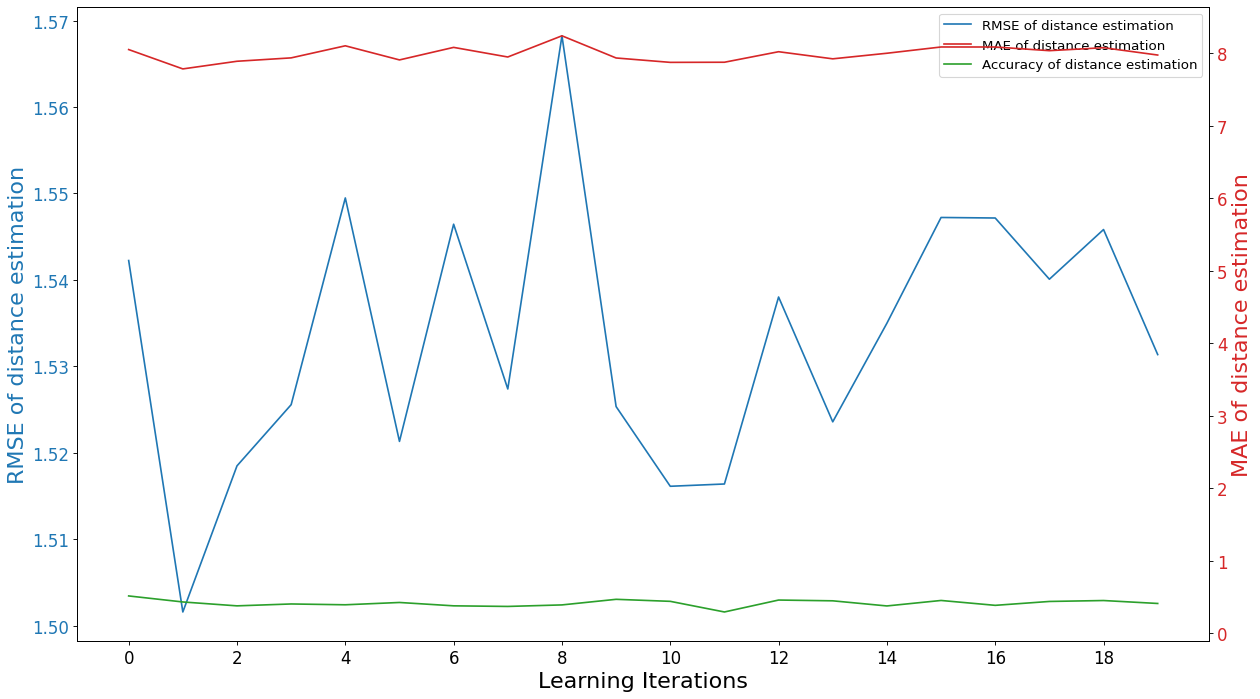

[step = 100] loss: 1641.015, ae_loss: 1640.241, reg_loss: 0.103, cls_loss: 0.671latent_loss: 0.000, RMSE: 1.488, MAE: 6.604, ACC: 0.745, Recon_err: 185787.312, Time (100): 0.185
[step = 200] loss: 1643.712, ae_loss: 1642.925, reg_loss: 0.105, cls_loss: 0.682latent_loss: 0.000, RMSE: 1.529, MAE: 6.741, ACC: 0.741, Recon_err: 186065.031, Time (100): 0.182
Skipping batch with mismatched shapes: (100, 64), (51,)
Skipping batch with mismatched shapes: (100, 64), (51,)
Validation Accuracy: 0.4608587815842505
Validation Precision: 0.3802644863591583
Validation Recall: 0.28675099001546045
Validation F1 Score: 0.2967431549120451
Validation AUROC: 0

Element Nums of each class:  [1059 3108    0 1068 1216]

Correct Nums of each class:  [ 530 2173    0  106  164]

Accuracy of IIns-VAE of each class: [50.04721435316336, 69.91634491634493, nan, 9.925093632958802, 13.486842105263158]

[Train epoch = 21], loss: 1644.673, RMSE: 1.531, MAE: 6.711, ACC: 0.740, Recon_Err: 186688.750, Time (100): 0.259,
[V

Finished Training...
   epoch   train_loss                       train_rmse  \
0      1  1645.174792  tensor(1.5475, device='cuda:0')   
1      2  1644.963362  tensor(1.5381, device='cuda:0')   
2      3  1645.140474  tensor(1.5399, device='cuda:0')   
3      4  1645.004099  tensor(1.5347, device='cuda:0')   
4      5  1644.782989  tensor(1.5430, device='cuda:0')   
5      6  1644.845913  tensor(1.5344, device='cuda:0')   
6      7  1644.777732  tensor(1.5343, device='cuda:0')   
7      8  1644.747352  tensor(1.5404, device='cuda:0')   
8      9  1644.749667  tensor(1.5343, device='cuda:0')   
9     10  1644.783082  tensor(1.5364, device='cuda:0')   
10    11  1644.753233  tensor(1.5327, device='cuda:0')   
11    12  1644.725495  tensor(1.5300, device='cuda:0')   
12    13  1644.664613  tensor(1.5412, device='cuda:0')   
13    14  1644.574962  tensor(1.5334, device='cuda:0')   
14    15  1644.812086  tensor(1.5380, device='cuda:0')   
15    16  1644.579583  tensor(1.5347, device='cuda:

In [ ]:
# Train IIns-VAE
df_iins_vae = train_model_iins(
    model, train_data, valid_data, optimizer, device, opt, model_path, data_path, result_path, scheduler=None,
    integration_level='no-integration', classifier_type='neural', lambda_vae=1, lambda_reg=1, lambda_cls=1, plot_comparison=False
)
print(df_iins_vae)

# # Evaluate IIns-VAE
# test_results_iins_vae = test_model_iins(
#     model, test_data, device, args, model_path, data_path, result_path,
#     integration_level='no-integration', classifier_type='neural', lambda_vae=1, lambda_reg=1, lambda_cls=1,
# )
# print(f'IIns-VAE results: {test_results_iins_vae}')

#### 7.2.6 Train IIns-VAE Model on Database 2 - Random Split

In [ ]:
# Assign data
input_dim = 157
args['dataset_name'] = 'db2'
args['cls_type'] = 'obstacle'
args['num_classes'] = 5
train_data = train_data_split_2
valid_data = test_data_split_2

# Assign model
model = model_vae

# Assign paths and hyperparameters
args['model_path'] = '/content/drive/MyDrive/WirelessSensing/IIns-MRC/IIns_VAE/model_SL2_split'
args['data_path'] = '/content/drive/MyDrive/WirelessSensing/IIns-MRC/IIns_VAE/data_SL2_split'
args['result_path'] = '/content/drive/MyDrive/WirelessSensing/IIns-MRC/IIns_VAE/result_SL2_split'
os.makedirs(args['model_path'], exist_ok=True)
os.makedirs(args['data_path'], exist_ok=True)
os.makedirs(args['result_path'], exist_ok=True)
model_path = args['model_path']
data_path = args['data_path']
result_path = args['result_path']
opt = args

# Assign optimizer and device
optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'], betas=(args['b1'], args['b2']))
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=args['decay_epoch'], gamma=0.1, last_epoch=-1)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


cuda


Memory Usage Before Training: Allocated 4690.26 MB, Reserved 11698.00 MB
Starting Training the IInsVAE...
Total Epochs: 21
[step = 100] loss: 1648.534, ae_loss: 1646.920, reg_loss: 0.110, cls_loss: 1.505latent_loss: 0.000, RMSE: 1.532, MAE: 7.018, ACC: 0.512, Recon_err: 190637.234, Time (100): 0.187
[step = 200] loss: 1643.584, ae_loss: 1642.221, reg_loss: 0.109, cls_loss: 1.253latent_loss: 0.000, RMSE: 1.496, MAE: 6.986, ACC: 0.549, Recon_err: 189956.953, Time (100): 0.183
Skipping batch with mismatched shapes: (65, 64), (7,)
Skipping batch with mismatched shapes: (65, 64), (7,)
Validation Accuracy: 0.45548356131509476
Validation Precision: 0.4479379880762129
Validation Recall: 0.3163816274100047
Validation F1 Score: 0.28463038068929297
Validation AUROC: 0

Element Nums of each class:  [ 937 1559  574  640  457]

Correct Nums of each class:  [ 165 1505  103   20  105]

Accuracy of IIns-VAE of each class: [17.6093916755603, 96.53624118024375, 17.94425087108014, 3.125, 22.97592997811816

[step = 100] loss: 1641.228, ae_loss: 1640.686, reg_loss: 0.112, cls_loss: 0.431latent_loss: 0.000, RMSE: 1.535, MAE: 7.137, ACC: 0.851, Recon_err: 189687.094, Time (100): 0.185
[step = 200] loss: 1643.173, ae_loss: 1642.618, reg_loss: 0.111, cls_loss: 0.445latent_loss: 0.000, RMSE: 1.516, MAE: 7.082, ACC: 0.841, Recon_err: 189910.656, Time (100): 0.182
Skipping batch with mismatched shapes: (65, 64), (7,)
Skipping batch with mismatched shapes: (65, 64), (7,)
Validation Accuracy: 0.7458603311735061
Validation Precision: 0.6966684564591697
Validation Recall: 0.7014734663838023
Validation F1 Score: 0.6969522044689501
Validation AUROC: 0

Element Nums of each class:  [ 937 1559  574  640  457]

Correct Nums of each class:  [ 606 1431  374  374  323]

Accuracy of IIns-VAE of each class: [64.67449306296692, 91.78960872354072, 65.1567944250871, 58.4375, 70.67833698030634]

[Train epoch = 21], loss: 1645.973, RMSE: 1.508, MAE: 7.029, ACC: 0.837, Recon_Err: 191550.688, Time (100): 0.463,
[Vali

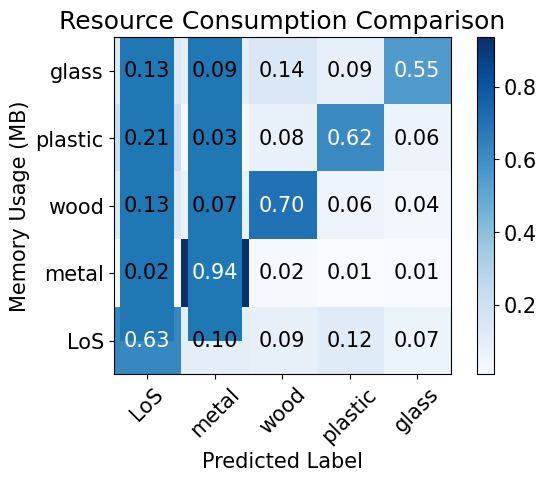

Finished Training...
   epoch   train_loss                       train_rmse  \
0      1  1646.758406  tensor(1.5145, device='cuda:0')   
1      2  1646.169615  tensor(1.5051, device='cuda:0')   
2      3  1646.769402  tensor(1.5158, device='cuda:0')   
3      4  1646.374666  tensor(1.5127, device='cuda:0')   
4      5  1646.333281  tensor(1.5145, device='cuda:0')   
5      6  1646.272528  tensor(1.5103, device='cuda:0')   
6      7  1646.001924  tensor(1.5091, device='cuda:0')   
7      8  1646.594304  tensor(1.5134, device='cuda:0')   
8      9  1646.302418  tensor(1.5081, device='cuda:0')   
9     10  1646.274274  tensor(1.5090, device='cuda:0')   
10    11  1646.296417  tensor(1.5022, device='cuda:0')   
11    12  1646.103457  tensor(1.5060, device='cuda:0')   
12    13  1646.341597  tensor(1.5144, device='cuda:0')   
13    14  1646.214225  tensor(1.5108, device='cuda:0')   
14    15  1645.752287  tensor(1.5106, device='cuda:0')   
15    16  1646.250702  tensor(1.5083, device='cuda:

In [ ]:
# Train IIns-VAE
df_iins_vae = train_model_iins(
    model, train_data, valid_data, optimizer, device, opt, model_path, data_path, result_path, scheduler=None,
    integration_level='no-integration', classifier_type='neural', lambda_vae=1, lambda_reg=1, lambda_cls=1,
)
print(df_iins_vae)

# # Evaluate IIns-VAE
# test_results_iins_vae = test_model_iins(
#     model, test_data, device, args, model_path, data_path, result_path,
#     integration_level='no-integration', classifier_type='neural', lambda_vae=1, lambda_reg=1, lambda_cls=1,
# )
# print(f'IIns-VAE results: {test_results_iins_vae}')

### **7.3 Performance of IIns-MRCs (Last Layer Integration)**

We replace the final classifier layer of IIns-VAE with the MRC. This modification aims to leverage the robust classification capabilities of MRC, which provides both classification results and confidence bounds.

**Method 1: IIns-MRC**
1. Integration:
  + Substitute the last neural layer of the classifier in IIns-VAE with the MRC.
2. Tuning Parameters:
  + Loss Function: '0-1' (with bounds), 'log'.
  + Phi Parameter: 'linear'.
3. Training and Evaluation:
  + Performance on standard metrics, including accuracy, recall, F1 score, etc.
  + Bounds estimation, including true error, MRC bounds, and cross-validation bounds.
4. Expected Results:
  + Robust bounds on classification estimates.
  + Reduced dependency on extensive data for bounds estimation.


#### 7.3.1 Train IIns-MRC Model on Database 1

In [ ]:
# Normal neural classifier
args['dataset_name'] = 'db1'
input_dim = 152
print(args['dataset_name'])
encoder = Encoder(filters=args['filters'], n_residual=args['n_residual'], n_downsample=args['n_downsample'], range_dim=args['range_dim'], env_dim=args['env_dim'], input_dim=input_dim)
decoder = Decoder(filters=args['filters'], n_residual=args['n_residual'], n_upsample=args['n_downsample'], range_dim=args['range_dim'], env_dim=args['env_dim'], out_dim=input_dim)
regressor = Regressor(range_dim=args['range_dim'])
classifier_base = ClassifierCut(env_dim=args['env_dim'], z_dim=args['z_dim'])
classifier_layer = ClassifierLayer(z_dim=args['z_dim'], num_classes=args['num_classes'])

classifier_mrc_bi = ClassifierMRCs(mrc_type='mrc', phi='linear', loss='0-1')
classifier_mrc_log = ClassifierMRCs(mrc_type='mrc', phi='linear', loss='log')
classifier_cmrc_bi = ClassifierMRCs(mrc_type='cmrc', phi='linear', loss='0-1')
classifier_cmrc_bi_fourier = ClassifierMRCs(mrc_type='cmrc', phi='fourier', loss='0-1')
classifier_cmrc_log_fourier = ClassifierMRCs(mrc_type='cmrc', phi='fourier', loss='log')

print(type(classifier_mrc_bi))

db1
Use 2D Convolutional Encoder for range and env codes.
Use 2D Convolutional Decoder for range and env codes.
Use Linear Regressor for range constraint.
<class '__main__.ClassifierMRCs'>


In [ ]:
# Tune final classifier layer
model_mrc = IInsVAEMRC(
    encoder, decoder, regressor, classifier_base, classifier_layer=None,
    classifier_mrc=classifier_mrc_bi, integration_level='layer', classifier_type='mrc',
    loss='0-1', add_bound=True
  )

print(model_mrc)

IInsVAEMRC(
  (encoder): Encoder(
    (range_encoder): RangeEncoder2d(
      (init_layers): Sequential(
        (0): Linear(in_features=23104, out_features=4096, bias=True)
        (1): ReLU(inplace=True)
      )
      (model): Sequential(
        (0): ReflectionPad2d((3, 3, 3, 3))
        (1): Conv2d(2, 4, kernel_size=(7, 7), stride=(1, 1))
        (2): InstanceNorm2d(4, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (3): ReLU(inplace=True)
        (4): Conv2d(4, 8, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (5): InstanceNorm2d(8, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (6): ReLU(inplace=True)
        (7): Conv2d(8, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (8): InstanceNorm2d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (9): ReLU(inplace=True)
        (10): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (11): InstanceNorm2d(32, 

In [ ]:
# Assign data
input_dim = 152
args['dataset_name'] = 'db1'
args['cls_type'] = 'obstacle'
args['num_classes'] = 2
train_data = train_data_1
valid_data = test_data_1

# Assign model
model = model_mrc

# Assign paths and hyperparameters
args['model_path'] = '/content/drive/MyDrive/WirelessSensing/IIns-MRC/IIns_MRC/model_SL1'
args['data_path'] = '/content/drive/MyDrive/WirelessSensing/IIns-MRC/IIns_MRC/data_SL1'
args['result_path'] = '/content/drive/MyDrive/WirelessSensing/IIns-MRC/IIns_MRC/result_SL1'
os.makedirs(args['model_path'], exist_ok=True)
os.makedirs(args['data_path'], exist_ok=True)
os.makedirs(args['result_path'], exist_ok=True)
model_path = args['model_path']
data_path = args['data_path']
result_path = args['result_path']
opt = args

# Assign optimizer and device
optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'], betas=(args['b1'], args['b2']))
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=args['decay_epoch'], gamma=0.1, last_epoch=-1)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


cuda


In [ ]:
 !pip install --upgrade MRCpy

In [ ]:
# Train IIns-MRC
df_iins_mrc = train_model_iins(
    model, train_data, valid_data, optimizer, device, opt, model_path, data_path, result_path, scheduler=None,
    integration_level='layer', classifier_type='mrc', lambda_vae=1, lambda_reg=1, lambda_cls=1,
)
print(df_iins_mrc)

# # Evaluate IIns-MRC
# test_results_iins_mrc = test_model_iins(
#     model, test_data, device, args, model_path, data_path, result_path,
#     integration_level='layer', classifier_type='mrc', lambda_vae=1, lambda_reg=1, lambda_cls=1,
# )
# print(f'IIns-MRC results: {test_results_iins_mrc}')

Memory Usage Before Training: Allocated 14121.55 MB, Reserved 14900.00 MB
Starting Training the IInsVAEMRC...
Total Epochs: 21


OutOfMemoryError: CUDA out of memory. Tried to allocate 362.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 59.06 MiB is free. Process 15766 has 14.69 GiB memory in use. Of the allocated memory 13.80 GiB is allocated by PyTorch, and 771.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

#### 7.3.2 Train IIns-MRC Model on Database 2 - Exclude Room

In [ ]:
# Normal neural classifier
args['dataset_name'] = 'db2'
input_dim = 157
print(args['dataset_name'])
encoder = Encoder(filters=args['filters'], n_residual=args['n_residual'], n_downsample=args['n_downsample'], range_dim=args['range_dim'], env_dim=args['env_dim'], input_dim=input_dim)
decoder = Decoder(filters=args['filters'], n_residual=args['n_residual'], n_upsample=args['n_downsample'], range_dim=args['range_dim'], env_dim=args['env_dim'], out_dim=input_dim)
regressor = Regressor(range_dim=args['range_dim'])
classifier_base = ClassifierCut(env_dim=args['env_dim'], z_dim=args['z_dim'])
classifier_layer = ClassifierLayer(z_dim=args['z_dim'], num_classes=args['num_classes'])

classifier_mrc_bi = ClassifierMRCs(mrc_type='mrc', phi='linear', loss='0-1')
classifier_mrc_log = ClassifierMRCs(mrc_type='mrc', phi='linear', loss='log')
classifier_cmrc_bi = ClassifierMRCs(mrc_type='cmrc', phi='linear', loss='0-1')
classifier_cmrc_bi_fourier = ClassifierMRCs(mrc_type='cmrc', phi='fourier', loss='0-1')
classifier_cmrc_log_fourier = ClassifierMRCs(mrc_type='cmrc', phi='fourier', loss='log')

# Tune final classifier layer
model_mrc = IInsVAEMRC(
    encoder, decoder, regressor, classifier_base, classifier_layer=None,
    classifier_mrc=classifier_mrc_bi, integration_level='layer', classifier_type='mrc'
  )


db2
Use 2D Convolutional Encoder for range and env codes.
Use 2D Convolutional Decoder for range and env codes.
Use Linear Regressor for range constraint.


In [ ]:
# Assign data
input_dim = 157
args['dataset_name'] = 'db2'
args['cls_type'] = 'obstacle'
args['num_classes'] = 5
train_data = train_data_exclude_2
valid_data = test_data_exclude_2

# Assign model
model = model_mrc

# Assign paths and hyperparameters
args['model_path'] = '/content/drive/MyDrive/WirelessSensing/IIns-MRC/IIns_MRC/model_SL2_exclude'
args['data_path'] = '/content/drive/MyDrive/WirelessSensing/IIns-MRC/IIns_MRC/data_SL2_exclude'
args['result_path'] = '/content/drive/MyDrive/WirelessSensing/IIns-MRC/IIns_MRC/result_SL2_exclude'
os.makedirs(args['model_path'], exist_ok=True)
os.makedirs(args['data_path'], exist_ok=True)
os.makedirs(args['result_path'], exist_ok=True)
model_path = args['model_path']
data_path = args['data_path']
result_path = args['result_path']
opt = args

# Assign optimizer and device
optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'], betas=(args['b1'], args['b2']))
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=args['decay_epoch'], gamma=0.1, last_epoch=-1)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


cuda


In [ ]:
# Train IIns-MRC
df_iins_mrc = train_model_iins(
    model, train_data, valid_data, optimizer, device, opt, model_path, data_path, result_path, scheduler=None,
    integration_level='layer', classifier_type='mrc', lambda_vae=1, lambda_reg=1, lambda_cls=1,
)
print(df_iins_mrc)

# # Evaluate IIns-MRC
# test_results_iins_mrc = test_model_iins(
#     model, test_data, device, args, model_path, data_path, result_path,
#     integration_level='layer', classifier_type='mrc', lambda_vae=1, lambda_reg=1, lambda_cls=1,
# )
# print(f'IIns-MRC results: {test_results_iins_vae}')

Memory Usage Before Training: Allocated 7495.03 MB, Reserved 10244.00 MB
Starting Training the IInsVAEMRC...
Total Epochs: 21


ValueError: operands could not be broadcast together with shapes (64,5) (64,4) 

#### 7.3.3 Train IIns-MRC Model on Database 2 - Random Split

In [ ]:
# Assign data
input_dim = 157
args['dataset_name'] = 'db2'
train_data = train_data_split_2
valid_data = test_data_split_2

# Assign model
model = model_mrc

# Assign paths and hyperparameters
args['model_path'] = '/content/drive/MyDrive/WirelessSensing/IIns-MRC/IIns_MRC/model_SL2_split'
args['data_path'] = '/content/drive/MyDrive/WirelessSensing/IIns-MRC/IIns_MRC/data_SL2_split'
args['result_path'] = '/content/drive/MyDrive/WirelessSensing/IIns-MRC/IIns_MRC/result_SL2_split'
os.makedirs(args['model_path'], exist_ok=True)
os.makedirs(args['data_path'], exist_ok=True)
os.makedirs(args['result_path'], exist_ok=True)
model_path = args['model_path']
data_path = args['data_path']
result_path = args['result_path']
opt = args

# Assign optimizer and device
optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'], betas=(args['b1'], args['b2']))
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=args['decay_epoch'], gamma=0.1, last_epoch=-1)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


cuda


In [ ]:
# Train IIns-MRC
df_iins_mrc = train_model_iins(
    model, train_data, valid_data, optimizer, device, opt, model_path, data_path, result_path, scheduler=None,
    integration_level='layer', classifier_type='mrc', lambda_vae=1, lambda_reg=1, lambda_cls=1,
)
print(df_iins_mrc)

# # Evaluate IIns-MRC
# test_results_iins_mrc = test_model_iins(
#     model, test_data, device, args, model_path, data_path, result_path,
#     integration_level='layer', classifier_type='mrc', lambda_vae=1, lambda_reg=1, lambda_cls=1,
# )
# print(f'IIns-MRC results: {test_results_iins_vae}')

Memory Usage Before Training: Allocated 9963.60 MB, Reserved 12602.00 MB
Starting Training the IInsVAEMRC...
Total Epochs: 21
[step = 200] loss: 2063.956, ae_loss: 1647.490, reg_loss: 0.137, cls_loss: 416.329latent_loss: 0.000, RMSE: 1.759, MAE: 8.781, ACC: 0.224, Recon_err: 190677.297, Time (100): 1.788


ValueError: operands could not be broadcast together with shapes (7,5) (7,3) 

### **7.4 Performance of IIns-CMRCs with Last Layer Integration**

**Method 2: IIns-CMRC (Constrained MRC)**

1. Integration:
  + Substitute the last neural layer with CMRC.
2. Tuning Parameters:
  + Loss Function: '0-1' (with bounds) and 'log'.
  + Phi Parameter: 'linear'.
3. Training and Evaluation:
  + Train and evaluate performance and efficiency.
  + Bounds estimation for `loss=0-1`.

4. Expected Results:
  + Faster training times.
  + Improved performance without bounds estimation.


#### 7.4.1 Train IIns-CMRC Model on Database 1

In [ ]:
def get_args():
    args = {
        # 1. Learning Parameters
        'start_epoch': 0,
        'n_epochs': 21,
        'test_epoch': 20,
        'batch_size': 64,
        'lr': 0.0002,
        'b1': 0.5,
        'b2': 0.999,
        'decay_epoch': 100,
        'n_cpu': 8,

        # 2. Dataset Parameters
        'dataset_name': "db2",
        'dataset_env': 'part',
        'est_type': 'mitigation',
        'cls_type': 'obstacle',
        'split_factor': 0.8,
        'num_classes': 5,

        # 3. Network Parameters
        'n_downsample': 4,
        'n_residual': 3,
        'filters': 4,
        'range_dim': 16,
        'env_dim': 16,
        'z_dim': 256,

        # 4. MRC/CMRC Specific Parameters
        'loss_type': '0-1',
        'phi_type': 'linear',
        'integration_level': 'layer',  # layer, bottleneck, or no-integration
        'classifier_type': 'mrc',  # mrc, cmrc, or neural

        # 5. Visualization Parameters
        'sample_interval': 20,
        'checkpoint_interval': 20,
        'visual_method': "t-sne",
        'visual_dim': 2,
        'encircle_flag': False,

        # 6. Essential Paths
        'model_path': './models',
        'data_path': './data',
        'result_path': './results'
    }
    return args

args = get_args()

In [ ]:
# Normal neural classifier
args['dataset_name'] = 'db1'
input_dim = 152
print(args['dataset_name'])
encoder = Encoder(filters=args['filters'], n_residual=args['n_residual'], n_downsample=args['n_downsample'], range_dim=args['range_dim'], env_dim=args['env_dim'], input_dim=input_dim)
decoder = Decoder(filters=args['filters'], n_residual=args['n_residual'], n_upsample=args['n_downsample'], range_dim=args['range_dim'], env_dim=args['env_dim'], out_dim=input_dim)
regressor = Regressor(range_dim=args['range_dim'])
classifier_base = ClassifierCut(env_dim=args['env_dim'], z_dim=args['z_dim'])
classifier_layer = ClassifierLayer(z_dim=args['z_dim'], num_classes=args['num_classes'])

classifier_mrc_bi = ClassifierMRCs(mrc_type='mrc', phi='linear', loss='0-1')
classifier_mrc_log = ClassifierMRCs(mrc_type='mrc', phi='linear', loss='log')
classifier_cmrc_bi = ClassifierMRCs(mrc_type='cmrc', phi='linear', loss='0-1')
classifier_cmrc_bi_fourier = ClassifierMRCs(mrc_type='cmrc', phi='fourier', loss='0-1')
classifier_cmrc_log_fourier = ClassifierMRCs(mrc_type='cmrc', phi='fourier', loss='log')

model_cmrc = IInsVAEMRC(
    encoder, decoder, regressor, classifier_base, classifier_layer=None,
    classifier_mrc=classifier_cmrc_bi, integration_level='layer', classifier_type='cmrc'
  )
print(model_cmrc)

In [ ]:
# Assign data
input_dim = 152
args['dataset_name'] = 'db1'
args['cls_type'] = 'obstacle'
args['num_classes'] = 2
train_data = train_data_1
valid_data = test_data_1

# Assign model
model = model_cmrc

# Assign paths and hyperparameters
args['model_path'] = '/content/drive/MyDrive/WirelessSensing/IIns-MRC/IIns_CMRC/model_SL1'
args['data_path'] = '/content/drive/MyDrive/WirelessSensing/IIns-MRC/IIns_CMRC/data_SL1'
args['result_path'] = '/content/drive/MyDrive/WirelessSensing/IIns-MRC/IIns_CMRC/result_SL1'
os.makedirs(args['model_path'], exist_ok=True)
os.makedirs(args['data_path'], exist_ok=True)
os.makedirs(args['result_path'], exist_ok=True)
model_path = args['model_path']
data_path = args['data_path']
result_path = args['result_path']
opt = args

# Assign optimizer and device
optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'], betas=(args['b1'], args['b2']))
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=args['decay_epoch'], gamma=0.1, last_epoch=-1)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


In [ ]:
# Train IIns-CMRC
df_iins_cmrc = train_model_iins(
    model, train_data, valid_data, optimizer, device, opt, model_path, data_path, result_path, scheduler=None,
    integration_level='layer', classifier_type='cmrc', lambda_vae=1, lambda_reg=1, lambda_cls=1,
)
print(df_iins_cmrc)

# # Evaluate IIns-CMRC
# test_results_iins_cmrc = test_model_iins(
#     model, test_data, device, args, model_path, data_path, result_path,
#     integration_level='layer', classifier_type='cmrc', lambda_vae=1, lambda_reg=1, lambda_cls=1,
# )
# print(f'IIns-CMRC results: {test_results_iins_cmrc}')

#### 7.4.2 Train IIns-CMRC Model on Database 2 - Exclude Room

In [ ]:
# Normal neural classifier
args['dataset_name'] = 'db2'
input_dim = 157
print(args['dataset_name'])
encoder = Encoder(filters=args['filters'], n_residual=args['n_residual'], n_downsample=args['n_downsample'], range_dim=args['range_dim'], env_dim=args['env_dim'], input_dim=input_dim)
decoder = Decoder(filters=args['filters'], n_residual=args['n_residual'], n_upsample=args['n_downsample'], range_dim=args['range_dim'], env_dim=args['env_dim'], out_dim=input_dim)
regressor = Regressor(range_dim=args['range_dim'])
classifier_base = ClassifierCut(env_dim=args['env_dim'], z_dim=args['z_dim'])
classifier_layer = ClassifierLayer(z_dim=args['z_dim'], num_classes=args['num_classes'])

classifier_mrc_bi = ClassifierMRCs(mrc_type='mrc', phi='linear', loss='0-1')
classifier_mrc_log = ClassifierMRCs(mrc_type='mrc', phi='linear', loss='log')
classifier_cmrc_bi = ClassifierMRCs(mrc_type='cmrc', phi='linear', loss='0-1')
classifier_cmrc_bi_fourier = ClassifierMRCs(mrc_type='cmrc', phi='fourier', loss='0-1')
classifier_cmrc_log_fourier = ClassifierMRCs(mrc_type='cmrc', phi='fourier', loss='log')

model_cmrc = IInsVAEMRC(
    encoder, decoder, regressor, classifier_base, classifier_layer=None,
    classifier_mrc=classifier_cmrc_bi, integration_level='layer', classifier_type='cmrc'
  )


In [ ]:
# Assign data
input_dim = 157
args['dataset_name'] = 'db2'
args['cls_type'] = 'obstacle'
args['num_classes'] = 5
train_data = train_data_exclude_2
valid_data = test_data_exclude_2

# Assign model
model = model_cmrc

# Assign paths and hyperparameters
args['model_path'] = '/content/drive/MyDrive/WirelessSensing/IIns-MRC/IIns_CMRC/model_SL2_exclude'
args['data_path'] = '/content/drive/MyDrive/WirelessSensing/IIns-MRC/IIns_CMRC/data_SL2_exclude'
args['result_path'] = '/content/drive/MyDrive/WirelessSensing/IIns-MRC/IIns_CMRC/result_SL2_exclude'
os.makedirs(args['model_path'], exist_ok=True)
os.makedirs(args['data_path'], exist_ok=True)
os.makedirs(args['result_path'], exist_ok=True)
model_path = args['model_path']
data_path = args['data_path']
result_path = args['result_path']
opt = args

# Assign optimizer and device
optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'], betas=(args['b1'], args['b2']))
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=args['decay_epoch'], gamma=0.1, last_epoch=-1)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


In [ ]:
# Train IIns-CMRC
df_iins_cmrc = train_model_iins(
    model, train_data, valid_data, optimizer, device, opt, model_path, data_path, result_path, scheduler=None,
    integration_level='layer', classifier_type='cmrc', lambda_vae=1, lambda_reg=1, lambda_cls=1,
)
print(df_iins_cmrc)

# # Evaluate IIns-CMRC
# test_results_iins_cmrc = test_model_iins(
#     model, test_data, device, args, model_path, data_path, result_path,
#     integration_level='layer', classifier_type='cmrc', lambda_vae=1, lambda_reg=1, lambda_cls=1,
# )
# print(f'IIns-CMRC results: {test_results_iins_cmrc}')

#### 7.4.3 Train IIns-CMRC Model on Database 2 - Random Split

In [ ]:
# Assign data
input_dim = 157
args['dataset_name'] = 'db2'
args['cls_type'] = 'obstacle'
args['num_classes'] = 5
train_data = train_data_split_2
valid_data = test_data_split_2

# Assign model
model = model_cmrc

# Assign paths and hyperparameters
args['model_path'] = '/content/drive/MyDrive/WirelessSensing/IIns-MRC/IIns_CMRC/model_SL2_split'
args['data_path'] = '/content/drive/MyDrive/WirelessSensing/IIns-MRC/IIns_CMRC/data_SL2_split'
args['result_path'] = '/content/drive/MyDrive/WirelessSensing/IIns-MRC/IIns_CMRC/result_SL2_split'
os.makedirs(args['model_path'], exist_ok=True)
os.makedirs(args['data_path'], exist_ok=True)
os.makedirs(args['result_path'], exist_ok=True)
model_path = args['model_path']
data_path = args['data_path']
result_path = args['result_path']
opt = args

# Assign optimizer and device
optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'], betas=(args['b1'], args['b2']))
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=args['decay_epoch'], gamma=0.1, last_epoch=-1)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


In [ ]:
# Train IIns-CMRC
df_iins_cmrc = train_model_iins(
    model, train_data, valid_data, optimizer, device, opt, model_path, data_path, result_path, scheduler=None,
    integration_level='layer', classifier_type='cmrc', lambda_vae=1, lambda_reg=1, lambda_cls=1,
)
print(df_iins_cmrc)

# # Evaluate IIns-CMRC
# test_results_iins_cmrc = test_model_iins(
#     model, test_data, device, args, model_path, data_path, result_path,
#     integration_level='layer', classifier_type='cmrc', lambda_vae=1, lambda_reg=1, lambda_cls=1,
# )
# print(f'IIns-CMRC results: {test_results_iins_cmrc}')

### **7.5 IIns-CMRCs with Bottleneck Integration**

We replace the whole classifier of IIns-VAE with the CMRC.

**Method 3: IIns-BottleneckCMRC**

1. Integration:
  + Replace the entire classifier module in IIns-VAE with CMRC.
2. Tuning Parameters:
  + Loss Function: '0-1' (with bounds) and 'log'.
  + Phi Parameter: 'fourier'.
3. Training and Evaluation:
  + Train and evaluate end-to-end performance and efficiency.
  + Bounds estimation for `loss=0-1`.

4. Expected Results:
  + Simplified architecture.
  + Efficient classification performance.


#### 7.5.1 Train Bottleneck IIns-CMRC Model on Database 1

In [ ]:
# Normal neural classifier
args['dataset_name'] = 'db1'
input_dim = 152
print(args['dataset_name'])
encoder = Encoder(filters=args['filters'], n_residual=args['n_residual'], n_downsample=args['n_downsample'], range_dim=args['range_dim'], env_dim=args['env_dim'], input_dim=input_dim)
decoder = Decoder(filters=args['filters'], n_residual=args['n_residual'], n_upsample=args['n_downsample'], range_dim=args['range_dim'], env_dim=args['env_dim'], out_dim=input_dim)
regressor = Regressor(range_dim=args['range_dim'])
classifier_base = ClassifierCut(env_dim=args['env_dim'], z_dim=args['z_dim'])
classifier_layer = ClassifierLayer(z_dim=args['z_dim'], num_classes=args['num_classes'])

classifier_mrc_bi = ClassifierMRCs(mrc_type='mrc', phi='linear', loss='0-1')
classifier_mrc_log = ClassifierMRCs(mrc_type='mrc', phi='linear', loss='log')
classifier_cmrc_bi = ClassifierMRCs(mrc_type='cmrc', phi='linear', loss='0-1')
classifier_cmrc_bi_fourier = ClassifierMRCs(mrc_type='cmrc', phi='fourier', loss='0-1')
classifier_cmrc_log_fourier = ClassifierMRCs(mrc_type='cmrc', phi='fourier', loss='log')

# Tune the whole classifier params
model_mrc_bottleneck = IInsVAEMRC(
    encoder, decoder, regressor, classifier_base, classifier_layer=None,
    classifier_mrc=classifier_mrc_bi, integration_level='bottleneck', classifier_type='mrc'
  )
model_cmrc_bottleneck = IInsVAEMRC(
    encoder, decoder, regressor, classifier_base, classifier_layer=None,
    classifier_mrc=classifier_cmrc_bi, integration_level='bottleneck', classifier_type='cmrc'
  )

# range_code, env_code, x_recon, reg_est, kl_div = model_vae(x, dM)
# cls_pred_vae = model_vae.classify(env_code, labels)

# # Same for MRCs (embed in classify func)
# cls_pred_mrc, upper_bound, lower_bound = model_mrc.classify(env_code, labels)
# cls_pred_cmrc, upper_bound, lower_bound = model_cmrc.classify(env_code, labels)
print(model_cmrc_bottleneck)

In [ ]:
# Assign data
input_dim = 152
args['dataset_name'] = 'db1'
args['cls_type'] = 'obstacle'
args['num_classes'] = 2
train_data = train_data_1
valid_data = test_data_1

# Assign model
model = model_cmrc_bottleneck

# Assign paths and hyperparameters
args['model_path'] = '/content/drive/MyDrive/WirelessSensing/IIns-MRC/IIns_CMRC_Bottleneck/model_SL1'
args['data_path'] = '/content/drive/MyDrive/WirelessSensing/IIns-MRC/IIns_CMRC_Bottleneck/data_SL1'
args['result_path'] = '/content/drive/MyDrive/WirelessSensing/IIns-MRC/IIns_CMRC_Bottleneck/result_SL1'
os.makedirs(args['model_path'], exist_ok=True)
os.makedirs(args['data_path'], exist_ok=True)
os.makedirs(args['result_path'], exist_ok=True)
model_path = args['model_path']
data_path = args['data_path']
result_path = args['result_path']
opt = args

# Assign optimizer and device
optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'], betas=(args['b1'], args['b2']))
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=args['decay_epoch'], gamma=0.1, last_epoch=-1)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


In [ ]:
# Train IIns-CMRC
df_iins_cmrc_bottleneck = train_model_iins(
    model, train_data, valid_data, optimizer, device, opt, model_path, data_path, result_path, scheduler=None,
    integration_level='bottleneck', classifier_type='cmrc', lambda_vae=1, lambda_reg=1, lambda_cls=1,
)
print(df_iins_cmrc_bottleneck)

# # Evaluate IIns-CMRC
# test_results_iins_cmrc_bottleneck = test_model_iins(
#     model, test_data, device, args, model_path, data_path, result_path,
#     integration_level='bottleneck', classifier_type='cmrc', lambda_vae=1, lambda_reg=1, lambda_cls=1,
# )
# print(f'Bottleneck IIns-CMRC results: {test_results_iins_cmrc_bottleneck}')

#### 7.5.2 Train Bottleneck IIns-CMRC Model on Database 2 - Exclude Room

In [ ]:
# Normal neural classifier
args['dataset_name'] = 'db2'
input_dim = 157
print(args['dataset_name'])
encoder = Encoder(filters=args['filters'], n_residual=args['n_residual'], n_downsample=args['n_downsample'], range_dim=args['range_dim'], env_dim=args['env_dim'], input_dim=input_dim)
decoder = Decoder(filters=args['filters'], n_residual=args['n_residual'], n_upsample=args['n_downsample'], range_dim=args['range_dim'], env_dim=args['env_dim'], out_dim=input_dim)
regressor = Regressor(range_dim=args['range_dim'])
classifier_base = ClassifierCut(env_dim=args['env_dim'], z_dim=args['z_dim'])
classifier_layer = ClassifierLayer(z_dim=args['z_dim'], num_classes=args['num_classes'])

classifier_mrc_bi = ClassifierMRCs(mrc_type='mrc', phi='linear', loss='0-1')
classifier_mrc_log = ClassifierMRCs(mrc_type='mrc', phi='linear', loss='log')
classifier_cmrc_bi = ClassifierMRCs(mrc_type='cmrc', phi='linear', loss='0-1')
classifier_cmrc_bi_fourier = ClassifierMRCs(mrc_type='cmrc', phi='fourier', loss='0-1')
classifier_cmrc_log_fourier = ClassifierMRCs(mrc_type='cmrc', phi='fourier', loss='log')

# Tune the whole classifier params
model_mrc_bottleneck = IInsVAEMRC(
    encoder, decoder, regressor, classifier_base, classifier_layer=None,
    classifier_mrc=classifier_mrc_bi, integration_level='bottleneck', classifier_type='mrc'
  )
model_cmrc_bottleneck = IInsVAEMRC(
    encoder, decoder, regressor, classifier_base, classifier_layer=None,
    classifier_mrc=classifier_cmrc_bi, integration_level='bottleneck', classifier_type='cmrc'
  )

# range_code, env_code, x_recon, reg_est, kl_div = model_vae(x, dM)
# cls_pred_vae = model_vae.classify(env_code, labels)

# # Same for MRCs (embed in classify func)
# cls_pred_mrc, upper_bound, lower_bound = model_mrc.classify(env_code, labels)
# cls_pred_cmrc, upper_bound, lower_bound = model_cmrc.classify(env_code, labels)
print(model_cmrc_bottleneck)

In [ ]:
# Assign data
input_dim = 157
args['dataset_name'] = 'db2'
args['cls_type'] = 'obstacle'
args['num_classes'] = 5
train_data = train_data_exclude_2
valid_data = test_data_exclude_2

# Assign model
model = model_cmrc_bottleneck

# Assign paths and hyperparameters
args['model_path'] = '/content/drive/MyDrive/WirelessSensing/IIns-MRC/IIns_CMRC_Bottleneck/model_SL2_exclude'
args['data_path'] = '/content/drive/MyDrive/WirelessSensing/IIns-MRC/IIns_CMRC_Bottleneck/data_SL2_exclude'
args['result_path'] = '/content/drive/MyDrive/WirelessSensing/IIns-MRC/IIns_CMRC_Bottleneck/result_SL2_exclude'
os.makedirs(args['model_path'], exist_ok=True)
os.makedirs(args['data_path'], exist_ok=True)
os.makedirs(args['result_path'], exist_ok=True)
model_path = args['model_path']
data_path = args['data_path']
result_path = args['result_path']
opt = args

# Assign optimizer and device
optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'], betas=(args['b1'], args['b2']))
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=args['decay_epoch'], gamma=0.1, last_epoch=-1)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


In [ ]:
# Train IIns-CMRC
df_iins_cmrc_bottleneck = train_model_iins(
    model, train_data, valid_data, optimizer, device, opt, model_path, data_path, result_path, scheduler=None,
    integration_level='bottleneck', classifier_type='cmrc', lambda_vae=1, lambda_reg=1, lambda_cls=1,
)
print(df_iins_cmrc_bottleneck)

# # Evaluate IIns-CMRC
# test_results_iins_cmrc_bottleneck = test_model_iins(
#     model, test_data, device, args, model_path, data_path, result_path,
#     integration_level='bottleneck', classifier_type='cmrc', lambda_vae=1, lambda_reg=1, lambda_cls=1,
# )
# print(f'Bottleneck IIns-CMRC results: {test_results_iins_cmrc_bottleneck}')

#### 7.4.3 Train Bottleneck IIns-CMRC Model on Database 2 - Random Split

In [ ]:
# Assign data
input_dim = 157
args['dataset_name'] = 'db2'
args['cls_type'] = 'obstacle'
args['num_classes'] = 5
train_data = train_data_split_2
valid_data = test_data_split_2

# Assign model
model = model_cmrc_bottleneck

# Assign paths and hyperparameters
args['model_path'] = '/content/drive/MyDrive/WirelessSensing/IIns-MRC/IIns_CMRC_Bottleneck/model_SL2_split'
args['data_path'] = '/content/drive/MyDrive/WirelessSensing/IIns-MRC/IIns_CMRC_Bottleneck/data_SL2_split'
args['result_path'] = '/content/drive/MyDrive/WirelessSensing/IIns-MRC/IIns_CMRC_Bottleneck/result_SL2_split'
os.makedirs(args['model_path'], exist_ok=True)
os.makedirs(args['data_path'], exist_ok=True)
os.makedirs(args['result_path'], exist_ok=True)
model_path = args['model_path']
data_path = args['data_path']
result_path = args['result_path']
opt = args

# Assign optimizer and device
optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'], betas=(args['b1'], args['b2']))
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=args['decay_epoch'], gamma=0.1, last_epoch=-1)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


In [ ]:
# Train IIns-CMRC
df_iins_cmrc_bottleneck = train_model_iins(
    model, train_data, valid_data, optimizer, device, opt, model_path, data_path, result_path, scheduler=None,
    integration_level='bottleneck', classifier_type='cmrc', lambda_vae=1, lambda_reg=1, lambda_cls=1,
)
print(df_iins_cmrc_bottleneck)

# # Evaluate IIns-CMRC
# test_results_iins_cmrc_bottleneck = test_model_iins(
#     model, test_data, device, args, model_path, data_path, result_path,
#     integration_level='bottleneck', classifier_type='cmrc', lambda_vae=1, lambda_reg=1, lambda_cls=1,
# )
# print(f'Bottleneck IIns-CMRC results: {test_results_iins_cmrc_bottleneck}')

## **8. Experimental Results on Transfer Learning**

Prepare data.

In [40]:
# Database 1
train_data_path_1 = '/content/drive/MyDrive/WirelessSensing/Data/data_ewine/SL1-train_data.pkl'
test_data_path_1 = '/content/drive/MyDrive/WirelessSensing/Data/data_ewine/SL1-test_data.pkl'
if os.path.exists(train_data_path_1) and os.path.exists(test_data_path_1):
    print(f"Loading data from {train_data_path_1} and {test_data_path_1}")
    # Load data
    with open(train_data_path_1, 'rb') as f:
        train_data_1 = pickle.load(f)
    with open(test_data_path_1, 'rb') as f:
        test_data_1 = pickle.load(f)
else:
    print(f"No data saved to {train_data_path_1} and {test_data_path_1}")

train_dataset_1 = UWBDataset(train_data_1)
test_dataset_1 = UWBDataset(test_data_1)

train_loader_1 = DataLoader(train_dataset_1, batch_size=32, shuffle=True)
test_loader_1 = DataLoader(test_dataset_1, batch_size=32, shuffle=False)

for batch in train_loader_1:
    print(batch['CIR'].shape)
    print(batch['Error'].shape)
    print(batch['Label'].shape)
    print(batch['MeasuredDistance'].shape)
    print(batch['TrueDistance'].shape)
    print(batch['RoomLabel'].shape)
    print(batch)
    break

# Database 1 for transfer learning (source domain: db 1-1 and db 1-2, target domain: specific room from db 1-2)
train_data_source_path_1 = '/content/drive/MyDrive/WirelessSensing/Data/data_ewine/TF1-train_data_source.pkl'
if os.path.exists(train_data_source_path_1):
    print(f"Loading data from {train_data_source_path_1}")
    # Load data
    with open(train_data_source_path_1, 'rb') as f:
        train_data_source_1 = pickle.load(f)
else:
    print(f"No data saved to {train_data_source_path_1}")

train_data_target_path_1 = '/content/drive/MyDrive/WirelessSensing/Data/data_ewine/TF1-train_data_target.pkl'
test_data_target_path_1 = '/content/drive/MyDrive/WirelessSensing/Data/data_ewine/TF1-test_data_target.pkl'
if os.path.exists(train_data_target_path_1) and os.path.exists(test_data_target_path_1):
    print(f"Loading data from {train_data_target_path_1} and {test_data_target_path_1}")
    # Load data
    with open(train_data_target_path_1, 'rb') as f:
        train_data_target_1 = pickle.load(f)
    with open(test_data_target_path_1, 'rb') as f:
        test_data_target_1 = pickle.load(f)
else:
    print(f"No data saved to {train_data_target_path_1} and {test_data_target_path_1}")

train_loader_source_1 = DataLoader(UWBDataset(train_data_source_1), batch_size=32, shuffle=True)

train_loader_target_1 = DataLoader(UWBDataset(train_data_target_1), batch_size=32, shuffle=True)
test_loader_target_1 = DataLoader(UWBDataset(test_data_target_1), batch_size=32, shuffle=False)

for batch in train_loader_source_1:
    print(batch['CIR'].shape)
    print(batch['Error'].shape)
    print(batch['Label'].shape)
    print(batch)
    break

for batch in train_loader_target_1:
    print(batch['CIR'].shape)
    print(batch['Error'].shape)
    print(batch['Label'].shape)
    print(batch)
    break

# Database 2
train_data_exclude_path_2 = '/content/drive/MyDrive/WirelessSensing/Data/data_zenodo/SL2-train_data_exclude.pkl'
test_data_exclude_path_2 = '/content/drive/MyDrive/WirelessSensing/Data/data_zenodo/SL2-test_data_exclude.pkl'
if os.path.exists(train_data_exclude_path_2) and os.path.exists(test_data_exclude_path_2):
    print(f"Loading data from {train_data_exclude_path_2} and {test_data_exclude_path_2}")
    # Load data
    with open(train_data_exclude_path_2, 'rb') as f:
        train_data_exclude_2 = pickle.load(f)
    with open(test_data_exclude_path_2, 'rb') as f:
        test_data_exclude_2 = pickle.load(f)
else:
    print(f"No data saved to {train_data_exclude_path_2} and {test_data_exclude_path_2}")

train_dataset_exclude_2 = UWBDataset(train_data_exclude_2)
test_dataset_exclude_2 = UWBDataset(test_data_exclude_2)

train_loader_exclude_2 = DataLoader(train_dataset_exclude_2, batch_size=batch_size, shuffle=True)
test_loader_exclude_2 = DataLoader(test_dataset_exclude_2, batch_size=batch_size, shuffle=False)

for batch in train_loader_exclude_2:
    print(batch['CIR'].shape)
    print(batch['Error'].shape)
    print(batch['Label'].shape)
    print(batch)
    break

# condition 2: Simple random split using train_test_split
train_data_split_path_2 = '/content/drive/MyDrive/WirelessSensing/Data/data_zenodo/SL3-train_data_split.pkl'
test_data_split_path_2 = '/content/drive/MyDrive/WirelessSensing/Data/data_zenodo/SL3-test_data_split.pkl'
if os.path.exists(train_data_split_path_2) and os.path.exists(test_data_split_path_2):
    print(f"Loading data from {train_data_split_path_2} and {test_data_split_path_2}")
    # Load data
    with open(train_data_split_path_2, 'rb') as f:
        train_data_split_2 = pickle.load(f)
    with open(test_data_split_path_2, 'rb') as f:
        test_data_split_2 = pickle.load(f)
else:
    print(f"No data saved to {train_data_split_path_2} and {test_data_split_path_2}")

train_dataset_split_2 = UWBDataset(train_data_split_2)
test_dataset_split_2 = UWBDataset(test_data_split_2)

batch_size = 32
train_loader_split_2 = DataLoader(train_dataset_split_2, batch_size=batch_size, shuffle=True)
test_loader_split_2 = DataLoader(test_dataset_split_2, batch_size=batch_size, shuffle=False)

for batch in train_loader_split_2:
    print(batch['CIR'].shape)
    print(batch['Error'].shape)
    print(batch['Label'].shape)
    print(batch)
    break

# transfer learning for db2
# scenario 2: High to Low Label Resolutions
high_res_labels = {
    '0000000000': 0, '0000000001': 1, '0000000010': 2, '0000000100': 3, '0000001000': 4,
    '0000010000': 5, '0000100000': 6, '0001000000': 7, '0010000000': 8, '0100000000': 9, '1000000000': 10
}
low_res_labels = {
    0: 'LoS', 1: 'Metal', 2: 'Plastic', 3: 'Wood', 4: 'Glass'
}

def map_to_low_res(label):
    if label in [0]:
        return 0  # LoS
    elif label in [1, 4, 5]:
        return 1  # Metal
    elif label in [6, 7]:
        return 2  # Plastic
    elif label in [3, 8]:
        return 3  # Wood
    elif label in [2, 9]:
        return 4  # Glass
    else:
        return -1  # Unknown

source_data_high_res_path_2 = '/content/drive/MyDrive/WirelessSensing/Data/data_zenodo/TF2-source_data_high_res.pkl'
target_data_low_res_train_path_2 = '/content/drive/MyDrive/WirelessSensing/Data/data_zenodo/TF2-target_train_dataset_low_res.pkl'
target_data_low_res_test_path_2 = '/content/drive/MyDrive/WirelessSensing/Data/data_zenodo/TF2-target_test_dataset_low_res.pkl'
if os.path.exists(source_data_high_res_path_2) and os.path.exists(target_data_low_res_train_path_2) and os.path.exists(target_data_low_res_test_path_2):
    print(f"Loading data from {source_data_high_res_path_2} and {target_data_low_res_train_path_2}, {target_data_low_res_test_path_2}")
    # Load data
    with open(source_data_high_res_path_2, 'rb') as f:
        source_data_high_res_2 = pickle.load(f)
    with open(target_data_low_res_train_path_2, 'rb') as f:
        target_data_low_res_train_2 = pickle.load(f)
    with open(target_data_low_res_test_path_2, 'rb') as f:
        target_data_low_res_test_2 = pickle.load(f)
else:
    print(f"No data saved to {source_data_high_res_path_2} and {target_data_low_res_train_path_2}, {target_data_low_res_test_path_2}")

source_dataset_high_res_2 = UWBDataset(source_data_high_res_2)
target_train_dataset_low_res_2 = UWBDataset(target_data_low_res_train_2)
target_test_dataset_low_res_2 = UWBDataset(target_data_low_res_test_2)

batch_size = 32
source_loader_high_res_2 = DataLoader(source_dataset_high_res_2, batch_size=batch_size, shuffle=True)
target_loader_low_res_train_2 = DataLoader(target_train_dataset_low_res_2, batch_size=batch_size, shuffle=True)
target_loader_low_res_test_2 = DataLoader(target_test_dataset_low_res_2, batch_size=batch_size, shuffle=False)

for batch in source_loader_high_res_2:
    print(batch['CIR'].shape)
    print(batch['Error'].shape)
    print(batch['Label'].shape)
    print(batch)
    break

# scenario 3: Mixed to Specific Environment (RoomLabel =1)
source_dataset_mixed_env_path_3 = '/content/drive/MyDrive/WirelessSensing/Data/data_zenodo/TF3-source_data_mixed_env.pkl'
target_train_dataset_specific_env_path_3 = '/content/drive/MyDrive/WirelessSensing/Data/data_zenodo/TF3-target_train_dataset_specific_env.pkl'
target_test_dataset_specific_env_path_3 = '/content/drive/MyDrive/WirelessSensing/Data/data_zenodo/TF3-target_test_dataset_specific_env.pkl'
if os.path.exists(source_data_high_res_path_2) and os.path.exists(target_data_low_res_train_path_2) and os.path.exists(target_test_dataset_specific_env_path_3):
    print(f"Loading data from {source_dataset_mixed_env_path_3} and {target_train_dataset_specific_env_path_3}, {target_data_low_res_test_path_2}")
    # Load data
    with open(source_dataset_mixed_env_path_3, 'rb') as f:
        source_data_mixed_env_3 = pickle.load(f)
    with open(target_train_dataset_specific_env_path_3, 'rb') as f:
        target_train_specific_env_3 = pickle.load(f)
    with open(target_test_dataset_specific_env_path_3, 'rb') as f:
        target_test_specific_env_3 = pickle.load(f)
else:
    print(f"No data saved to {source_dataset_mixed_env_path_3} and {target_train_dataset_specific_env_path_3}, {target_test_dataset_specific_env_path_3}")

source_dataset_mixed_env_3 = UWBDataset(source_data_mixed_env_3)
target_train_dataset_specific_env_3 = UWBDataset(target_train_specific_env_3)
target_test_dataset_specific_env_3 = UWBDataset(target_test_specific_env_3)

batch_size = 32
source_loader_mixed_env_3 = DataLoader(source_dataset_mixed_env_3, batch_size=batch_size, shuffle=True)
target_loader_mixed_env_3 = DataLoader(target_train_dataset_specific_env_3, batch_size=batch_size, shuffle=True)
target_loader_specific_env_3 = DataLoader(target_test_dataset_specific_env_3, batch_size=batch_size, shuffle=False)

for batch in source_loader_mixed_env_3:
    print(batch['CIR'].shape)
    print(batch['Error'].shape)
    print(batch['Label'].shape)
    print(batch)
    break

Loading data from /content/drive/MyDrive/WirelessSensing/Data/data_ewine/SL1-train_data.pkl and /content/drive/MyDrive/WirelessSensing/Data/data_ewine/SL1-test_data.pkl
torch.Size([32, 152])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
{'CIR': tensor([[0.0955, 0.1786, 0.2100,  ..., 0.1453, 0.0511, 0.0326],
        [1.3249, 0.9260, 0.7718,  ..., 0.9568, 0.8412, 0.3199],
        [0.2039, 0.2070, 0.2605,  ..., 0.2263, 0.3474, 0.1452],
        ...,
        [0.4259, 0.7781, 1.1446,  ..., 2.5816, 2.0788, 1.4196],
        [0.5128, 0.3449, 0.0229,  ..., 0.2426, 0.6667, 0.8278],
        [0.2425, 0.3867, 0.0998,  ..., 0.4881, 0.5230, 0.7797]]), 'Error': tensor([0.3842, 0.1684, 0.4154, 0.1900, 0.1074, 0.2548, 0.1184, 0.1539, 0.2500,
        0.1900, 0.1361, 0.1039, 0.5854, 0.3684, 0.3969, 0.2990, 0.3239, 0.0672,
        0.1800, 0.4689, 0.0761, 0.1631, 0.1458, 0.0700, 0.1479, 0.1069, 0.0461,
        0.2874, 0.6200, 0.1300, 0.0300, 0.2479]), 'Label': tensor([1

### **8.1 Performance of Baseline Methods (ML Methods and MRCs with Physical Features)**



In [ ]:
def transfer_learning_baselines(source_data=None, target_data=None, transfer_learning_mode_baselines='train'):

    if source_data and target_train_data is not None:
          if transfer_learning_mode_baselines == 'train':
              train_data = source_data
              valid_data = target_test_data
          elif transfer_learning_mode_baselines == 'fine-tune':
              data_train = target_train_data
              valid_data = target_test_data
          elif transfer_learning_mode_baselines == 'whole-dataset':
              data_train = np.concatenate((source_data, target_train_data), axis=0)
              valid_data = target_test_data
          else:
              raise NotImplementedError
          dl_train = DataLoader(
              dataset=UWBDataset(train_data), batch_size=opt['batch_size'], shuffle=False, num_workers=1
          )
          dl_mls, df_mrcs, df_mrcs_nd, df_cmrcs_nd = compare_clsbaselines(
              df_train, df_test, opt['dataset_name'], opt['cls_type'], opt['test_epoch'],
              extract_flag=True, extract_method='MPF', extract_length=8, save_path=result_path
          )
    print(df_mls, df_mrcs)

### **8.2 IIns-VAE with CIRs**


**Steps**:
  1. **Source Domain Training**: Train the model on the source domain.
  2. **Target Domain Fine-Tuning**: Fine-tune specific layers (e.g., classifier layer) on the target domain.
  3. **Comparison**: Compare with baseline models trained from scratch.

#### 8.2.1 Transfer Learning IIns-VAE Model on Database 1

In [45]:
def get_args():
    args = {
        # 1. Learning Parameters
        'start_epoch': 0,
        'n_epochs': 20,
        'test_epoch': 20,
        'batch_size': 128,
        'lr': 0.0001,
        'b1': 0.5,
        'b2': 0.999,
        'decay_epoch': 100,
        'n_cpu': 8,

        # 2. Dataset Parameters
        'dataset_name': "db2",
        'dataset_env': 'rough',
        'est_type': 'mitigation',
        'cls_type': 'obstacle',
        'split_factor': 0.6,
        'num_classes': 2,

        # 3. Network Parameters
        'n_downsample': 4,
        'n_residual': 3,
        'filters': 4,
        'range_dim': 16,
        'env_dim': 16,
        'z_dim': 256,

        # 4. MRC/CMRC Specific Parameters
        'loss_type': '0-1',
        'phi_type': 'linear',
        'integration_level': 'layer',  # layer, bottleneck, or no-integration
        'classifier_type': 'mrc',  # mrc, cmrc, or neural

        # 5. Visualization Parameters
        'sample_interval': 10,
        'checkpoint_interval': 10,
        'visual_method': "t-sne",
        'visual_dim': 2,
        'encircle_flag': False,

        # 6. Essential Paths
        'model_path': './models',
        'data_path': './data',
        'result_path': './results'
    }
    return args

args = get_args()

In [ ]:
# Assign data
input_dim = 152
args['dataset_name'] = 'db1'
args['num_classes'] = 2
train_data = train_data_source_1
test_source_data = train_data_target_1
test_target_data = test_data_target_1

# Assign paths and hyperparameters
args['model_path'] = '/content/drive/MyDrive/WirelessSensing/IIns-MRC/IIns_VAE/model_TF1'
args['data_path'] = '/content/drive/MyDrive/WirelessSensing/IIns-MRC/IIns_VAE/data_TF1'
args['result_path'] = '/content/drive/MyDrive/WirelessSensing/IIns-MRC/IIns_VAE/result_TF1'
os.makedirs(args['model_path'], exist_ok=True)
os.makedirs(args['data_path'], exist_ok=True)
os.makedirs(args['result_path'], exist_ok=True)
model_path = args['model_path']
data_path = args['data_path']
result_path = args['result_path']
opt = args

# Assign optimizer and device
optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'], betas=(args['b1'], args['b2']))
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=args['decay_epoch'], gamma=0.1, last_epoch=-1)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


In [ ]:
# Normal neural classifier
encoder = Encoder(filters=args['filters'], n_residual=args['n_residual'], n_downsample=args['n_downsample'], range_dim=args['range_dim'], env_dim=args['env_dim'], input_dim=input_dim)
decoder = Decoder(filters=args['filters'], n_residual=args['n_residual'], n_upsample=args['n_downsample'], range_dim=args['range_dim'], env_dim=args['env_dim'], out_dim=input_dim)
regressor = Regressor(range_dim=args['range_dim'])
classifier_base = ClassifierCut(env_dim=args['env_dim'], z_dim=args['z_dim'])
classifier_layer = ClassifierLayer(z_dim=args['z_dim'], num_classes=args['num_classes'])

classifier_mrc_bi = ClassifierMRCs(mrc_type='mrc', phi='linear', loss='0-1')
classifier_mrc_log = ClassifierMRCs(mrc_type='mrc', phi='linear', loss='log')
classifier_cmrc_bi = ClassifierMRCs(mrc_type='cmrc', phi='linear', loss='0-1')
classifier_cmrc_bi_fourier = ClassifierMRCs(mrc_type='cmrc', phi='fourier', loss='0-1')
classifier_cmrc_log_fourier = ClassifierMRCs(mrc_type='cmrc', phi='fourier', loss='log')

# Basic IIns-VAE (baseline)
model_vae = IInsVAEMRC(
    encoder, decoder, regressor, classifier_base, classifier_layer,
    classifier_mrc=None, integration_level='no-integ', classifier_type='neural',
)

# Tune final classifier layer
model_vae_tune_layer = IInsVAEMRC(
    encoder, decoder, regressor, classifier_base, classifier_layer,
    classifier_mrc=None, integration_level='layer', classifier_type='neural'
  )
model_mrc = IInsVAEMRC(
    encoder, decoder, regressor, classifier_base, classifier_layer=None,
    classifier_mrc=classifier_mrc_bi, integration_level='layer', classifier_type='mrc'
  )
model_cmrc = IInsVAEMRC(
    encoder, decoder, regressor, classifier_base, classifier_layer=None,
    classifier_mrc=classifier_cmrc_bi, integration_level='layer', classifier_type='cmrc'
  )

# Tune the whole classifier params
model_vae_tune_bottleneck = IInsVAEMRC(
    encoder, decoder, regressor, classifier_base, classifier_layer,
    classifier_mrc=None, integration_level='bottleneck', classifier_type='neural'
  )
model_mrc_bottleneck = IInsVAEMRC(
    encoder, decoder, regressor, classifier_base, classifier_layer=None,
    classifier_mrc=classifier_mrc_bi, integration_level='bottleneck', classifier_type='mrc'
  )
model_cmrc_bottleneck = IInsVAEMRC(
    encoder, decoder, regressor, classifier_base, classifier_layer=None,
    classifier_mrc=classifier_cmrc_bi, integration_level='bottleneck', classifier_type='cmrc'
  )

# range_code, env_code, x_recon, reg_est, kl_div = model_vae(x, dM)
# cls_pred_vae = model_vae.classify(env_code, labels)

# # Same for MRCs (embed in classify func)
# cls_pred_mrc, upper_bound, lower_bound = model_mrc.classify(env_code, labels)
# cls_pred_cmrc, upper_bound, lower_bound = model_cmrc.classify(env_code, labels)

# Assign model
model = model_vae_tune_layer


Memory Usage Before Training: Allocated 4486.25 MB, Reserved 5628.00 MB
Starting Training the IInsVAE under the Transfer Learning Setting...


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


[Source Domain: step = 100] loss: 3.215, ae_loss: 2.796, reg_loss: 0.209, cls_loss: 0.209latent_loss: 0.000, RMSE: 4.469, MAE: 26.797, ACC: 0.915, Recon_err: 0.000, Time (100): 0.126, Memory_usage: 5948.258


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([11])) that is different to the input size (torch.Size([11, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([104])) that is different to the input size (torch.Size([104, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
<ipython-input-34-724bf4acd73a>:341: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before t

Skipping batch with mismatched shapes: (7, 128), (104,)
Skipping batch with mismatched shapes: (7, 128), (104,)
Validation Accuracy: 0.906
Validation Precision: 0.8541581779607436
Validation Recall: 0.9282959237422052
Validation F1 Score: 0.8804916623864035
Validation AUROC: 0

Element Nums of each class:  [229 771]

Correct Nums of each class:  [222 684]

Accuracy of IIns-VAE of each class: [96.94323144104804, 88.715953307393]

[Train epoch = 1], loss: 3.169, RMSE: 4.469, MAE: 26.749, ACC: 0.928, Recon_Err: 0.000, Time: 1.467 (100), Memory_usage: 5947.707
[Validate] loss_val: 3.517, RMSE_val: 2.485, MAE_val: 21.219, ACC_val: 0.906, Recon_val: 0.028, Time_val (100): 0.004, Accuracy: 0.906, Precision: 0.854, Recall: 0.928, F1 Score: 0.880, AUROC: 0.000


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


[Source Domain: step = 100] loss: 2.973, ae_loss: 2.711, reg_loss: 0.210, cls_loss: 0.051latent_loss: 0.000, RMSE: 4.490, MAE: 26.912, ACC: 0.984, Recon_err: 0.000, Time (100): 0.160, Memory_usage: 5948.278


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([11])) that is different to the input size (torch.Size([11, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Skipping batch with mismatched shapes: (7, 128), (104,)
Skipping batch with mismatched shapes: (7, 128), (104,)
Validation Accuracy: 0.965
Validation Precision: 0.9359629327817129
Validation Recall: 0.9726975118798815
Validation F1 Score: 0.9524992840963531
Validation AUROC: 0

Element Nums of each class:  [229 771]

Correct Nums of each class:  [226 739]

Accuracy of IIns-VAE of each class: [98.68995633187772, 95.84954604409857]

[Train epoch = 2], loss: 2.967, RMSE: 4.484, MAE: 26.714, ACC: 0.985, Recon_Err: 0.000, Time: 1.762 (100), Memory_usage: 5947.726
[Validate] loss_val: 3.374, RMSE_val: 2.509, MAE_val: 21.049, ACC_val: 0.965, Recon_val: 0.028, Time_val (100): 0.005, Accuracy: 0.965, Precision: 0.936, Recall: 0.973, F1 Score: 0.952, AUROC: 0.000


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([104])) that is different to the input size (torch.Size([104, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1]

[Source Domain: step = 100] loss: 2.963, ae_loss: 2.720, reg_loss: 0.212, cls_loss: 0.031latent_loss: 0.000, RMSE: 4.530, MAE: 27.146, ACC: 0.990, Recon_err: 0.000, Time (100): 0.153, Memory_usage: 5948.282


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([11])) that is different to the input size (torch.Size([11, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Skipping batch with mismatched shapes: (7, 128), (104,)
Skipping batch with mismatched shapes: (7, 128), (104,)
Validation Accuracy: 0.996
Validation Precision: 0.9974193548387097
Validation Recall: 0.9912663755458515
Validation F1 Score: 0.9943010525955855
Validation AUROC: 0

Element Nums of each class:  [229 771]

Correct Nums of each class:  [225 771]

Accuracy of IIns-VAE of each class: [98.2532751091703, 100.0]

[Train epoch = 3], loss: 2.945, RMSE: 4.462, MAE: 26.710, ACC: 0.991, Recon_Err: 0.000, Time: 1.692 (100), Memory_usage: 5947.730
[Validate] loss_val: 3.308, RMSE_val: 2.548, MAE_val: 22.176, ACC_val: 0.996, Recon_val: 0.028, Time_val (100): 0.004, Accuracy: 0.996, Precision: 0.997, Recall: 0.991, F1 Score: 0.994, AUROC: 0.000


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([104])) that is different to the input size (torch.Size([104, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1]

[Source Domain: step = 100] loss: 2.943, ae_loss: 2.707, reg_loss: 0.211, cls_loss: 0.025latent_loss: 0.000, RMSE: 4.512, MAE: 27.016, ACC: 0.993, Recon_err: 0.000, Time (100): 0.163, Memory_usage: 5948.286


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([11])) that is different to the input size (torch.Size([11, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Skipping batch with mismatched shapes: (7, 128), (104,)
Skipping batch with mismatched shapes: (7, 128), (104,)
Validation Accuracy: 0.992
Validation Precision: 0.9831223628691983
Validation Recall: 0.9948119325551232
Validation F1 Score: 0.9888087470832797
Validation AUROC: 0

Element Nums of each class:  [229 771]

Correct Nums of each class:  [229 763]

Accuracy of IIns-VAE of each class: [100.0, 98.96238651102465]

[Train epoch = 4], loss: 2.938, RMSE: 4.459, MAE: 26.719, ACC: 0.993, Recon_Err: 0.000, Time: 1.813 (100), Memory_usage: 5947.734
[Validate] loss_val: 3.309, RMSE_val: 2.505, MAE_val: 21.427, ACC_val: 0.992, Recon_val: 0.028, Time_val (100): 0.005, Accuracy: 0.992, Precision: 0.983, Recall: 0.995, F1 Score: 0.989, AUROC: 0.000


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([104])) that is different to the input size (torch.Size([104, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1]

[Source Domain: step = 100] loss: 2.923, ae_loss: 2.696, reg_loss: 0.211, cls_loss: 0.016latent_loss: 0.000, RMSE: 4.492, MAE: 27.028, ACC: 0.996, Recon_err: 0.000, Time (100): 0.146, Memory_usage: 5948.290


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([11])) that is different to the input size (torch.Size([11, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Skipping batch with mismatched shapes: (7, 128), (104,)
Skipping batch with mismatched shapes: (7, 128), (104,)
Validation Accuracy: 0.978
Validation Precision: 0.9561752988047809
Validation Recall: 0.9857328145265889
Validation F1 Score: 0.9698464912280701
Validation AUROC: 0

Element Nums of each class:  [229 771]

Correct Nums of each class:  [229 749]

Accuracy of IIns-VAE of each class: [100.0, 97.14656290531777]

[Train epoch = 5], loss: 2.924, RMSE: 4.454, MAE: 26.691, ACC: 0.997, Recon_Err: 0.000, Time: 1.640 (100), Memory_usage: 5947.738
[Validate] loss_val: 3.346, RMSE_val: 2.495, MAE_val: 20.965, ACC_val: 0.979, Recon_val: 0.028, Time_val (100): 0.005, Accuracy: 0.978, Precision: 0.956, Recall: 0.986, F1 Score: 0.970, AUROC: 0.000


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([104])) that is different to the input size (torch.Size([104, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1]

[Source Domain: step = 100] loss: 2.916, ae_loss: 2.699, reg_loss: 0.207, cls_loss: 0.010latent_loss: 0.000, RMSE: 4.391, MAE: 26.521, ACC: 0.998, Recon_err: 0.000, Time (100): 0.150, Memory_usage: 5948.293


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([11])) that is different to the input size (torch.Size([11, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Skipping batch with mismatched shapes: (7, 128), (104,)
Skipping batch with mismatched shapes: (7, 128), (104,)
Validation Accuracy: 0.994
Validation Precision: 0.9872340425531915
Validation Recall: 0.9961089494163424
Validation F1 Score: 0.9915813577586207
Validation AUROC: 0

Element Nums of each class:  [229 771]

Correct Nums of each class:  [229 765]

Accuracy of IIns-VAE of each class: [100.0, 99.22178988326849]

[Train epoch = 6], loss: 2.912, RMSE: 4.457, MAE: 26.695, ACC: 0.998, Recon_Err: 0.000, Time: 1.646 (100), Memory_usage: 5947.742
[Validate] loss_val: 3.301, RMSE_val: 2.507, MAE_val: 21.666, ACC_val: 0.994, Recon_val: 0.028, Time_val (100): 0.004, Accuracy: 0.994, Precision: 0.987, Recall: 0.996, F1 Score: 0.992, AUROC: 0.000


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([104])) that is different to the input size (torch.Size([104, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1]

[Source Domain: step = 100] loss: 2.908, ae_loss: 2.688, reg_loss: 0.213, cls_loss: 0.007latent_loss: 0.000, RMSE: 4.579, MAE: 27.205, ACC: 0.999, Recon_err: 0.000, Time (100): 0.154, Memory_usage: 5948.297


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([11])) that is different to the input size (torch.Size([11, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Skipping batch with mismatched shapes: (7, 128), (104,)
Skipping batch with mismatched shapes: (7, 128), (104,)
Validation Accuracy: 0.996
Validation Precision: 0.9974193548387097
Validation Recall: 0.9912663755458515
Validation F1 Score: 0.9943010525955855
Validation AUROC: 0

Element Nums of each class:  [229 771]

Correct Nums of each class:  [225 771]

Accuracy of IIns-VAE of each class: [98.2532751091703, 100.0]

[Train epoch = 7], loss: 2.917, RMSE: 4.472, MAE: 26.704, ACC: 0.998, Recon_Err: 0.000, Time: 1.748 (100), Memory_usage: 5947.746
[Validate] loss_val: 3.291, RMSE_val: 2.508, MAE_val: 21.522, ACC_val: 0.996, Recon_val: 0.028, Time_val (100): 0.008, Accuracy: 0.996, Precision: 0.997, Recall: 0.991, F1 Score: 0.994, AUROC: 0.000


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([104])) that is different to the input size (torch.Size([104, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1]

[Source Domain: step = 100] loss: 2.908, ae_loss: 2.693, reg_loss: 0.210, cls_loss: 0.005latent_loss: 0.000, RMSE: 4.502, MAE: 26.909, ACC: 0.999, Recon_err: 0.000, Time (100): 0.174, Memory_usage: 5948.301


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([11])) that is different to the input size (torch.Size([11, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Skipping batch with mismatched shapes: (7, 128), (104,)
Skipping batch with mismatched shapes: (7, 128), (104,)
Validation Accuracy: 0.99
Validation Precision: 0.9935979513444302
Validation Recall: 0.9781659388646289
Validation F1 Score: 0.9856176362297497
Validation AUROC: 0

Element Nums of each class:  [229 771]

Correct Nums of each class:  [219 771]

Accuracy of IIns-VAE of each class: [95.63318777292577, 100.0]

[Train epoch = 8], loss: 2.907, RMSE: 4.467, MAE: 26.699, ACC: 0.999, Recon_Err: 0.000, Time: 1.929 (100), Memory_usage: 5947.750
[Validate] loss_val: 3.298, RMSE_val: 2.523, MAE_val: 21.578, ACC_val: 0.990, Recon_val: 0.028, Time_val (100): 0.005, Accuracy: 0.990, Precision: 0.994, Recall: 0.978, F1 Score: 0.986, AUROC: 0.000


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([104])) that is different to the input size (torch.Size([104, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1]

[Source Domain: step = 100] loss: 2.915, ae_loss: 2.701, reg_loss: 0.210, cls_loss: 0.004latent_loss: 0.000, RMSE: 4.478, MAE: 26.869, ACC: 1.000, Recon_err: 0.000, Time (100): 0.145, Memory_usage: 5948.305


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([11])) that is different to the input size (torch.Size([11, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Skipping batch with mismatched shapes: (7, 128), (104,)
Skipping batch with mismatched shapes: (7, 128), (104,)
Validation Accuracy: 0.998
Validation Precision: 0.9971680854558533
Validation Recall: 0.9971680854558533
Validation F1 Score: 0.9971680854558533
Validation AUROC: 0

Element Nums of each class:  [229 771]

Correct Nums of each class:  [228 770]

Accuracy of IIns-VAE of each class: [99.56331877729258, 99.87029831387808]

[Train epoch = 9], loss: 2.906, RMSE: 4.480, MAE: 26.693, ACC: 1.000, Recon_Err: 0.000, Time: 1.666 (100), Memory_usage: 5947.753
[Validate] loss_val: 3.282, RMSE_val: 2.516, MAE_val: 21.734, ACC_val: 0.998, Recon_val: 0.028, Time_val (100): 0.007, Accuracy: 0.998, Precision: 0.997, Recall: 0.997, F1 Score: 0.997, AUROC: 0.000


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([104])) that is different to the input size (torch.Size([104, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1]

[Source Domain: step = 100] loss: 2.905, ae_loss: 2.691, reg_loss: 0.212, cls_loss: 0.003latent_loss: 0.000, RMSE: 4.511, MAE: 27.095, ACC: 1.000, Recon_err: 0.000, Time (100): 0.159, Memory_usage: 5948.309


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([11])) that is different to the input size (torch.Size([11, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Skipping batch with mismatched shapes: (7, 128), (104,)
Skipping batch with mismatched shapes: (7, 128), (104,)
Validation Accuracy: 0.999
Validation Precision: 0.9978260869565218
Validation Recall: 0.9993514915693904
Validation F1 Score: 0.9985862107479087
Validation AUROC: 0

Element Nums of each class:  [229 771]

Correct Nums of each class:  [229 770]

Accuracy of IIns-VAE of each class: [100.0, 99.87029831387808]

[Train epoch = 10], loss: 2.902, RMSE: 4.489, MAE: 26.689, ACC: 1.000, Recon_Err: 0.000, Time: 1.781 (100), Memory_usage: 5947.757
[Validate] loss_val: 3.285, RMSE_val: 2.510, MAE_val: 21.362, ACC_val: 0.999, Recon_val: 0.028, Time_val (100): 0.004, Accuracy: 0.999, Precision: 0.998, Recall: 0.999, F1 Score: 0.999, AUROC: 0.000


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([104])) that is different to the input size (torch.Size([104, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1]

[Source Domain: step = 100] loss: 2.903, ae_loss: 2.694, reg_loss: 0.207, cls_loss: 0.002latent_loss: 0.000, RMSE: 4.406, MAE: 26.551, ACC: 1.000, Recon_err: 0.000, Time (100): 0.145, Memory_usage: 5948.313


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([11])) that is different to the input size (torch.Size([11, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Skipping batch with mismatched shapes: (7, 128), (104,)
Skipping batch with mismatched shapes: (7, 128), (104,)
Validation Accuracy: 0.886
Validation Precision: 0.9355932203389831
Validation Recall: 0.7510917030567685
Validation F1 Score: 0.7998820357263229
Validation AUROC: 0

Element Nums of each class:  [229 771]

Correct Nums of each class:  [115 771]

Accuracy of IIns-VAE of each class: [50.21834061135371, 100.0]

[Train epoch = 11], loss: 2.966, RMSE: 4.473, MAE: 26.710, ACC: 0.985, Recon_Err: 0.000, Time: 1.669 (100), Memory_usage: 5947.761
[Validate] loss_val: 3.553, RMSE_val: 2.525, MAE_val: 21.682, ACC_val: 0.886, Recon_val: 0.028, Time_val (100): 0.006, Accuracy: 0.886, Precision: 0.936, Recall: 0.751, F1 Score: 0.800, AUROC: 0.000


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([104])) that is different to the input size (torch.Size([104, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1]

[Source Domain: step = 100] loss: 2.919, ae_loss: 2.692, reg_loss: 0.211, cls_loss: 0.015latent_loss: 0.000, RMSE: 4.554, MAE: 27.054, ACC: 0.995, Recon_err: 0.000, Time (100): 0.155, Memory_usage: 5948.317


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([11])) that is different to the input size (torch.Size([11, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Skipping batch with mismatched shapes: (7, 128), (104,)
Skipping batch with mismatched shapes: (7, 128), (104,)
Validation Accuracy: 0.996
Validation Precision: 0.9974193548387097
Validation Recall: 0.9912663755458515
Validation F1 Score: 0.9943010525955855
Validation AUROC: 0

Element Nums of each class:  [229 771]

Correct Nums of each class:  [225 771]

Accuracy of IIns-VAE of each class: [98.2532751091703, 100.0]

[Train epoch = 12], loss: 2.915, RMSE: 4.469, MAE: 26.703, ACC: 0.997, Recon_Err: 0.000, Time: 1.725 (100), Memory_usage: 5947.765
[Validate] loss_val: 3.288, RMSE_val: 2.508, MAE_val: 20.709, ACC_val: 0.996, Recon_val: 0.028, Time_val (100): 0.007, Accuracy: 0.996, Precision: 0.997, Recall: 0.991, F1 Score: 0.994, AUROC: 0.000


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([104])) that is different to the input size (torch.Size([104, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1]

[Source Domain: step = 100] loss: 2.905, ae_loss: 2.688, reg_loss: 0.213, cls_loss: 0.004latent_loss: 0.000, RMSE: 4.611, MAE: 27.267, ACC: 1.000, Recon_err: 0.000, Time (100): 0.194, Memory_usage: 5948.321


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([11])) that is different to the input size (torch.Size([11, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Skipping batch with mismatched shapes: (7, 128), (104,)
Skipping batch with mismatched shapes: (7, 128), (104,)
Validation Accuracy: 0.997
Validation Precision: 0.9935344827586207
Validation Recall: 0.9980544747081712
Validation F1 Score: 0.9957715450351596
Validation AUROC: 0

Element Nums of each class:  [229 771]

Correct Nums of each class:  [229 768]

Accuracy of IIns-VAE of each class: [100.0, 99.61089494163424]

[Train epoch = 13], loss: 2.906, RMSE: 4.465, MAE: 26.699, ACC: 1.000, Recon_Err: 0.000, Time: 2.293 (100), Memory_usage: 5947.769
[Validate] loss_val: 3.282, RMSE_val: 2.497, MAE_val: 21.003, ACC_val: 0.997, Recon_val: 0.028, Time_val (100): 0.005, Accuracy: 0.997, Precision: 0.994, Recall: 0.998, F1 Score: 0.996, AUROC: 0.000


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([104])) that is different to the input size (torch.Size([104, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1]

[Source Domain: step = 100] loss: 2.902, ae_loss: 2.691, reg_loss: 0.209, cls_loss: 0.002latent_loss: 0.000, RMSE: 4.490, MAE: 26.688, ACC: 1.000, Recon_err: 0.000, Time (100): 0.139, Memory_usage: 5948.325


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([11])) that is different to the input size (torch.Size([11, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Skipping batch with mismatched shapes: (7, 128), (104,)
Skipping batch with mismatched shapes: (7, 128), (104,)
Validation Accuracy: 0.997
Validation Precision: 0.9935344827586207
Validation Recall: 0.9980544747081712
Validation F1 Score: 0.9957715450351596
Validation AUROC: 0

Element Nums of each class:  [229 771]

Correct Nums of each class:  [229 768]

Accuracy of IIns-VAE of each class: [100.0, 99.61089494163424]

[Train epoch = 14], loss: 2.896, RMSE: 4.463, MAE: 26.694, ACC: 1.000, Recon_Err: 0.000, Time: 1.569 (100), Memory_usage: 5947.773
[Validate] loss_val: 3.279, RMSE_val: 2.499, MAE_val: 21.755, ACC_val: 0.997, Recon_val: 0.028, Time_val (100): 0.003, Accuracy: 0.997, Precision: 0.994, Recall: 0.998, F1 Score: 0.996, AUROC: 0.000


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([104])) that is different to the input size (torch.Size([104, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1]

[Source Domain: step = 100] loss: 2.902, ae_loss: 2.688, reg_loss: 0.211, cls_loss: 0.003latent_loss: 0.000, RMSE: 4.512, MAE: 26.966, ACC: 0.999, Recon_err: 0.000, Time (100): 0.160, Memory_usage: 5948.329


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([11])) that is different to the input size (torch.Size([11, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Skipping batch with mismatched shapes: (7, 128), (104,)
Skipping batch with mismatched shapes: (7, 128), (104,)
Validation Accuracy: 0.999
Validation Precision: 0.9993523316062176
Validation Recall: 0.9978165938864629
Validation F1 Score: 0.9985818640262865
Validation AUROC: 0

Element Nums of each class:  [229 771]

Correct Nums of each class:  [228 771]

Accuracy of IIns-VAE of each class: [99.56331877729258, 100.0]

[Train epoch = 15], loss: 2.900, RMSE: 4.462, MAE: 26.697, ACC: 1.000, Recon_Err: 0.000, Time: 1.766 (100), Memory_usage: 5947.777
[Validate] loss_val: 3.278, RMSE_val: 2.508, MAE_val: 21.368, ACC_val: 0.999, Recon_val: 0.028, Time_val (100): 0.004, Accuracy: 0.999, Precision: 0.999, Recall: 0.998, F1 Score: 0.999, AUROC: 0.000


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([104])) that is different to the input size (torch.Size([104, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1]

[Source Domain: step = 100] loss: 2.883, ae_loss: 2.673, reg_loss: 0.208, cls_loss: 0.002latent_loss: 0.000, RMSE: 4.424, MAE: 26.660, ACC: 1.000, Recon_err: 0.000, Time (100): 0.159, Memory_usage: 5948.333


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([11])) that is different to the input size (torch.Size([11, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([104])) that is different to the input size (torch.Size([104, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Skipping batch with mismatched shapes: (7, 128), (104,)
Skipping batch with mismatched shapes: (7, 128), (104,)
Validation Accuracy: 0.999
Validation Precision: 0.9993523316062176
Validation Recall: 0.9978165938864629
Validation F1 Score: 0.9985818640262865
Validation AUROC: 0

Element Nums of each class:  [229 771]

Correct Nums of each class:  [228 771]

Accuracy of IIns-VAE of each class: [99.56331877729258, 100.0]

[Train epoch = 16], loss: 2.895, RMSE: 4.462, MAE: 26.692, ACC: 1.000, Recon_Err: 0.000, Time: 1.783 (100), Memory_usage: 5947.781
[Validate] loss_val: 3.282, RMSE_val: 2.510, MAE_val: 21.513, ACC_val: 0.999, Recon_val: 0.028, Time_val (100): 0.012, Accuracy: 0.999, Precision: 0.999, Recall: 0.998, F1 Score: 0.999, AUROC: 0.000


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


[Source Domain: step = 100] loss: 2.901, ae_loss: 2.689, reg_loss: 0.210, cls_loss: 0.001latent_loss: 0.000, RMSE: 4.476, MAE: 26.913, ACC: 1.000, Recon_err: 0.000, Time (100): 0.144, Memory_usage: 5948.336


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([11])) that is different to the input size (torch.Size([11, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Skipping batch with mismatched shapes: (7, 128), (104,)
Skipping batch with mismatched shapes: (7, 128), (104,)
Validation Accuracy: 0.999
Validation Precision: 0.9993523316062176
Validation Recall: 0.9978165938864629
Validation F1 Score: 0.9985818640262865
Validation AUROC: 0

Element Nums of each class:  [229 771]

Correct Nums of each class:  [228 771]

Accuracy of IIns-VAE of each class: [99.56331877729258, 100.0]

[Train epoch = 17], loss: 2.891, RMSE: 4.457, MAE: 26.696, ACC: 1.000, Recon_Err: 0.000, Time: 1.650 (100), Memory_usage: 5947.785
[Validate] loss_val: 3.269, RMSE_val: 2.516, MAE_val: 21.447, ACC_val: 0.999, Recon_val: 0.028, Time_val (100): 0.004, Accuracy: 0.999, Precision: 0.999, Recall: 0.998, F1 Score: 0.999, AUROC: 0.000


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([104])) that is different to the input size (torch.Size([104, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1]

[Source Domain: step = 100] loss: 2.895, ae_loss: 2.684, reg_loss: 0.210, cls_loss: 0.001latent_loss: 0.000, RMSE: 4.490, MAE: 26.911, ACC: 1.000, Recon_err: 0.000, Time (100): 0.148, Memory_usage: 5948.340


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([11])) that is different to the input size (torch.Size([11, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Skipping batch with mismatched shapes: (7, 128), (104,)
Skipping batch with mismatched shapes: (7, 128), (104,)
Validation Accuracy: 1.0
Validation Precision: 1.0
Validation Recall: 1.0
Validation F1 Score: 1.0
Validation AUROC: 0

Element Nums of each class:  [229 771]

Correct Nums of each class:  [229 771]

Accuracy of IIns-VAE of each class: [100.0, 100.0]

[Train epoch = 18], loss: 2.895, RMSE: 4.451, MAE: 26.695, ACC: 1.000, Recon_Err: 0.000, Time: 1.722 (100), Memory_usage: 5947.789
[Validate] loss_val: 3.279, RMSE_val: 2.518, MAE_val: 21.625, ACC_val: 1.000, Recon_val: 0.028, Time_val (100): 0.006, Accuracy: 1.000, Precision: 1.000, Recall: 1.000, F1 Score: 1.000, AUROC: 0.000


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([104])) that is different to the input size (torch.Size([104, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1]

[Source Domain: step = 100] loss: 2.896, ae_loss: 2.688, reg_loss: 0.206, cls_loss: 0.001latent_loss: 0.000, RMSE: 4.380, MAE: 26.400, ACC: 1.000, Recon_err: 0.000, Time (100): 0.152, Memory_usage: 5948.344


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([11])) that is different to the input size (torch.Size([11, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Skipping batch with mismatched shapes: (7, 128), (104,)
Skipping batch with mismatched shapes: (7, 128), (104,)
Validation Accuracy: 1.0
Validation Precision: 1.0
Validation Recall: 1.0
Validation F1 Score: 1.0
Validation AUROC: 0

Element Nums of each class:  [229 771]

Correct Nums of each class:  [229 771]

Accuracy of IIns-VAE of each class: [100.0, 100.0]

[Train epoch = 19], loss: 2.891, RMSE: 4.466, MAE: 26.695, ACC: 1.000, Recon_Err: 0.000, Time: 1.721 (100), Memory_usage: 5947.792
[Validate] loss_val: 3.267, RMSE_val: 2.494, MAE_val: 21.126, ACC_val: 1.000, Recon_val: 0.028, Time_val (100): 0.014, Accuracy: 1.000, Precision: 1.000, Recall: 1.000, F1 Score: 1.000, AUROC: 0.000


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([104])) that is different to the input size (torch.Size([104, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1]

[Source Domain: step = 100] loss: 2.890, ae_loss: 2.678, reg_loss: 0.211, cls_loss: 0.001latent_loss: 0.000, RMSE: 4.504, MAE: 27.010, ACC: 1.000, Recon_err: 0.000, Time (100): 0.192, Memory_usage: 5948.348


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([11])) that is different to the input size (torch.Size([11, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([104])) that is different to the input size (torch.Size([104, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Skipping batch with mismatched shapes: (7, 128), (104,)
Skipping batch with mismatched shapes: (7, 128), (104,)
Validation Accuracy: 0.999
Validation Precision: 0.9993523316062176
Validation Recall: 0.9978165938864629
Validation F1 Score: 0.9985818640262865
Validation AUROC: 0

Element Nums of each class:  [229 771]

Correct Nums of each class:  [228 771]

Accuracy of IIns-VAE of each class: [99.56331877729258, 100.0]

[Train epoch = 20], loss: 2.894, RMSE: 4.462, MAE: 26.691, ACC: 1.000, Recon_Err: 0.000, Time: 2.246 (100), Memory_usage: 5947.796
[Validate] loss_val: 3.276, RMSE_val: 2.506, MAE_val: 21.532, ACC_val: 0.999, Recon_val: 0.028, Time_val (100): 0.003, Accuracy: 0.999, Precision: 0.999, Recall: 0.998, F1 Score: 0.999, AUROC: 0.000


<ipython-input-7-cabf343dad60>:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  for cls, color in zip(classes, plt.cm.get_cmap('Pastel1').colors):


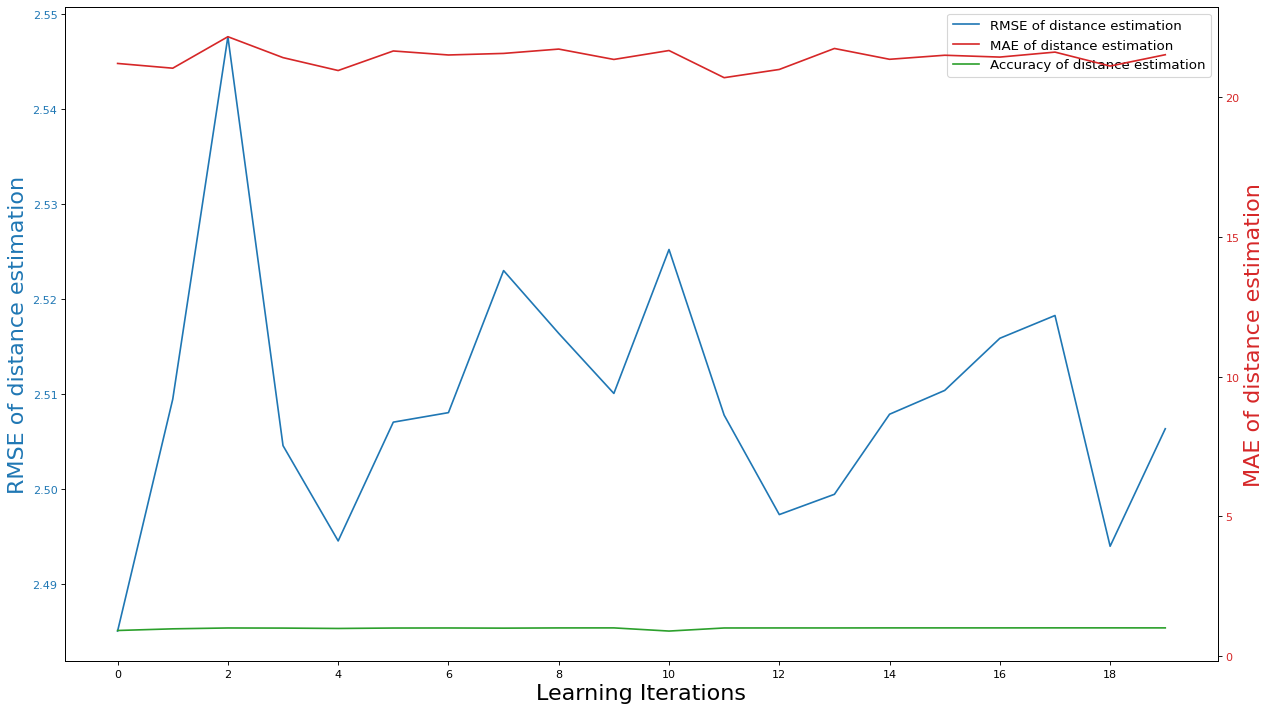

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


[Source Domain: step = 100] loss: 2.885, ae_loss: 2.672, reg_loss: 0.212, cls_loss: 0.001latent_loss: 0.000, RMSE: 4.521, MAE: 27.078, ACC: 1.000, Recon_err: 0.000, Time (100): 0.163, Memory_usage: 5948.352


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([11])) that is different to the input size (torch.Size([11, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Skipping batch with mismatched shapes: (7, 128), (104,)
Skipping batch with mismatched shapes: (7, 128), (104,)
Validation Accuracy: 1.0
Validation Precision: 1.0
Validation Recall: 1.0
Validation F1 Score: 1.0
Validation AUROC: 0

Element Nums of each class:  [229 771]

Correct Nums of each class:  [229 771]

Accuracy of IIns-VAE of each class: [100.0, 100.0]

[Train epoch = 21], loss: 2.892, RMSE: 4.457, MAE: 26.691, ACC: 1.000, Recon_Err: 0.000, Time: 1.799 (100), Memory_usage: 5947.800
[Validate] loss_val: 3.274, RMSE_val: 2.495, MAE_val: 21.261, ACC_val: 1.000, Recon_val: 0.028, Time_val (100): 0.005, Accuracy: 1.000, Precision: 1.000, Recall: 1.000, F1 Score: 1.000, AUROC: 0.000


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([104])) that is different to the input size (torch.Size([104, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1]

[Source Domain: step = 100] loss: 2.900, ae_loss: 2.689, reg_loss: 0.211, cls_loss: 0.001latent_loss: 0.000, RMSE: 4.492, MAE: 26.953, ACC: 1.000, Recon_err: 0.000, Time (100): 0.144, Memory_usage: 5948.356


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([11])) that is different to the input size (torch.Size([11, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Skipping batch with mismatched shapes: (7, 128), (104,)
Skipping batch with mismatched shapes: (7, 128), (104,)
Validation Accuracy: 0.999
Validation Precision: 0.9993523316062176
Validation Recall: 0.9978165938864629
Validation F1 Score: 0.9985818640262865
Validation AUROC: 0

Element Nums of each class:  [229 771]

Correct Nums of each class:  [228 771]

Accuracy of IIns-VAE of each class: [99.56331877729258, 100.0]

[Train epoch = 22], loss: 2.891, RMSE: 4.469, MAE: 26.693, ACC: 1.000, Recon_Err: 0.000, Time: 1.591 (100), Memory_usage: 5947.804
[Validate] loss_val: 3.271, RMSE_val: 2.509, MAE_val: 21.543, ACC_val: 0.999, Recon_val: 0.028, Time_val (100): 0.003, Accuracy: 0.999, Precision: 0.999, Recall: 0.998, F1 Score: 0.999, AUROC: 0.000


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([104])) that is different to the input size (torch.Size([104, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1]

[Source Domain: step = 100] loss: 2.893, ae_loss: 2.684, reg_loss: 0.208, cls_loss: 0.001latent_loss: 0.000, RMSE: 4.416, MAE: 26.629, ACC: 1.000, Recon_err: 0.000, Time (100): 0.133, Memory_usage: 5948.360


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([11])) that is different to the input size (torch.Size([11, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Skipping batch with mismatched shapes: (7, 128), (104,)
Skipping batch with mismatched shapes: (7, 128), (104,)
Validation Accuracy: 1.0
Validation Precision: 1.0
Validation Recall: 1.0
Validation F1 Score: 1.0
Validation AUROC: 0

Element Nums of each class:  [229 771]

Correct Nums of each class:  [229 771]

Accuracy of IIns-VAE of each class: [100.0, 100.0]

[Train epoch = 23], loss: 2.893, RMSE: 4.478, MAE: 26.677, ACC: 1.000, Recon_Err: 0.000, Time: 1.513 (100), Memory_usage: 5947.808
[Validate] loss_val: 3.265, RMSE_val: 2.505, MAE_val: 20.917, ACC_val: 1.000, Recon_val: 0.028, Time_val (100): 0.003, Accuracy: 1.000, Precision: 1.000, Recall: 1.000, F1 Score: 1.000, AUROC: 0.000


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([104])) that is different to the input size (torch.Size([104, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1]

[Source Domain: step = 100] loss: 2.893, ae_loss: 2.682, reg_loss: 0.211, cls_loss: 0.001latent_loss: 0.000, RMSE: 4.548, MAE: 26.973, ACC: 1.000, Recon_err: 0.000, Time (100): 0.136, Memory_usage: 5948.364


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([11])) that is different to the input size (torch.Size([11, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Skipping batch with mismatched shapes: (7, 128), (104,)
Skipping batch with mismatched shapes: (7, 128), (104,)
Validation Accuracy: 1.0
Validation Precision: 1.0
Validation Recall: 1.0
Validation F1 Score: 1.0
Validation AUROC: 0

Element Nums of each class:  [229 771]

Correct Nums of each class:  [229 771]

Accuracy of IIns-VAE of each class: [100.0, 100.0]

[Train epoch = 24], loss: 2.899, RMSE: 4.480, MAE: 26.692, ACC: 1.000, Recon_Err: 0.000, Time: 1.586 (100), Memory_usage: 5947.812
[Validate] loss_val: 3.268, RMSE_val: 2.508, MAE_val: 21.314, ACC_val: 1.000, Recon_val: 0.028, Time_val (100): 0.006, Accuracy: 1.000, Precision: 1.000, Recall: 1.000, F1 Score: 1.000, AUROC: 0.000


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([104])) that is different to the input size (torch.Size([104, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1]

[Source Domain: step = 100] loss: 2.898, ae_loss: 2.688, reg_loss: 0.210, cls_loss: 0.001latent_loss: 0.000, RMSE: 4.461, MAE: 26.837, ACC: 1.000, Recon_err: 0.000, Time (100): 0.156, Memory_usage: 5948.368


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([11])) that is different to the input size (torch.Size([11, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Skipping batch with mismatched shapes: (7, 128), (104,)
Skipping batch with mismatched shapes: (7, 128), (104,)
Validation Accuracy: 1.0
Validation Precision: 1.0
Validation Recall: 1.0
Validation F1 Score: 1.0
Validation AUROC: 0

Element Nums of each class:  [229 771]

Correct Nums of each class:  [229 771]

Accuracy of IIns-VAE of each class: [100.0, 100.0]

[Train epoch = 25], loss: 2.885, RMSE: 4.464, MAE: 26.690, ACC: 1.000, Recon_Err: 0.000, Time: 1.700 (100), Memory_usage: 5947.816
[Validate] loss_val: 3.284, RMSE_val: 2.502, MAE_val: 21.755, ACC_val: 1.000, Recon_val: 0.028, Time_val (100): 0.005, Accuracy: 1.000, Precision: 1.000, Recall: 1.000, F1 Score: 1.000, AUROC: 0.000


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([104])) that is different to the input size (torch.Size([104, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1]

[Source Domain: step = 100] loss: 2.889, ae_loss: 2.680, reg_loss: 0.209, cls_loss: 0.001latent_loss: 0.000, RMSE: 4.442, MAE: 26.771, ACC: 1.000, Recon_err: 0.000, Time (100): 0.167, Memory_usage: 5948.372


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([11])) that is different to the input size (torch.Size([11, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Skipping batch with mismatched shapes: (7, 128), (104,)
Skipping batch with mismatched shapes: (7, 128), (104,)
Validation Accuracy: 1.0
Validation Precision: 1.0
Validation Recall: 1.0
Validation F1 Score: 1.0
Validation AUROC: 0

Element Nums of each class:  [229 771]

Correct Nums of each class:  [229 771]

Accuracy of IIns-VAE of each class: [100.0, 100.0]

[Train epoch = 26], loss: 2.893, RMSE: 4.446, MAE: 26.687, ACC: 1.000, Recon_Err: 0.000, Time: 1.928 (100), Memory_usage: 5947.820
[Validate] loss_val: 3.270, RMSE_val: 2.497, MAE_val: 20.837, ACC_val: 1.000, Recon_val: 0.028, Time_val (100): 0.007, Accuracy: 1.000, Precision: 1.000, Recall: 1.000, F1 Score: 1.000, AUROC: 0.000


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([104])) that is different to the input size (torch.Size([104, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1]

[Source Domain: step = 100] loss: 2.893, ae_loss: 2.683, reg_loss: 0.209, cls_loss: 0.001latent_loss: 0.000, RMSE: 4.434, MAE: 26.724, ACC: 1.000, Recon_err: 0.000, Time (100): 0.148, Memory_usage: 5948.375


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([11])) that is different to the input size (torch.Size([11, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Skipping batch with mismatched shapes: (7, 128), (104,)
Skipping batch with mismatched shapes: (7, 128), (104,)
Validation Accuracy: 1.0
Validation Precision: 1.0
Validation Recall: 1.0
Validation F1 Score: 1.0
Validation AUROC: 0

Element Nums of each class:  [229 771]

Correct Nums of each class:  [229 771]

Accuracy of IIns-VAE of each class: [100.0, 100.0]

[Train epoch = 27], loss: 2.888, RMSE: 4.461, MAE: 26.698, ACC: 1.000, Recon_Err: 0.000, Time: 1.650 (100), Memory_usage: 5947.824
[Validate] loss_val: 3.269, RMSE_val: 2.511, MAE_val: 21.521, ACC_val: 1.000, Recon_val: 0.028, Time_val (100): 0.004, Accuracy: 1.000, Precision: 1.000, Recall: 1.000, F1 Score: 1.000, AUROC: 0.000


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([104])) that is different to the input size (torch.Size([104, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1]

[Source Domain: step = 100] loss: 2.890, ae_loss: 2.678, reg_loss: 0.212, cls_loss: 0.001latent_loss: 0.000, RMSE: 4.586, MAE: 27.108, ACC: 1.000, Recon_err: 0.000, Time (100): 0.150, Memory_usage: 5948.379


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([11])) that is different to the input size (torch.Size([11, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Skipping batch with mismatched shapes: (7, 128), (104,)
Skipping batch with mismatched shapes: (7, 128), (104,)
Validation Accuracy: 0.999
Validation Precision: 0.9993523316062176
Validation Recall: 0.9978165938864629
Validation F1 Score: 0.9985818640262865
Validation AUROC: 0

Element Nums of each class:  [229 771]

Correct Nums of each class:  [228 771]

Accuracy of IIns-VAE of each class: [99.56331877729258, 100.0]

[Train epoch = 28], loss: 2.887, RMSE: 4.485, MAE: 26.691, ACC: 1.000, Recon_Err: 0.000, Time: 1.654 (100), Memory_usage: 5947.828
[Validate] loss_val: 3.265, RMSE_val: 2.513, MAE_val: 21.372, ACC_val: 0.999, Recon_val: 0.028, Time_val (100): 0.003, Accuracy: 0.999, Precision: 0.999, Recall: 0.998, F1 Score: 0.999, AUROC: 0.000


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([104])) that is different to the input size (torch.Size([104, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1]

[Source Domain: step = 100] loss: 2.894, ae_loss: 2.682, reg_loss: 0.212, cls_loss: 0.000latent_loss: 0.000, RMSE: 4.512, MAE: 27.073, ACC: 1.000, Recon_err: 0.000, Time (100): 0.138, Memory_usage: 5948.383


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([11])) that is different to the input size (torch.Size([11, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Skipping batch with mismatched shapes: (7, 128), (104,)
Skipping batch with mismatched shapes: (7, 128), (104,)
Validation Accuracy: 1.0
Validation Precision: 1.0
Validation Recall: 1.0
Validation F1 Score: 1.0
Validation AUROC: 0

Element Nums of each class:  [229 771]

Correct Nums of each class:  [229 771]

Accuracy of IIns-VAE of each class: [100.0, 100.0]

[Train epoch = 29], loss: 2.892, RMSE: 4.466, MAE: 26.686, ACC: 1.000, Recon_Err: 0.000, Time: 1.542 (100), Memory_usage: 5947.832
[Validate] loss_val: 3.263, RMSE_val: 2.503, MAE_val: 21.229, ACC_val: 1.000, Recon_val: 0.028, Time_val (100): 0.004, Accuracy: 1.000, Precision: 1.000, Recall: 1.000, F1 Score: 1.000, AUROC: 0.000


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([104])) that is different to the input size (torch.Size([104, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1]

[Source Domain: step = 100] loss: 2.888, ae_loss: 2.678, reg_loss: 0.209, cls_loss: 0.000latent_loss: 0.000, RMSE: 4.502, MAE: 26.802, ACC: 1.000, Recon_err: 0.000, Time (100): 0.138, Memory_usage: 5948.387


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([11])) that is different to the input size (torch.Size([11, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Skipping batch with mismatched shapes: (7, 128), (104,)
Skipping batch with mismatched shapes: (7, 128), (104,)
Validation Accuracy: 1.0
Validation Precision: 1.0
Validation Recall: 1.0
Validation F1 Score: 1.0
Validation AUROC: 0

Element Nums of each class:  [229 771]

Correct Nums of each class:  [229 771]

Accuracy of IIns-VAE of each class: [100.0, 100.0]

[Train epoch = 30], loss: 2.886, RMSE: 4.487, MAE: 26.683, ACC: 1.000, Recon_Err: 0.000, Time: 1.544 (100), Memory_usage: 5947.835
[Validate] loss_val: 3.268, RMSE_val: 2.531, MAE_val: 22.004, ACC_val: 1.000, Recon_val: 0.028, Time_val (100): 0.004, Accuracy: 1.000, Precision: 1.000, Recall: 1.000, F1 Score: 1.000, AUROC: 0.000


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([104])) that is different to the input size (torch.Size([104, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1]

[Source Domain: step = 100] loss: 2.879, ae_loss: 2.670, reg_loss: 0.208, cls_loss: 0.000latent_loss: 0.000, RMSE: 4.461, MAE: 26.672, ACC: 1.000, Recon_err: 0.000, Time (100): 0.129, Memory_usage: 5948.391


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([11])) that is different to the input size (torch.Size([11, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Skipping batch with mismatched shapes: (7, 128), (104,)
Skipping batch with mismatched shapes: (7, 128), (104,)
Validation Accuracy: 1.0
Validation Precision: 1.0
Validation Recall: 1.0
Validation F1 Score: 1.0
Validation AUROC: 0

Element Nums of each class:  [229 771]

Correct Nums of each class:  [229 771]

Accuracy of IIns-VAE of each class: [100.0, 100.0]

[Train epoch = 31], loss: 2.886, RMSE: 4.454, MAE: 26.692, ACC: 1.000, Recon_Err: 0.000, Time: 1.452 (100), Memory_usage: 5947.839
[Validate] loss_val: 3.264, RMSE_val: 2.493, MAE_val: 21.357, ACC_val: 1.000, Recon_val: 0.028, Time_val (100): 0.003, Accuracy: 1.000, Precision: 1.000, Recall: 1.000, F1 Score: 1.000, AUROC: 0.000


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([104])) that is different to the input size (torch.Size([104, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1]

[Source Domain: step = 100] loss: 2.876, ae_loss: 2.666, reg_loss: 0.210, cls_loss: 0.000latent_loss: 0.000, RMSE: 4.468, MAE: 26.842, ACC: 1.000, Recon_err: 0.000, Time (100): 0.125, Memory_usage: 5948.395


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([11])) that is different to the input size (torch.Size([11, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Skipping batch with mismatched shapes: (7, 128), (104,)
Skipping batch with mismatched shapes: (7, 128), (104,)
Validation Accuracy: 1.0
Validation Precision: 1.0
Validation Recall: 1.0
Validation F1 Score: 1.0
Validation AUROC: 0

Element Nums of each class:  [229 771]

Correct Nums of each class:  [229 771]

Accuracy of IIns-VAE of each class: [100.0, 100.0]

[Train epoch = 32], loss: 2.885, RMSE: 4.475, MAE: 26.683, ACC: 1.000, Recon_Err: 0.000, Time: 1.423 (100), Memory_usage: 5947.843
[Validate] loss_val: 3.267, RMSE_val: 2.488, MAE_val: 21.235, ACC_val: 1.000, Recon_val: 0.028, Time_val (100): 0.004, Accuracy: 1.000, Precision: 1.000, Recall: 1.000, F1 Score: 1.000, AUROC: 0.000


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([104])) that is different to the input size (torch.Size([104, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1]

[Source Domain: step = 100] loss: 2.886, ae_loss: 2.676, reg_loss: 0.210, cls_loss: 0.000latent_loss: 0.000, RMSE: 4.473, MAE: 26.842, ACC: 1.000, Recon_err: 0.000, Time (100): 0.131, Memory_usage: 5948.399


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([11])) that is different to the input size (torch.Size([11, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Skipping batch with mismatched shapes: (7, 128), (104,)
Skipping batch with mismatched shapes: (7, 128), (104,)
Validation Accuracy: 1.0
Validation Precision: 1.0
Validation Recall: 1.0
Validation F1 Score: 1.0
Validation AUROC: 0

Element Nums of each class:  [229 771]

Correct Nums of each class:  [229 771]

Accuracy of IIns-VAE of each class: [100.0, 100.0]

[Train epoch = 33], loss: 2.888, RMSE: 4.452, MAE: 26.689, ACC: 1.000, Recon_Err: 0.000, Time: 1.471 (100), Memory_usage: 5947.847
[Validate] loss_val: 3.265, RMSE_val: 2.496, MAE_val: 20.952, ACC_val: 1.000, Recon_val: 0.028, Time_val (100): 0.003, Accuracy: 1.000, Precision: 1.000, Recall: 1.000, F1 Score: 1.000, AUROC: 0.000


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([104])) that is different to the input size (torch.Size([104, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1]

[Source Domain: step = 100] loss: 2.889, ae_loss: 2.680, reg_loss: 0.208, cls_loss: 0.000latent_loss: 0.000, RMSE: 4.485, MAE: 26.668, ACC: 1.000, Recon_err: 0.000, Time (100): 0.125, Memory_usage: 5948.403


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([11])) that is different to the input size (torch.Size([11, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Skipping batch with mismatched shapes: (7, 128), (104,)
Skipping batch with mismatched shapes: (7, 128), (104,)
Validation Accuracy: 0.999
Validation Precision: 0.9993523316062176
Validation Recall: 0.9978165938864629
Validation F1 Score: 0.9985818640262865
Validation AUROC: 0

Element Nums of each class:  [229 771]

Correct Nums of each class:  [228 771]

Accuracy of IIns-VAE of each class: [99.56331877729258, 100.0]

[Train epoch = 34], loss: 2.886, RMSE: 4.473, MAE: 26.691, ACC: 1.000, Recon_Err: 0.000, Time: 1.426 (100), Memory_usage: 5947.851
[Validate] loss_val: 3.264, RMSE_val: 2.508, MAE_val: 21.471, ACC_val: 0.999, Recon_val: 0.028, Time_val (100): 0.004, Accuracy: 0.999, Precision: 0.999, Recall: 0.998, F1 Score: 0.999, AUROC: 0.000


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([104])) that is different to the input size (torch.Size([104, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1]

[Source Domain: step = 100] loss: 2.901, ae_loss: 2.691, reg_loss: 0.209, cls_loss: 0.000latent_loss: 0.000, RMSE: 4.497, MAE: 26.771, ACC: 1.000, Recon_err: 0.000, Time (100): 0.122, Memory_usage: 5948.407


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([11])) that is different to the input size (torch.Size([11, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Skipping batch with mismatched shapes: (7, 128), (104,)
Skipping batch with mismatched shapes: (7, 128), (104,)
Validation Accuracy: 1.0
Validation Precision: 1.0
Validation Recall: 1.0
Validation F1 Score: 1.0
Validation AUROC: 0

Element Nums of each class:  [229 771]

Correct Nums of each class:  [229 771]

Accuracy of IIns-VAE of each class: [100.0, 100.0]

[Train epoch = 35], loss: 2.882, RMSE: 4.459, MAE: 26.681, ACC: 1.000, Recon_Err: 0.000, Time: 1.412 (100), Memory_usage: 5947.855
[Validate] loss_val: 3.265, RMSE_val: 2.511, MAE_val: 21.304, ACC_val: 1.000, Recon_val: 0.028, Time_val (100): 0.003, Accuracy: 1.000, Precision: 1.000, Recall: 1.000, F1 Score: 1.000, AUROC: 0.000


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([104])) that is different to the input size (torch.Size([104, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1]

[Source Domain: step = 100] loss: 2.885, ae_loss: 2.678, reg_loss: 0.206, cls_loss: 0.000latent_loss: 0.000, RMSE: 4.388, MAE: 26.427, ACC: 1.000, Recon_err: 0.000, Time (100): 0.122, Memory_usage: 5948.411


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([11])) that is different to the input size (torch.Size([11, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Skipping batch with mismatched shapes: (7, 128), (104,)
Skipping batch with mismatched shapes: (7, 128), (104,)
Validation Accuracy: 1.0
Validation Precision: 1.0
Validation Recall: 1.0
Validation F1 Score: 1.0
Validation AUROC: 0

Element Nums of each class:  [229 771]

Correct Nums of each class:  [229 771]

Accuracy of IIns-VAE of each class: [100.0, 100.0]

[Train epoch = 36], loss: 2.885, RMSE: 4.477, MAE: 26.684, ACC: 1.000, Recon_Err: 0.000, Time: 1.457 (100), Memory_usage: 5947.859
[Validate] loss_val: 3.260, RMSE_val: 2.510, MAE_val: 21.108, ACC_val: 1.000, Recon_val: 0.028, Time_val (100): 0.007, Accuracy: 1.000, Precision: 1.000, Recall: 1.000, F1 Score: 1.000, AUROC: 0.000


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([104])) that is different to the input size (torch.Size([104, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1]

[Source Domain: step = 100] loss: 2.880, ae_loss: 2.673, reg_loss: 0.207, cls_loss: 0.000latent_loss: 0.000, RMSE: 4.449, MAE: 26.529, ACC: 1.000, Recon_err: 0.000, Time (100): 0.177, Memory_usage: 5948.415


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([11])) that is different to the input size (torch.Size([11, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([104])) that is different to the input size (torch.Size([104, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Skipping batch with mismatched shapes: (7, 128), (104,)
Skipping batch with mismatched shapes: (7, 128), (104,)
Validation Accuracy: 1.0
Validation Precision: 1.0
Validation Recall: 1.0
Validation F1 Score: 1.0
Validation AUROC: 0

Element Nums of each class:  [229 771]

Correct Nums of each class:  [229 771]

Accuracy of IIns-VAE of each class: [100.0, 100.0]

[Train epoch = 37], loss: 2.884, RMSE: 4.487, MAE: 26.687, ACC: 1.000, Recon_Err: 0.000, Time: 1.952 (100), Memory_usage: 5947.863
[Validate] loss_val: 3.263, RMSE_val: 2.537, MAE_val: 22.072, ACC_val: 1.000, Recon_val: 0.028, Time_val (100): 0.011, Accuracy: 1.000, Precision: 1.000, Recall: 1.000, F1 Score: 1.000, AUROC: 0.000


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


[Source Domain: step = 100] loss: 2.886, ae_loss: 2.674, reg_loss: 0.211, cls_loss: 0.000latent_loss: 0.000, RMSE: 4.544, MAE: 27.051, ACC: 1.000, Recon_err: 0.000, Time (100): 0.187, Memory_usage: 5948.418


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([11])) that is different to the input size (torch.Size([11, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Skipping batch with mismatched shapes: (7, 128), (104,)
Skipping batch with mismatched shapes: (7, 128), (104,)
Validation Accuracy: 0.999
Validation Precision: 0.9993523316062176
Validation Recall: 0.9978165938864629
Validation F1 Score: 0.9985818640262865
Validation AUROC: 0

Element Nums of each class:  [229 771]

Correct Nums of each class:  [228 771]

Accuracy of IIns-VAE of each class: [99.56331877729258, 100.0]

[Train epoch = 38], loss: 2.885, RMSE: 4.497, MAE: 26.701, ACC: 1.000, Recon_Err: 0.000, Time: 2.095 (100), Memory_usage: 5947.867
[Validate] loss_val: 3.263, RMSE_val: 2.513, MAE_val: 21.555, ACC_val: 0.999, Recon_val: 0.028, Time_val (100): 0.006, Accuracy: 0.999, Precision: 0.999, Recall: 0.998, F1 Score: 0.999, AUROC: 0.000


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([104])) that is different to the input size (torch.Size([104, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1]

[Source Domain: step = 100] loss: 2.882, ae_loss: 2.673, reg_loss: 0.208, cls_loss: 0.000latent_loss: 0.000, RMSE: 4.486, MAE: 26.664, ACC: 1.000, Recon_err: 0.000, Time (100): 0.137, Memory_usage: 5948.422


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([11])) that is different to the input size (torch.Size([11, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Skipping batch with mismatched shapes: (7, 128), (104,)
Skipping batch with mismatched shapes: (7, 128), (104,)
Validation Accuracy: 1.0
Validation Precision: 1.0
Validation Recall: 1.0
Validation F1 Score: 1.0
Validation AUROC: 0

Element Nums of each class:  [229 771]

Correct Nums of each class:  [229 771]

Accuracy of IIns-VAE of each class: [100.0, 100.0]

[Train epoch = 39], loss: 2.883, RMSE: 4.477, MAE: 26.684, ACC: 1.000, Recon_Err: 0.000, Time: 1.604 (100), Memory_usage: 5947.871
[Validate] loss_val: 3.267, RMSE_val: 2.511, MAE_val: 21.631, ACC_val: 1.000, Recon_val: 0.028, Time_val (100): 0.006, Accuracy: 1.000, Precision: 1.000, Recall: 1.000, F1 Score: 1.000, AUROC: 0.000


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([104])) that is different to the input size (torch.Size([104, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1]

[Source Domain: step = 100] loss: 2.877, ae_loss: 2.668, reg_loss: 0.210, cls_loss: 0.000latent_loss: 0.000, RMSE: 4.499, MAE: 26.832, ACC: 1.000, Recon_err: 0.000, Time (100): 0.141, Memory_usage: 5948.426


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([11])) that is different to the input size (torch.Size([11, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([104])) that is different to the input size (torch.Size([104, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Skipping batch with mismatched shapes: (7, 128), (104,)
Skipping batch with mismatched shapes: (7, 128), (104,)
Validation Accuracy: 1.0
Validation Precision: 1.0
Validation Recall: 1.0
Validation F1 Score: 1.0
Validation AUROC: 0

Element Nums of each class:  [229 771]

Correct Nums of each class:  [229 771]

Accuracy of IIns-VAE of each class: [100.0, 100.0]

[Train epoch = 40], loss: 2.888, RMSE: 4.486, MAE: 26.685, ACC: 1.000, Recon_Err: 0.000, Time: 1.555 (100), Memory_usage: 5947.875
[Validate] loss_val: 3.254, RMSE_val: 2.497, MAE_val: 21.343, ACC_val: 1.000, Recon_val: 0.028, Time_val (100): 0.003, Accuracy: 1.000, Precision: 1.000, Recall: 1.000, F1 Score: 1.000, AUROC: 0.000


<ipython-input-7-cabf343dad60>:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  for cls, color in zip(classes, plt.cm.get_cmap('Pastel1').colors):


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


[Source Domain: step = 100] loss: 2.873, ae_loss: 2.662, reg_loss: 0.211, cls_loss: 0.000latent_loss: 0.000, RMSE: 4.567, MAE: 27.059, ACC: 1.000, Recon_err: 0.000, Time (100): 0.130, Memory_usage: 5181.415


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([11])) that is different to the input size (torch.Size([11, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Skipping batch with mismatched shapes: (7, 128), (104,)
Skipping batch with mismatched shapes: (7, 128), (104,)
Validation Accuracy: 0.999
Validation Precision: 0.9993523316062176
Validation Recall: 0.9978165938864629
Validation F1 Score: 0.9985818640262865
Validation AUROC: 0

Element Nums of each class:  [229 771]

Correct Nums of each class:  [228 771]

Accuracy of IIns-VAE of each class: [99.56331877729258, 100.0]

[Train epoch = 41], loss: 2.883, RMSE: 4.482, MAE: 26.682, ACC: 1.000, Recon_Err: 0.000, Time: 1.474 (100), Memory_usage: 5180.863
[Validate] loss_val: 3.257, RMSE_val: 2.502, MAE_val: 21.209, ACC_val: 0.999, Recon_val: 0.028, Time_val (100): 0.003, Accuracy: 0.999, Precision: 0.999, Recall: 0.998, F1 Score: 0.999, AUROC: 0.000


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([104])) that is different to the input size (torch.Size([104, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1]

[Source Domain: step = 100] loss: 3.172, ae_loss: 2.695, reg_loss: 0.212, cls_loss: 0.265latent_loss: 0.000, RMSE: 4.575, MAE: 27.116, ACC: 0.964, Recon_err: 0.000, Time (100): 0.126, Memory_usage: 5181.418


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([11])) that is different to the input size (torch.Size([11, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Skipping batch with mismatched shapes: (7, 128), (104,)
Skipping batch with mismatched shapes: (7, 128), (104,)
Validation Accuracy: 0.892
Validation Precision: 0.839661147477859
Validation Recall: 0.8747047729087727
Validation F1 Score: 0.8548316854041325
Validation AUROC: 0

Element Nums of each class:  [229 771]

Correct Nums of each class:  [193 699]

Accuracy of IIns-VAE of each class: [84.27947598253274, 90.6614785992218]

[Train epoch = 42], loss: 3.168, RMSE: 4.471, MAE: 26.689, ACC: 0.947, Recon_Err: 0.000, Time: 1.445 (100), Memory_usage: 5180.867
[Validate] loss_val: 3.563, RMSE_val: 2.514, MAE_val: 21.434, ACC_val: 0.892, Recon_val: 0.028, Time_val (100): 0.003, Accuracy: 0.892, Precision: 0.840, Recall: 0.875, F1 Score: 0.855, AUROC: 0.000


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([104])) that is different to the input size (torch.Size([104, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1]

[Source Domain: step = 100] loss: 3.004, ae_loss: 2.718, reg_loss: 0.209, cls_loss: 0.077latent_loss: 0.000, RMSE: 4.456, MAE: 26.804, ACC: 0.972, Recon_err: 0.000, Time (100): 0.122, Memory_usage: 5181.422


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([11])) that is different to the input size (torch.Size([11, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Skipping batch with mismatched shapes: (7, 128), (104,)
Skipping batch with mismatched shapes: (7, 128), (104,)
Validation Accuracy: 0.996
Validation Precision: 0.992856298447976
Validation Recall: 0.9958710685946341
Validation F1 Score: 0.9943534726143423
Validation AUROC: 0

Element Nums of each class:  [229 771]

Correct Nums of each class:  [228 768]

Accuracy of IIns-VAE of each class: [99.56331877729258, 99.61089494163424]

[Train epoch = 43], loss: 3.003, RMSE: 4.478, MAE: 26.688, ACC: 0.973, Recon_Err: 0.000, Time: 1.409 (100), Memory_usage: 5180.871
[Validate] loss_val: 3.304, RMSE_val: 2.488, MAE_val: 21.151, ACC_val: 0.996, Recon_val: 0.028, Time_val (100): 0.003, Accuracy: 0.996, Precision: 0.993, Recall: 0.996, F1 Score: 0.994, AUROC: 0.000


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([104])) that is different to the input size (torch.Size([104, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1]

[Source Domain: step = 100] loss: 2.895, ae_loss: 2.677, reg_loss: 0.210, cls_loss: 0.008latent_loss: 0.000, RMSE: 4.498, MAE: 26.873, ACC: 0.999, Recon_err: 0.000, Time (100): 0.120, Memory_usage: 5181.426


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([11])) that is different to the input size (torch.Size([11, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Skipping batch with mismatched shapes: (7, 128), (104,)
Skipping batch with mismatched shapes: (7, 128), (104,)
Validation Accuracy: 0.997
Validation Precision: 0.9965116807562948
Validation Recall: 0.9949846793423162
Validation F1 Score: 0.9957455920788597
Validation AUROC: 0

Element Nums of each class:  [229 771]

Correct Nums of each class:  [227 770]

Accuracy of IIns-VAE of each class: [99.12663755458514, 99.87029831387808]

[Train epoch = 44], loss: 2.895, RMSE: 4.481, MAE: 26.690, ACC: 0.999, Recon_Err: 0.000, Time: 1.385 (100), Memory_usage: 5180.875
[Validate] loss_val: 3.269, RMSE_val: 2.505, MAE_val: 21.475, ACC_val: 0.997, Recon_val: 0.028, Time_val (100): 0.003, Accuracy: 0.997, Precision: 0.997, Recall: 0.995, F1 Score: 0.996, AUROC: 0.000


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([104])) that is different to the input size (torch.Size([104, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1]

[Source Domain: step = 100] loss: 2.883, ae_loss: 2.671, reg_loss: 0.208, cls_loss: 0.003latent_loss: 0.000, RMSE: 4.459, MAE: 26.668, ACC: 1.000, Recon_err: 0.000, Time (100): 0.123, Memory_usage: 5181.430


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([11])) that is different to the input size (torch.Size([11, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Skipping batch with mismatched shapes: (7, 128), (104,)
Skipping batch with mismatched shapes: (7, 128), (104,)
Validation Accuracy: 0.998
Validation Precision: 0.9987063389391979
Validation Recall: 0.9956331877729258
Validation F1 Score: 0.9971593491500772
Validation AUROC: 0

Element Nums of each class:  [229 771]

Correct Nums of each class:  [227 771]

Accuracy of IIns-VAE of each class: [99.12663755458514, 100.0]

[Train epoch = 45], loss: 2.889, RMSE: 4.472, MAE: 26.680, ACC: 1.000, Recon_Err: 0.000, Time: 1.403 (100), Memory_usage: 5180.878
[Validate] loss_val: 3.274, RMSE_val: 2.526, MAE_val: 22.008, ACC_val: 0.998, Recon_val: 0.028, Time_val (100): 0.003, Accuracy: 0.998, Precision: 0.999, Recall: 0.996, F1 Score: 0.997, AUROC: 0.000


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([104])) that is different to the input size (torch.Size([104, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1]

[Source Domain: step = 100] loss: 2.876, ae_loss: 2.665, reg_loss: 0.210, cls_loss: 0.001latent_loss: 0.000, RMSE: 4.494, MAE: 26.831, ACC: 1.000, Recon_err: 0.000, Time (100): 0.123, Memory_usage: 5181.434


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([11])) that is different to the input size (torch.Size([11, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Skipping batch with mismatched shapes: (7, 128), (104,)
Skipping batch with mismatched shapes: (7, 128), (104,)
Validation Accuracy: 0.997
Validation Precision: 0.9950028232636929
Validation Recall: 0.9965195770252437
Validation F1 Score: 0.995758632243726
Validation AUROC: 0

Element Nums of each class:  [229 771]

Correct Nums of each class:  [228 769]

Accuracy of IIns-VAE of each class: [99.56331877729258, 99.74059662775616]

[Train epoch = 46], loss: 2.885, RMSE: 4.456, MAE: 26.689, ACC: 1.000, Recon_Err: 0.000, Time: 1.405 (100), Memory_usage: 5180.882
[Validate] loss_val: 3.271, RMSE_val: 2.498, MAE_val: 21.110, ACC_val: 0.997, Recon_val: 0.028, Time_val (100): 0.003, Accuracy: 0.997, Precision: 0.995, Recall: 0.997, F1 Score: 0.996, AUROC: 0.000


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([104])) that is different to the input size (torch.Size([104, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1]

[Source Domain: step = 100] loss: 2.899, ae_loss: 2.689, reg_loss: 0.209, cls_loss: 0.001latent_loss: 0.000, RMSE: 4.500, MAE: 26.775, ACC: 1.000, Recon_err: 0.000, Time (100): 0.123, Memory_usage: 5181.438


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([11])) that is different to the input size (torch.Size([11, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Skipping batch with mismatched shapes: (7, 128), (104,)
Skipping batch with mismatched shapes: (7, 128), (104,)
Validation Accuracy: 0.998
Validation Precision: 0.9956709956709957
Validation Recall: 0.9987029831387808
Validation F1 Score: 0.9971767363071711
Validation AUROC: 0

Element Nums of each class:  [229 771]

Correct Nums of each class:  [229 769]

Accuracy of IIns-VAE of each class: [100.0, 99.74059662775616]

[Train epoch = 47], loss: 2.886, RMSE: 4.477, MAE: 26.686, ACC: 1.000, Recon_Err: 0.000, Time: 1.401 (100), Memory_usage: 5180.886
[Validate] loss_val: 3.260, RMSE_val: 2.500, MAE_val: 21.417, ACC_val: 0.998, Recon_val: 0.028, Time_val (100): 0.003, Accuracy: 0.998, Precision: 0.996, Recall: 0.999, F1 Score: 0.997, AUROC: 0.000


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([104])) that is different to the input size (torch.Size([104, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1]

[Source Domain: step = 100] loss: 2.882, ae_loss: 2.669, reg_loss: 0.213, cls_loss: 0.001latent_loss: 0.000, RMSE: 4.586, MAE: 27.200, ACC: 1.000, Recon_err: 0.000, Time (100): 0.124, Memory_usage: 5181.442


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([11])) that is different to the input size (torch.Size([11, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Skipping batch with mismatched shapes: (7, 128), (104,)
Skipping batch with mismatched shapes: (7, 128), (104,)
Validation Accuracy: 1.0
Validation Precision: 1.0
Validation Recall: 1.0
Validation F1 Score: 1.0
Validation AUROC: 0

Element Nums of each class:  [229 771]

Correct Nums of each class:  [229 771]

Accuracy of IIns-VAE of each class: [100.0, 100.0]

[Train epoch = 48], loss: 2.886, RMSE: 4.470, MAE: 26.683, ACC: 1.000, Recon_Err: 0.000, Time: 1.412 (100), Memory_usage: 5180.890
[Validate] loss_val: 3.269, RMSE_val: 2.499, MAE_val: 21.646, ACC_val: 1.000, Recon_val: 0.028, Time_val (100): 0.003, Accuracy: 1.000, Precision: 1.000, Recall: 1.000, F1 Score: 1.000, AUROC: 0.000


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([104])) that is different to the input size (torch.Size([104, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1]

[Source Domain: step = 100] loss: 2.880, ae_loss: 2.667, reg_loss: 0.212, cls_loss: 0.001latent_loss: 0.000, RMSE: 4.599, MAE: 27.123, ACC: 1.000, Recon_err: 0.000, Time (100): 0.126, Memory_usage: 5181.446


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([11])) that is different to the input size (torch.Size([11, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Skipping batch with mismatched shapes: (7, 128), (104,)
Skipping batch with mismatched shapes: (7, 128), (104,)
Validation Accuracy: 0.992
Validation Precision: 0.9831223628691983
Validation Recall: 0.9948119325551232
Validation F1 Score: 0.9888087470832797
Validation AUROC: 0

Element Nums of each class:  [229 771]

Correct Nums of each class:  [229 763]

Accuracy of IIns-VAE of each class: [100.0, 98.96238651102465]

[Train epoch = 49], loss: 2.883, RMSE: 4.474, MAE: 26.685, ACC: 1.000, Recon_Err: 0.000, Time: 1.428 (100), Memory_usage: 5180.894
[Validate] loss_val: 3.276, RMSE_val: 2.490, MAE_val: 21.095, ACC_val: 0.992, Recon_val: 0.028, Time_val (100): 0.003, Accuracy: 0.992, Precision: 0.983, Recall: 0.995, F1 Score: 0.989, AUROC: 0.000


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([104])) that is different to the input size (torch.Size([104, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1]

[Source Domain: step = 100] loss: 2.883, ae_loss: 2.673, reg_loss: 0.210, cls_loss: 0.001latent_loss: 0.000, RMSE: 4.489, MAE: 26.877, ACC: 1.000, Recon_err: 0.000, Time (100): 0.120, Memory_usage: 5181.450


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([11])) that is different to the input size (torch.Size([11, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Skipping batch with mismatched shapes: (7, 128), (104,)
Skipping batch with mismatched shapes: (7, 128), (104,)
Validation Accuracy: 1.0
Validation Precision: 1.0
Validation Recall: 1.0
Validation F1 Score: 1.0
Validation AUROC: 0

Element Nums of each class:  [229 771]

Correct Nums of each class:  [229 771]

Accuracy of IIns-VAE of each class: [100.0, 100.0]

[Train epoch = 50], loss: 2.880, RMSE: 4.473, MAE: 26.682, ACC: 1.000, Recon_Err: 0.000, Time: 1.389 (100), Memory_usage: 5180.898
[Validate] loss_val: 3.262, RMSE_val: 2.506, MAE_val: 21.198, ACC_val: 1.000, Recon_val: 0.028, Time_val (100): 0.003, Accuracy: 1.000, Precision: 1.000, Recall: 1.000, F1 Score: 1.000, AUROC: 0.000
Memory Usage After Training: Allocated 5181.23 MB, Reserved 7086.00 MB


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([104])) that is different to the input size (torch.Size([104, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


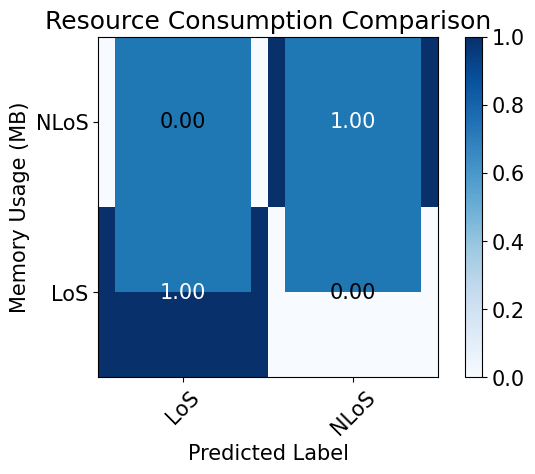

Finished Training under Transfer Learning Setting...
Memory Usage Before Training: Allocated 3719.36 MB, Reserved 7086.00 MB
Starting Training the IInsVAE under the Transfer Learning Setting...


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1]))

Skipping batch with mismatched shapes: (7, 128), (104,)
Skipping batch with mismatched shapes: (7, 128), (104,)
Validation Accuracy: 0.803
Validation Precision: 0.7193361040068201
Validation Recall: 0.6865212195356794
Validation F1 Score: 0.6994344179631418
Validation AUROC: 0

Element Nums of each class:  [229 771]

Correct Nums of each class:  [108 695]

Accuracy of IIns-VAE of each class: [47.161572052401745, 90.14267185473412]

[Train epoch = 1], loss: 3.969, RMSE: 2.498, MAE: 20.897, ACC: 0.804, Recon_Err: 0.000, Time: 0.171 (100), Memory_usage: 3719.207
[Validate] loss_val: 4.005, RMSE_val: 2.506, MAE_val: 21.078, ACC_val: 0.803, Recon_val: 0.118, Time_val (100): 0.011, Accuracy: 0.803, Precision: 0.719, Recall: 0.687, F1 Score: 0.699, AUROC: 0.000


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1]))

Skipping batch with mismatched shapes: (7, 128), (104,)
Skipping batch with mismatched shapes: (7, 128), (104,)
Validation Accuracy: 0.807
Validation Precision: 0.7520362912348975
Validation Recall: 0.6261844482580894
Validation F1 Score: 0.6472121534499179
Validation AUROC: 0

Element Nums of each class:  [229 771]

Correct Nums of each class:  [ 67 740]

Accuracy of IIns-VAE of each class: [29.257641921397383, 95.9792477302205]

[Train epoch = 2], loss: 3.906, RMSE: 2.489, MAE: 20.898, ACC: 0.820, Recon_Err: 0.000, Time: 0.172 (100), Memory_usage: 3719.227
[Validate] loss_val: 3.980, RMSE_val: 2.496, MAE_val: 21.080, ACC_val: 0.807, Recon_val: 0.118, Time_val (100): 0.012, Accuracy: 0.807, Precision: 0.752, Recall: 0.626, F1 Score: 0.647, AUROC: 0.000


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([104])) that is different to the input size (torch.Size([104, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1]

Skipping batch with mismatched shapes: (7, 128), (104,)
Skipping batch with mismatched shapes: (7, 128), (104,)
Validation Accuracy: 0.816
Validation Precision: 0.7985733284971588
Validation Recall: 0.6258814334018656
Validation F1 Score: 0.6487879366291276
Validation AUROC: 0

Element Nums of each class:  [229 771]

Correct Nums of each class:  [ 63 753]

Accuracy of IIns-VAE of each class: [27.510917030567683, 97.66536964980544]

[Train epoch = 3], loss: 3.892, RMSE: 2.478, MAE: 20.894, ACC: 0.834, Recon_Err: 0.000, Time: 0.168 (100), Memory_usage: 3719.230
[Validate] loss_val: 3.977, RMSE_val: 2.502, MAE_val: 21.077, ACC_val: 0.814, Recon_val: 0.118, Time_val (100): 0.011, Accuracy: 0.816, Precision: 0.799, Recall: 0.626, F1 Score: 0.649, AUROC: 0.000


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([104])) that is different to the input size (torch.Size([104, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1]

Skipping batch with mismatched shapes: (7, 128), (104,)
Skipping batch with mismatched shapes: (7, 128), (104,)
Validation Accuracy: 0.819
Validation Precision: 0.8256106321839081
Validation Recall: 0.6232222656449119
Validation F1 Score: 0.6460689207448588
Validation AUROC: 0

Element Nums of each class:  [229 771]

Correct Nums of each class:  [ 60 759]

Accuracy of IIns-VAE of each class: [26.200873362445414, 98.44357976653697]

[Train epoch = 4], loss: 3.884, RMSE: 2.487, MAE: 20.898, ACC: 0.840, Recon_Err: 0.000, Time: 0.165 (100), Memory_usage: 3719.234
[Validate] loss_val: 3.980, RMSE_val: 2.492, MAE_val: 21.074, ACC_val: 0.818, Recon_val: 0.119, Time_val (100): 0.015, Accuracy: 0.819, Precision: 0.826, Recall: 0.623, F1 Score: 0.646, AUROC: 0.000


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([104])) that is different to the input size (torch.Size([104, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1]

Skipping batch with mismatched shapes: (7, 128), (104,)
Skipping batch with mismatched shapes: (7, 128), (104,)
Validation Accuracy: 0.818
Validation Precision: 0.8284531203785862
Validation Recall: 0.6195039618484472
Validation F1 Score: 0.6411643624949723
Validation AUROC: 0

Element Nums of each class:  [229 771]

Correct Nums of each class:  [ 58 760]

Accuracy of IIns-VAE of each class: [25.327510917030565, 98.57328145265889]

[Train epoch = 5], loss: 3.891, RMSE: 2.483, MAE: 20.898, ACC: 0.836, Recon_Err: 0.000, Time: 0.182 (100), Memory_usage: 3719.238
[Validate] loss_val: 3.977, RMSE_val: 2.510, MAE_val: 21.080, ACC_val: 0.818, Recon_val: 0.118, Time_val (100): 0.015, Accuracy: 0.818, Precision: 0.828, Recall: 0.620, F1 Score: 0.641, AUROC: 0.000


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([104])) that is different to the input size (torch.Size([104, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1]

Skipping batch with mismatched shapes: (7, 128), (104,)
Skipping batch with mismatched shapes: (7, 128), (104,)
Validation Accuracy: 0.82
Validation Precision: 0.84648292883587
Validation Recall: 0.619266081026739
Validation F1 Score: 0.6411225686054023
Validation AUROC: 0

Element Nums of each class:  [229 771]

Correct Nums of each class:  [ 57 763]

Accuracy of IIns-VAE of each class: [24.890829694323145, 98.96238651102465]

[Train epoch = 6], loss: 3.892, RMSE: 2.488, MAE: 20.897, ACC: 0.840, Recon_Err: 0.000, Time: 0.257 (100), Memory_usage: 3719.242
[Validate] loss_val: 3.974, RMSE_val: 2.503, MAE_val: 21.077, ACC_val: 0.819, Recon_val: 0.117, Time_val (100): 0.017, Accuracy: 0.820, Precision: 0.846, Recall: 0.619, F1 Score: 0.641, AUROC: 0.000


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([104])) that is different to the input size (torch.Size([104, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1]

Skipping batch with mismatched shapes: (7, 128), (104,)
Skipping batch with mismatched shapes: (7, 128), (104,)
Validation Accuracy: 0.82
Validation Precision: 0.84648292883587
Validation Recall: 0.619266081026739
Validation F1 Score: 0.6411225686054023
Validation AUROC: 0

Element Nums of each class:  [229 771]

Correct Nums of each class:  [ 57 763]

Accuracy of IIns-VAE of each class: [24.890829694323145, 98.96238651102465]

[Train epoch = 7], loss: 3.900, RMSE: 2.490, MAE: 20.895, ACC: 0.833, Recon_Err: 0.000, Time: 0.206 (100), Memory_usage: 3719.246
[Validate] loss_val: 3.973, RMSE_val: 2.505, MAE_val: 21.072, ACC_val: 0.821, Recon_val: 0.118, Time_val (100): 0.013, Accuracy: 0.820, Precision: 0.846, Recall: 0.619, F1 Score: 0.641, AUROC: 0.000


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([104])) that is different to the input size (torch.Size([104, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1]

Skipping batch with mismatched shapes: (7, 128), (104,)
Skipping batch with mismatched shapes: (7, 128), (104,)
Validation Accuracy: 0.82
Validation Precision: 0.8315771918919328
Validation Recall: 0.6238707740755215
Validation F1 Score: 0.6470588235294117
Validation AUROC: 0

Element Nums of each class:  [229 771]

Correct Nums of each class:  [ 60 760]

Accuracy of IIns-VAE of each class: [26.200873362445414, 98.57328145265889]

[Train epoch = 8], loss: 3.894, RMSE: 2.497, MAE: 20.898, ACC: 0.835, Recon_Err: 0.000, Time: 0.182 (100), Memory_usage: 3719.250
[Validate] loss_val: 3.977, RMSE_val: 2.500, MAE_val: 21.075, ACC_val: 0.820, Recon_val: 0.118, Time_val (100): 0.014, Accuracy: 0.820, Precision: 0.832, Recall: 0.624, F1 Score: 0.647, AUROC: 0.000


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([104])) that is different to the input size (torch.Size([104, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1]

Skipping batch with mismatched shapes: (7, 128), (104,)
Skipping batch with mismatched shapes: (7, 128), (104,)
Validation Accuracy: 0.819
Validation Precision: 0.8300307219662059
Validation Recall: 0.6216873679619844
Validation F1 Score: 0.644120417067277
Validation AUROC: 0

Element Nums of each class:  [229 771]

Correct Nums of each class:  [ 59 760]

Accuracy of IIns-VAE of each class: [25.76419213973799, 98.57328145265889]

[Train epoch = 9], loss: 3.885, RMSE: 2.483, MAE: 20.899, ACC: 0.836, Recon_Err: 0.000, Time: 0.201 (100), Memory_usage: 3719.254
[Validate] loss_val: 3.974, RMSE_val: 2.509, MAE_val: 21.076, ACC_val: 0.820, Recon_val: 0.118, Time_val (100): 0.013, Accuracy: 0.819, Precision: 0.830, Recall: 0.622, F1 Score: 0.644, AUROC: 0.000


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([104])) that is different to the input size (torch.Size([104, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1]

Skipping batch with mismatched shapes: (7, 128), (104,)
Skipping batch with mismatched shapes: (7, 128), (104,)
Validation Accuracy: 0.82
Validation Precision: 0.84648292883587
Validation Recall: 0.619266081026739
Validation F1 Score: 0.6411225686054023
Validation AUROC: 0

Element Nums of each class:  [229 771]

Correct Nums of each class:  [ 57 763]

Accuracy of IIns-VAE of each class: [24.890829694323145, 98.96238651102465]

[Train epoch = 10], loss: 3.886, RMSE: 2.491, MAE: 20.897, ACC: 0.838, Recon_Err: 0.000, Time: 0.182 (100), Memory_usage: 3719.258
[Validate] loss_val: 3.976, RMSE_val: 2.505, MAE_val: 21.079, ACC_val: 0.819, Recon_val: 0.118, Time_val (100): 0.014, Accuracy: 0.820, Precision: 0.846, Recall: 0.619, F1 Score: 0.641, AUROC: 0.000


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([104])) that is different to the input size (torch.Size([104, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1]

Skipping batch with mismatched shapes: (7, 128), (104,)
Skipping batch with mismatched shapes: (7, 128), (104,)
Validation Accuracy: 0.819
Validation Precision: 0.8300307219662059
Validation Recall: 0.6216873679619844
Validation F1 Score: 0.644120417067277
Validation AUROC: 0

Element Nums of each class:  [229 771]

Correct Nums of each class:  [ 59 760]

Accuracy of IIns-VAE of each class: [25.76419213973799, 98.57328145265889]

[Train epoch = 11], loss: 3.886, RMSE: 2.483, MAE: 20.894, ACC: 0.836, Recon_Err: 0.000, Time: 0.249 (100), Memory_usage: 3719.262
[Validate] loss_val: 3.980, RMSE_val: 2.499, MAE_val: 21.078, ACC_val: 0.819, Recon_val: 0.118, Time_val (100): 0.018, Accuracy: 0.819, Precision: 0.830, Recall: 0.622, F1 Score: 0.644, AUROC: 0.000


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([104])) that is different to the input size (torch.Size([104, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1]

Skipping batch with mismatched shapes: (7, 128), (104,)
Skipping batch with mismatched shapes: (7, 128), (104,)
Validation Accuracy: 0.82
Validation Precision: 0.84648292883587
Validation Recall: 0.619266081026739
Validation F1 Score: 0.6411225686054023
Validation AUROC: 0

Element Nums of each class:  [229 771]

Correct Nums of each class:  [ 57 763]

Accuracy of IIns-VAE of each class: [24.890829694323145, 98.96238651102465]

[Train epoch = 12], loss: 3.898, RMSE: 2.485, MAE: 20.897, ACC: 0.838, Recon_Err: 0.000, Time: 0.193 (100), Memory_usage: 3719.266
[Validate] loss_val: 3.978, RMSE_val: 2.501, MAE_val: 21.081, ACC_val: 0.820, Recon_val: 0.118, Time_val (100): 0.011, Accuracy: 0.820, Precision: 0.846, Recall: 0.619, F1 Score: 0.641, AUROC: 0.000


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([104])) that is different to the input size (torch.Size([104, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1]

Skipping batch with mismatched shapes: (7, 128), (104,)
Skipping batch with mismatched shapes: (7, 128), (104,)
Validation Accuracy: 0.819
Validation Precision: 0.8300307219662059
Validation Recall: 0.6216873679619844
Validation F1 Score: 0.644120417067277
Validation AUROC: 0

Element Nums of each class:  [229 771]

Correct Nums of each class:  [ 59 760]

Accuracy of IIns-VAE of each class: [25.76419213973799, 98.57328145265889]

[Train epoch = 13], loss: 3.894, RMSE: 2.492, MAE: 20.897, ACC: 0.836, Recon_Err: 0.000, Time: 0.171 (100), Memory_usage: 3719.270
[Validate] loss_val: 3.976, RMSE_val: 2.505, MAE_val: 21.077, ACC_val: 0.818, Recon_val: 0.118, Time_val (100): 0.011, Accuracy: 0.819, Precision: 0.830, Recall: 0.622, F1 Score: 0.644, AUROC: 0.000


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([104])) that is different to the input size (torch.Size([104, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1]

Skipping batch with mismatched shapes: (7, 128), (104,)
Skipping batch with mismatched shapes: (7, 128), (104,)
Validation Accuracy: 0.819
Validation Precision: 0.8256106321839081
Validation Recall: 0.6232222656449119
Validation F1 Score: 0.6460689207448588
Validation AUROC: 0

Element Nums of each class:  [229 771]

Correct Nums of each class:  [ 60 759]

Accuracy of IIns-VAE of each class: [26.200873362445414, 98.44357976653697]

[Train epoch = 14], loss: 3.880, RMSE: 2.490, MAE: 20.898, ACC: 0.838, Recon_Err: 0.000, Time: 0.176 (100), Memory_usage: 3719.273
[Validate] loss_val: 3.974, RMSE_val: 2.503, MAE_val: 21.076, ACC_val: 0.819, Recon_val: 0.118, Time_val (100): 0.011, Accuracy: 0.819, Precision: 0.826, Recall: 0.623, F1 Score: 0.646, AUROC: 0.000


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([104])) that is different to the input size (torch.Size([104, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1]

Skipping batch with mismatched shapes: (7, 128), (104,)
Skipping batch with mismatched shapes: (7, 128), (104,)
Validation Accuracy: 0.82
Validation Precision: 0.84648292883587
Validation Recall: 0.619266081026739
Validation F1 Score: 0.6411225686054023
Validation AUROC: 0

Element Nums of each class:  [229 771]

Correct Nums of each class:  [ 57 763]

Accuracy of IIns-VAE of each class: [24.890829694323145, 98.96238651102465]

[Train epoch = 15], loss: 3.884, RMSE: 2.481, MAE: 20.896, ACC: 0.839, Recon_Err: 0.000, Time: 0.169 (100), Memory_usage: 3719.277
[Validate] loss_val: 3.979, RMSE_val: 2.501, MAE_val: 21.077, ACC_val: 0.820, Recon_val: 0.118, Time_val (100): 0.011, Accuracy: 0.820, Precision: 0.846, Recall: 0.619, F1 Score: 0.641, AUROC: 0.000


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([104])) that is different to the input size (torch.Size([104, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1]

Skipping batch with mismatched shapes: (7, 128), (104,)
Skipping batch with mismatched shapes: (7, 128), (104,)
Validation Accuracy: 0.818
Validation Precision: 0.8198046430524153
Validation Recall: 0.6225737572143023
Validation F1 Score: 0.6450830349690715
Validation AUROC: 0

Element Nums of each class:  [229 771]

Correct Nums of each class:  [ 60 758]

Accuracy of IIns-VAE of each class: [26.200873362445414, 98.31387808041504]

[Train epoch = 16], loss: 3.889, RMSE: 2.494, MAE: 20.898, ACC: 0.838, Recon_Err: 0.000, Time: 0.175 (100), Memory_usage: 3719.281
[Validate] loss_val: 3.979, RMSE_val: 2.509, MAE_val: 21.077, ACC_val: 0.816, Recon_val: 0.119, Time_val (100): 0.013, Accuracy: 0.818, Precision: 0.820, Recall: 0.623, F1 Score: 0.645, AUROC: 0.000


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([104])) that is different to the input size (torch.Size([104, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1]

Skipping batch with mismatched shapes: (7, 128), (104,)
Skipping batch with mismatched shapes: (7, 128), (104,)
Validation Accuracy: 0.819
Validation Precision: 0.8256106321839081
Validation Recall: 0.6232222656449119
Validation F1 Score: 0.6460689207448588
Validation AUROC: 0

Element Nums of each class:  [229 771]

Correct Nums of each class:  [ 60 759]

Accuracy of IIns-VAE of each class: [26.200873362445414, 98.44357976653697]

[Train epoch = 17], loss: 3.881, RMSE: 2.486, MAE: 20.895, ACC: 0.839, Recon_Err: 0.000, Time: 0.229 (100), Memory_usage: 3719.285
[Validate] loss_val: 3.974, RMSE_val: 2.487, MAE_val: 21.081, ACC_val: 0.819, Recon_val: 0.118, Time_val (100): 0.012, Accuracy: 0.819, Precision: 0.826, Recall: 0.623, F1 Score: 0.646, AUROC: 0.000


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([104])) that is different to the input size (torch.Size([104, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1]

Skipping batch with mismatched shapes: (7, 128), (104,)
Skipping batch with mismatched shapes: (7, 128), (104,)
Validation Accuracy: 0.82
Validation Precision: 0.8315771918919328
Validation Recall: 0.6238707740755215
Validation F1 Score: 0.6470588235294117
Validation AUROC: 0

Element Nums of each class:  [229 771]

Correct Nums of each class:  [ 60 760]

Accuracy of IIns-VAE of each class: [26.200873362445414, 98.57328145265889]

[Train epoch = 18], loss: 3.884, RMSE: 2.498, MAE: 20.897, ACC: 0.838, Recon_Err: 0.000, Time: 0.167 (100), Memory_usage: 3719.289
[Validate] loss_val: 3.973, RMSE_val: 2.498, MAE_val: 21.075, ACC_val: 0.820, Recon_val: 0.118, Time_val (100): 0.011, Accuracy: 0.820, Precision: 0.832, Recall: 0.624, F1 Score: 0.647, AUROC: 0.000


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([104])) that is different to the input size (torch.Size([104, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1]

Skipping batch with mismatched shapes: (7, 128), (104,)
Skipping batch with mismatched shapes: (7, 128), (104,)
Validation Accuracy: 0.82
Validation Precision: 0.8315771918919328
Validation Recall: 0.6238707740755215
Validation F1 Score: 0.6470588235294117
Validation AUROC: 0

Element Nums of each class:  [229 771]

Correct Nums of each class:  [ 60 760]

Accuracy of IIns-VAE of each class: [26.200873362445414, 98.57328145265889]

[Train epoch = 19], loss: 3.891, RMSE: 2.487, MAE: 20.895, ACC: 0.837, Recon_Err: 0.000, Time: 0.170 (100), Memory_usage: 3719.293
[Validate] loss_val: 3.974, RMSE_val: 2.502, MAE_val: 21.080, ACC_val: 0.820, Recon_val: 0.118, Time_val (100): 0.011, Accuracy: 0.820, Precision: 0.832, Recall: 0.624, F1 Score: 0.647, AUROC: 0.000


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([104])) that is different to the input size (torch.Size([104, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1]

Skipping batch with mismatched shapes: (7, 128), (104,)
Skipping batch with mismatched shapes: (7, 128), (104,)
Validation Accuracy: 0.818
Validation Precision: 0.8198046430524153
Validation Recall: 0.6225737572143023
Validation F1 Score: 0.6450830349690715
Validation AUROC: 0

Element Nums of each class:  [229 771]

Correct Nums of each class:  [ 60 758]

Accuracy of IIns-VAE of each class: [26.200873362445414, 98.31387808041504]

[Train epoch = 20], loss: 3.900, RMSE: 2.482, MAE: 20.897, ACC: 0.835, Recon_Err: 0.000, Time: 0.169 (100), Memory_usage: 3719.297
[Validate] loss_val: 3.968, RMSE_val: 2.504, MAE_val: 21.077, ACC_val: 0.819, Recon_val: 0.118, Time_val (100): 0.011, Accuracy: 0.818, Precision: 0.820, Recall: 0.623, F1 Score: 0.645, AUROC: 0.000


<ipython-input-7-cabf343dad60>:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  for cls, color in zip(classes, plt.cm.get_cmap('Pastel1').colors):


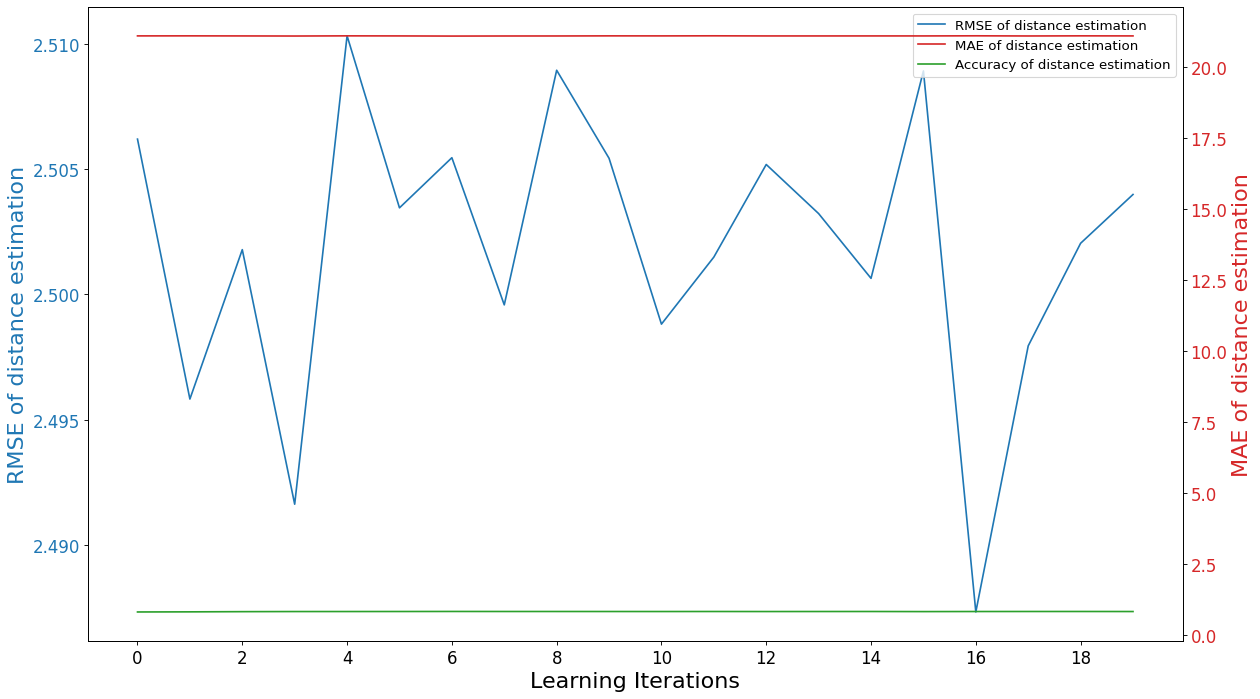

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1]))

Skipping batch with mismatched shapes: (7, 128), (104,)
Skipping batch with mismatched shapes: (7, 128), (104,)
Validation Accuracy: 0.819
Validation Precision: 0.8256106321839081
Validation Recall: 0.6232222656449119
Validation F1 Score: 0.6460689207448588
Validation AUROC: 0

Element Nums of each class:  [229 771]

Correct Nums of each class:  [ 60 759]

Accuracy of IIns-VAE of each class: [26.200873362445414, 98.44357976653697]

[Train epoch = 21], loss: 3.887, RMSE: 2.477, MAE: 20.898, ACC: 0.838, Recon_Err: 0.000, Time: 0.192 (100), Memory_usage: 3719.301
[Validate] loss_val: 3.977, RMSE_val: 2.508, MAE_val: 21.077, ACC_val: 0.818, Recon_val: 0.119, Time_val (100): 0.013, Accuracy: 0.819, Precision: 0.826, Recall: 0.623, F1 Score: 0.646, AUROC: 0.000


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([104])) that is different to the input size (torch.Size([104, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1]

Skipping batch with mismatched shapes: (7, 128), (104,)
Skipping batch with mismatched shapes: (7, 128), (104,)
Validation Accuracy: 0.819
Validation Precision: 0.8256106321839081
Validation Recall: 0.6232222656449119
Validation F1 Score: 0.6460689207448588
Validation AUROC: 0

Element Nums of each class:  [229 771]

Correct Nums of each class:  [ 60 759]

Accuracy of IIns-VAE of each class: [26.200873362445414, 98.44357976653697]

[Train epoch = 22], loss: 3.884, RMSE: 2.479, MAE: 20.897, ACC: 0.837, Recon_Err: 0.000, Time: 0.194 (100), Memory_usage: 3719.305
[Validate] loss_val: 3.971, RMSE_val: 2.494, MAE_val: 21.080, ACC_val: 0.819, Recon_val: 0.118, Time_val (100): 0.013, Accuracy: 0.819, Precision: 0.826, Recall: 0.623, F1 Score: 0.646, AUROC: 0.000


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([104])) that is different to the input size (torch.Size([104, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1]

Skipping batch with mismatched shapes: (7, 128), (104,)
Skipping batch with mismatched shapes: (7, 128), (104,)
Validation Accuracy: 0.818
Validation Precision: 0.8198046430524153
Validation Recall: 0.6225737572143023
Validation F1 Score: 0.6450830349690715
Validation AUROC: 0

Element Nums of each class:  [229 771]

Correct Nums of each class:  [ 60 758]

Accuracy of IIns-VAE of each class: [26.200873362445414, 98.31387808041504]

[Train epoch = 23], loss: 3.896, RMSE: 2.496, MAE: 20.896, ACC: 0.835, Recon_Err: 0.000, Time: 0.206 (100), Memory_usage: 3719.309
[Validate] loss_val: 3.965, RMSE_val: 2.507, MAE_val: 21.076, ACC_val: 0.820, Recon_val: 0.117, Time_val (100): 0.017, Accuracy: 0.818, Precision: 0.820, Recall: 0.623, F1 Score: 0.645, AUROC: 0.000


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([104])) that is different to the input size (torch.Size([104, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1]

Skipping batch with mismatched shapes: (7, 128), (104,)
Skipping batch with mismatched shapes: (7, 128), (104,)
Validation Accuracy: 0.817
Validation Precision: 0.8141527056213882
Validation Recall: 0.6219252487836927
Validation F1 Score: 0.6441011219566269
Validation AUROC: 0

Element Nums of each class:  [229 771]

Correct Nums of each class:  [ 60 757]

Accuracy of IIns-VAE of each class: [26.200873362445414, 98.18417639429312]

[Train epoch = 24], loss: 3.886, RMSE: 2.481, MAE: 20.896, ACC: 0.840, Recon_Err: 0.000, Time: 0.282 (100), Memory_usage: 3719.312
[Validate] loss_val: 3.967, RMSE_val: 2.503, MAE_val: 21.075, ACC_val: 0.818, Recon_val: 0.117, Time_val (100): 0.015, Accuracy: 0.817, Precision: 0.814, Recall: 0.622, F1 Score: 0.644, AUROC: 0.000


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([104])) that is different to the input size (torch.Size([104, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1]

Skipping batch with mismatched shapes: (7, 128), (104,)
Skipping batch with mismatched shapes: (7, 128), (104,)
Validation Accuracy: 0.819
Validation Precision: 0.8256106321839081
Validation Recall: 0.6232222656449119
Validation F1 Score: 0.6460689207448588
Validation AUROC: 0

Element Nums of each class:  [229 771]

Correct Nums of each class:  [ 60 759]

Accuracy of IIns-VAE of each class: [26.200873362445414, 98.44357976653697]

[Train epoch = 25], loss: 3.890, RMSE: 2.478, MAE: 20.902, ACC: 0.837, Recon_Err: 0.000, Time: 0.197 (100), Memory_usage: 3719.316
[Validate] loss_val: 3.976, RMSE_val: 2.486, MAE_val: 21.075, ACC_val: 0.819, Recon_val: 0.118, Time_val (100): 0.013, Accuracy: 0.819, Precision: 0.826, Recall: 0.623, F1 Score: 0.646, AUROC: 0.000


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([104])) that is different to the input size (torch.Size([104, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1]

Skipping batch with mismatched shapes: (7, 128), (104,)
Skipping batch with mismatched shapes: (7, 128), (104,)
Validation Accuracy: 0.819
Validation Precision: 0.8256106321839081
Validation Recall: 0.6232222656449119
Validation F1 Score: 0.6460689207448588
Validation AUROC: 0

Element Nums of each class:  [229 771]

Correct Nums of each class:  [ 60 759]

Accuracy of IIns-VAE of each class: [26.200873362445414, 98.44357976653697]

[Train epoch = 26], loss: 3.891, RMSE: 2.485, MAE: 20.895, ACC: 0.836, Recon_Err: 0.000, Time: 0.192 (100), Memory_usage: 3719.320
[Validate] loss_val: 3.965, RMSE_val: 2.508, MAE_val: 21.076, ACC_val: 0.819, Recon_val: 0.117, Time_val (100): 0.011, Accuracy: 0.819, Precision: 0.826, Recall: 0.623, F1 Score: 0.646, AUROC: 0.000


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([104])) that is different to the input size (torch.Size([104, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1]

Skipping batch with mismatched shapes: (7, 128), (104,)
Skipping batch with mismatched shapes: (7, 128), (104,)
Validation Accuracy: 0.818
Validation Precision: 0.8198046430524153
Validation Recall: 0.6225737572143023
Validation F1 Score: 0.6450830349690715
Validation AUROC: 0

Element Nums of each class:  [229 771]

Correct Nums of each class:  [ 60 758]

Accuracy of IIns-VAE of each class: [26.200873362445414, 98.31387808041504]

[Train epoch = 27], loss: 3.903, RMSE: 2.486, MAE: 20.898, ACC: 0.835, Recon_Err: 0.000, Time: 0.168 (100), Memory_usage: 3719.324
[Validate] loss_val: 3.972, RMSE_val: 2.512, MAE_val: 21.076, ACC_val: 0.818, Recon_val: 0.118, Time_val (100): 0.013, Accuracy: 0.818, Precision: 0.820, Recall: 0.623, F1 Score: 0.645, AUROC: 0.000


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([104])) that is different to the input size (torch.Size([104, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1]

Skipping batch with mismatched shapes: (7, 128), (104,)
Skipping batch with mismatched shapes: (7, 128), (104,)
Validation Accuracy: 0.818
Validation Precision: 0.8198046430524153
Validation Recall: 0.6225737572143023
Validation F1 Score: 0.6450830349690715
Validation AUROC: 0

Element Nums of each class:  [229 771]

Correct Nums of each class:  [ 60 758]

Accuracy of IIns-VAE of each class: [26.200873362445414, 98.31387808041504]

[Train epoch = 28], loss: 3.882, RMSE: 2.491, MAE: 20.897, ACC: 0.837, Recon_Err: 0.000, Time: 0.185 (100), Memory_usage: 3719.328
[Validate] loss_val: 3.969, RMSE_val: 2.503, MAE_val: 21.078, ACC_val: 0.818, Recon_val: 0.118, Time_val (100): 0.014, Accuracy: 0.818, Precision: 0.820, Recall: 0.623, F1 Score: 0.645, AUROC: 0.000


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([104])) that is different to the input size (torch.Size([104, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1]

Skipping batch with mismatched shapes: (7, 128), (104,)
Skipping batch with mismatched shapes: (7, 128), (104,)
Validation Accuracy: 0.818
Validation Precision: 0.8198046430524153
Validation Recall: 0.6225737572143023
Validation F1 Score: 0.6450830349690715
Validation AUROC: 0

Element Nums of each class:  [229 771]

Correct Nums of each class:  [ 60 758]

Accuracy of IIns-VAE of each class: [26.200873362445414, 98.31387808041504]

[Train epoch = 29], loss: 3.891, RMSE: 2.482, MAE: 20.898, ACC: 0.837, Recon_Err: 0.000, Time: 0.221 (100), Memory_usage: 3719.332
[Validate] loss_val: 3.970, RMSE_val: 2.504, MAE_val: 21.077, ACC_val: 0.818, Recon_val: 0.118, Time_val (100): 0.014, Accuracy: 0.818, Precision: 0.820, Recall: 0.623, F1 Score: 0.645, AUROC: 0.000


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([104])) that is different to the input size (torch.Size([104, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1]

Skipping batch with mismatched shapes: (7, 128), (104,)
Skipping batch with mismatched shapes: (7, 128), (104,)
Validation Accuracy: 0.818
Validation Precision: 0.8198046430524153
Validation Recall: 0.6225737572143023
Validation F1 Score: 0.6450830349690715
Validation AUROC: 0

Element Nums of each class:  [229 771]

Correct Nums of each class:  [ 60 758]

Accuracy of IIns-VAE of each class: [26.200873362445414, 98.31387808041504]

[Train epoch = 30], loss: 3.900, RMSE: 2.487, MAE: 20.899, ACC: 0.837, Recon_Err: 0.000, Time: 0.189 (100), Memory_usage: 3719.336
[Validate] loss_val: 3.970, RMSE_val: 2.499, MAE_val: 21.072, ACC_val: 0.818, Recon_val: 0.118, Time_val (100): 0.011, Accuracy: 0.818, Precision: 0.820, Recall: 0.623, F1 Score: 0.645, AUROC: 0.000


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([104])) that is different to the input size (torch.Size([104, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1]

Skipping batch with mismatched shapes: (7, 128), (104,)
Skipping batch with mismatched shapes: (7, 128), (104,)
Validation Accuracy: 0.818
Validation Precision: 0.8198046430524153
Validation Recall: 0.6225737572143023
Validation F1 Score: 0.6450830349690715
Validation AUROC: 0

Element Nums of each class:  [229 771]

Correct Nums of each class:  [ 60 758]

Accuracy of IIns-VAE of each class: [26.200873362445414, 98.31387808041504]

[Train epoch = 31], loss: 3.898, RMSE: 2.487, MAE: 20.898, ACC: 0.839, Recon_Err: 0.000, Time: 0.170 (100), Memory_usage: 3719.340
[Validate] loss_val: 3.965, RMSE_val: 2.492, MAE_val: 21.079, ACC_val: 0.818, Recon_val: 0.117, Time_val (100): 0.011, Accuracy: 0.818, Precision: 0.820, Recall: 0.623, F1 Score: 0.645, AUROC: 0.000


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([104])) that is different to the input size (torch.Size([104, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1]

Skipping batch with mismatched shapes: (7, 128), (104,)
Skipping batch with mismatched shapes: (7, 128), (104,)
Validation Accuracy: 0.817
Validation Precision: 0.806871906112687
Validation Recall: 0.6249950441495478
Validation F1 Score: 0.6479083253327074
Validation AUROC: 0

Element Nums of each class:  [229 771]

Correct Nums of each class:  [ 62 755]

Accuracy of IIns-VAE of each class: [27.074235807860266, 97.92477302204928]

[Train epoch = 32], loss: 3.891, RMSE: 2.477, MAE: 20.898, ACC: 0.835, Recon_Err: 0.000, Time: 0.169 (100), Memory_usage: 3719.344
[Validate] loss_val: 3.973, RMSE_val: 2.502, MAE_val: 21.078, ACC_val: 0.817, Recon_val: 0.118, Time_val (100): 0.011, Accuracy: 0.817, Precision: 0.807, Recall: 0.625, F1 Score: 0.648, AUROC: 0.000


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([104])) that is different to the input size (torch.Size([104, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1]

Skipping batch with mismatched shapes: (7, 128), (104,)
Skipping batch with mismatched shapes: (7, 128), (104,)
Validation Accuracy: 0.817
Validation Precision: 0.806871906112687
Validation Recall: 0.6249950441495478
Validation F1 Score: 0.6479083253327074
Validation AUROC: 0

Element Nums of each class:  [229 771]

Correct Nums of each class:  [ 62 755]

Accuracy of IIns-VAE of each class: [27.074235807860266, 97.92477302204928]

[Train epoch = 33], loss: 3.887, RMSE: 2.494, MAE: 20.896, ACC: 0.838, Recon_Err: 0.000, Time: 0.173 (100), Memory_usage: 3719.348
[Validate] loss_val: 3.967, RMSE_val: 2.501, MAE_val: 21.076, ACC_val: 0.815, Recon_val: 0.118, Time_val (100): 0.011, Accuracy: 0.817, Precision: 0.807, Recall: 0.625, F1 Score: 0.648, AUROC: 0.000


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([104])) that is different to the input size (torch.Size([104, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1]

Skipping batch with mismatched shapes: (7, 128), (104,)
Skipping batch with mismatched shapes: (7, 128), (104,)
Validation Accuracy: 0.818
Validation Precision: 0.8198046430524153
Validation Recall: 0.6225737572143023
Validation F1 Score: 0.6450830349690715
Validation AUROC: 0

Element Nums of each class:  [229 771]

Correct Nums of each class:  [ 60 758]

Accuracy of IIns-VAE of each class: [26.200873362445414, 98.31387808041504]

[Train epoch = 34], loss: 3.882, RMSE: 2.481, MAE: 20.898, ACC: 0.837, Recon_Err: 0.000, Time: 0.173 (100), Memory_usage: 3719.352
[Validate] loss_val: 3.972, RMSE_val: 2.498, MAE_val: 21.071, ACC_val: 0.819, Recon_val: 0.118, Time_val (100): 0.014, Accuracy: 0.818, Precision: 0.820, Recall: 0.623, F1 Score: 0.645, AUROC: 0.000


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([104])) that is different to the input size (torch.Size([104, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1]

Skipping batch with mismatched shapes: (7, 128), (104,)
Skipping batch with mismatched shapes: (7, 128), (104,)
Validation Accuracy: 0.817
Validation Precision: 0.806871906112687
Validation Recall: 0.6249950441495478
Validation F1 Score: 0.6479083253327074
Validation AUROC: 0

Element Nums of each class:  [229 771]

Correct Nums of each class:  [ 62 755]

Accuracy of IIns-VAE of each class: [27.074235807860266, 97.92477302204928]

[Train epoch = 35], loss: 3.882, RMSE: 2.488, MAE: 20.896, ACC: 0.838, Recon_Err: 0.000, Time: 0.226 (100), Memory_usage: 3719.355
[Validate] loss_val: 3.974, RMSE_val: 2.497, MAE_val: 21.074, ACC_val: 0.817, Recon_val: 0.118, Time_val (100): 0.013, Accuracy: 0.817, Precision: 0.807, Recall: 0.625, F1 Score: 0.648, AUROC: 0.000


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([104])) that is different to the input size (torch.Size([104, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1]

Skipping batch with mismatched shapes: (7, 128), (104,)
Skipping batch with mismatched shapes: (7, 128), (104,)
Validation Accuracy: 0.817
Validation Precision: 0.8035326086956522
Validation Recall: 0.6265299418324752
Validation F1 Score: 0.6497735010592917
Validation AUROC: 0

Element Nums of each class:  [229 771]

Correct Nums of each class:  [ 63 754]

Accuracy of IIns-VAE of each class: [27.510917030567683, 97.79507133592736]

[Train epoch = 36], loss: 3.893, RMSE: 2.485, MAE: 20.898, ACC: 0.835, Recon_Err: 0.000, Time: 0.169 (100), Memory_usage: 3719.359
[Validate] loss_val: 3.966, RMSE_val: 2.502, MAE_val: 21.076, ACC_val: 0.817, Recon_val: 0.117, Time_val (100): 0.011, Accuracy: 0.817, Precision: 0.804, Recall: 0.627, F1 Score: 0.650, AUROC: 0.000


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([104])) that is different to the input size (torch.Size([104, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1]

Skipping batch with mismatched shapes: (7, 128), (104,)
Skipping batch with mismatched shapes: (7, 128), (104,)
Validation Accuracy: 0.817
Validation Precision: 0.806871906112687
Validation Recall: 0.6249950441495478
Validation F1 Score: 0.6479083253327074
Validation AUROC: 0

Element Nums of each class:  [229 771]

Correct Nums of each class:  [ 62 755]

Accuracy of IIns-VAE of each class: [27.074235807860266, 97.92477302204928]

[Train epoch = 37], loss: 3.884, RMSE: 2.488, MAE: 20.896, ACC: 0.834, Recon_Err: 0.000, Time: 0.171 (100), Memory_usage: 3719.363
[Validate] loss_val: 3.968, RMSE_val: 2.512, MAE_val: 21.077, ACC_val: 0.817, Recon_val: 0.117, Time_val (100): 0.011, Accuracy: 0.817, Precision: 0.807, Recall: 0.625, F1 Score: 0.648, AUROC: 0.000


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([104])) that is different to the input size (torch.Size([104, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1]

Skipping batch with mismatched shapes: (7, 128), (104,)
Skipping batch with mismatched shapes: (7, 128), (104,)
Validation Accuracy: 0.818
Validation Precision: 0.8086147418188816
Validation Recall: 0.6271784502630848
Validation F1 Score: 0.650762948635289
Validation AUROC: 0

Element Nums of each class:  [229 771]

Correct Nums of each class:  [ 63 755]

Accuracy of IIns-VAE of each class: [27.510917030567683, 97.92477302204928]

[Train epoch = 38], loss: 3.895, RMSE: 2.482, MAE: 20.899, ACC: 0.837, Recon_Err: 0.000, Time: 0.170 (100), Memory_usage: 3719.367
[Validate] loss_val: 3.970, RMSE_val: 2.504, MAE_val: 21.082, ACC_val: 0.819, Recon_val: 0.117, Time_val (100): 0.011, Accuracy: 0.818, Precision: 0.809, Recall: 0.627, F1 Score: 0.651, AUROC: 0.000


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([104])) that is different to the input size (torch.Size([104, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1]

Skipping batch with mismatched shapes: (7, 128), (104,)
Skipping batch with mismatched shapes: (7, 128), (104,)
Validation Accuracy: 0.816
Validation Precision: 0.7985733284971588
Validation Recall: 0.6258814334018656
Validation F1 Score: 0.6487879366291276
Validation AUROC: 0

Element Nums of each class:  [229 771]

Correct Nums of each class:  [ 63 753]

Accuracy of IIns-VAE of each class: [27.510917030567683, 97.66536964980544]

[Train epoch = 39], loss: 3.885, RMSE: 2.491, MAE: 20.897, ACC: 0.837, Recon_Err: 0.000, Time: 0.168 (100), Memory_usage: 3719.371
[Validate] loss_val: 3.966, RMSE_val: 2.495, MAE_val: 21.076, ACC_val: 0.816, Recon_val: 0.118, Time_val (100): 0.012, Accuracy: 0.816, Precision: 0.799, Recall: 0.626, F1 Score: 0.649, AUROC: 0.000


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([104])) that is different to the input size (torch.Size([104, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1]

Skipping batch with mismatched shapes: (7, 128), (104,)
Skipping batch with mismatched shapes: (7, 128), (104,)
Validation Accuracy: 0.818
Validation Precision: 0.8198046430524153
Validation Recall: 0.6225737572143023
Validation F1 Score: 0.6450830349690715
Validation AUROC: 0

Element Nums of each class:  [229 771]

Correct Nums of each class:  [ 60 758]

Accuracy of IIns-VAE of each class: [26.200873362445414, 98.31387808041504]

[Train epoch = 40], loss: 3.878, RMSE: 2.495, MAE: 20.898, ACC: 0.839, Recon_Err: 0.000, Time: 0.211 (100), Memory_usage: 3719.375
[Validate] loss_val: 3.974, RMSE_val: 2.506, MAE_val: 21.080, ACC_val: 0.816, Recon_val: 0.118, Time_val (100): 0.017, Accuracy: 0.818, Precision: 0.820, Recall: 0.623, F1 Score: 0.645, AUROC: 0.000


<ipython-input-7-cabf343dad60>:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  for cls, color in zip(classes, plt.cm.get_cmap('Pastel1').colors):


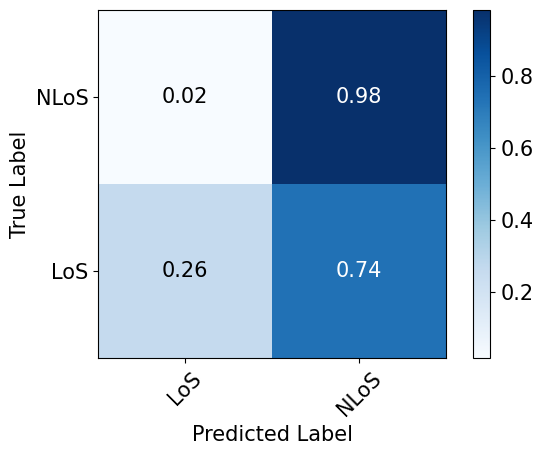

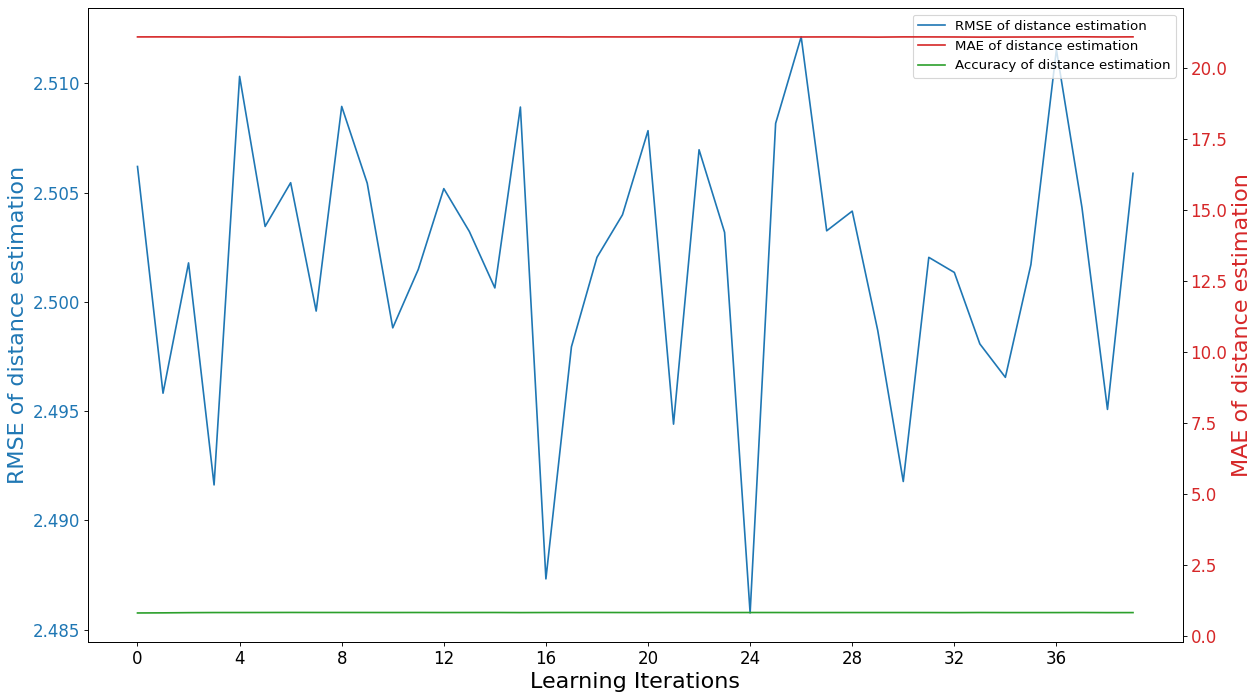

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1]))

Skipping batch with mismatched shapes: (7, 128), (104,)
Skipping batch with mismatched shapes: (7, 128), (104,)
Validation Accuracy: 0.817
Validation Precision: 0.806871906112687
Validation Recall: 0.6249950441495478
Validation F1 Score: 0.6479083253327074
Validation AUROC: 0

Element Nums of each class:  [229 771]

Correct Nums of each class:  [ 62 755]

Accuracy of IIns-VAE of each class: [27.074235807860266, 97.92477302204928]

[Train epoch = 41], loss: 3.887, RMSE: 2.483, MAE: 20.896, ACC: 0.838, Recon_Err: 0.000, Time: 0.202 (100), Memory_usage: 3719.379
[Validate] loss_val: 3.969, RMSE_val: 2.492, MAE_val: 21.075, ACC_val: 0.816, Recon_val: 0.118, Time_val (100): 0.013, Accuracy: 0.817, Precision: 0.807, Recall: 0.625, F1 Score: 0.648, AUROC: 0.000


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([104])) that is different to the input size (torch.Size([104, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1]

Skipping batch with mismatched shapes: (7, 128), (104,)
Skipping batch with mismatched shapes: (7, 128), (104,)
Validation Accuracy: 0.816
Validation Precision: 0.7985733284971588
Validation Recall: 0.6258814334018656
Validation F1 Score: 0.6487879366291276
Validation AUROC: 0

Element Nums of each class:  [229 771]

Correct Nums of each class:  [ 63 753]

Accuracy of IIns-VAE of each class: [27.510917030567683, 97.66536964980544]

[Train epoch = 42], loss: 3.869, RMSE: 2.489, MAE: 20.897, ACC: 0.836, Recon_Err: 0.000, Time: 0.188 (100), Memory_usage: 3719.383
[Validate] loss_val: 3.965, RMSE_val: 2.498, MAE_val: 21.082, ACC_val: 0.816, Recon_val: 0.118, Time_val (100): 0.021, Accuracy: 0.816, Precision: 0.799, Recall: 0.626, F1 Score: 0.649, AUROC: 0.000


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([104])) that is different to the input size (torch.Size([104, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1]

Skipping batch with mismatched shapes: (7, 128), (104,)
Skipping batch with mismatched shapes: (7, 128), (104,)
Validation Accuracy: 0.817
Validation Precision: 0.806871906112687
Validation Recall: 0.6249950441495478
Validation F1 Score: 0.6479083253327074
Validation AUROC: 0

Element Nums of each class:  [229 771]

Correct Nums of each class:  [ 62 755]

Accuracy of IIns-VAE of each class: [27.074235807860266, 97.92477302204928]

[Train epoch = 43], loss: 3.891, RMSE: 2.488, MAE: 20.897, ACC: 0.835, Recon_Err: 0.000, Time: 0.283 (100), Memory_usage: 3719.387
[Validate] loss_val: 3.965, RMSE_val: 2.502, MAE_val: 21.078, ACC_val: 0.818, Recon_val: 0.117, Time_val (100): 0.015, Accuracy: 0.817, Precision: 0.807, Recall: 0.625, F1 Score: 0.648, AUROC: 0.000


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([104])) that is different to the input size (torch.Size([104, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1]

Skipping batch with mismatched shapes: (7, 128), (104,)
Skipping batch with mismatched shapes: (7, 128), (104,)
Validation Accuracy: 0.816
Validation Precision: 0.7985733284971588
Validation Recall: 0.6258814334018656
Validation F1 Score: 0.6487879366291276
Validation AUROC: 0

Element Nums of each class:  [229 771]

Correct Nums of each class:  [ 63 753]

Accuracy of IIns-VAE of each class: [27.510917030567683, 97.66536964980544]

[Train epoch = 44], loss: 3.872, RMSE: 2.489, MAE: 20.898, ACC: 0.839, Recon_Err: 0.000, Time: 0.194 (100), Memory_usage: 3719.391
[Validate] loss_val: 3.970, RMSE_val: 2.482, MAE_val: 21.080, ACC_val: 0.815, Recon_val: 0.118, Time_val (100): 0.013, Accuracy: 0.816, Precision: 0.799, Recall: 0.626, F1 Score: 0.649, AUROC: 0.000


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([104])) that is different to the input size (torch.Size([104, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1]

Skipping batch with mismatched shapes: (7, 128), (104,)
Skipping batch with mismatched shapes: (7, 128), (104,)
Validation Accuracy: 0.818
Validation Precision: 0.8086147418188816
Validation Recall: 0.6271784502630848
Validation F1 Score: 0.650762948635289
Validation AUROC: 0

Element Nums of each class:  [229 771]

Correct Nums of each class:  [ 63 755]

Accuracy of IIns-VAE of each class: [27.510917030567683, 97.92477302204928]

[Train epoch = 45], loss: 3.882, RMSE: 2.486, MAE: 20.895, ACC: 0.837, Recon_Err: 0.000, Time: 0.191 (100), Memory_usage: 3719.395
[Validate] loss_val: 3.969, RMSE_val: 2.502, MAE_val: 21.083, ACC_val: 0.817, Recon_val: 0.118, Time_val (100): 0.013, Accuracy: 0.818, Precision: 0.809, Recall: 0.627, F1 Score: 0.651, AUROC: 0.000


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([104])) that is different to the input size (torch.Size([104, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1]

Skipping batch with mismatched shapes: (7, 128), (104,)
Skipping batch with mismatched shapes: (7, 128), (104,)
Validation Accuracy: 0.816
Validation Precision: 0.7985733284971588
Validation Recall: 0.6258814334018656
Validation F1 Score: 0.6487879366291276
Validation AUROC: 0

Element Nums of each class:  [229 771]

Correct Nums of each class:  [ 63 753]

Accuracy of IIns-VAE of each class: [27.510917030567683, 97.66536964980544]

[Train epoch = 46], loss: 3.886, RMSE: 2.488, MAE: 20.898, ACC: 0.834, Recon_Err: 0.000, Time: 0.185 (100), Memory_usage: 3719.398
[Validate] loss_val: 3.968, RMSE_val: 2.485, MAE_val: 21.078, ACC_val: 0.817, Recon_val: 0.118, Time_val (100): 0.011, Accuracy: 0.816, Precision: 0.799, Recall: 0.626, F1 Score: 0.649, AUROC: 0.000


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([104])) that is different to the input size (torch.Size([104, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1]

Skipping batch with mismatched shapes: (7, 128), (104,)
Skipping batch with mismatched shapes: (7, 128), (104,)
Validation Accuracy: 0.815
Validation Precision: 0.7908868787689749
Validation Recall: 0.6267678226541835
Validation F1 Score: 0.6496417823953518
Validation AUROC: 0

Element Nums of each class:  [229 771]

Correct Nums of each class:  [ 64 751]

Accuracy of IIns-VAE of each class: [27.947598253275107, 97.4059662775616]

[Train epoch = 47], loss: 3.885, RMSE: 2.500, MAE: 20.895, ACC: 0.837, Recon_Err: 0.000, Time: 0.197 (100), Memory_usage: 3719.402
[Validate] loss_val: 3.973, RMSE_val: 2.495, MAE_val: 21.077, ACC_val: 0.813, Recon_val: 0.118, Time_val (100): 0.014, Accuracy: 0.815, Precision: 0.791, Recall: 0.627, F1 Score: 0.650, AUROC: 0.000


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([104])) that is different to the input size (torch.Size([104, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1]

Skipping batch with mismatched shapes: (7, 128), (104,)
Skipping batch with mismatched shapes: (7, 128), (104,)
Validation Accuracy: 0.815
Validation Precision: 0.7937323981082949
Validation Recall: 0.625232924971256
Validation F1 Score: 0.6478062134598946
Validation AUROC: 0

Element Nums of each class:  [229 771]

Correct Nums of each class:  [ 63 752]

Accuracy of IIns-VAE of each class: [27.510917030567683, 97.53566796368352]

[Train epoch = 48], loss: 3.892, RMSE: 2.480, MAE: 20.899, ACC: 0.835, Recon_Err: 0.000, Time: 0.222 (100), Memory_usage: 3719.406
[Validate] loss_val: 3.963, RMSE_val: 2.499, MAE_val: 21.078, ACC_val: 0.814, Recon_val: 0.117, Time_val (100): 0.015, Accuracy: 0.815, Precision: 0.794, Recall: 0.625, F1 Score: 0.648, AUROC: 0.000


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([104])) that is different to the input size (torch.Size([104, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1]

Skipping batch with mismatched shapes: (7, 128), (104,)
Skipping batch with mismatched shapes: (7, 128), (104,)
Validation Accuracy: 0.815
Validation Precision: 0.7937323981082949
Validation Recall: 0.625232924971256
Validation F1 Score: 0.6478062134598946
Validation AUROC: 0

Element Nums of each class:  [229 771]

Correct Nums of each class:  [ 63 752]

Accuracy of IIns-VAE of each class: [27.510917030567683, 97.53566796368352]

[Train epoch = 49], loss: 3.876, RMSE: 2.481, MAE: 20.895, ACC: 0.836, Recon_Err: 0.000, Time: 0.182 (100), Memory_usage: 3719.410
[Validate] loss_val: 3.965, RMSE_val: 2.505, MAE_val: 21.078, ACC_val: 0.814, Recon_val: 0.118, Time_val (100): 0.011, Accuracy: 0.815, Precision: 0.794, Recall: 0.625, F1 Score: 0.648, AUROC: 0.000


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([104])) that is different to the input size (torch.Size([104, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1]

Skipping batch with mismatched shapes: (7, 128), (104,)
Skipping batch with mismatched shapes: (7, 128), (104,)
Validation Accuracy: 0.818
Validation Precision: 0.8086147418188816
Validation Recall: 0.6271784502630848
Validation F1 Score: 0.650762948635289
Validation AUROC: 0

Element Nums of each class:  [229 771]

Correct Nums of each class:  [ 63 755]

Accuracy of IIns-VAE of each class: [27.510917030567683, 97.92477302204928]

[Train epoch = 50], loss: 3.887, RMSE: 2.488, MAE: 20.897, ACC: 0.837, Recon_Err: 0.000, Time: 0.173 (100), Memory_usage: 3719.414
[Validate] loss_val: 3.968, RMSE_val: 2.508, MAE_val: 21.077, ACC_val: 0.818, Recon_val: 0.118, Time_val (100): 0.011, Accuracy: 0.818, Precision: 0.809, Recall: 0.627, F1 Score: 0.651, AUROC: 0.000
Memory Usage After Training: Allocated 3719.67 MB, Reserved 7086.00 MB


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([104])) that is different to the input size (torch.Size([104, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


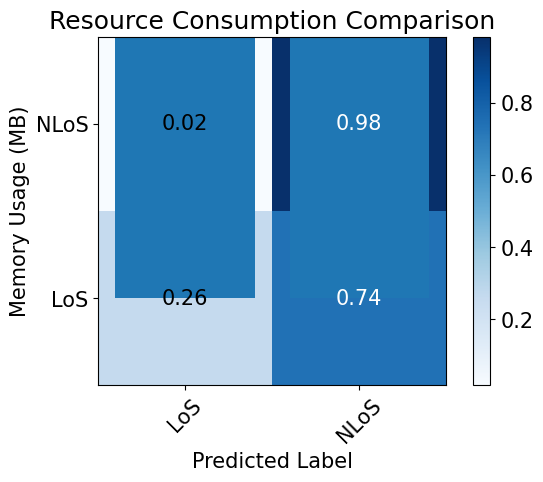

Finished Training under Transfer Learning Setting...


In [ ]:
# Train IIns-VAE
source_data = train_data_source_1
target_train_data = train_data_target_1
target_test_data = test_data_target_1

# source_data_high_res_2, target_data_low_res_train_2, target_data_low_res_test_2
# source_data_mixed_env_3, target_train_specific_env_3, target_test_specific_env_3

df_iins_vae_train = train_model_iins_transfer(
    model, source_data, target_train_data, target_test_data, optimizer, device, opt, model_path, data_path, result_path, scheduler=None,
    integration_level='layer', classifier_type='neural', transfer_learning_mode='train', lambda_vae=1, lambda_reg=1, lambda_cls=1,
)
df_iins_vae_finetune = train_model_iins_transfer(
    model, source_data, target_train_data, target_test_data, optimizer, device, opt, model_path, data_path, result_path, scheduler=None,
    integration_level='layer', classifier_type='neural', transfer_learning_mode='fine-tune', lambda_vae=1, lambda_reg=1, lambda_cls=1,
)

# # Evaluate IIns-VAE
# test_results_iins_vae = test_model_iins_transfer(
#     model, target_test_data, device, opt, model_path, data_path, result_path,
#     integration_level='layer', classifier_type='neural', transfer_learning_mode_baselines='fine-tune', lambda_vae=1, lambda_reg=1, lambda_cls=1,
# )
# print(f'IIns-VAE results: {test_results_iins_vae}')

In [ ]:
df_iins_vae_whole = train_model_iins_transfer(
    model, source_data, target_train_data, target_test_data, optimizer, device, opt, model_path, data_path, result_path, scheduler=None,
    integration_level='layer', classifier_type='neural', transfer_learning_mode='whole-dataset', lambda_vae=1, lambda_reg=1, lambda_cls=1,
)

#### 8.2.2 Transfer Learning IIns-VAE Model on Database 2 - High to Low Label Resolutions

In [46]:
# Assign data
input_dim = 157
args['dataset_name'] = 'db2'
source_data = source_data_high_res_2
target_train_data = target_data_low_res_train_2
target_test_data = target_data_low_res_test_2

# Assign paths and hyperparameters
args['model_path'] = '/content/drive/MyDrive/WirelessSensing/IIns-MRC/IIns_VAE/model_TF2'
args['data_path'] = '/content/drive/MyDrive/WirelessSensing/IIns-MRC/IIns_VAE/data_TF2'
args['result_path'] = '/content/drive/MyDrive/WirelessSensing/IIns-MRC/IIns_VAE/result_TF2'
os.makedirs(args['model_path'], exist_ok=True)
os.makedirs(args['data_path'], exist_ok=True)
os.makedirs(args['result_path'], exist_ok=True)
model_path = args['model_path']
data_path = args['data_path']
result_path = args['result_path']
opt = args

# Assign optimizer and device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


cuda


In [47]:
# Normal neural classifier
encoder = Encoder(filters=args['filters'], n_residual=args['n_residual'], n_downsample=args['n_downsample'], range_dim=args['range_dim'], env_dim=args['env_dim'], input_dim=input_dim)
decoder = Decoder(filters=args['filters'], n_residual=args['n_residual'], n_upsample=args['n_downsample'], range_dim=args['range_dim'], env_dim=args['env_dim'], out_dim=input_dim)
regressor = Regressor(range_dim=args['range_dim'])
classifier_base = ClassifierCut(env_dim=args['env_dim'], z_dim=args['z_dim'])
classifier_layer1 = ClassifierLayer(z_dim=args['z_dim'], num_classes=11)

classifier_mrc_bi = ClassifierMRCs(mrc_type='mrc', phi='linear', loss='0-1')
classifier_mrc_log = ClassifierMRCs(mrc_type='mrc', phi='linear', loss='log')
classifier_cmrc_bi = ClassifierMRCs(mrc_type='cmrc', phi='linear', loss='0-1')
classifier_cmrc_bi_fourier = ClassifierMRCs(mrc_type='cmrc', phi='fourier', loss='0-1')
classifier_cmrc_log_fourier = ClassifierMRCs(mrc_type='cmrc', phi='fourier', loss='log')

# Tune final classifier layer
model_source = IInsVAEMRC(
    encoder, decoder, regressor, classifier_base, classifier_layer1,
    classifier_mrc=None, integration_level='layer', classifier_type='neural'
  )


Use 2D Convolutional Encoder for range and env codes.
Use 2D Convolutional Decoder for range and env codes.
Use Linear Regressor for range constraint.


Memory Usage Before Training: Allocated 6247.21 MB, Reserved 8968.00 MB
Start Training the IInsVAE under the Transfer Learning Setting...
Memory Usage Before Training: Allocated 6247.21 MB, Reserved 8968.00 MB
Starting Training the IInsVAE...
Total Epochs: 20


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


[step = 200] loss: 1644.492, ae_loss: 1642.489, reg_loss: 0.131, cls_loss: 1.872latent_loss: 0.000, RMSE: 2.329, MAE: 16.755, ACC: 0.001, Recon_err: 94590.164, Time (100): 0.151


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([12])) that is different to the input size (torch.Size([12, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


[step = 200] loss: 1644.998, ae_loss: 1643.298, reg_loss: 0.132, cls_loss: 1.568latent_loss: 0.000, RMSE: 2.359, MAE: 16.861, ACC: 0.002, Recon_err: 94658.828, Time (100): 0.143
[step = 200] loss: 1643.334, ae_loss: 1641.699, reg_loss: 0.131, cls_loss: 1.504latent_loss: 0.000, RMSE: 2.320, MAE: 16.729, ACC: 0.003, Recon_err: 94479.148, Time (100): 0.126
[step = 200] loss: 1646.655, ae_loss: 1645.060, reg_loss: 0.132, cls_loss: 1.463latent_loss: 0.000, RMSE: 2.347, MAE: 16.878, ACC: 0.002, Recon_err: 94825.680, Time (100): 0.121
[step = 200] loss: 1646.744, ae_loss: 1645.189, reg_loss: 0.132, cls_loss: 1.423latent_loss: 0.000, RMSE: 2.344, MAE: 16.906, ACC: 0.002, Recon_err: 94791.750, Time (100): 0.123
[step = 200] loss: 1646.782, ae_loss: 1645.245, reg_loss: 0.132, cls_loss: 1.405latent_loss: 0.000, RMSE: 2.357, MAE: 16.878, ACC: 0.002, Recon_err: 94794.438, Time (100): 0.121
[step = 200] loss: 1645.614, ae_loss: 1644.112, reg_loss: 0.131, cls_loss: 1.370latent_loss: 0.000, RMSE: 2.33

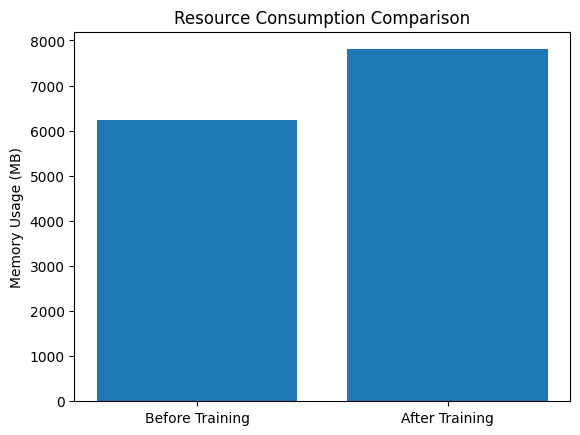

Finished Training...


In [55]:
# Train IIns-VAE
args['num_classes'] = 11
args['n_epochs'] = 20
model_source_TF2, df_history = train_model_iins_transfer_mrc(
    model_source, source_data, target_train_data, target_test_data, device, opt, model_path, data_path, result_path, scheduler=None,
    integration_level='layer', classifier_type='neural', transfer_learning_mode='source', lambda_vae=1, lambda_reg=1, lambda_cls=1,
)


In [57]:
model_source.load_state_dict(torch.load(os.path.join(model_path, "%s_%d.pth" % ('IIns-VAE', opt['n_epochs']))))
print(model_source)

<ipython-input-57-76d51c9df739>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_source.load_state_dict(torch.load(os.path.join(model_path, "%s_%d.pth" % ('IIns-VAE', 

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/WirelessSensing/IIns-MRC/IIns_VAE/model_TF2/IIns-VAE_20.pth'

In [ ]:
args['num_classes'] = 5
classifier_layer2 = ClassifierLayer(z_dim=args['z_dim'], num_classes=5)
model_source = model_source_TF2
model_target = IInsVAEMRC(
    model_source.encoder, model_source.decoder, model_source.regressor, model_source.classifier_base, classifier_layer2,
    classifier_mrc=None, integration_level='layer', classifier_type='neural'
  )  # source domain and target domain have different classes
model_target, df_history = train_model_iins_transfer_mrc(
    model_target, source_data, target_train_data, target_test_data, device, opt, model_path, data_path, result_path, scheduler=None,
    integration_level='layer', classifier_type='neural', transfer_learning_mode='target', lambda_vae=1, lambda_reg=1, lambda_cls=1,
)


In [ ]:
# Evaluate IIns-VAE
test_results_iins_vae = test_model_iins_transfer(
    model, target_test_data, device, opt, model_path, data_path, result_path,
    integration_level='layer', classifier_type='neural', transfer_learning_mode_baselines='fine-tune', lambda_vae=1, lambda_reg=1, lambda_cls=1,
)
print(f'IIns-VAE results: {test_results_iins_vae}')

#### 8.2.3 Transfer Learning IIns-VAE Model on Database 2 - Mixed to Specific Environment


In [ ]:
# Assign data
input_dim = 157
args['dataset_name'] = 'db2'
source_data = source_data_mixed_env_3
target_train_data = target_train_specific_env_3
target_test_data = target_test_specific_env_3

# Assign model
model = model_vae_tune_layer

# Assign paths and hyperparameters
args['model_path'] = '/content/drive/MyDrive/WirelessSensing/IIns-MRC/IIns_VAE/model_TF3'
args['data_path'] = '/content/drive/MyDrive/WirelessSensing/IIns-MRC/IIns_VAE/data_TF3'
args['result_path'] = '/content/drive/MyDrive/WirelessSensing/IIns-MRC/IIns_VAE/result_TF3'
os.makedirs(args['model_path'], exist_ok=True)
os.makedirs(args['data_path'], exist_ok=True)
os.makedirs(args['result_path'], exist_ok=True)
model_path = args['model_path']
data_path = args['data_path']
result_path = args['result_path']
opt = args

# Assign optimizer and device
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=args['decay_epoch'], gamma=0.1, last_epoch=-1)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

In [ ]:
# Normal neural classifier
encoder = Encoder(filters=args['filters'], n_residual=args['n_residual'], n_downsample=args['n_downsample'], range_dim=args['range_dim'], env_dim=args['env_dim'], input_dim=input_dim)
decoder = Decoder(filters=args['filters'], n_residual=args['n_residual'], n_upsample=args['n_downsample'], range_dim=args['range_dim'], env_dim=args['env_dim'], out_dim=input_dim)
regressor = Regressor(range_dim=args['range_dim'])
classifier_base = ClassifierCut(env_dim=args['env_dim'], z_dim=args['z_dim'])
classifier_layer = ClassifierLayer(z_dim=args['z_dim'], num_classes=args['num_classes'])

classifier_mrc_bi = ClassifierMRCs(mrc_type='mrc', phi='linear', loss='0-1')
classifier_mrc_log = ClassifierMRCs(mrc_type='mrc', phi='linear', loss='log')
classifier_cmrc_bi = ClassifierMRCs(mrc_type='cmrc', phi='linear', loss='0-1')
classifier_cmrc_bi_fourier = ClassifierMRCs(mrc_type='cmrc', phi='fourier', loss='0-1')
classifier_cmrc_log_fourier = ClassifierMRCs(mrc_type='cmrc', phi='fourier', loss='log')

# Tune final classifier layer
model_vae_tune_layer = IInsVAEMRC(
    encoder, decoder, regressor, classifier_base, classifier_layer,
    classifier_mrc=None, integration_level='layer', classifier_type='neural'
  )

# Tune the whole classifier params
model_vae_tune_bottleneck = IInsVAEMRC(
    encoder, decoder, regressor, classifier_base, classifier_layer,
    classifier_mrc=None, integration_level='bottleneck', classifier_type='neural'
  )

# Assign model
model_source = model_vae_tune_layer


In [ ]:
# Train IIns-VAE
model_source_TF3, df_history = train_model_iins_transfer_mrc(
    model_source, source_data, target_train_data, target_test_data, device, opt, model_path, data_path, result_path, scheduler=None,
    integration_level='layer', classifier_type='neural', transfer_learning_mode='source', lambda_vae=1, lambda_reg=1, lambda_cls=1,
)
model_target, df_history = train_model_iins_transfer_mrc(
    model_source_TF3, model_target, source_data, target_train_data, target_test_data, device, opt, model_path, data_path, result_path, scheduler=None,
    integration_level='layer', classifier_type='neural', transfer_learning_mode='target', lambda_vae=1, lambda_reg=1, lambda_cls=1,
)

In [ ]:
# Evaluate IIns-VAE
test_results_iins_vae = test_model_iins_transfer(
    model, target_test_data, device, opt, model_path, data_path, result_path,
    integration_level='layer', classifier_type='neural', transfer_learning_mode_baselines='fine-tune', lambda_vae=1, lambda_reg=1, lambda_cls=1,
)
print(f'IIns-VAE results: {test_results_iins_vae}')

### **8.3 IIns-MRCs with Layer Integration**

#### 8.3.1 Transfer Learning IIns-MRC Model on Database 1

In [ ]:
# Assign data
input_dim = 152
args['dataset_name'] = 'db1'
source_data = train_data_source_1
target_train_data = train_data_target_1
target_test_data = test_data_target_1

# Assign model
model = model_mrc

# Assign paths and hyperparameters
args['model_path'] = '/content/drive/MyDrive/WirelessSensing/IIns-MRC/IIns_MRC/model_TF1'
args['data_path'] = '/content/drive/MyDrive/WirelessSensing/IIns-MRC/IIns_MRC/data_TF1'
args['result_path'] = '/content/drive/MyDrive/WirelessSensing/IIns-MRC/IIns_MRC/result_TF1'
os.makedirs(args['model_path'], exist_ok=True)
os.makedirs(args['data_path'], exist_ok=True)
os.makedirs(args['result_path'], exist_ok=True)
model_path = args['model_path']
data_path = args['data_path']
result_path = args['result_path']
opt = args

# Assign optimizer and device
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=args['decay_epoch'], gamma=0.1, last_epoch=-1)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


cuda


In [ ]:
# Normal neural classifier
encoder = Encoder(filters=args['filters'], n_residual=args['n_residual'], n_downsample=args['n_downsample'], range_dim=args['range_dim'], env_dim=args['env_dim'], input_dim=input_dim)
decoder = Decoder(filters=args['filters'], n_residual=args['n_residual'], n_upsample=args['n_downsample'], range_dim=args['range_dim'], env_dim=args['env_dim'], out_dim=input_dim)
regressor = Regressor(range_dim=args['range_dim'])
classifier_base = ClassifierCut(env_dim=args['env_dim'], z_dim=args['z_dim'])
classifier_layer = ClassifierLayer(z_dim=args['z_dim'], num_classes=args['num_classes'])

classifier_mrc_bi = ClassifierMRCs(mrc_type='mrc', phi='linear', loss='0-1')
classifier_mrc_log = ClassifierMRCs(mrc_type='mrc', phi='linear', loss='log')
classifier_cmrc_bi = ClassifierMRCs(mrc_type='cmrc', phi='linear', loss='0-1')
classifier_cmrc_bi_fourier = ClassifierMRCs(mrc_type='cmrc', phi='fourier', loss='0-1')
classifier_cmrc_log_fourier = ClassifierMRCs(mrc_type='cmrc', phi='fourier', loss='log')

# Tune final classifier layer
model_vae_tune_layer = IInsVAEMRC(
    encoder, decoder, regressor, classifier_base, classifier_layer,
    classifier_mrc=None, integration_level='layer', classifier_type='neural'
  )
# model_mrc = IInsVAEMRC(
#     encoder, decoder, regressor, classifier_base, classifier_layer=None,
#     classifier_mrc=classifier_mrc_bi, integration_level='layer', classifier_type='mrc'
#   )  # no need since already inside the loop

# Assign model
model_source = model_vae_tune_layer

In [ ]:
# Train IIns-MRC (not necessary if already have model_source_TF1)
model_source_TF1, df_iins_mrc_train = train_model_iins_transfer_mrc(
    model_source, source_data, target_train_data, target_test_data, device, opt, model_path, data_path, result_path, scheduler=None,
    integration_level='layer', classifier_type='mrc', transfer_learning_mode='source', lambda_vae=1, lambda_reg=1, lambda_cls=1,
)

Memory Usage Before Training: Allocated 1502.57 MB, Reserved 4068.00 MB
Starting Training the IInsVAEMRC under the Transfer Learning Setting...


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


ValueError: optimizer got an empty parameter list

In [ ]:
model_source = model_source_TF1
model_target, df_iins_mrc_finetune = train_model_iins_transfer_mrc(
    model_source, source_data, target_train_data, target_test_data, optimizer, opt, model_path, data_path, result_path, scheduler=None,
    integration_level='layer', classifier_type='mrc', transfer_learning_mode='target', lambda_vae=1, lambda_reg=1, lambda_cls=1,
)

In [ ]:
df_iins_mrc_whole = train_model_iins_transfer(
    model, source_data, target_train_data, target_test_data, optimizer, device, opt, model_path, data_path, result_path, scheduler=None,
    integration_level='layer', classifier_type='mrc', transfer_learning_mode='whole-dataset', lambda_vae=1, lambda_reg=1, lambda_cls=1,
)

#### 8.3.2 Transfer Learning IIns-MRC Model on Database 2 - High to Low Label Resolutions

In [ ]:
# Assign data
input_dim = 157
args['dataset_name'] = 'db2'
source_data = source_data_high_res_2
target_train_data = target_data_low_res_train_2
target_test_data = target_data_low_res_test_2

# Assign model
model = model_mrc

# Assign paths and hyperparameters
args['model_path'] = '/content/drive/MyDrive/WirelessSensing/IIns-MRC/IIns_MRC/model_TF2'
args['data_path'] = '/content/drive/MyDrive/WirelessSensing/IIns-MRC/IIns_MRC/data_TF2'
args['result_path'] = '/content/drive/MyDrive/WirelessSensing/IIns-MRC/IIns_MRC/result_TF2'
os.makedirs(args['model_path'], exist_ok=True)
os.makedirs(args['data_path'], exist_ok=True)
os.makedirs(args['result_path'], exist_ok=True)
model_path = args['model_path']
data_path = args['data_path']
result_path = args['result_path']
opt = args

# Assign optimizer and device
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=args['decay_epoch'], gamma=0.1, last_epoch=-1)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


In [ ]:
# Normal neural classifier
encoder = Encoder(filters=args['filters'], n_residual=args['n_residual'], n_downsample=args['n_downsample'], range_dim=args['range_dim'], env_dim=args['env_dim'], input_dim=input_dim)
decoder = Decoder(filters=args['filters'], n_residual=args['n_residual'], n_upsample=args['n_downsample'], range_dim=args['range_dim'], env_dim=args['env_dim'], out_dim=input_dim)
regressor = Regressor(range_dim=args['range_dim'])
classifier_base = ClassifierCut(env_dim=args['env_dim'], z_dim=args['z_dim'])
classifier_layer = ClassifierLayer(z_dim=args['z_dim'], num_classes=args['num_classes'])

# Basic IIns-VAE (baseline)
model_vae = IInsVAEMRC(
    encoder, decoder, regressor, classifier_base, classifier_layer,
    classifier_mrc=None, integration_level='no-integ', classifier_type='neural',
)

# Tune final classifier layer
model_vae_tune_layer = IInsVAEMRC(
    encoder, decoder, regressor, classifier_base, classifier_layer,
    classifier_mrc=None, integration_level='layer', classifier_type='neural'
  )

# Tune the whole classifier params
model_vae_tune_bottleneck = IInsVAEMRC(
    encoder, decoder, regressor, classifier_base, classifier_layer,
    classifier_mrc=None, integration_level='bottleneck', classifier_type='neural'
  )

# Assign model
model = model_vae_tune_layer

In [ ]:
# Train IIns-MRC (not necessary if already have model_source_TF2)
model_source_TF2, df_iins_mrc_train = train_model_iins_transfer(
    model, source_data, target_train_data, target_test_data, optimizer, device, opt, model_path, data_path, result_path, scheduler=None,
    integration_level='layer', classifier_type='mrc', transfer_learning_mode='train', lambda_vae=1, lambda_reg=1, lambda_cls=1,
)

In [ ]:
model_source = model_source_TF2
model_target, df_iins_mrc_finetune = train_model_iins_transfer(
    model_source, source_data, target_train_data, target_test_data, optimizer, device, opt, model_path, data_path, result_path, scheduler=None,
    integration_level='layer', classifier_type='mrc', transfer_learning_mode='fine-tune', lambda_vae=1, lambda_reg=1, lambda_cls=1,
)

#### 8.3.3 Transfer Learning IIns-MRC Model on Database 2 - Mixed to Specific Environment


In [ ]:
# Assign data
input_dim = 157
args['dataset_name'] = 'db2'
source_data = source_data_high_res_2
target_train_data = target_data_low_res_train_2
target_test_data = target_data_low_res_test_2

# Assign model
model = model_mrc

# Assign paths and hyperparameters
args['model_path'] = '/content/drive/MyDrive/WirelessSensing/IIns-MRC/IIns_MRC/model_TF3'
args['data_path'] = '/content/drive/MyDrive/WirelessSensing/IIns-MRC/IIns_MRC/data_TF3'
args['result_path'] = '/content/drive/MyDrive/WirelessSensing/IIns-MRC/IIns_MRC/result_TF3'
os.makedirs(args['model_path'], exist_ok=True)
os.makedirs(args['data_path'], exist_ok=True)
os.makedirs(args['result_path'], exist_ok=True)
model_path = args['model_path']
data_path = args['data_path']
result_path = args['result_path']
opt = args

# Assign optimizer and device
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=args['decay_epoch'], gamma=0.1, last_epoch=-1)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

In [ ]:
# Normal neural classifier
encoder = Encoder(filters=args['filters'], n_residual=args['n_residual'], n_downsample=args['n_downsample'], range_dim=args['range_dim'], env_dim=args['env_dim'], input_dim=input_dim)
decoder = Decoder(filters=args['filters'], n_residual=args['n_residual'], n_upsample=args['n_downsample'], range_dim=args['range_dim'], env_dim=args['env_dim'], out_dim=input_dim)
regressor = Regressor(range_dim=args['range_dim'])
classifier_base = ClassifierCut(env_dim=args['env_dim'], z_dim=args['z_dim'])
classifier_layer = ClassifierLayer(z_dim=args['z_dim'], num_classes=args['num_classes'])

# Basic IIns-VAE (baseline)
model_vae = IInsVAEMRC(
    encoder, decoder, regressor, classifier_base, classifier_layer,
    classifier_mrc=None, integration_level='no-integ', classifier_type='neural',
)

# Tune final classifier layer
model_vae_tune_layer = IInsVAEMRC(
    encoder, decoder, regressor, classifier_base, classifier_layer,
    classifier_mrc=None, integration_level='layer', classifier_type='neural'
  )

# Tune the whole classifier params
model_vae_tune_bottleneck = IInsVAEMRC(
    encoder, decoder, regressor, classifier_base, classifier_layer,
    classifier_mrc=None, integration_level='bottleneck', classifier_type='neural'
  )

# Assign model
model = model_vae_tune_layer

In [ ]:
# Train IIns-MRC (not necessary if already have model_source_TF3)
model_source_TF3, df_iins_mrc_train = train_model_iins_transfer(
    model, source_data, target_train_data, target_test_data, optimizer, device, opt, model_path, data_path, result_path, scheduler=None,
    integration_level='layer', classifier_type='mrc', transfer_learning_mode='train', lambda_vae=1, lambda_reg=1, lambda_cls=1,
)

In [ ]:
model_source = model_source_TF3
model_target, df_iins_mrc_finetune = train_model_iins_transfer(
    model_source, source_data, target_train_data, target_test_data, optimizer, device, opt, model_path, data_path, result_path, scheduler=None,
    integration_level='layer', classifier_type='mrc', transfer_learning_mode='fine-tune', lambda_vae=1, lambda_reg=1, lambda_cls=1,
)

# # Evaluate IIns-MRC
# test_results_iins_mrc = test_model_iins_transfer(
#     model, target_test_data, device, opt, model_path, data_path, result_path,
#     integration_level='layer', classifier_type='mrc', transfer_learning_mode_baselines='fine-tune', lambda_vae=1, lambda_reg=1, lambda_cls=1,
# )
# print(f'IIns-MRC results: {test_results_iins_mrc}')

### **8.4 IIns-CMRCs with Layer Integration**

#### 8.4.1 Transfer Learning IIns-CMRC Model on Database 1

In [ ]:
# Assign data
input_dim = 152
args['dataset_name'] = 'db1'
source_data = train_data_source_1
target_train_data = train_data_target_1
target_test_data = test_data_target_1

# Assign model
model = model_cmrc

# Assign paths and hyperparameters
args['model_path'] = '/content/drive/MyDrive/WirelessSensing/IIns-MRC/IIns_CMRC/model_TF1'
args['data_path'] = '/content/drive/MyDrive/WirelessSensing/IIns-MRC/IIns_CMRC/data_TF1'
args['result_path'] = '/content/drive/MyDrive/WirelessSensing/IIns-MRC/IIns_CMRC/result_TF1'
os.makedirs(args['model_path'], exist_ok=True)
os.makedirs(args['data_path'], exist_ok=True)
os.makedirs(args['result_path'], exist_ok=True)
model_path = args['model_path']
data_path = args['data_path']
result_path = args['result_path']
opt = args

# Assign optimizer and device
optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'], betas=(args['b1'], args['b2']))
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=args['decay_epoch'], gamma=0.1, last_epoch=-1)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


cuda


In [ ]:
# Normal neural classifier
encoder = Encoder(filters=args['filters'], n_residual=args['n_residual'], n_downsample=args['n_downsample'], range_dim=args['range_dim'], env_dim=args['env_dim'], input_dim=input_dim)
decoder = Decoder(filters=args['filters'], n_residual=args['n_residual'], n_upsample=args['n_downsample'], range_dim=args['range_dim'], env_dim=args['env_dim'], out_dim=input_dim)
regressor = Regressor(range_dim=args['range_dim'])
classifier_base = ClassifierCut(env_dim=args['env_dim'], z_dim=args['z_dim'])
classifier_layer = ClassifierLayer(z_dim=args['z_dim'], num_classes=args['num_classes'])

# Basic IIns-VAE (baseline)
model_vae = IInsVAEMRC(
    encoder, decoder, regressor, classifier_base, classifier_layer,
    classifier_mrc=None, integration_level='no-integ', classifier_type='neural',
)

# Tune final classifier layer
model_vae_tune_layer = IInsVAEMRC(
    encoder, decoder, regressor, classifier_base, classifier_layer,
    classifier_mrc=None, integration_level='layer', classifier_type='neural'
  )

# Tune the whole classifier params
model_vae_tune_bottleneck = IInsVAEMRC(
    encoder, decoder, regressor, classifier_base, classifier_layer,
    classifier_mrc=None, integration_level='bottleneck', classifier_type='neural'
  )

# Assign model
model = model_vae_tune_layer

In [ ]:
# Train IIns-CMRC
model_source, df_iins_cmrc_train = train_model_iins_transfer(
    model, source_data, target_train_data, target_test_data, optimizer, device, opt, model_path, data_path, result_path, scheduler=None,
    integration_level='layer', classifier_type='cmrc', transfer_learning_mode='train', lambda_vae=1, lambda_reg=1, lambda_cls=1,
)
df_iins_cmrc_finetune = train_model_iins_transfer(
    model_source, source_data, target_train_data, target_test_data, optimizer, device, opt, model_path, data_path, result_path, scheduler=None,
    integration_level='layer', classifier_type='cmrc', transfer_learning_mode='fine-tune', lambda_vae=1, lambda_reg=1, lambda_cls=1,
)


Memory Usage Before Training: Allocated 1502.57 MB, Reserved 4068.00 MB
Starting Training the IInsVCMRC under the Transfer Learning Setting...


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


ValueError: optimizer got an empty parameter list

In [ ]:
# Evaluate IIns-CMRC
test_results_iins_cmrc = test_model_iins_transfer(
    model, target_test_data, device, opt, model_path, data_path, result_path,
    integration_level='layer', classifier_type='cmrc', transfer_learning_mode_baselines='fine-tune', lambda_vae=1, lambda_reg=1, lambda_cls=1,
)
print(f'IIns-CMRC results: {test_results_iins_cmrc}')

In [ ]:
df_iins_mrc_whole = train_model_iins_transfer(
    model, source_data, target_train_data, target_test_data, optimizer, device, opt, model_path, data_path, result_path, scheduler=None,
    integration_level='layer', classifier_type='cmrc', transfer_learning_mode='whole-dataset', lambda_vae=1, lambda_reg=1, lambda_cls=1,
)

#### 8.4.2 Transfer Learning IIns-CMRC Model on Database 2 - High to Low Label Resolutions

In [ ]:
# Assign data
input_dim = 157
args['dataset_name'] = 'db2'
source_data = source_data_high_res_2
target_train_data = target_data_low_res_train_2
target_test_data = target_data_low_res_test_2

# Assign model
model = model_cmrc

# Assign paths and hyperparameters
args['model_path'] = '/content/drive/MyDrive/WirelessSensing/IIns-MRC/IIns_CMRC/model_TF2'
args['data_path'] = '/content/drive/MyDrive/WirelessSensing/IIns-MRC/IIns_CMRC/data_TF2'
args['result_path'] = '/content/drive/MyDrive/WirelessSensing/IIns-MRC/IIns_CMRC/result_TF2'
os.makedirs(args['model_path'], exist_ok=True)
os.makedirs(args['data_path'], exist_ok=True)
os.makedirs(args['result_path'], exist_ok=True)
model_path = args['model_path']
data_path = args['data_path']
result_path = args['result_path']
opt = args

# Assign optimizer and device
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=args['decay_epoch'], gamma=0.1, last_epoch=-1)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


cuda


In [ ]:
# Normal neural classifier
encoder = Encoder(filters=args['filters'], n_residual=args['n_residual'], n_downsample=args['n_downsample'], range_dim=args['range_dim'], env_dim=args['env_dim'], input_dim=input_dim)
decoder = Decoder(filters=args['filters'], n_residual=args['n_residual'], n_upsample=args['n_downsample'], range_dim=args['range_dim'], env_dim=args['env_dim'], out_dim=input_dim)
regressor = Regressor(range_dim=args['range_dim'])
classifier_base = ClassifierCut(env_dim=args['env_dim'], z_dim=args['z_dim'])
classifier_layer = ClassifierLayer(z_dim=args['z_dim'], num_classes=args['num_classes'])

# Basic IIns-VAE (baseline)
model_vae = IInsVAEMRC(
    encoder, decoder, regressor, classifier_base, classifier_layer,
    classifier_mrc=None, integration_level='no-integ', classifier_type='neural',
)

# Tune final classifier layer
model_vae_tune_layer = IInsVAEMRC(
    encoder, decoder, regressor, classifier_base, classifier_layer,
    classifier_mrc=None, integration_level='layer', classifier_type='neural'
  )

# Tune the whole classifier params
model_vae_tune_bottleneck = IInsVAEMRC(
    encoder, decoder, regressor, classifier_base, classifier_layer,
    classifier_mrc=None, integration_level='bottleneck', classifier_type='neural'
  )

# Assign model
model = model_vae_tune_layer

In [ ]:
# Train IIns-CMRC
model_source, df_iins_cmrc_train = train_model_iins_transfer(
    model, source_data, target_train_data, target_test_data, optimizer, device, opt, model_path, data_path, result_path, scheduler=None,
    integration_level='layer', classifier_type='cmrc', transfer_learning_mode='train', lambda_vae=1, lambda_reg=1, lambda_cls=1,
)
model_target, df_iins_cmrc_finetune = train_model_iins_transfer(
    model_source, source_data, target_train_data, target_test_data, optimizer, device, opt, model_path, data_path, result_path, scheduler=None,
    integration_level='layer', classifier_type='cmrc', transfer_learning_mode='fine-tune', lambda_vae=1, lambda_reg=1, lambda_cls=1,
)

# # Evaluate IIns-MRC
# test_results_iins_cmrc = test_model_iins_transfer(
#     model, target_test_data, device, opt, model_path, data_path, result_path,
#     integration_level='layer', classifier_type='cmrc', transfer_learning_mode_baselines='fine-tune', lambda_vae=1, lambda_reg=1, lambda_cls=1,
# )
# print(f'IIns-CMRC results: {test_results_iins_cmrc}')

Memory Usage Before Training: Allocated 1478.35 MB, Reserved 4068.00 MB
Starting Training the IInsVCMRC under the Transfer Learning Setting...


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


ValueError: optimizer got an empty parameter list

#### 8.4.3 Transfer Learning IIns-CMRC Model on Database 2 - Mixed to Specific Environment


In [ ]:
# Assign data
input_dim = 157
args['dataset_name'] = 'db2'
source_data = source_data_high_res_2
target_train_data = target_data_low_res_train_2
target_test_data = target_data_low_res_test_2

# Assign model
model = model_cmrc

# Assign paths and hyperparameters
args['model_path'] = '/content/drive/MyDrive/WirelessSensing/IIns-MRC/IIns_CMRC/model_TF3'
args['data_path'] = '/content/drive/MyDrive/WirelessSensing/IIns-MRC/IIns_CMRC/data_TF3'
args['result_path'] = '/content/drive/MyDrive/WirelessSensing/IIns-MRC/IIns_CMRC/result_TF3'
os.makedirs(args['model_path'], exist_ok=True)
os.makedirs(args['data_path'], exist_ok=True)
os.makedirs(args['result_path'], exist_ok=True)
model_path = args['model_path']
data_path = args['data_path']
result_path = args['result_path']
opt = args

# Assign optimizer and device
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=args['decay_epoch'], gamma=0.1, last_epoch=-1)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
# Normal neural classifier
encoder = Encoder(filters=args['filters'], n_residual=args['n_residual'], n_downsample=args['n_downsample'], range_dim=args['range_dim'], env_dim=args['env_dim'], input_dim=input_dim)
decoder = Decoder(filters=args['filters'], n_residual=args['n_residual'], n_upsample=args['n_downsample'], range_dim=args['range_dim'], env_dim=args['env_dim'], out_dim=input_dim)
regressor = Regressor(range_dim=args['range_dim'])
classifier_base = ClassifierCut(env_dim=args['env_dim'], z_dim=args['z_dim'])
classifier_layer = ClassifierLayer(z_dim=args['z_dim'], num_classes=args['num_classes'])

# Basic IIns-VAE (baseline)
model_vae = IInsVAEMRC(
    encoder, decoder, regressor, classifier_base, classifier_layer,
    classifier_mrc=None, integration_level='no-integ', classifier_type='neural',
)

# Tune final classifier layer
model_vae_tune_layer = IInsVAEMRC(
    encoder, decoder, regressor, classifier_base, classifier_layer,
    classifier_mrc=None, integration_level='layer', classifier_type='neural'
  )

# Tune the whole classifier params
model_vae_tune_bottleneck = IInsVAEMRC(
    encoder, decoder, regressor, classifier_base, classifier_layer,
    classifier_mrc=None, integration_level='bottleneck', classifier_type='neural'
  )

# Assign model
model = model_vae_tune_layer

In [ ]:
# Train IIns-CMRC
model_source, df_iins_cmrc_train = train_model_iins_transfer(
    model, source_data, target_train_data, target_test_data, optimizer, device, opt, model_path, data_path, result_path, scheduler=None,
    integration_level='layer', classifier_type='cmrc', transfer_learning_mode='train', lambda_vae=1, lambda_reg=1, lambda_cls=1,
)
model_target, df_iins_cmrc_finetune = train_model_iins_transfer(
    model_source, source_data, target_train_data, target_test_data, optimizer, device, opt, model_path, data_path, result_path, scheduler=None,
    integration_level='layer', classifier_type='cmrc', transfer_learning_mode='fine-tune', lambda_vae=1, lambda_reg=1, lambda_cls=1,
)


Memory Usage Before Training: Allocated 1478.35 MB, Reserved 4068.00 MB
Starting Training the IInsVCMRC under the Transfer Learning Setting...


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


ValueError: optimizer got an empty parameter list

In [ ]:
# Evaluate IIns-CMRC
test_results_iins_cmrc = test_model_iins_transfer(
    model, target_test_data, device, opt, model_path, data_path, result_path,
    integration_level='layer', classifier_type='cmrc', transfer_learning_mode_baselines='fine-tune', lambda_vae=1, lambda_reg=1, lambda_cls=1,
)
print(f'IIns-CMRC results: {test_results_iins_cmrc}')

### **8.5 IIns-CMRCs with Bottleneck Integration**

#### 8.5.1 Transfer Learning Bottleneck IIns-VAE Model on Database 1

In [ ]:
# Assign data
input_dim = 152
args['dataset_name'] = 'db1'
source_data = train_data_source_1
target_train_data = train_data_target_1
target_test_data = test_data_target_1

# Assign model
model = model_cmrc_bottleneck

# Assign paths and hyperparameters
args['model_path'] = '/content/drive/MyDrive/WirelessSensing/IIns-MRC/IIns_CMRC_Bottleneck/model_TF1'
args['data_path'] = '/content/drive/MyDrive/WirelessSensing/IIns-MRC/IIns_CMRC_Bottleneck/data_TF1'
args['result_path'] = '/content/drive/MyDrive/WirelessSensing/IIns-MRC/IIns_CMRC_Bottleneck/result_TF1'
os.makedirs(args['model_path'], exist_ok=True)
os.makedirs(args['data_path'], exist_ok=True)
os.makedirs(args['result_path'], exist_ok=True)
model_path = args['model_path']
data_path = args['data_path']
result_path = args['result_path']
opt = args

# Assign optimizer and device
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=args['decay_epoch'], gamma=0.1, last_epoch=-1)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


In [ ]:
# Normal neural classifier
encoder = Encoder(filters=args['filters'], n_residual=args['n_residual'], n_downsample=args['n_downsample'], range_dim=args['range_dim'], env_dim=args['env_dim'], input_dim=input_dim)
decoder = Decoder(filters=args['filters'], n_residual=args['n_residual'], n_upsample=args['n_downsample'], range_dim=args['range_dim'], env_dim=args['env_dim'], out_dim=input_dim)
regressor = Regressor(range_dim=args['range_dim'])
classifier_base = ClassifierCut(env_dim=args['env_dim'], z_dim=args['z_dim'])
classifier_layer = ClassifierLayer(z_dim=args['z_dim'], num_classes=args['num_classes'])

# Basic IIns-VAE (baseline)
model_vae = IInsVAEMRC(
    encoder, decoder, regressor, classifier_base, classifier_layer,
    classifier_mrc=None, integration_level='no-integ', classifier_type='neural',
)

# Tune final classifier layer
model_vae_tune_layer = IInsVAEMRC(
    encoder, decoder, regressor, classifier_base, classifier_layer,
    classifier_mrc=None, integration_level='layer', classifier_type='neural'
  )

# Tune the whole classifier params
model_vae_tune_bottleneck = IInsVAEMRC(
    encoder, decoder, regressor, classifier_base, classifier_layer,
    classifier_mrc=None, integration_level='bottleneck', classifier_type='neural'
  )

# Assign model
model = model_vae_tune_bottleneck

In [ ]:
# Train IIns-VAE Bottleneck
model_source, df_iins_bottleneck_vae_train = train_model_iins_transfer(
    model, source_data, target_train_data, target_test_data, optimizer, device, opt, model_path, data_path, result_path, scheduler=None,
    integration_level='bottleneck', classifier_type='neural', transfer_learning_mode='train', lambda_vae=1, lambda_reg=1, lambda_cls=1,
)
model_target, df_iins_bottleneck_vae_finetune = train_model_iins_transfer(
    model_source, source_data, target_train_data, target_test_data, optimizer, device, opt, model_path, data_path, result_path, scheduler=None,
    integration_level='bottleneck', classifier_type='neural', transfer_learning_mode='fine-tune', lambda_vae=1, lambda_reg=1, lambda_cls=1,
)

# # Evaluate IIns-VAE Bottleneck
# test_results_iins_bottleneck_cmrc = test_model_iins_transfer(
#     model, target_test_data, device, opt, model_path, data_path, result_path,
#     integration_level='bottleneck', classifier_type='neural', transfer_learning_mode_baselines='fine-tune', lambda_vae=1, lambda_reg=1, lambda_cls=1,
# )
# print(f'Bottleneck IIns-CMRC results: {test_results_iins_bottleneck_cmrc}')

In [ ]:
df_iins_bottleneck_cmrc_whole = train_model_iins_transfer(
    model, source_data, target_train_data, target_test_data, optimizer, device, opt, model_path, data_path, result_path, scheduler=None,
    integration_level='bottleneck', classifier_type='neural', transfer_learning_mode='whole-dataset', lambda_vae=1, lambda_reg=1, lambda_cls=1,
)

#### 8.5.2 Transfer Learning IIns-VAE-Bottleneck Model on Database 2 - High to Low Label Resolutions

In [ ]:
# Assign data
input_dim = 157
args['dataset_name'] = 'db2'
source_data = source_data_high_res_2
target_train_data = target_data_low_res_train_2
target_test_data = target_data_low_res_test_2

# Assign model
model = model_cmrc_bottleneck

# Assign paths and hyperparameters
args['model_path'] = '/content/drive/MyDrive/WirelessSensing/IIns-MRC/IIns_CMRC_Bottleneck/model_TF2'
args['data_path'] = '/content/drive/MyDrive/WirelessSensing/IIns-MRC/IIns_CMRC_Bottleneck/data_TF2'
args['result_path'] = '/content/drive/MyDrive/WirelessSensing/IIns-MRC/IIns_CMRC_Bottleneck/result_TF2'
os.makedirs(args['model_path'], exist_ok=True)
os.makedirs(args['data_path'], exist_ok=True)
os.makedirs(args['result_path'], exist_ok=True)
model_path = args['model_path']
data_path = args['data_path']
result_path = args['result_path']
opt = args

# Assign optimizer and device
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=args['decay_epoch'], gamma=0.1, last_epoch=-1)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


In [ ]:
# Normal neural classifier
encoder = Encoder(filters=args['filters'], n_residual=args['n_residual'], n_downsample=args['n_downsample'], range_dim=args['range_dim'], env_dim=args['env_dim'], input_dim=input_dim)
decoder = Decoder(filters=args['filters'], n_residual=args['n_residual'], n_upsample=args['n_downsample'], range_dim=args['range_dim'], env_dim=args['env_dim'], out_dim=input_dim)
regressor = Regressor(range_dim=args['range_dim'])
classifier_base = ClassifierCut(env_dim=args['env_dim'], z_dim=args['z_dim'])
classifier_layer1 = ClassifierLayer(z_dim=args['z_dim'], num_classes=11)
classifier_layer2 = ClassifierLayer(z_dim=args['z_dim'], num_classes=5)

# Basic IIns-VAE (baseline)
model_vae = IInsVAEMRC(
    encoder, decoder, regressor, classifier_base, classifier_layer,
    classifier_mrc=None, integration_level='no-integ', classifier_type='neural',
)

# Tune final classifier layer
model_vae_tune_layer = IInsVAEMRC(
    encoder, decoder, regressor, classifier_base, classifier_layer,
    classifier_mrc=None, integration_level='layer', classifier_type='neural'
  )

# Tune the whole classifier params
model_vae_tune_bottleneck = IInsVAEMRC(
    encoder, decoder, regressor, classifier_base, classifier_layer1,
    classifier_mrc=None, integration_level='bottleneck', classifier_type='neural'
  )

# Assign model
model = model_vae_tune_bottleneck

In [ ]:
# Train IIns-VAE Bottleneck
args['num_classes'] = 11
model_source, df_iins_bottleneck_cmrc_train = train_model_iins_transfer(
    model, source_data, target_train_data, target_test_data, optimizer, device, opt, model_path, data_path, result_path, scheduler=None,
    integration_level='bottleneck', classifier_type='neural', transfer_learning_mode='train', lambda_vae=1, lambda_reg=1, lambda_cls=1,
)

args['num_classes'] = 5
classifier_layer2 = ClassifierLayer(z_dim=args['z_dim'], num_classes=5)
model_source = IInsVAEMRC(
    model_source.encoder, model_source.decoder, model_source.regressor, model_source.classifier_base, classifier_layer2,
    classifier_mrc=None, integration_level='bottleneck', classifier_type='neural'
  )
model_target, df_iins_bottleneck_cmrc_finetune = train_model_iins_transfer(
    model_source, source_data, target_train_data, target_test_data, optimizer, device, opt, model_path, data_path, result_path, scheduler=None,
    integration_level='bottleneck', classifier_type='neural', transfer_learning_mode='fine-tune', lambda_vae=1, lambda_reg=1, lambda_cls=1,
)

# # Evaluate IIns-MRC
# test_results_iins_bottleneck_cmrc = test_model_iins_transfer(
#     model, target_test_data, device, opt, model_path, data_path, result_path,
#     integration_level='bottleneck', classifier_type='cmrc', transfer_learning_mode_baselines='fine-tune', lambda_vae=1, lambda_reg=1, lambda_cls=1,
# )
# print(f'Bottleneck IIns-CMRC results: {test_results_iins_bottleneck_cmrc}')

#### 8.5.3 Transfer Learning Bottleneck IIns-VAE Model on Database 2 - Mixed to Specific Environment


In [ ]:
# Assign data
input_dim = 157
args['dataset_name'] = 'db2'
source_data = source_data_high_res_2
target_train_data = target_data_low_res_train_2
target_test_data = target_data_low_res_test_2

# Assign model
model = model_cmrc_bottleneck

# Assign paths and hyperparameters
args['model_path'] = '/content/drive/MyDrive/WirelessSensing/IIns-MRC/IIns_CMRC_Bottleneck/model_TF3'
args['data_path'] = '/content/drive/MyDrive/WirelessSensing/IIns-MRC/IIns_CMRC_Bottleneck/data_TF3'
args['result_path'] = '/content/drive/MyDrive/WirelessSensing/IIns-MRC/IIns_CMRC_Bottleneck/result_TF3'
os.makedirs(args['model_path'], exist_ok=True)
os.makedirs(args['data_path'], exist_ok=True)
os.makedirs(args['result_path'], exist_ok=True)
model_path = args['model_path']
data_path = args['data_path']
result_path = args['result_path']
opt = args

# Assign optimizer and device
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=args['decay_epoch'], gamma=0.1, last_epoch=-1)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

In [ ]:
# Normal neural classifier
encoder = Encoder(filters=args['filters'], n_residual=args['n_residual'], n_downsample=args['n_downsample'], range_dim=args['range_dim'], env_dim=args['env_dim'], input_dim=input_dim)
decoder = Decoder(filters=args['filters'], n_residual=args['n_residual'], n_upsample=args['n_downsample'], range_dim=args['range_dim'], env_dim=args['env_dim'], out_dim=input_dim)
regressor = Regressor(range_dim=args['range_dim'])
classifier_base = ClassifierCut(env_dim=args['env_dim'], z_dim=args['z_dim'])
classifier_layer = ClassifierLayer(z_dim=args['z_dim'], num_classes=args['num_classes'])

# Basic IIns-VAE (baseline)
model_vae = IInsVAEMRC(
    encoder, decoder, regressor, classifier_base, classifier_layer,
    classifier_mrc=None, integration_level='no-integ', classifier_type='neural',
)

# Tune final classifier layer
model_vae_tune_layer = IInsVAEMRC(
    encoder, decoder, regressor, classifier_base, classifier_layer,
    classifier_mrc=None, integration_level='layer', classifier_type='neural'
  )

# Tune the whole classifier params
model_vae_tune_bottleneck = IInsVAEMRC(
    encoder, decoder, regressor, classifier_base, classifier_layer,
    classifier_mrc=None, integration_level='bottleneck', classifier_type='neural'
  )

# Assign model
model = model_vae_tune_bottleneck

In [ ]:
# Train IIns-VAE Bottleneck
model_source, df_iins_bottleneck_cmrc_train = train_model_iins_transfer(
    model_source, source_data, target_train_data, target_test_data, optimizer, device, opt, model_path, data_path, result_path, scheduler=None,
    integration_level='bottleneck', classifier_type='neural', transfer_learning_mode='train', lambda_vae=1, lambda_reg=1, lambda_cls=1,
)
model_targetm df_iins_bottleneck_cmrc_finetune = train_model_iins_transfer(
    model_source, source_data, target_train_data, target_test_data, optimizer, device, opt, model_path, data_path, result_path, scheduler=None,
    integration_level='bottleneck', classifier_type='neural', transfer_learning_mode='fine-tune', lambda_vae=1, lambda_reg=1, lambda_cls=1,
)

# # Evaluate IIns-MRC
# test_results_iins_bottleneck_cmrc = test_model_iins_transfer(
#     model, target_test_data, device, opt, model_path, data_path, result_path,
#     integration_level='bottleneck', classifier_type='cmrc', transfer_learning_mode_baselines='fine-tune', lambda_vae=1, lambda_reg=1, lambda_cls=1,
# )
# print(f'Bottleneck IIns-CMRC results: {test_results_iins_bottleneck_cmrc}')

### **8.6 IIns-CMRCs with Bottleneck Integration**

#### 8.6.1 Transfer Learning Bottleneck IIns-CMRC Model on Database 1

In [ ]:
# Assign data
input_dim = 152
args['dataset_name'] = 'db1'
source_data = train_data_source_1
target_train_data = train_data_target_1
target_test_data = test_data_target_1

# Assign model
model = model_cmrc_bottleneck

# Assign paths and hyperparameters
args['model_path'] = '/content/drive/MyDrive/WirelessSensing/IIns-MRC/IIns_CMRC_Bottleneck/model_TF1'
args['data_path'] = '/content/drive/MyDrive/WirelessSensing/IIns-MRC/IIns_CMRC_Bottleneck/data_TF1'
args['result_path'] = '/content/drive/MyDrive/WirelessSensing/IIns-MRC/IIns_CMRC_Bottleneck/result_TF1'
os.makedirs(args['model_path'], exist_ok=True)
os.makedirs(args['data_path'], exist_ok=True)
os.makedirs(args['result_path'], exist_ok=True)
model_path = args['model_path']
data_path = args['data_path']
result_path = args['result_path']
opt = args

# Assign optimizer and device
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=args['decay_epoch'], gamma=0.1, last_epoch=-1)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


In [ ]:
# Normal neural classifier
encoder = Encoder(filters=args['filters'], n_residual=args['n_residual'], n_downsample=args['n_downsample'], range_dim=args['range_dim'], env_dim=args['env_dim'], input_dim=input_dim)
decoder = Decoder(filters=args['filters'], n_residual=args['n_residual'], n_upsample=args['n_downsample'], range_dim=args['range_dim'], env_dim=args['env_dim'], out_dim=input_dim)
regressor = Regressor(range_dim=args['range_dim'])
classifier_base = ClassifierCut(env_dim=args['env_dim'], z_dim=args['z_dim'])
classifier_layer = ClassifierLayer(z_dim=args['z_dim'], num_classes=args['num_classes'])

# Basic IIns-VAE (baseline)
model_vae = IInsVAEMRC(
    encoder, decoder, regressor, classifier_base, classifier_layer,
    classifier_mrc=None, integration_level='no-integ', classifier_type='neural',
)

# Tune final classifier layer
model_vae_tune_layer = IInsVAEMRC(
    encoder, decoder, regressor, classifier_base, classifier_layer,
    classifier_mrc=None, integration_level='layer', classifier_type='neural'
  )

# Tune the whole classifier params
model_vae_tune_bottleneck = IInsVAEMRC(
    encoder, decoder, regressor, classifier_base, classifier_layer,
    classifier_mrc=None, integration_level='bottleneck', classifier_type='neural'
  )

# Assign model
model = model_vae_tune_bottleneck

In [ ]:
# Train IIns-MRC
model_source, df_iins_bottleneck_cmrc_train = train_model_iins_transfer(
    model, source_data, target_train_data, target_test_data, optimizer, device, opt, model_path, data_path, result_path, scheduler=None,
    integration_level='bottleneck', classifier_type='cmrc', transfer_learning_mode='train', lambda_vae=1, lambda_reg=1, lambda_cls=1,
)
model_target, df_iins_bottleneck_cmrc_finetune = train_model_iins_transfer(
    model_source, source_data, target_train_data, target_test_data, optimizer, device, opt, model_path, data_path, result_path, scheduler=None,
    integration_level='bottleneck', classifier_type='cmrc', transfer_learning_mode='fine-tune', lambda_vae=1, lambda_reg=1, lambda_cls=1,
)

# # Evaluate IIns-MRC
# test_results_iins_bottleneck_cmrc = test_model_iins_transfer(
#     model, target_test_data, device, opt, model_path, data_path, result_path,
#     integration_level='bottleneck', classifier_type='cmrc', transfer_learning_mode_baselines='fine-tune', lambda_vae=1, lambda_reg=1, lambda_cls=1,
# )
# print(f'Bottleneck IIns-CMRC results: {test_results_iins_bottleneck_cmrc}')

In [ ]:
df_iins_bottleneck_cmrc_whole = train_model_iins_transfer(
    model, source_data, target_train_data, target_test_data, optimizer, device, opt, model_path, data_path, result_path, scheduler=None,
    integration_level='bottleneck', classifier_type='cmrc', transfer_learning_mode='whole-dataset', lambda_vae=1, lambda_reg=1, lambda_cls=1,
)

#### 8.6.2 Transfer Learning IIns-MRC Model on Database 2 - High to Low Label Resolutions

In [ ]:
# Assign data
input_dim = 157
args['dataset_name'] = 'db2'
source_data = source_data_high_res_2
target_train_data = target_data_low_res_train_2
target_test_data = target_data_low_res_test_2

# Assign model
model = model_cmrc_bottleneck

# Assign paths and hyperparameters
args['model_path'] = '/content/drive/MyDrive/WirelessSensing/IIns-MRC/IIns_CMRC_Bottleneck/model_TF2'
args['data_path'] = '/content/drive/MyDrive/WirelessSensing/IIns-MRC/IIns_CMRC_Bottleneck/data_TF2'
args['result_path'] = '/content/drive/MyDrive/WirelessSensing/IIns-MRC/IIns_CMRC_Bottleneck/result_TF2'
os.makedirs(args['model_path'], exist_ok=True)
os.makedirs(args['data_path'], exist_ok=True)
os.makedirs(args['result_path'], exist_ok=True)
model_path = args['model_path']
data_path = args['data_path']
result_path = args['result_path']
opt = args

# Assign optimizer and device
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=args['decay_epoch'], gamma=0.1, last_epoch=-1)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


In [ ]:
# Normal neural classifier
encoder = Encoder(filters=args['filters'], n_residual=args['n_residual'], n_downsample=args['n_downsample'], range_dim=args['range_dim'], env_dim=args['env_dim'], input_dim=input_dim)
decoder = Decoder(filters=args['filters'], n_residual=args['n_residual'], n_upsample=args['n_downsample'], range_dim=args['range_dim'], env_dim=args['env_dim'], out_dim=input_dim)
regressor = Regressor(range_dim=args['range_dim'])
classifier_base = ClassifierCut(env_dim=args['env_dim'], z_dim=args['z_dim'])
classifier_layer = ClassifierLayer(z_dim=args['z_dim'], num_classes=args['num_classes'])

# Basic IIns-VAE (baseline)
model_vae = IInsVAEMRC(
    encoder, decoder, regressor, classifier_base, classifier_layer,
    classifier_mrc=None, integration_level='no-integ', classifier_type='neural',
)

# Tune final classifier layer
model_vae_tune_layer = IInsVAEMRC(
    encoder, decoder, regressor, classifier_base, classifier_layer,
    classifier_mrc=None, integration_level='layer', classifier_type='neural'
  )

# Tune the whole classifier params
model_vae_tune_bottleneck = IInsVAEMRC(
    encoder, decoder, regressor, classifier_base, classifier_layer,
    classifier_mrc=None, integration_level='bottleneck', classifier_type='neural'
  )

# Assign model
model = model_vae_tune_bottleneck

In [ ]:
# Train IIns-MRC
model_source, df_iins_bottleneck_cmrc_train = train_model_iins_transfer(
    model, source_data, target_train_data, target_test_data, optimizer, device, opt, model_path, data_path, result_path, scheduler=None,
    integration_level='bottleneck', classifier_type='cmrc', transfer_learning_mode='train', lambda_vae=1, lambda_reg=1, lambda_cls=1,
)
model_target, df_iins_bottleneck_cmrc_finetune = train_model_iins_transfer(
    model_source, source_data, target_train_data, target_test_data, optimizer, device, opt, model_path, data_path, result_path, scheduler=None,
    integration_level='bottleneck', classifier_type='cmrc', transfer_learning_mode='fine-tune', lambda_vae=1, lambda_reg=1, lambda_cls=1,
)

# # Evaluate IIns-MRC
# test_results_iins_bottleneck_cmrc = test_model_iins_transfer(
#     model, target_test_data, device, opt, model_path, data_path, result_path,
#     integration_level='bottleneck', classifier_type='cmrc', transfer_learning_mode_baselines='fine-tune', lambda_vae=1, lambda_reg=1, lambda_cls=1,
# )
# print(f'Bottleneck IIns-CMRC results: {test_results_iins_bottleneck_cmrc}')

#### 8.6.3 Transfer Learning BOttleneck IIns-MRC Model on Database 2 - Mixed to Specific Environment


In [ ]:
# Assign data
input_dim = 157
args['dataset_name'] = 'db2'
source_data = source_data_high_res_2
target_train_data = target_data_low_res_train_2
target_test_data = target_data_low_res_test_2

# Assign model
model = model_cmrc_bottleneck

# Assign paths and hyperparameters
args['model_path'] = '/content/drive/MyDrive/WirelessSensing/IIns-MRC/IIns_CMRC_Bottleneck/model_TF3'
args['data_path'] = '/content/drive/MyDrive/WirelessSensing/IIns-MRC/IIns_CMRC_Bottleneck/data_TF3'
args['result_path'] = '/content/drive/MyDrive/WirelessSensing/IIns-MRC/IIns_CMRC_Bottleneck/result_TF3'
os.makedirs(args['model_path'], exist_ok=True)
os.makedirs(args['data_path'], exist_ok=True)
os.makedirs(args['result_path'], exist_ok=True)
model_path = args['model_path']
data_path = args['data_path']
result_path = args['result_path']
opt = args

# Assign optimizer and device
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=args['decay_epoch'], gamma=0.1, last_epoch=-1)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

In [ ]:
# Normal neural classifier
encoder = Encoder(filters=args['filters'], n_residual=args['n_residual'], n_downsample=args['n_downsample'], range_dim=args['range_dim'], env_dim=args['env_dim'], input_dim=input_dim)
decoder = Decoder(filters=args['filters'], n_residual=args['n_residual'], n_upsample=args['n_downsample'], range_dim=args['range_dim'], env_dim=args['env_dim'], out_dim=input_dim)
regressor = Regressor(range_dim=args['range_dim'])
classifier_base = ClassifierCut(env_dim=args['env_dim'], z_dim=args['z_dim'])
classifier_layer = ClassifierLayer(z_dim=args['z_dim'], num_classes=args['num_classes'])

# Basic IIns-VAE (baseline)
model_vae = IInsVAEMRC(
    encoder, decoder, regressor, classifier_base, classifier_layer,
    classifier_mrc=None, integration_level='no-integ', classifier_type='neural',
)

# Tune final classifier layer
model_vae_tune_layer = IInsVAEMRC(
    encoder, decoder, regressor, classifier_base, classifier_layer,
    classifier_mrc=None, integration_level='layer', classifier_type='neural'
  )

# Tune the whole classifier params
model_vae_tune_bottleneck = IInsVAEMRC(
    encoder, decoder, regressor, classifier_base, classifier_layer,
    classifier_mrc=None, integration_level='bottleneck', classifier_type='neural'
  )

# Assign model
model = model_vae_tune_bottleneck

In [ ]:
# Train IIns-MRC
model_source, df_iins_bottleneck_cmrc_train = train_model_iins_transfer(
    model_source, source_data, target_train_data, target_test_data, optimizer, device, opt, model_path, data_path, result_path, scheduler=None,
    integration_level='bottleneck', classifier_type='cmrc', transfer_learning_mode='train', lambda_vae=1, lambda_reg=1, lambda_cls=1,
)
model_targetm df_iins_bottleneck_cmrc_finetune = train_model_iins_transfer(
    model_source, source_data, target_train_data, target_test_data, optimizer, device, opt, model_path, data_path, result_path, scheduler=None,
    integration_level='bottleneck', classifier_type='cmrc', transfer_learning_mode='fine-tune', lambda_vae=1, lambda_reg=1, lambda_cls=1,
)

# # Evaluate IIns-MRC
# test_results_iins_bottleneck_cmrc = test_model_iins_transfer(
#     model, target_test_data, device, opt, model_path, data_path, result_path,
#     integration_level='bottleneck', classifier_type='cmrc', transfer_learning_mode_baselines='fine-tune', lambda_vae=1, lambda_reg=1, lambda_cls=1,
# )
# print(f'Bottleneck IIns-CMRC results: {test_results_iins_bottleneck_cmrc}')

### Demo Samples

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# Set hyperparameters and options
class Options:
    def __init__(self):
        self.dataset_name = 'db1'
        self.dataset_env = 'room'
        self.split_factor = 0.8
        self.est_type = 'mitigation'
        self.cls_type = 'room'
        self.batch_size = 32
        self.n_epochs = 100
        self.start_epoch = 0
        self.checkpooint_interval = 10
        self.sample_interval = 10
        self.visual_method = 'PCA'
        self.visual_dim = 2
        self.encircle_flag = False
        self.num_classes = 4


opt = Options()

# Paths
model_path = '/content/drive/MyDrive/Models/iins_vae'
data_path = '/content/drive/MyDrive/Data/data_ewine'
result_path = '/content/drive/MyDrive/Results/iins_vae'

# Ensure the directories exist
os.makedirs(model_path, exist_ok=True)
os.makedirs(result_path, exist_ok=True)

# Initialize the models
encoder = Encoder(filters=4, n_residual=3, n_downsample=4, range_dim=16, env_dim=16, input_dim=152)
decoder = Decoder(filters=4, n_residual=3, n_upsample=4, range_dim=16, env_dim=16, out_dim=152)
regressor = Regressor(range_dim=16, use_soft=False)
iins_vae_base = IInsVAEBase(encoder, decoder, regressor).to(device)
iins_vae_layer_mrc = IInsVAEMRC(iins_vae_base, mrc_classifier, env_dim=16, num_classes=4).to(device)
optimizer = optim.Adam(iins_vae_layer_mrc.parameters(), lr=1e-3)
scheduler = None


In [ ]:
# Run training
train_iins_mrc(iins_vae_base, mrc_classifier, optimizer, device, opt, model_path, data_path, result_path, root1=None, root2=None, scheduler=scheduler)


In [ ]:
# Define the test_epoch
test_epoch = opt['n_epochs']

# Run testing
df_test, rmse, acc = test_iins_vae(iins_vae_base, device, opt, test_epoch, model_path, result_path, root1=None, root2=None)

# Optionally save the test results
df_test.to_csv(os.path.join(result_path, 'test_results.csv'), index=False)

In [ ]:
# Plotting Results Comparison
epochs = range(1, opt['n_epochs'] + 1)
rmse_with_latent = [df_test.loc[i, 'RMSE'] for i in epochs]
rmse_without_latent = [df_test.loc[i, 'RMSE_Without_Latent'] for i in epochs]

plt.plot(epochs, rmse_with_latent, label='With Latent')
plt.plot(epochs, rmse_without_latent, label='Without Latent')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()
plt.title('RMSE Comparison')
plt.show()

#### 8.1.1 ML Methods with PFs

#### 8.1.2 MRCs and CMRCs with PFs

#### 8.4.3 Demo Sample

In [ ]:
# Set hyperparameters and options
opt = {
    'start_epoch': 0,
    'n_epochs_source': 50,
    'n_epochs_target': 30,
    'batch_size': 32,
    'checkpoint_interval': 10,
    'dataset_name': 'zenodo',
    'dataset_env': 'room',
    'dataset_assign': 'default',
    'est_type': 'mitigation',
    'cls_type': 'room'
}


# Paths
model_path = '/content/drive/MyDrive/Models/iins_vae'
data_path = '/content/drive/MyDrive/Data/data_ewine'
result_path = '/content/drive/MyDrive/Results/iins_vae'
source_data_path = data_path + '/source'
target_data_path = data_path + '/target'

# Ensure the directories exist
os.makedirs(model_path, exist_ok=True)
os.makedirs(result_path, exist_ok=True)
os.makedirs(source_data_path, exist_ok=True)
os.makedirs(target_data_path, exist_ok=True)


In [ ]:
# Initialize the model
encoder = Encoder(filters=4, n_residual=3, n_downsample=4, range_dim=16, env_dim=16, input_dim=152)
decoder = Decoder(filters=4, n_residual=3, n_upsample=4, range_dim=16, env_dim=16, out_dim=152)
regressor = Regressor(range_dim=16, use_soft=False)
classifier = Classifier(env_dim=16, num_classes=2)
classifier_mrc = MRCClassifier(env_dim=16, num_classes=2)

model = IInsVAEMRC(encoder, decoder, regressor, classifier, classifier_mrc).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)


In [ ]:
# Train on source domain
source_data_path = '/path/to/source/data'
target_data_path = '/path/to/target/data'
model_path = '/path/to/save/model'
result_path = '/path/to/save/results'

opt = {
    'dataset_name': 'zenodo',
    'est_type': 'mitigation',
    'cls_type': 'room',
    'split_factor': 0.8,
    'batch_size': 32,
    'n_epochs': 50,
    'n_epochs_target': 10,
    'checkpoint_interval': 5,
    'start_epoch': 0,
    'visual_method': 't-sne',
    'visual_dim': 2,
    'encircle_flag': False,
    'sample_interval': 10,
    'dataset_env': 'room'
}

df_history_source = train_iins_vae(model, optimizer, device, opt, model_path, source_data_path, result_path, scheduler)


In [ ]:
# Fine-tune on Target Domain
# Freeze all layers except the last classifier layer and MRC
for param in model.parameters():
    param.requires_grad = False
for param in model.classifier.parameters():
    param.requires_grad = True
for param in model.classifier_mrc.parameters():
    param.requires_grad = True

optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0001)
df_history_target = fine_tune_iins_vae(model, optimizer, device, opt, model_path, target_data_path, result_path, scheduler)

# Combine and save the training history
df_history = pd.concat([df_history_source, df_history_target], ignore_index=True)
df_history.to_csv(os.path.join(result_path, 'transfer_learning_history.csv'))


In [ ]:
# Visualize and analyze results
df_history.to_csv(os.path.join(result_path, 'transfer_learning_history.csv'), index=False)